[View in Colaboratory](https://colab.research.google.com/github/sungreong/GAN/blob/master/WGAN_GP.ipynb)

## https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan_gp/wgan_gp.py

In [0]:

from __future__ import print_function , division

from keras.datasets import mnist
from keras.layers.merge import _Merge
from keras.layers import Input , Dense , Reshape , Flatten, Dropout
from keras.layers import BatchNormalization , Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop ,Adam
from functools import partial

In [0]:
import keras.backend as K 
import os
import matplotlib.pyplot as plt

import sys
import numpy as np

![대체 텍스트](https://preview.ibb.co/c0vVyT/aa.png)


## gradients_penalty


![대체 텍스트](https://preview.ibb.co/hnYxCo/aaa.png)

In [0]:
class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        alpha = K.random_uniform((32, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])
    
class WGANGP() :
    def __init__(self) :
        self.img_rows = 28
        self.img_cols= 28
        self.channels =1
        self.img_shape = (self.img_rows, self.img_cols , self.channels)
        self.latent_dim = 100
        
        self.n_critic = 5 
        optimizer = Adam(lr=0.0005)
        
        self.generator = self.build_generator()
        self.critic = self.build_critic()
        
        ##  training critic -> freeze generator 
        
        self.generator.trainable = False
        
        real_img = Input(shape=self.img_shape)
        
        z_disc = Input(shape=(self.latent_dim, ))
        
        fake_img = self.generator(z_disc)
        
        fake = self.critic(fake_img)
        valid = self.critic(real_img)
        # Construct weighted average between real and fake images
        interpolated_img = RandomWeightedAverage()([real_img, fake_img])
        
        # determine validity of weighted sample
        validity_interpolated =self.critic(interpolated_img)
        
        #  power() 함수의 변형을 15 개 또는 20 개 만들려면 어떻게 해야 할까? 1000개는? 그렇게 많은 반복적인 코드를 작성하는 것은 말할 필요도 없이 짜증나는 일이다. 이런 일을 해야할때 partials를 사용한다.

        partial_gp_loss = partial(self.gradient_penalty_loss , averaged_samples = interpolated_img)
        
        partial_gp_loss.__name__ = "gradient_penalty"  # keras requires function names
        
        self.critic_model = Model(inputs=[real_img, z_disc], outputs = [valid, fake, validity_interpolated])
        
        self.critic_model.compile(loss=[self.wasserstein_loss , self.wasserstein_loss , partial_gp_loss] , optimizer= optimizer , loss_weights= [1,1,10])
        
        
        # generator train so freeze critic
        self.critic.trainable=False
        self.generator.trainable= True

        z_gen = Input(shape=(self.latent_dim, ))
        
        img= self.generator(z_gen)
        
        valid= self.critic(img)
        
        self.generator_model = Model(z_gen , valid)
        self.generator_model.compile(loss= self.wasserstein_loss , optimizer = optimizer)
        
        
    def gradient_penalty_loss(self, y_true, y_pred , averaged_samples) :
        
        gradients = K.gradients(y_pred, averaged_samples)[0]
        ## y_pred = > loss: Scalar tensor to minimize.
        ## averaged_samples = >  variables: List of variables.
               
        gradients_sqr = K.square(gradients)
        

        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty) 
    
    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)
    
    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_critic(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)    
    
    def train(self, epochs, batch_size, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake =  np.ones((batch_size, 1))
        dummy = np.zeros((batch_size, 1)) # Dummy gt for gradient penalty
        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                # Sample generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                # Train the critic
                d_loss = self.critic_model.train_on_batch([imgs, noise],
                                                                [valid, fake, dummy])

            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.generator_model.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 1

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        if not os.path.exists("./images") :
            os.makedirs("./images")
        fig.savefig("images/mnist_%d.png" % epoch)
        plt.close()

   

In [19]:

if __name__ == '__main__':
    wgan = WGANGP()
    wgan.train(epochs=30000, batch_size=32, sample_interval=100) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_5 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_9 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 14, 14, 128)       262272    
_________________________________________________________________
batch_normalization_21 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
activation_13 (Activation)   (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, 28, 28, 128)       0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 4.242720] [G loss: 0.771196]
1 [D loss: -0.267612] [G loss: 1.150426]
2 [D loss: -2.064417] [G loss: 0.515800]
3 [D loss: -2.256282] [G loss: -0.298906]
4 [D loss: -3.729978] [G loss: 0.125665]
5 [D loss: -4.889633] [G loss: 1.494773]
6 [D loss: -5.330729] [G loss: 1.997920]
7 [D loss: -4.237777] [G loss: 0.157648]
8 [D loss: -1.431266] [G loss: -3.835820]
9 [D loss: -2.455130] [G loss: -3.874659]
10 [D loss: -4.447232] [G loss: -2.051356]
11 [D loss: -5.509869] [G loss: 0.423215]
12 [D loss: -8.190554] [G loss: 2.131420]
13 [D loss: -8.488489] [G loss: 3.034326]
14 [D loss: -8.257131] [G loss: 3.515855]
15 [D loss: -7.071277] [G loss: 2.757060]
16 [D loss: -5.782474] [G loss: 1.303490]
17 [D loss: -4.884585] [G loss: 2.158219]
18 [D loss: -3.051105] [G loss: 1.471206]
19 [D loss: -2.125800] [G loss: 1.699356]
20 [D loss: -1.687851] [G loss: 1.373762]
21 [D loss: 0.100276] [G loss: 1.086434]
22 [D loss: 0.013210] [G loss: 1.887581]
23 [D loss: 0.267691] [G loss: 1.836201]
24

68 [D loss: -4.352819] [G loss: 3.699653]
69 [D loss: -4.743742] [G loss: 5.353485]
70 [D loss: -4.444623] [G loss: 3.722018]
71 [D loss: -4.197402] [G loss: 3.220932]
72 [D loss: -4.279772] [G loss: 2.584116]
73 [D loss: -4.897019] [G loss: 2.108476]
74 [D loss: -4.005525] [G loss: 1.336933]
75 [D loss: -5.465807] [G loss: 1.566389]
76 [D loss: -4.312647] [G loss: -0.034527]
77 [D loss: -4.046164] [G loss: -0.684807]
78 [D loss: -3.346736] [G loss: -1.632743]
79 [D loss: -3.758662] [G loss: -1.516870]
80 [D loss: -3.419922] [G loss: -2.774642]
81 [D loss: -3.779646] [G loss: -2.492509]
82 [D loss: -2.684761] [G loss: -3.669170]
83 [D loss: -3.264321] [G loss: -4.364153]
84 [D loss: -3.330966] [G loss: -2.956722]
85 [D loss: -2.827729] [G loss: -3.769491]
86 [D loss: -2.951455] [G loss: -2.537321]
87 [D loss: -3.308518] [G loss: -2.092061]
88 [D loss: -2.649378] [G loss: -1.837838]
89 [D loss: -3.182357] [G loss: -1.827045]
90 [D loss: -3.475317] [G loss: -1.238904]
91 [D loss: -3.0621

135 [D loss: -1.588951] [G loss: 4.115431]
136 [D loss: -1.895172] [G loss: 3.800839]
137 [D loss: -2.628397] [G loss: 4.825813]
138 [D loss: -3.396827] [G loss: 5.529369]
139 [D loss: -2.558567] [G loss: 6.280286]
140 [D loss: -3.406682] [G loss: 6.421822]
141 [D loss: -3.714838] [G loss: 6.284119]
142 [D loss: -2.850017] [G loss: 5.962581]
143 [D loss: -2.145467] [G loss: 5.794007]
144 [D loss: -2.611140] [G loss: 5.871311]
145 [D loss: -2.387606] [G loss: 5.634590]
146 [D loss: -2.817767] [G loss: 5.330828]
147 [D loss: -1.662037] [G loss: 5.009042]
148 [D loss: -0.784379] [G loss: 4.596997]
149 [D loss: -2.024855] [G loss: 4.553526]
150 [D loss: -1.956907] [G loss: 5.327153]
151 [D loss: -0.489206] [G loss: 3.507258]
152 [D loss: -0.244200] [G loss: 3.555203]
153 [D loss: -1.504878] [G loss: 4.066042]
154 [D loss: -1.288634] [G loss: 4.440040]
155 [D loss: -2.238985] [G loss: 4.929422]
156 [D loss: -3.095387] [G loss: 5.183114]
157 [D loss: -3.067653] [G loss: 6.593782]
158 [D loss

202 [D loss: -0.883595] [G loss: -1.180088]
203 [D loss: -1.904469] [G loss: 1.226755]
204 [D loss: -1.411285] [G loss: 1.433077]
205 [D loss: -1.383893] [G loss: 1.925020]
206 [D loss: -2.589689] [G loss: 3.600822]
207 [D loss: -3.716012] [G loss: 5.173911]
208 [D loss: -4.425473] [G loss: 5.988976]
209 [D loss: -4.870146] [G loss: 5.895481]
210 [D loss: -5.072736] [G loss: 6.806544]
211 [D loss: -4.728546] [G loss: 6.371797]
212 [D loss: -5.622520] [G loss: 6.617970]
213 [D loss: -4.363299] [G loss: 7.231453]
214 [D loss: -5.026184] [G loss: 6.856526]
215 [D loss: -4.189792] [G loss: 5.877945]
216 [D loss: -4.526112] [G loss: 6.383570]
217 [D loss: -5.090065] [G loss: 6.053555]
218 [D loss: -2.636181] [G loss: 5.670488]
219 [D loss: -2.948054] [G loss: 5.343394]
220 [D loss: -4.202179] [G loss: 5.153698]
221 [D loss: -1.960371] [G loss: 4.924492]
222 [D loss: -1.492466] [G loss: 5.477819]
223 [D loss: -1.394272] [G loss: 5.685818]
224 [D loss: -2.037231] [G loss: 4.825397]
225 [D los

269 [D loss: -3.648988] [G loss: 2.369034]
270 [D loss: -3.333231] [G loss: 1.576488]
271 [D loss: -3.068115] [G loss: 1.644717]
272 [D loss: -2.662090] [G loss: 2.100569]
273 [D loss: -2.895036] [G loss: 2.991028]
274 [D loss: -3.020549] [G loss: 2.282985]
275 [D loss: -3.045004] [G loss: 2.014979]
276 [D loss: -2.004404] [G loss: 2.654382]
277 [D loss: -1.647159] [G loss: 1.938632]
278 [D loss: -2.056783] [G loss: 2.510056]
279 [D loss: -0.087013] [G loss: 1.170573]
280 [D loss: -1.855727] [G loss: 2.032341]
281 [D loss: -1.242378] [G loss: 1.584012]
282 [D loss: -2.799665] [G loss: 2.234923]
283 [D loss: -1.222206] [G loss: 2.948529]
284 [D loss: -1.812998] [G loss: 3.314054]
285 [D loss: -1.411282] [G loss: 2.867262]
286 [D loss: -2.507689] [G loss: 3.514976]
287 [D loss: -2.416925] [G loss: 3.509896]
288 [D loss: -1.952682] [G loss: 4.533829]
289 [D loss: -2.776659] [G loss: 4.432413]
290 [D loss: -2.488458] [G loss: 3.478593]
291 [D loss: -3.346679] [G loss: 4.625377]
292 [D loss

336 [D loss: -2.608851] [G loss: 2.765970]
337 [D loss: -3.252285] [G loss: 1.433431]
338 [D loss: -3.971540] [G loss: 1.576656]
339 [D loss: -1.849341] [G loss: 0.828979]
340 [D loss: -1.237869] [G loss: -0.789313]
341 [D loss: -0.628266] [G loss: -0.948147]
342 [D loss: -2.054364] [G loss: -0.576795]
343 [D loss: -0.450245] [G loss: -1.665536]
344 [D loss: -0.852320] [G loss: -1.562742]
345 [D loss: -1.306759] [G loss: -1.266826]
346 [D loss: 0.186670] [G loss: -1.025136]
347 [D loss: -0.887247] [G loss: -0.790066]
348 [D loss: 0.254840] [G loss: 0.237281]
349 [D loss: -1.007849] [G loss: 0.573592]
350 [D loss: 2.002630] [G loss: -0.631087]
351 [D loss: -1.208624] [G loss: 0.101827]
352 [D loss: 1.057660] [G loss: 0.395663]
353 [D loss: 0.100685] [G loss: -0.951167]
354 [D loss: -1.229645] [G loss: 0.597124]
355 [D loss: -2.539349] [G loss: -0.231678]
356 [D loss: -3.354703] [G loss: 0.936407]
357 [D loss: -3.633970] [G loss: 3.093141]
358 [D loss: -4.589644] [G loss: 3.088057]
359 [

403 [D loss: -4.302606] [G loss: 0.404773]
404 [D loss: -1.973948] [G loss: 0.574538]
405 [D loss: -0.194741] [G loss: -0.420890]
406 [D loss: -0.139953] [G loss: -0.326002]
407 [D loss: -1.134426] [G loss: -0.574325]
408 [D loss: -0.502413] [G loss: -0.267875]
409 [D loss: -2.105741] [G loss: 0.589582]
410 [D loss: -2.440445] [G loss: 0.232183]
411 [D loss: -0.966089] [G loss: -1.209746]
412 [D loss: -0.312920] [G loss: -1.550924]
413 [D loss: -0.036377] [G loss: -0.025767]
414 [D loss: -0.200510] [G loss: -0.395125]
415 [D loss: -0.778906] [G loss: -1.845891]
416 [D loss: -0.420337] [G loss: 0.524541]
417 [D loss: -1.105532] [G loss: 0.506567]
418 [D loss: -0.635503] [G loss: -0.769489]
419 [D loss: -0.604425] [G loss: -1.161930]
420 [D loss: -1.507045] [G loss: -0.001869]
421 [D loss: 0.078849] [G loss: -0.334579]
422 [D loss: -1.055340] [G loss: 1.253558]
423 [D loss: -3.543800] [G loss: 2.250406]
424 [D loss: -2.691339] [G loss: 3.522573]
425 [D loss: -1.404073] [G loss: 0.461481]

470 [D loss: -0.328671] [G loss: 0.701328]
471 [D loss: 0.454467] [G loss: 0.741796]
472 [D loss: -2.940678] [G loss: 1.537682]
473 [D loss: -0.169706] [G loss: 2.612402]
474 [D loss: -0.684986] [G loss: 1.612950]
475 [D loss: -1.006989] [G loss: 2.442045]
476 [D loss: -3.671162] [G loss: 2.670220]
477 [D loss: -2.131315] [G loss: 3.815491]
478 [D loss: -3.027485] [G loss: 3.997533]
479 [D loss: -3.415789] [G loss: 4.845228]
480 [D loss: -2.107546] [G loss: 5.072109]
481 [D loss: -4.161804] [G loss: 4.451341]
482 [D loss: -3.818341] [G loss: 7.201264]
483 [D loss: -1.586040] [G loss: 4.421618]
484 [D loss: -3.077808] [G loss: 6.790275]
485 [D loss: -1.529241] [G loss: 7.138165]
486 [D loss: -3.216366] [G loss: 7.345220]
487 [D loss: -2.460802] [G loss: 5.999122]
488 [D loss: -0.492624] [G loss: 6.816774]
489 [D loss: -3.713742] [G loss: 9.282356]
490 [D loss: -1.729460] [G loss: 7.439882]
491 [D loss: -0.209476] [G loss: 8.000099]
492 [D loss: -2.954888] [G loss: 7.840793]
493 [D loss:

537 [D loss: -0.512418] [G loss: 5.230780]
538 [D loss: -1.670938] [G loss: 3.754157]
539 [D loss: -1.556667] [G loss: 4.130723]
540 [D loss: -1.918528] [G loss: 3.619728]
541 [D loss: -1.771292] [G loss: 4.972401]
542 [D loss: -3.233785] [G loss: 5.438342]
543 [D loss: -1.222300] [G loss: 4.752447]
544 [D loss: -2.694776] [G loss: 6.414301]
545 [D loss: -2.317522] [G loss: 6.481022]
546 [D loss: -1.372679] [G loss: 7.483592]
547 [D loss: -2.722614] [G loss: 8.349585]
548 [D loss: -2.564198] [G loss: 11.440148]
549 [D loss: -2.177782] [G loss: 9.828186]
550 [D loss: -1.999124] [G loss: 10.877107]
551 [D loss: -3.958934] [G loss: 10.233224]
552 [D loss: -4.628877] [G loss: 11.514473]
553 [D loss: -0.466513] [G loss: 10.920750]
554 [D loss: -3.327274] [G loss: 12.166689]
555 [D loss: -1.857656] [G loss: 14.117886]
556 [D loss: 0.204396] [G loss: 12.709276]
557 [D loss: -0.213376] [G loss: 11.666969]
558 [D loss: -1.001874] [G loss: 12.338072]
559 [D loss: -0.609422] [G loss: 13.130031]
5

604 [D loss: 1.251488] [G loss: 5.203730]
605 [D loss: -0.680792] [G loss: 4.100214]
606 [D loss: -1.316104] [G loss: 4.000521]
607 [D loss: -0.887159] [G loss: 4.238400]
608 [D loss: -1.842725] [G loss: 3.064048]
609 [D loss: -1.779805] [G loss: 2.374751]
610 [D loss: -1.797911] [G loss: 5.925197]
611 [D loss: -3.159835] [G loss: 3.855768]
612 [D loss: -3.327065] [G loss: 5.485538]
613 [D loss: -5.090339] [G loss: 6.732337]
614 [D loss: -2.120285] [G loss: 7.052737]
615 [D loss: -3.120957] [G loss: 6.211349]
616 [D loss: -4.128651] [G loss: 7.483273]
617 [D loss: -1.965973] [G loss: 8.882377]
618 [D loss: -4.235291] [G loss: 7.448308]
619 [D loss: -1.318492] [G loss: 6.773890]
620 [D loss: -3.590881] [G loss: 9.494926]
621 [D loss: -2.379623] [G loss: 9.357599]
622 [D loss: -4.469196] [G loss: 9.277587]
623 [D loss: -3.591590] [G loss: 10.732631]
624 [D loss: 0.856027] [G loss: 9.864167]
625 [D loss: -2.521287] [G loss: 10.764057]
626 [D loss: -1.454445] [G loss: 8.933942]
627 [D loss

671 [D loss: -5.116374] [G loss: -1.188838]
672 [D loss: -2.521238] [G loss: -1.057956]
673 [D loss: -3.090873] [G loss: -1.530004]
674 [D loss: -0.835319] [G loss: -2.967199]
675 [D loss: -3.905848] [G loss: -2.369539]
676 [D loss: -1.862895] [G loss: -1.701694]
677 [D loss: -4.416718] [G loss: -2.031468]
678 [D loss: 0.173442] [G loss: -2.548520]
679 [D loss: -3.902756] [G loss: -1.581801]
680 [D loss: -1.369720] [G loss: -3.167282]
681 [D loss: -2.606376] [G loss: -2.265075]
682 [D loss: -1.318560] [G loss: -2.007648]
683 [D loss: -2.154181] [G loss: -1.223958]
684 [D loss: -4.059597] [G loss: -1.663625]
685 [D loss: -1.723992] [G loss: -1.283650]
686 [D loss: -1.946616] [G loss: -0.531021]
687 [D loss: -0.329434] [G loss: -2.166896]
688 [D loss: -5.872518] [G loss: -1.952498]
689 [D loss: -0.991896] [G loss: -0.339919]
690 [D loss: -0.780068] [G loss: -0.970534]
691 [D loss: -0.896320] [G loss: -1.047628]
692 [D loss: -1.062129] [G loss: -1.730074]
693 [D loss: -1.739896] [G loss: 

738 [D loss: -0.296876] [G loss: -4.186934]
739 [D loss: -1.682438] [G loss: -3.691599]
740 [D loss: -3.756625] [G loss: -2.257366]
741 [D loss: -3.328578] [G loss: -2.288217]
742 [D loss: -3.527844] [G loss: -1.170952]
743 [D loss: -3.252242] [G loss: -1.750023]
744 [D loss: -2.517545] [G loss: -0.596557]
745 [D loss: -2.093908] [G loss: -1.882217]
746 [D loss: -1.838846] [G loss: -1.377084]
747 [D loss: -1.799107] [G loss: -0.825131]
748 [D loss: -1.968123] [G loss: -2.714235]
749 [D loss: -0.730541] [G loss: -1.070083]
750 [D loss: -1.577122] [G loss: -1.446701]
751 [D loss: -1.660345] [G loss: -0.051644]
752 [D loss: -4.026881] [G loss: 0.561002]
753 [D loss: 0.964655] [G loss: 0.138893]
754 [D loss: -1.643365] [G loss: -0.140838]
755 [D loss: -2.653637] [G loss: 0.960152]
756 [D loss: -1.009915] [G loss: 0.401407]
757 [D loss: -3.793753] [G loss: 1.991335]
758 [D loss: 1.104960] [G loss: 1.557532]
759 [D loss: -0.645745] [G loss: 0.990515]
760 [D loss: -0.212301] [G loss: 1.908743

805 [D loss: 0.851517] [G loss: -0.284957]
806 [D loss: -1.235706] [G loss: 0.422993]
807 [D loss: -1.030389] [G loss: -0.437806]
808 [D loss: -0.854088] [G loss: 2.012475]
809 [D loss: -2.884589] [G loss: 3.144970]
810 [D loss: -2.329083] [G loss: 3.462664]
811 [D loss: -2.398036] [G loss: 3.328531]
812 [D loss: -0.141153] [G loss: 3.781422]
813 [D loss: -1.131255] [G loss: 3.769013]
814 [D loss: 1.247527] [G loss: 2.202415]
815 [D loss: -0.214385] [G loss: 2.347739]
816 [D loss: -1.644225] [G loss: 0.769807]
817 [D loss: 0.067497] [G loss: 1.384589]
818 [D loss: -0.751153] [G loss: 0.351378]
819 [D loss: -2.066459] [G loss: 3.912422]
820 [D loss: -1.523931] [G loss: 2.246575]
821 [D loss: -1.399520] [G loss: 2.614960]
822 [D loss: -0.729117] [G loss: 0.874519]
823 [D loss: -4.041122] [G loss: 0.743893]
824 [D loss: -1.951552] [G loss: -1.418589]
825 [D loss: 0.330310] [G loss: 1.669176]
826 [D loss: 0.706977] [G loss: 2.030827]
827 [D loss: 0.259929] [G loss: 2.340115]
828 [D loss: -

872 [D loss: -1.135176] [G loss: 1.270322]
873 [D loss: -0.718551] [G loss: 0.760270]
874 [D loss: -0.629965] [G loss: 0.691951]
875 [D loss: 1.156553] [G loss: 0.691999]
876 [D loss: -0.507368] [G loss: 0.344619]
877 [D loss: -2.757436] [G loss: 1.301462]
878 [D loss: -0.557464] [G loss: 1.422958]
879 [D loss: 0.432083] [G loss: 0.258888]
880 [D loss: -0.169204] [G loss: 2.269958]
881 [D loss: -2.106206] [G loss: 0.922127]
882 [D loss: 0.196356] [G loss: 1.651140]
883 [D loss: 0.046512] [G loss: -0.304788]
884 [D loss: -1.271225] [G loss: 2.534663]
885 [D loss: -0.739683] [G loss: 1.038329]
886 [D loss: -1.906357] [G loss: 1.543846]
887 [D loss: -1.853502] [G loss: 0.112002]
888 [D loss: -3.098783] [G loss: 0.067889]
889 [D loss: -1.163873] [G loss: 0.508097]
890 [D loss: 0.525352] [G loss: -1.043651]
891 [D loss: 0.003418] [G loss: -0.587130]
892 [D loss: -2.364307] [G loss: 1.296025]
893 [D loss: -0.617052] [G loss: -0.261645]
894 [D loss: -3.114272] [G loss: 2.501896]
895 [D loss: 

939 [D loss: -2.168080] [G loss: 7.066241]
940 [D loss: -1.112067] [G loss: 5.582300]
941 [D loss: 0.977028] [G loss: 4.501787]
942 [D loss: 0.924642] [G loss: 5.534013]
943 [D loss: -2.385324] [G loss: 3.151210]
944 [D loss: -0.569132] [G loss: 6.117773]
945 [D loss: 0.294768] [G loss: 2.329445]
946 [D loss: -0.638994] [G loss: 3.638012]
947 [D loss: -1.915889] [G loss: 1.133632]
948 [D loss: -1.030730] [G loss: 1.265186]
949 [D loss: -2.011866] [G loss: 2.469786]
950 [D loss: -2.069606] [G loss: 3.255973]
951 [D loss: 0.143605] [G loss: 3.055656]
952 [D loss: -1.308239] [G loss: 2.462987]
953 [D loss: -0.729500] [G loss: 2.025809]
954 [D loss: -1.082193] [G loss: 4.613190]
955 [D loss: -4.074234] [G loss: 3.815677]
956 [D loss: -1.597815] [G loss: 3.547208]
957 [D loss: -0.281584] [G loss: 2.242048]
958 [D loss: -1.407375] [G loss: 1.552308]
959 [D loss: -2.373425] [G loss: 2.811766]
960 [D loss: 0.935980] [G loss: 3.790198]
961 [D loss: -2.325723] [G loss: 2.276616]
962 [D loss: 1.2

1006 [D loss: -0.852817] [G loss: 3.061054]
1007 [D loss: 0.224470] [G loss: 3.630944]
1008 [D loss: -0.519161] [G loss: 3.578603]
1009 [D loss: -0.550281] [G loss: 3.174364]
1010 [D loss: -2.796280] [G loss: 4.110412]
1011 [D loss: -0.724658] [G loss: 3.072676]
1012 [D loss: -1.115103] [G loss: 3.657392]
1013 [D loss: -2.837435] [G loss: 2.804780]
1014 [D loss: -0.519737] [G loss: 4.614879]
1015 [D loss: -3.276732] [G loss: 3.407531]
1016 [D loss: -0.597846] [G loss: 2.374918]
1017 [D loss: 0.740027] [G loss: 3.301620]
1018 [D loss: 0.242891] [G loss: 2.750954]
1019 [D loss: -1.957751] [G loss: 4.098548]
1020 [D loss: 0.571460] [G loss: 3.688167]
1021 [D loss: -0.638042] [G loss: 2.218759]
1022 [D loss: -0.859835] [G loss: 3.699991]
1023 [D loss: -2.871022] [G loss: 4.525054]
1024 [D loss: -0.568887] [G loss: 2.557982]
1025 [D loss: -4.027020] [G loss: 1.712719]
1026 [D loss: -1.182260] [G loss: -0.520383]
1027 [D loss: -3.823808] [G loss: 1.313439]
1028 [D loss: -2.573202] [G loss: -

1072 [D loss: 1.327138] [G loss: -9.623337]
1073 [D loss: 1.400160] [G loss: -9.044823]
1074 [D loss: 0.747381] [G loss: -9.941476]
1075 [D loss: 1.402727] [G loss: -9.722448]
1076 [D loss: -3.210476] [G loss: -7.592555]
1077 [D loss: -1.375405] [G loss: -5.859251]
1078 [D loss: -0.195912] [G loss: -6.605519]
1079 [D loss: -1.641204] [G loss: -7.217205]
1080 [D loss: -0.890357] [G loss: -6.387158]
1081 [D loss: -3.506852] [G loss: -5.551482]
1082 [D loss: 0.579846] [G loss: -5.426566]
1083 [D loss: -3.093197] [G loss: -2.964129]
1084 [D loss: -1.218179] [G loss: -2.555410]
1085 [D loss: -2.351431] [G loss: -2.775534]
1086 [D loss: 0.611505] [G loss: -1.257043]
1087 [D loss: -1.688709] [G loss: -4.029300]
1088 [D loss: -1.872747] [G loss: -1.870692]
1089 [D loss: -2.405869] [G loss: -0.028967]
1090 [D loss: -1.396568] [G loss: -0.089379]
1091 [D loss: 0.056721] [G loss: 2.663856]
1092 [D loss: -0.645466] [G loss: 1.836773]
1093 [D loss: 0.610062] [G loss: 1.983922]
1094 [D loss: -1.7360

1138 [D loss: -0.061327] [G loss: 9.282566]
1139 [D loss: -1.790190] [G loss: 8.399967]
1140 [D loss: -0.643812] [G loss: 5.825596]
1141 [D loss: 0.097992] [G loss: 7.595012]
1142 [D loss: -0.613832] [G loss: 6.047623]
1143 [D loss: -1.752043] [G loss: 5.979784]
1144 [D loss: -0.808007] [G loss: 3.932715]
1145 [D loss: -1.976059] [G loss: 4.249057]
1146 [D loss: 1.365886] [G loss: 3.542465]
1147 [D loss: -0.233366] [G loss: 3.946357]
1148 [D loss: -1.332864] [G loss: 2.343727]
1149 [D loss: 1.279820] [G loss: 2.946220]
1150 [D loss: -4.197361] [G loss: 2.707888]
1151 [D loss: -1.291027] [G loss: 1.462923]
1152 [D loss: -2.063384] [G loss: 2.926521]
1153 [D loss: -0.804657] [G loss: 3.444282]
1154 [D loss: -1.601319] [G loss: 2.699718]
1155 [D loss: -2.731391] [G loss: 4.506157]
1156 [D loss: 1.357581] [G loss: 5.153645]
1157 [D loss: -2.018323] [G loss: 5.471355]
1158 [D loss: -2.151933] [G loss: 5.735017]
1159 [D loss: -1.203883] [G loss: 5.230716]
1160 [D loss: -1.321947] [G loss: 5.

1205 [D loss: -0.357123] [G loss: 7.715193]
1206 [D loss: -1.118546] [G loss: 5.860871]
1207 [D loss: -2.926825] [G loss: 5.879911]
1208 [D loss: -2.014830] [G loss: 6.326474]
1209 [D loss: -1.663111] [G loss: 6.216272]
1210 [D loss: -0.533544] [G loss: 6.610202]
1211 [D loss: -3.060624] [G loss: 5.879777]
1212 [D loss: -0.200025] [G loss: 5.127273]
1213 [D loss: 0.208836] [G loss: 5.125211]
1214 [D loss: 1.430235] [G loss: 7.047208]
1215 [D loss: -0.608117] [G loss: 6.496987]
1216 [D loss: -0.711708] [G loss: 8.889456]
1217 [D loss: -0.149800] [G loss: 5.715312]
1218 [D loss: 0.213006] [G loss: 7.351480]
1219 [D loss: 0.339596] [G loss: 6.746665]
1220 [D loss: -1.631562] [G loss: 6.173049]
1221 [D loss: -0.876233] [G loss: 5.337835]
1222 [D loss: 0.703018] [G loss: 4.397426]
1223 [D loss: -1.892123] [G loss: 5.728028]
1224 [D loss: -0.773296] [G loss: 5.668703]
1225 [D loss: -1.954096] [G loss: 5.287291]
1226 [D loss: -2.971064] [G loss: 4.426722]
1227 [D loss: -3.645547] [G loss: 5.0

1272 [D loss: -1.824170] [G loss: 5.961568]
1273 [D loss: -3.630441] [G loss: 6.320288]
1274 [D loss: -3.082849] [G loss: 6.836419]
1275 [D loss: -2.390686] [G loss: 5.492838]
1276 [D loss: -2.557251] [G loss: 7.936253]
1277 [D loss: -2.968884] [G loss: 5.910235]
1278 [D loss: -0.304863] [G loss: 6.045652]
1279 [D loss: -4.502318] [G loss: 8.069537]
1280 [D loss: 1.276342] [G loss: 6.304421]
1281 [D loss: -1.700250] [G loss: 5.166389]
1282 [D loss: -3.254118] [G loss: 4.736130]
1283 [D loss: -0.500551] [G loss: 5.959338]
1284 [D loss: -2.958481] [G loss: 3.938905]
1285 [D loss: -2.050160] [G loss: 2.902742]
1286 [D loss: -0.534384] [G loss: 3.802467]
1287 [D loss: -3.749960] [G loss: 4.846390]
1288 [D loss: -4.873691] [G loss: 5.663408]
1289 [D loss: -1.440430] [G loss: 1.847315]
1290 [D loss: -0.085591] [G loss: 0.732288]
1291 [D loss: 0.280114] [G loss: 2.183458]
1292 [D loss: 1.369241] [G loss: 2.557908]
1293 [D loss: -0.987438] [G loss: 1.272120]
1294 [D loss: -0.512070] [G loss: 0

1339 [D loss: 0.236700] [G loss: 2.649813]
1340 [D loss: 1.191524] [G loss: 2.516510]
1341 [D loss: 0.448818] [G loss: 2.620038]
1342 [D loss: -0.438903] [G loss: 4.410575]
1343 [D loss: 1.422540] [G loss: 2.773748]
1344 [D loss: -1.586699] [G loss: 3.386549]
1345 [D loss: 1.750230] [G loss: 1.861151]
1346 [D loss: -1.058406] [G loss: 3.582748]
1347 [D loss: 1.809071] [G loss: 2.587936]
1348 [D loss: 0.328383] [G loss: 3.774994]
1349 [D loss: -0.164933] [G loss: 2.608201]
1350 [D loss: 0.106320] [G loss: 3.013023]
1351 [D loss: 2.215224] [G loss: 1.661390]
1352 [D loss: -3.263053] [G loss: 2.931654]
1353 [D loss: -2.081852] [G loss: 2.861780]
1354 [D loss: -1.014727] [G loss: 3.596423]
1355 [D loss: -1.280870] [G loss: 3.360113]
1356 [D loss: -2.769387] [G loss: 3.764299]
1357 [D loss: -1.656991] [G loss: 3.002329]
1358 [D loss: -2.254901] [G loss: 2.705756]
1359 [D loss: -1.173432] [G loss: 3.716385]
1360 [D loss: -2.121479] [G loss: 3.577033]
1361 [D loss: -2.626033] [G loss: 2.13213

1405 [D loss: -0.662122] [G loss: 1.216276]
1406 [D loss: 1.591256] [G loss: 1.498930]
1407 [D loss: -1.121689] [G loss: 1.368969]
1408 [D loss: -0.969416] [G loss: 2.689698]
1409 [D loss: -0.732256] [G loss: 4.616583]
1410 [D loss: -0.650560] [G loss: 4.003202]
1411 [D loss: -2.752353] [G loss: 6.364509]
1412 [D loss: -1.847486] [G loss: 6.400981]
1413 [D loss: -0.306286] [G loss: 7.578167]
1414 [D loss: -2.820717] [G loss: 8.670210]
1415 [D loss: -0.999209] [G loss: 8.399433]
1416 [D loss: -1.802658] [G loss: 9.076578]
1417 [D loss: -0.259590] [G loss: 9.858631]
1418 [D loss: 0.267250] [G loss: 9.277446]
1419 [D loss: -0.150226] [G loss: 10.918003]
1420 [D loss: 2.306340] [G loss: 10.652686]
1421 [D loss: 0.917355] [G loss: 10.534171]
1422 [D loss: -2.859872] [G loss: 11.119716]
1423 [D loss: -0.143141] [G loss: 10.749786]
1424 [D loss: -0.689582] [G loss: 11.470441]
1425 [D loss: -0.724078] [G loss: 11.344519]
1426 [D loss: -0.430236] [G loss: 10.469374]
1427 [D loss: -2.249035] [G 

1471 [D loss: -1.069055] [G loss: 13.373187]
1472 [D loss: 0.365029] [G loss: 14.137909]
1473 [D loss: -2.339445] [G loss: 13.610663]
1474 [D loss: 0.823800] [G loss: 12.595005]
1475 [D loss: -0.253178] [G loss: 9.439581]
1476 [D loss: -1.766779] [G loss: 12.582832]
1477 [D loss: 0.375153] [G loss: 11.505709]
1478 [D loss: 2.621705] [G loss: 10.234316]
1479 [D loss: 0.124675] [G loss: 10.549574]
1480 [D loss: -1.888522] [G loss: 10.115393]
1481 [D loss: 0.123852] [G loss: 9.679832]
1482 [D loss: -0.299397] [G loss: 10.850568]
1483 [D loss: 1.036072] [G loss: 11.505949]
1484 [D loss: -2.191765] [G loss: 10.538476]
1485 [D loss: 2.120323] [G loss: 10.233187]
1486 [D loss: -1.578212] [G loss: 8.856985]
1487 [D loss: -0.195780] [G loss: 10.339806]
1488 [D loss: -0.390354] [G loss: 9.190542]
1489 [D loss: -0.814157] [G loss: 10.670243]
1490 [D loss: -1.719548] [G loss: 10.548126]
1491 [D loss: -2.889063] [G loss: 11.161924]
1492 [D loss: -1.442264] [G loss: 10.058525]
1493 [D loss: -0.11088

1537 [D loss: -1.211589] [G loss: 9.344387]
1538 [D loss: -1.578806] [G loss: 9.919817]
1539 [D loss: -0.210776] [G loss: 9.918999]
1540 [D loss: -0.553602] [G loss: 9.575890]
1541 [D loss: -2.234948] [G loss: 9.935938]
1542 [D loss: -1.969889] [G loss: 10.622980]
1543 [D loss: -2.462026] [G loss: 9.538358]
1544 [D loss: -0.754218] [G loss: 10.825819]
1545 [D loss: -1.741822] [G loss: 9.525240]
1546 [D loss: -0.408293] [G loss: 10.171688]
1547 [D loss: 1.718402] [G loss: 10.193817]
1548 [D loss: -0.074615] [G loss: 9.978741]
1549 [D loss: -1.051661] [G loss: 10.365613]
1550 [D loss: -2.092970] [G loss: 9.013771]
1551 [D loss: -1.264589] [G loss: 9.337879]
1552 [D loss: -2.244794] [G loss: 9.949377]
1553 [D loss: -0.556404] [G loss: 8.880553]
1554 [D loss: -0.052983] [G loss: 10.022114]
1555 [D loss: -0.290373] [G loss: 11.091737]
1556 [D loss: -1.027464] [G loss: 9.751003]
1557 [D loss: 0.750045] [G loss: 9.169441]
1558 [D loss: -2.913908] [G loss: 9.811314]
1559 [D loss: 0.823877] [G 

1603 [D loss: -1.817865] [G loss: 5.797956]
1604 [D loss: -0.965606] [G loss: 5.728933]
1605 [D loss: -2.185079] [G loss: 6.020290]
1606 [D loss: 1.562993] [G loss: 5.063267]
1607 [D loss: -0.572927] [G loss: 5.403888]
1608 [D loss: 3.041943] [G loss: 5.549357]
1609 [D loss: -0.305190] [G loss: 4.582196]
1610 [D loss: 0.453359] [G loss: 4.148774]
1611 [D loss: -0.832727] [G loss: 3.166924]
1612 [D loss: -1.121032] [G loss: 5.279249]
1613 [D loss: -1.731573] [G loss: 5.702116]
1614 [D loss: 0.817318] [G loss: 5.294212]
1615 [D loss: -1.937559] [G loss: 6.871630]
1616 [D loss: -0.534965] [G loss: 5.449109]
1617 [D loss: 1.077251] [G loss: 6.939242]
1618 [D loss: 1.473129] [G loss: 8.724487]
1619 [D loss: 1.457875] [G loss: 8.070092]
1620 [D loss: 0.543868] [G loss: 11.090031]
1621 [D loss: 0.100621] [G loss: 10.791191]
1622 [D loss: -0.412853] [G loss: 10.806635]
1623 [D loss: 1.152455] [G loss: 10.885681]
1624 [D loss: -0.727092] [G loss: 11.269556]
1625 [D loss: 1.552693] [G loss: 10.7

1669 [D loss: -2.506279] [G loss: 26.432732]
1670 [D loss: -0.421962] [G loss: 23.064003]
1671 [D loss: 0.452124] [G loss: 22.194485]
1672 [D loss: -1.358133] [G loss: 24.495392]
1673 [D loss: 0.280273] [G loss: 24.802725]
1674 [D loss: -0.785801] [G loss: 23.635517]
1675 [D loss: -1.618054] [G loss: 21.880980]
1676 [D loss: 1.032306] [G loss: 20.718311]
1677 [D loss: 0.028921] [G loss: 19.249664]
1678 [D loss: -1.854354] [G loss: 19.114628]
1679 [D loss: -2.386956] [G loss: 19.597218]
1680 [D loss: -0.048563] [G loss: 18.153528]
1681 [D loss: -0.113459] [G loss: 17.895294]
1682 [D loss: 1.365692] [G loss: 16.781582]
1683 [D loss: -1.401812] [G loss: 15.933267]
1684 [D loss: 0.557106] [G loss: 13.991152]
1685 [D loss: 0.001634] [G loss: 14.473613]
1686 [D loss: 1.535495] [G loss: 14.423777]
1687 [D loss: 0.343170] [G loss: 13.432518]
1688 [D loss: -1.604294] [G loss: 13.138826]
1689 [D loss: -1.597171] [G loss: 13.472445]
1690 [D loss: 0.173877] [G loss: 10.044456]
1691 [D loss: -0.118

1735 [D loss: -2.308545] [G loss: 5.554460]
1736 [D loss: -0.561402] [G loss: 6.443513]
1737 [D loss: -1.609783] [G loss: 5.007898]
1738 [D loss: -2.503508] [G loss: 4.813410]
1739 [D loss: -1.416970] [G loss: 5.693482]
1740 [D loss: -0.470803] [G loss: 4.764561]
1741 [D loss: -1.519421] [G loss: 4.283310]
1742 [D loss: -0.736342] [G loss: 4.388025]
1743 [D loss: -1.589347] [G loss: 3.908258]
1744 [D loss: -1.129728] [G loss: 3.337080]
1745 [D loss: -2.437297] [G loss: 4.326033]
1746 [D loss: -2.574825] [G loss: 4.010848]
1747 [D loss: -3.284084] [G loss: 6.074976]
1748 [D loss: -2.646585] [G loss: 4.617329]
1749 [D loss: -1.700867] [G loss: 5.091450]
1750 [D loss: -1.216277] [G loss: 4.543772]
1751 [D loss: 0.416903] [G loss: 6.147883]
1752 [D loss: -1.439597] [G loss: 5.750540]
1753 [D loss: -1.600824] [G loss: 7.072554]
1754 [D loss: -0.894753] [G loss: 5.515291]
1755 [D loss: -0.261095] [G loss: 5.097544]
1756 [D loss: -2.364839] [G loss: 5.540209]
1757 [D loss: -2.269968] [G loss:

1802 [D loss: -1.398385] [G loss: -1.108461]
1803 [D loss: -0.213446] [G loss: -0.774723]
1804 [D loss: 0.222223] [G loss: -0.123611]
1805 [D loss: 0.136051] [G loss: 0.905741]
1806 [D loss: -0.488568] [G loss: 0.416197]
1807 [D loss: -1.557042] [G loss: 1.711926]
1808 [D loss: -0.450344] [G loss: 1.129885]
1809 [D loss: 1.818785] [G loss: 0.649776]
1810 [D loss: 0.646678] [G loss: -1.655850]
1811 [D loss: 0.740162] [G loss: -1.115147]
1812 [D loss: -1.402212] [G loss: -0.576533]
1813 [D loss: 0.218641] [G loss: 0.026235]
1814 [D loss: 4.447963] [G loss: -1.492047]
1815 [D loss: 1.104666] [G loss: -1.048385]
1816 [D loss: -0.716261] [G loss: 0.513864]
1817 [D loss: 0.754045] [G loss: 0.008969]
1818 [D loss: 0.527052] [G loss: -1.411276]
1819 [D loss: -2.353826] [G loss: -1.040700]
1820 [D loss: -0.900719] [G loss: 0.884449]
1821 [D loss: -3.500939] [G loss: -1.409267]
1822 [D loss: -3.212960] [G loss: 0.350539]
1823 [D loss: 0.421332] [G loss: -0.300256]
1824 [D loss: -1.778213] [G los

1868 [D loss: -0.218943] [G loss: 4.246170]
1869 [D loss: 0.275874] [G loss: 3.507170]
1870 [D loss: -3.167737] [G loss: 3.459611]
1871 [D loss: -3.601473] [G loss: 5.372676]
1872 [D loss: -2.847440] [G loss: 4.714206]
1873 [D loss: -4.109914] [G loss: 4.802045]
1874 [D loss: 0.334421] [G loss: 2.497024]
1875 [D loss: -1.004898] [G loss: 2.856145]
1876 [D loss: -1.417348] [G loss: 2.623308]
1877 [D loss: -3.840216] [G loss: 2.398926]
1878 [D loss: -4.918863] [G loss: 3.551202]
1879 [D loss: 0.383875] [G loss: 4.697368]
1880 [D loss: -0.937025] [G loss: 2.010317]
1881 [D loss: -0.909709] [G loss: 3.336666]
1882 [D loss: -2.766639] [G loss: 3.052816]
1883 [D loss: -1.396684] [G loss: 3.782727]
1884 [D loss: -2.842054] [G loss: 2.720376]
1885 [D loss: -0.747676] [G loss: 1.777833]
1886 [D loss: 0.980089] [G loss: 1.203806]
1887 [D loss: 0.163687] [G loss: 2.115964]
1888 [D loss: -0.714171] [G loss: 2.366433]
1889 [D loss: -2.562914] [G loss: 2.497605]
1890 [D loss: -1.774316] [G loss: 3.1

1935 [D loss: -1.795333] [G loss: 8.777082]
1936 [D loss: -1.663896] [G loss: 10.626947]
1937 [D loss: 0.370600] [G loss: 10.281975]
1938 [D loss: -1.424030] [G loss: 11.382129]
1939 [D loss: -0.683250] [G loss: 10.092543]
1940 [D loss: 0.281763] [G loss: 11.794468]
1941 [D loss: -0.316825] [G loss: 9.521299]
1942 [D loss: -0.879546] [G loss: 10.815682]
1943 [D loss: -2.161423] [G loss: 10.626524]
1944 [D loss: -3.235006] [G loss: 11.074895]
1945 [D loss: 0.110056] [G loss: 11.961980]
1946 [D loss: -3.233744] [G loss: 11.314561]
1947 [D loss: -0.435818] [G loss: 9.353502]
1948 [D loss: -0.952271] [G loss: 10.002199]
1949 [D loss: -4.315316] [G loss: 9.474574]
1950 [D loss: -2.931162] [G loss: 8.476697]
1951 [D loss: 0.032888] [G loss: 8.922915]
1952 [D loss: -3.061121] [G loss: 9.112597]
1953 [D loss: -3.284090] [G loss: 5.362255]
1954 [D loss: -1.245196] [G loss: 5.089787]
1955 [D loss: -0.374399] [G loss: 4.995814]
1956 [D loss: 0.815545] [G loss: 4.015116]
1957 [D loss: -2.092397] [

2001 [D loss: -3.013442] [G loss: 3.283700]
2002 [D loss: 0.476166] [G loss: 1.636501]
2003 [D loss: -0.707675] [G loss: 3.841791]
2004 [D loss: -0.498146] [G loss: 2.919117]
2005 [D loss: -0.591745] [G loss: 1.020327]
2006 [D loss: -0.859531] [G loss: 4.352653]
2007 [D loss: -0.385324] [G loss: 4.025580]
2008 [D loss: 2.840583] [G loss: 4.329262]
2009 [D loss: -4.242647] [G loss: 4.288341]
2010 [D loss: -0.453553] [G loss: 5.633200]
2011 [D loss: 1.922150] [G loss: 3.410267]
2012 [D loss: -0.393075] [G loss: 8.048973]
2013 [D loss: -1.807698] [G loss: 7.226300]
2014 [D loss: -1.296614] [G loss: 8.183247]
2015 [D loss: -1.486964] [G loss: 6.661292]
2016 [D loss: 0.805518] [G loss: 6.232711]
2017 [D loss: 2.310487] [G loss: 6.070456]
2018 [D loss: 0.261343] [G loss: 6.313947]
2019 [D loss: 2.113203] [G loss: 7.187721]
2020 [D loss: -1.167780] [G loss: 8.672606]
2021 [D loss: -0.196097] [G loss: 8.330242]
2022 [D loss: 0.209532] [G loss: 6.936392]
2023 [D loss: 0.460215] [G loss: 8.28417

2067 [D loss: -0.946011] [G loss: 11.495281]
2068 [D loss: -2.627321] [G loss: 10.639618]
2069 [D loss: -1.039445] [G loss: 12.786412]
2070 [D loss: -2.566205] [G loss: 8.260715]
2071 [D loss: 0.638004] [G loss: 11.433023]
2072 [D loss: -0.561097] [G loss: 9.505995]
2073 [D loss: -0.078044] [G loss: 8.685116]
2074 [D loss: -1.285618] [G loss: 10.522026]
2075 [D loss: -1.075357] [G loss: 9.641470]
2076 [D loss: -1.223897] [G loss: 9.131437]
2077 [D loss: -0.255317] [G loss: 12.470436]
2078 [D loss: 0.018469] [G loss: 10.507788]
2079 [D loss: 1.215155] [G loss: 10.670539]
2080 [D loss: -1.974359] [G loss: 9.672987]
2081 [D loss: 0.753895] [G loss: 9.881021]
2082 [D loss: -2.214332] [G loss: 11.916825]
2083 [D loss: -1.867640] [G loss: 6.775130]
2084 [D loss: 0.408022] [G loss: 10.141830]
2085 [D loss: -0.519387] [G loss: 9.460927]
2086 [D loss: -2.320047] [G loss: 8.279080]
2087 [D loss: 1.092217] [G loss: 7.740372]
2088 [D loss: 1.102833] [G loss: 7.046068]
2089 [D loss: -0.098411] [G l

2133 [D loss: -1.070408] [G loss: 0.905275]
2134 [D loss: 2.671285] [G loss: -1.356061]
2135 [D loss: -1.139455] [G loss: -0.655752]
2136 [D loss: -1.142449] [G loss: -2.003771]
2137 [D loss: -0.320679] [G loss: -3.696289]
2138 [D loss: -4.347979] [G loss: -2.737081]
2139 [D loss: -0.967027] [G loss: -3.702895]
2140 [D loss: -0.611927] [G loss: -4.826687]
2141 [D loss: 2.215169] [G loss: -3.669651]
2142 [D loss: -2.047482] [G loss: -5.527206]
2143 [D loss: 1.219911] [G loss: -4.084161]
2144 [D loss: -2.698496] [G loss: -4.109472]
2145 [D loss: -0.430390] [G loss: -3.755540]
2146 [D loss: -2.605874] [G loss: -4.252415]
2147 [D loss: 0.948438] [G loss: -4.990844]
2148 [D loss: 0.283747] [G loss: -6.748682]
2149 [D loss: -3.000715] [G loss: -6.966488]
2150 [D loss: -3.399931] [G loss: -6.647479]
2151 [D loss: -0.365890] [G loss: -4.324384]
2152 [D loss: -2.046076] [G loss: -5.116104]
2153 [D loss: -3.278491] [G loss: -6.457491]
2154 [D loss: -0.818259] [G loss: -4.486951]
2155 [D loss: 0.

2199 [D loss: -0.852014] [G loss: -1.022710]
2200 [D loss: 1.656844] [G loss: -2.642357]
2201 [D loss: -0.043589] [G loss: -3.802662]
2202 [D loss: -0.138962] [G loss: -3.466445]
2203 [D loss: -2.285153] [G loss: -3.224058]
2204 [D loss: -0.982909] [G loss: -4.093365]
2205 [D loss: -0.108237] [G loss: -3.681515]
2206 [D loss: -0.129202] [G loss: -4.804199]
2207 [D loss: 0.041744] [G loss: -5.661537]
2208 [D loss: -1.153903] [G loss: -5.875248]
2209 [D loss: -1.318672] [G loss: -5.424552]
2210 [D loss: -0.837225] [G loss: -6.737714]
2211 [D loss: -4.286105] [G loss: -9.049059]
2212 [D loss: -2.956578] [G loss: -7.531326]
2213 [D loss: -0.416946] [G loss: -8.754040]
2214 [D loss: 2.280067] [G loss: -8.473538]
2215 [D loss: -1.882474] [G loss: -8.161942]
2216 [D loss: -1.490899] [G loss: -11.266633]
2217 [D loss: 0.544195] [G loss: -11.366002]
2218 [D loss: -0.168635] [G loss: -11.309450]
2219 [D loss: -0.553078] [G loss: -11.931187]
2220 [D loss: -1.628497] [G loss: -11.824186]
2221 [D l

2265 [D loss: -0.296225] [G loss: -11.107527]
2266 [D loss: -1.120102] [G loss: -10.289752]
2267 [D loss: 1.623596] [G loss: -10.889133]
2268 [D loss: -4.413341] [G loss: -10.007606]
2269 [D loss: -0.865120] [G loss: -9.911121]
2270 [D loss: 1.215266] [G loss: -10.383625]
2271 [D loss: -1.542041] [G loss: -9.914902]
2272 [D loss: -1.087257] [G loss: -9.109884]
2273 [D loss: -0.777070] [G loss: -10.104279]
2274 [D loss: 0.915496] [G loss: -11.139948]
2275 [D loss: 0.295866] [G loss: -8.624866]
2276 [D loss: -2.556581] [G loss: -7.801399]
2277 [D loss: -1.610421] [G loss: -9.974262]
2278 [D loss: 0.112148] [G loss: -8.636641]
2279 [D loss: -1.889383] [G loss: -4.682302]
2280 [D loss: 1.999241] [G loss: -6.856174]
2281 [D loss: 3.040267] [G loss: -6.335627]
2282 [D loss: -0.904631] [G loss: -6.965170]
2283 [D loss: 0.167152] [G loss: -5.423910]
2284 [D loss: -1.127730] [G loss: -8.644284]
2285 [D loss: -1.083172] [G loss: -7.345476]
2286 [D loss: 0.537310] [G loss: -7.394396]
2287 [D loss

2331 [D loss: -0.148903] [G loss: 0.945876]
2332 [D loss: -3.224576] [G loss: 3.855640]
2333 [D loss: -1.656871] [G loss: 1.961775]
2334 [D loss: -2.686747] [G loss: 1.177474]
2335 [D loss: -1.272279] [G loss: 1.230582]
2336 [D loss: -1.180317] [G loss: 2.685982]
2337 [D loss: 0.295586] [G loss: 2.288432]
2338 [D loss: -2.868384] [G loss: 4.532293]
2339 [D loss: -1.281867] [G loss: 4.849179]
2340 [D loss: 1.282274] [G loss: 3.000724]
2341 [D loss: -0.316770] [G loss: 5.921655]
2342 [D loss: -1.195768] [G loss: 8.177928]
2343 [D loss: -1.800773] [G loss: 3.696779]
2344 [D loss: -1.657535] [G loss: 6.365084]
2345 [D loss: -2.246249] [G loss: 6.862419]
2346 [D loss: 1.856978] [G loss: 5.038759]
2347 [D loss: 2.244528] [G loss: 6.189425]
2348 [D loss: 1.000778] [G loss: 7.846112]
2349 [D loss: 0.904942] [G loss: 7.518904]
2350 [D loss: 2.161790] [G loss: 7.455328]
2351 [D loss: -1.105003] [G loss: 6.278027]
2352 [D loss: 2.772009] [G loss: 7.487843]
2353 [D loss: -0.836408] [G loss: 6.7173

2398 [D loss: -0.826141] [G loss: -3.065097]
2399 [D loss: -3.238824] [G loss: -3.156995]
2400 [D loss: -1.696905] [G loss: -2.579436]
2401 [D loss: -0.976036] [G loss: -2.926457]
2402 [D loss: -0.835149] [G loss: -2.779810]
2403 [D loss: 1.734578] [G loss: -1.237525]
2404 [D loss: -1.598504] [G loss: -1.277921]
2405 [D loss: 2.358800] [G loss: -1.857048]
2406 [D loss: -1.927443] [G loss: -1.523278]
2407 [D loss: -2.567253] [G loss: -0.785137]
2408 [D loss: -0.590894] [G loss: -0.217143]
2409 [D loss: -2.691533] [G loss: -2.667759]
2410 [D loss: -4.366553] [G loss: -1.763713]
2411 [D loss: -3.365799] [G loss: -3.313343]
2412 [D loss: -4.478886] [G loss: -2.564850]
2413 [D loss: 0.964299] [G loss: -3.573904]
2414 [D loss: -2.065123] [G loss: 1.007090]
2415 [D loss: 0.563533] [G loss: 3.558562]
2416 [D loss: -2.500664] [G loss: 4.873171]
2417 [D loss: -2.593769] [G loss: 4.044518]
2418 [D loss: -2.302732] [G loss: 1.271406]
2419 [D loss: -4.332725] [G loss: 2.698727]
2420 [D loss: -2.697

2464 [D loss: -4.599904] [G loss: 2.603447]
2465 [D loss: -2.165814] [G loss: 2.212434]
2466 [D loss: -3.881144] [G loss: 2.731614]
2467 [D loss: -2.531326] [G loss: 1.603736]
2468 [D loss: -1.559653] [G loss: 1.826021]
2469 [D loss: -5.393733] [G loss: 1.961841]
2470 [D loss: -4.584284] [G loss: 0.636456]
2471 [D loss: -1.436859] [G loss: 3.565518]
2472 [D loss: 2.241975] [G loss: 2.723673]
2473 [D loss: -1.333116] [G loss: 0.374185]
2474 [D loss: 0.273617] [G loss: 3.450784]
2475 [D loss: -3.328676] [G loss: 1.335272]
2476 [D loss: -0.809301] [G loss: 0.887798]
2477 [D loss: -2.224979] [G loss: 0.472859]
2478 [D loss: -3.030200] [G loss: 0.474383]
2479 [D loss: 1.752767] [G loss: -0.579325]
2480 [D loss: 1.221515] [G loss: 1.135288]
2481 [D loss: -2.744698] [G loss: 0.054306]
2482 [D loss: 0.789098] [G loss: 1.292943]
2483 [D loss: -0.847376] [G loss: 1.148163]
2484 [D loss: 0.854618] [G loss: 3.642297]
2485 [D loss: 0.934966] [G loss: 1.966150]
2486 [D loss: 1.320412] [G loss: 2.278

2531 [D loss: -2.058499] [G loss: 9.870607]
2532 [D loss: -0.393663] [G loss: 9.888673]
2533 [D loss: -0.801328] [G loss: 9.916620]
2534 [D loss: -2.474678] [G loss: 9.423340]
2535 [D loss: 1.675632] [G loss: 7.812875]
2536 [D loss: -2.726277] [G loss: 9.384969]
2537 [D loss: -0.411949] [G loss: 10.542900]
2538 [D loss: -0.452090] [G loss: 8.213211]
2539 [D loss: -0.541553] [G loss: 8.072119]
2540 [D loss: -0.610673] [G loss: 8.998940]
2541 [D loss: 0.042340] [G loss: 6.220818]
2542 [D loss: 0.202610] [G loss: 8.796567]
2543 [D loss: -1.240588] [G loss: 6.974556]
2544 [D loss: 0.696239] [G loss: 5.970972]
2545 [D loss: -1.341813] [G loss: 8.754725]
2546 [D loss: -1.908171] [G loss: 7.310352]
2547 [D loss: -1.026322] [G loss: 9.765886]
2548 [D loss: -1.867778] [G loss: 7.255453]
2549 [D loss: 1.221737] [G loss: 5.581878]
2550 [D loss: -2.648917] [G loss: 6.641354]
2551 [D loss: -0.324833] [G loss: 4.466270]
2552 [D loss: -1.226843] [G loss: 6.564881]
2553 [D loss: -0.785902] [G loss: 4.

2598 [D loss: -2.677355] [G loss: 0.274044]
2599 [D loss: -0.798283] [G loss: -0.967015]
2600 [D loss: 0.003521] [G loss: -2.289768]
2601 [D loss: -0.383384] [G loss: -1.090357]
2602 [D loss: 0.763646] [G loss: -1.767124]
2603 [D loss: -0.686868] [G loss: 0.621850]
2604 [D loss: 2.832239] [G loss: 1.521429]
2605 [D loss: 1.313885] [G loss: 0.379532]
2606 [D loss: -2.938218] [G loss: 1.292534]
2607 [D loss: 1.664093] [G loss: -1.026393]
2608 [D loss: 2.493111] [G loss: 1.506364]
2609 [D loss: -0.517477] [G loss: 3.206192]
2610 [D loss: -0.375811] [G loss: -0.159454]
2611 [D loss: -0.042630] [G loss: 0.151417]
2612 [D loss: 0.920677] [G loss: 0.509646]
2613 [D loss: -1.503996] [G loss: 0.248356]
2614 [D loss: 1.926233] [G loss: 3.073919]
2615 [D loss: -6.108765] [G loss: 3.705993]
2616 [D loss: -1.767969] [G loss: 0.601947]
2617 [D loss: -1.036710] [G loss: 2.773800]
2618 [D loss: -0.104339] [G loss: 1.797742]
2619 [D loss: -1.943190] [G loss: 0.951995]
2620 [D loss: -2.724177] [G loss: 

2664 [D loss: -3.467179] [G loss: 0.276291]
2665 [D loss: 0.768345] [G loss: -0.444929]
2666 [D loss: 2.131460] [G loss: 2.047038]
2667 [D loss: -0.828597] [G loss: 1.826720]
2668 [D loss: -3.470654] [G loss: 1.616454]
2669 [D loss: 0.043125] [G loss: -1.037890]
2670 [D loss: -0.853178] [G loss: -0.193558]
2671 [D loss: 1.662312] [G loss: 1.349128]
2672 [D loss: -0.705809] [G loss: 2.053696]
2673 [D loss: -0.511585] [G loss: 1.599173]
2674 [D loss: -2.677059] [G loss: 0.507776]
2675 [D loss: 1.921727] [G loss: 1.372595]
2676 [D loss: 1.399145] [G loss: 3.951314]
2677 [D loss: 0.066980] [G loss: 2.009751]
2678 [D loss: -0.346611] [G loss: 3.193524]
2679 [D loss: 1.893777] [G loss: 1.832683]
2680 [D loss: 0.365893] [G loss: 2.452246]
2681 [D loss: -1.118014] [G loss: 5.807882]
2682 [D loss: -0.947699] [G loss: 3.468545]
2683 [D loss: 1.508564] [G loss: 5.087221]
2684 [D loss: -0.037161] [G loss: 2.784589]
2685 [D loss: 1.352800] [G loss: 3.442021]
2686 [D loss: 1.556868] [G loss: 4.09555

2731 [D loss: 1.273053] [G loss: -4.603062]
2732 [D loss: -0.954297] [G loss: -4.397564]
2733 [D loss: -0.544113] [G loss: -3.484758]
2734 [D loss: -2.432105] [G loss: -8.368377]
2735 [D loss: -0.108431] [G loss: -5.922978]
2736 [D loss: 0.073248] [G loss: -6.888855]
2737 [D loss: 1.672837] [G loss: -4.296847]
2738 [D loss: 0.090290] [G loss: -4.424543]
2739 [D loss: -2.309265] [G loss: -5.923558]
2740 [D loss: 0.917083] [G loss: -6.390939]
2741 [D loss: -0.637544] [G loss: -5.520715]
2742 [D loss: 2.609310] [G loss: -4.913232]
2743 [D loss: 1.576437] [G loss: -4.262245]
2744 [D loss: -3.157428] [G loss: -4.906427]
2745 [D loss: -0.107852] [G loss: -6.010338]
2746 [D loss: 1.565001] [G loss: -4.007039]
2747 [D loss: 0.102650] [G loss: -7.328734]
2748 [D loss: 0.459698] [G loss: -6.175124]
2749 [D loss: 1.282609] [G loss: -7.460580]
2750 [D loss: -0.828773] [G loss: -7.824815]
2751 [D loss: 1.289011] [G loss: -9.303358]
2752 [D loss: 0.672941] [G loss: -10.225420]
2753 [D loss: 1.476547

2797 [D loss: -1.553853] [G loss: -9.014887]
2798 [D loss: 0.879628] [G loss: -10.651773]
2799 [D loss: -1.936495] [G loss: -7.861856]
2800 [D loss: -0.279150] [G loss: -8.536497]
2801 [D loss: -0.239816] [G loss: -7.783999]
2802 [D loss: -2.518624] [G loss: -7.862786]
2803 [D loss: -0.173663] [G loss: -7.810335]
2804 [D loss: 0.807212] [G loss: -7.596591]
2805 [D loss: -2.195764] [G loss: -7.777621]
2806 [D loss: -1.050311] [G loss: -10.364317]
2807 [D loss: -1.094758] [G loss: -7.754520]
2808 [D loss: -0.397975] [G loss: -7.004569]
2809 [D loss: -3.272221] [G loss: -7.604856]
2810 [D loss: -1.019901] [G loss: -8.656325]
2811 [D loss: -0.139448] [G loss: -10.000940]
2812 [D loss: -3.195737] [G loss: -10.445704]
2813 [D loss: -1.648172] [G loss: -8.681037]
2814 [D loss: -2.909316] [G loss: -9.770079]
2815 [D loss: 3.424514] [G loss: -10.030842]
2816 [D loss: -0.360203] [G loss: -9.422542]
2817 [D loss: -1.305470] [G loss: -7.361525]
2818 [D loss: 0.673112] [G loss: -8.520569]
2819 [D l

2863 [D loss: 1.206518] [G loss: -3.618562]
2864 [D loss: -2.429764] [G loss: -4.264414]
2865 [D loss: -0.867846] [G loss: -1.622424]
2866 [D loss: -2.471575] [G loss: -3.770069]
2867 [D loss: 0.042085] [G loss: -2.861086]
2868 [D loss: -0.872406] [G loss: -1.016173]
2869 [D loss: -1.552073] [G loss: -3.188993]
2870 [D loss: 0.877753] [G loss: -2.810538]
2871 [D loss: 0.759867] [G loss: -2.155791]
2872 [D loss: -0.681343] [G loss: -1.735098]
2873 [D loss: -3.042995] [G loss: -0.274035]
2874 [D loss: 0.107218] [G loss: -0.054092]
2875 [D loss: 0.540198] [G loss: -1.113730]
2876 [D loss: -0.402127] [G loss: 1.641913]
2877 [D loss: -2.856632] [G loss: 0.314288]
2878 [D loss: -2.650095] [G loss: 0.069980]
2879 [D loss: -3.362672] [G loss: 2.118940]
2880 [D loss: 0.855261] [G loss: 0.990378]
2881 [D loss: -3.888446] [G loss: 1.923423]
2882 [D loss: -1.346309] [G loss: 2.223103]
2883 [D loss: 0.000957] [G loss: 2.941874]
2884 [D loss: -1.283932] [G loss: 1.045790]
2885 [D loss: -1.128497] [G

2929 [D loss: 0.273600] [G loss: -2.311202]
2930 [D loss: 0.039210] [G loss: -3.658332]
2931 [D loss: 0.915733] [G loss: -2.518693]
2932 [D loss: -0.531860] [G loss: -2.146255]
2933 [D loss: -1.734438] [G loss: -1.645457]
2934 [D loss: 1.745552] [G loss: -0.965947]
2935 [D loss: 1.431557] [G loss: -3.132614]
2936 [D loss: -2.149590] [G loss: -1.760709]
2937 [D loss: -0.771850] [G loss: -2.629943]
2938 [D loss: -1.065404] [G loss: -2.183539]
2939 [D loss: 1.323687] [G loss: -1.174548]
2940 [D loss: 1.225564] [G loss: -2.381963]
2941 [D loss: 4.601336] [G loss: -0.490464]
2942 [D loss: -0.526925] [G loss: -2.544695]
2943 [D loss: 0.245690] [G loss: -2.891593]
2944 [D loss: -0.730006] [G loss: -1.512999]
2945 [D loss: -2.514087] [G loss: -3.356196]
2946 [D loss: -1.380299] [G loss: -2.824843]
2947 [D loss: -0.908784] [G loss: -1.989696]
2948 [D loss: 2.550657] [G loss: -2.545699]
2949 [D loss: 4.255440] [G loss: -0.588780]
2950 [D loss: 4.106847] [G loss: 0.218371]
2951 [D loss: -0.357424

2995 [D loss: 0.213175] [G loss: 0.120954]
2996 [D loss: -0.052271] [G loss: -2.321456]
2997 [D loss: -2.811302] [G loss: -2.108863]
2998 [D loss: 0.591075] [G loss: -0.472852]
2999 [D loss: -2.063334] [G loss: -4.192433]
3000 [D loss: 0.876896] [G loss: -2.073177]
3001 [D loss: 0.389081] [G loss: -0.140144]
3002 [D loss: 0.275701] [G loss: -2.627115]
3003 [D loss: 3.601807] [G loss: 1.135316]
3004 [D loss: -0.459359] [G loss: -1.449261]
3005 [D loss: -2.318295] [G loss: -1.971160]
3006 [D loss: 0.859760] [G loss: -3.293554]
3007 [D loss: -0.002549] [G loss: -2.711046]
3008 [D loss: 2.008852] [G loss: -2.066669]
3009 [D loss: 0.951508] [G loss: -1.364958]
3010 [D loss: 3.607230] [G loss: -4.360904]
3011 [D loss: 1.666951] [G loss: -1.921587]
3012 [D loss: 2.503785] [G loss: -1.896751]
3013 [D loss: -1.794664] [G loss: -3.624650]
3014 [D loss: 0.400535] [G loss: -2.524251]
3015 [D loss: -2.608707] [G loss: 1.513319]
3016 [D loss: 0.062956] [G loss: -0.422026]
3017 [D loss: 0.561639] [G 

3061 [D loss: 0.295820] [G loss: 2.986591]
3062 [D loss: -1.241897] [G loss: 2.631606]
3063 [D loss: -1.121562] [G loss: 2.925096]
3064 [D loss: -1.631436] [G loss: -0.301536]
3065 [D loss: -0.235861] [G loss: 3.954822]
3066 [D loss: 2.855938] [G loss: 1.060590]
3067 [D loss: -2.295252] [G loss: -0.267027]
3068 [D loss: 2.828397] [G loss: 1.953160]
3069 [D loss: -0.367858] [G loss: 1.469254]
3070 [D loss: 0.834015] [G loss: 3.502650]
3071 [D loss: 0.855163] [G loss: 2.137459]
3072 [D loss: -1.598226] [G loss: 3.511585]
3073 [D loss: 0.290623] [G loss: 3.106389]
3074 [D loss: -1.473365] [G loss: 4.815635]
3075 [D loss: -2.765162] [G loss: 5.235754]
3076 [D loss: -2.237934] [G loss: 5.055159]
3077 [D loss: -2.340059] [G loss: 4.506899]
3078 [D loss: 1.244258] [G loss: 5.138990]
3079 [D loss: 0.076526] [G loss: 4.952823]
3080 [D loss: 3.374729] [G loss: 6.383447]
3081 [D loss: -0.275566] [G loss: 8.545818]
3082 [D loss: -1.343238] [G loss: 5.409560]
3083 [D loss: 0.111527] [G loss: 6.4179

3128 [D loss: -0.582019] [G loss: 7.435522]
3129 [D loss: -2.027279] [G loss: 10.496592]
3130 [D loss: -2.516064] [G loss: 6.748162]
3131 [D loss: 0.030526] [G loss: 6.017506]
3132 [D loss: -1.184031] [G loss: 6.315365]
3133 [D loss: -0.080344] [G loss: 6.742874]
3134 [D loss: 1.574554] [G loss: 6.113053]
3135 [D loss: 3.017603] [G loss: 6.715857]
3136 [D loss: -2.550443] [G loss: 8.591496]
3137 [D loss: 1.847310] [G loss: 6.730216]
3138 [D loss: -4.583038] [G loss: 7.027802]
3139 [D loss: 0.576863] [G loss: 7.212911]
3140 [D loss: -1.072957] [G loss: 7.357332]
3141 [D loss: 0.170772] [G loss: 6.636599]
3142 [D loss: 1.917330] [G loss: 8.074579]
3143 [D loss: -1.569545] [G loss: 8.268661]
3144 [D loss: -3.225892] [G loss: 7.742398]
3145 [D loss: -2.091942] [G loss: 5.888674]
3146 [D loss: -1.742380] [G loss: 10.443531]
3147 [D loss: 0.428668] [G loss: 5.582251]
3148 [D loss: -2.936073] [G loss: 7.801535]
3149 [D loss: -2.030859] [G loss: 6.096504]
3150 [D loss: 0.121974] [G loss: 8.387

3194 [D loss: 0.411243] [G loss: 11.539980]
3195 [D loss: -1.883150] [G loss: 11.999605]
3196 [D loss: -0.536260] [G loss: 10.599295]
3197 [D loss: 3.558912] [G loss: 11.470726]
3198 [D loss: -0.882286] [G loss: 11.242536]
3199 [D loss: 1.274229] [G loss: 11.582342]
3200 [D loss: -2.131951] [G loss: 12.104184]
3201 [D loss: -0.629644] [G loss: 10.379751]
3202 [D loss: 0.128189] [G loss: 12.490818]
3203 [D loss: -2.839957] [G loss: 12.393965]
3204 [D loss: 1.070417] [G loss: 11.505339]
3205 [D loss: -2.982446] [G loss: 13.200576]
3206 [D loss: -0.058744] [G loss: 11.175078]
3207 [D loss: 0.169725] [G loss: 11.488485]
3208 [D loss: -3.495687] [G loss: 8.097063]
3209 [D loss: -1.052218] [G loss: 11.196516]
3210 [D loss: -1.080688] [G loss: 11.725764]
3211 [D loss: -3.192952] [G loss: 14.536348]
3212 [D loss: -1.043064] [G loss: 11.981062]
3213 [D loss: -1.782242] [G loss: 13.765553]
3214 [D loss: -1.424013] [G loss: 13.919328]
3215 [D loss: 0.864426] [G loss: 13.210071]
3216 [D loss: -0.0

3260 [D loss: 2.047040] [G loss: 20.323406]
3261 [D loss: 1.695979] [G loss: 21.675402]
3262 [D loss: 0.899110] [G loss: 22.314573]
3263 [D loss: -2.395235] [G loss: 22.678741]
3264 [D loss: -0.750339] [G loss: 23.259991]
3265 [D loss: 1.888904] [G loss: 23.362915]
3266 [D loss: 1.131811] [G loss: 25.816639]
3267 [D loss: 1.484192] [G loss: 26.189114]
3268 [D loss: -1.796188] [G loss: 26.652790]
3269 [D loss: 0.967453] [G loss: 28.524868]
3270 [D loss: -2.203061] [G loss: 29.918463]
3271 [D loss: 1.554064] [G loss: 26.947008]
3272 [D loss: -2.905283] [G loss: 28.131741]
3273 [D loss: -1.613751] [G loss: 27.612942]
3274 [D loss: -2.601933] [G loss: 27.346630]
3275 [D loss: -3.390170] [G loss: 26.288980]
3276 [D loss: 0.459290] [G loss: 24.045994]
3277 [D loss: -2.890403] [G loss: 25.837570]
3278 [D loss: -3.449932] [G loss: 23.582981]
3279 [D loss: 0.282820] [G loss: 23.114758]
3280 [D loss: -0.314051] [G loss: 21.327135]
3281 [D loss: -1.997997] [G loss: 21.947350]
3282 [D loss: -1.425

3326 [D loss: 0.161867] [G loss: 10.214871]
3327 [D loss: -2.177395] [G loss: 10.710354]
3328 [D loss: 1.719959] [G loss: 10.247749]
3329 [D loss: -0.777451] [G loss: 11.202915]
3330 [D loss: -0.593115] [G loss: 12.063732]
3331 [D loss: -3.930705] [G loss: 8.950882]
3332 [D loss: -0.041997] [G loss: 10.874046]
3333 [D loss: -0.442922] [G loss: 9.889704]
3334 [D loss: -0.104536] [G loss: 10.325088]
3335 [D loss: -1.294359] [G loss: 11.735520]
3336 [D loss: 1.167788] [G loss: 11.324305]
3337 [D loss: 1.949105] [G loss: 11.437574]
3338 [D loss: -2.555770] [G loss: 8.793041]
3339 [D loss: -0.127199] [G loss: 9.037912]
3340 [D loss: -2.730034] [G loss: 8.511792]
3341 [D loss: -0.132141] [G loss: 7.981131]
3342 [D loss: 1.296361] [G loss: 7.606147]
3343 [D loss: 0.342421] [G loss: 9.480167]
3344 [D loss: -4.040354] [G loss: 8.824365]
3345 [D loss: -0.452759] [G loss: 10.130523]
3346 [D loss: 2.145055] [G loss: 7.304308]
3347 [D loss: -0.938112] [G loss: 11.585352]
3348 [D loss: 1.916972] [G 

3392 [D loss: 1.007278] [G loss: 8.979816]
3393 [D loss: -0.558980] [G loss: 8.772162]
3394 [D loss: 1.166297] [G loss: 10.238878]
3395 [D loss: 3.279038] [G loss: 9.135532]
3396 [D loss: -0.753811] [G loss: 7.477070]
3397 [D loss: 0.614180] [G loss: 6.420216]
3398 [D loss: 1.012284] [G loss: 7.435227]
3399 [D loss: 2.074826] [G loss: 5.081474]
3400 [D loss: 1.452105] [G loss: 7.733407]
3401 [D loss: -3.610386] [G loss: 7.165862]
3402 [D loss: 0.789582] [G loss: 7.017505]
3403 [D loss: -1.583531] [G loss: 8.022234]
3404 [D loss: 0.438143] [G loss: 7.161704]
3405 [D loss: -0.227184] [G loss: 8.473705]
3406 [D loss: -0.746645] [G loss: 9.539583]
3407 [D loss: -0.953694] [G loss: 9.605189]
3408 [D loss: 2.273088] [G loss: 6.438013]
3409 [D loss: 2.182272] [G loss: 8.256203]
3410 [D loss: -3.306250] [G loss: 9.129423]
3411 [D loss: -2.525309] [G loss: 10.422569]
3412 [D loss: 1.951742] [G loss: 9.993502]
3413 [D loss: 0.293021] [G loss: 8.150341]
3414 [D loss: -0.992110] [G loss: 10.108458

3458 [D loss: 0.436807] [G loss: 15.086520]
3459 [D loss: 0.761199] [G loss: 12.711291]
3460 [D loss: 2.473734] [G loss: 13.663198]
3461 [D loss: -2.815756] [G loss: 16.252104]
3462 [D loss: -0.953560] [G loss: 15.382868]
3463 [D loss: -2.042033] [G loss: 17.541443]
3464 [D loss: -1.273956] [G loss: 20.798880]
3465 [D loss: -2.525271] [G loss: 18.353325]
3466 [D loss: -3.629886] [G loss: 16.148991]
3467 [D loss: -3.988504] [G loss: 18.221489]
3468 [D loss: -1.922006] [G loss: 16.000189]
3469 [D loss: 0.520441] [G loss: 17.865349]
3470 [D loss: -0.547116] [G loss: 14.863371]
3471 [D loss: -3.911344] [G loss: 15.540723]
3472 [D loss: -3.382662] [G loss: 15.967520]
3473 [D loss: -3.242359] [G loss: 14.876371]
3474 [D loss: -1.397758] [G loss: 12.858329]
3475 [D loss: -1.065539] [G loss: 14.200953]
3476 [D loss: 0.255000] [G loss: 11.450502]
3477 [D loss: -1.827113] [G loss: 11.319655]
3478 [D loss: 0.828534] [G loss: 11.014038]
3479 [D loss: -4.945411] [G loss: 15.046137]
3480 [D loss: -1

3524 [D loss: -4.317813] [G loss: 13.791825]
3525 [D loss: -1.238137] [G loss: 15.052044]
3526 [D loss: -2.872883] [G loss: 15.773489]
3527 [D loss: -4.011153] [G loss: 17.358625]
3528 [D loss: -0.950817] [G loss: 16.049545]
3529 [D loss: -0.610557] [G loss: 16.787436]
3530 [D loss: -2.041399] [G loss: 16.808441]
3531 [D loss: -3.246764] [G loss: 18.612831]
3532 [D loss: -2.367744] [G loss: 14.528746]
3533 [D loss: -3.576816] [G loss: 17.351122]
3534 [D loss: -1.053380] [G loss: 18.953491]
3535 [D loss: -1.457832] [G loss: 15.670149]
3536 [D loss: -1.518345] [G loss: 16.210369]
3537 [D loss: -0.490045] [G loss: 14.303785]
3538 [D loss: -1.975044] [G loss: 15.157331]
3539 [D loss: -3.427252] [G loss: 16.452040]
3540 [D loss: -1.107096] [G loss: 15.540127]
3541 [D loss: 3.201488] [G loss: 15.794888]
3542 [D loss: -2.285470] [G loss: 14.847767]
3543 [D loss: 1.217094] [G loss: 18.768166]
3544 [D loss: 1.380939] [G loss: 18.399303]
3545 [D loss: 1.651673] [G loss: 16.606932]
3546 [D loss: 

3590 [D loss: 0.196963] [G loss: 15.045691]
3591 [D loss: 1.127956] [G loss: 12.190399]
3592 [D loss: 0.753794] [G loss: 11.249788]
3593 [D loss: 4.451921] [G loss: 14.024982]
3594 [D loss: 1.675196] [G loss: 9.996114]
3595 [D loss: -0.807271] [G loss: 11.134048]
3596 [D loss: -1.099941] [G loss: 10.572829]
3597 [D loss: 3.131781] [G loss: 8.877563]
3598 [D loss: 1.693553] [G loss: 9.695920]
3599 [D loss: 1.212818] [G loss: 9.882065]
3600 [D loss: 2.120697] [G loss: 10.626160]
3601 [D loss: 2.295083] [G loss: 12.548196]
3602 [D loss: 0.271388] [G loss: 9.728460]
3603 [D loss: -0.970158] [G loss: 11.076332]
3604 [D loss: -0.930911] [G loss: 8.922892]
3605 [D loss: -1.756126] [G loss: 9.560682]
3606 [D loss: -2.342865] [G loss: 8.618553]
3607 [D loss: -2.403523] [G loss: 6.195424]
3608 [D loss: -2.870798] [G loss: 8.104533]
3609 [D loss: -3.226508] [G loss: 5.960790]
3610 [D loss: 0.872626] [G loss: 8.087005]
3611 [D loss: -0.011696] [G loss: 7.243680]
3612 [D loss: 0.096652] [G loss: 6.

3657 [D loss: -2.010726] [G loss: 18.141109]
3658 [D loss: -2.729588] [G loss: 16.049652]
3659 [D loss: -1.755779] [G loss: 18.030514]
3660 [D loss: 0.195732] [G loss: 16.996593]
3661 [D loss: -2.641399] [G loss: 14.333132]
3662 [D loss: -0.268667] [G loss: 16.234840]
3663 [D loss: -3.806272] [G loss: 18.901648]
3664 [D loss: -0.727695] [G loss: 22.559029]
3665 [D loss: 1.488362] [G loss: 22.627356]
3666 [D loss: -0.680386] [G loss: 20.195101]
3667 [D loss: -3.262190] [G loss: 21.923180]
3668 [D loss: -1.810201] [G loss: 21.046101]
3669 [D loss: -2.263830] [G loss: 21.417332]
3670 [D loss: -2.953691] [G loss: 19.275183]
3671 [D loss: -3.106531] [G loss: 22.203316]
3672 [D loss: -1.360514] [G loss: 21.171814]
3673 [D loss: -1.739702] [G loss: 20.079105]
3674 [D loss: -1.256752] [G loss: 21.634750]
3675 [D loss: -1.357322] [G loss: 20.803448]
3676 [D loss: 0.434952] [G loss: 21.726612]
3677 [D loss: 0.285283] [G loss: 21.831570]
3678 [D loss: 1.421400] [G loss: 22.887417]
3679 [D loss: -

3723 [D loss: -1.267236] [G loss: 24.318663]
3724 [D loss: -0.339256] [G loss: 23.616909]
3725 [D loss: 0.736962] [G loss: 23.534550]
3726 [D loss: 0.011269] [G loss: 23.149216]
3727 [D loss: -1.846123] [G loss: 21.705069]
3728 [D loss: -0.797483] [G loss: 22.156792]
3729 [D loss: -1.142317] [G loss: 21.577068]
3730 [D loss: -0.560484] [G loss: 21.367817]
3731 [D loss: -1.765023] [G loss: 21.893229]
3732 [D loss: 2.136012] [G loss: 21.764549]
3733 [D loss: -2.525749] [G loss: 20.336720]
3734 [D loss: -1.028670] [G loss: 21.238407]
3735 [D loss: -0.680878] [G loss: 19.404095]
3736 [D loss: 0.040482] [G loss: 19.609526]
3737 [D loss: -2.575608] [G loss: 17.486153]
3738 [D loss: -1.248232] [G loss: 17.392529]
3739 [D loss: 2.385321] [G loss: 18.124798]
3740 [D loss: -1.018421] [G loss: 19.434090]
3741 [D loss: -0.490047] [G loss: 18.740610]
3742 [D loss: -0.698289] [G loss: 20.437117]
3743 [D loss: 2.149426] [G loss: 19.129307]
3744 [D loss: -0.131523] [G loss: 18.725643]
3745 [D loss: 1.

3789 [D loss: 0.510812] [G loss: 22.571663]
3790 [D loss: -0.193075] [G loss: 23.374571]
3791 [D loss: 0.995869] [G loss: 21.135891]
3792 [D loss: -1.845003] [G loss: 21.933315]
3793 [D loss: 1.057808] [G loss: 23.188032]
3794 [D loss: -0.813022] [G loss: 19.730215]
3795 [D loss: 0.227137] [G loss: 18.208176]
3796 [D loss: 1.181036] [G loss: 21.867321]
3797 [D loss: -1.547979] [G loss: 19.773621]
3798 [D loss: -1.039065] [G loss: 22.363041]
3799 [D loss: 1.390907] [G loss: 21.022806]
3800 [D loss: 0.056799] [G loss: 20.440882]
3801 [D loss: -0.093533] [G loss: 22.114433]
3802 [D loss: 0.650625] [G loss: 22.329437]
3803 [D loss: -1.303925] [G loss: 19.898037]
3804 [D loss: 2.802409] [G loss: 18.673206]
3805 [D loss: -2.113410] [G loss: 17.671822]
3806 [D loss: -1.495699] [G loss: 19.588097]
3807 [D loss: -2.662651] [G loss: 19.590309]
3808 [D loss: 1.680555] [G loss: 20.913513]
3809 [D loss: 0.692875] [G loss: 16.862770]
3810 [D loss: 1.432685] [G loss: 16.542633]
3811 [D loss: -0.44097

3855 [D loss: -0.556425] [G loss: 12.769802]
3856 [D loss: 1.079739] [G loss: 10.709692]
3857 [D loss: -0.832290] [G loss: 11.233534]
3858 [D loss: 4.169245] [G loss: 11.654139]
3859 [D loss: -2.474089] [G loss: 9.109254]
3860 [D loss: -0.716517] [G loss: 12.103938]
3861 [D loss: 2.179986] [G loss: 11.163519]
3862 [D loss: -0.677283] [G loss: 10.313292]
3863 [D loss: 0.235162] [G loss: 11.446100]
3864 [D loss: 1.837205] [G loss: 12.907159]
3865 [D loss: 0.744910] [G loss: 12.391409]
3866 [D loss: -1.739727] [G loss: 13.745493]
3867 [D loss: 2.261469] [G loss: 15.315908]
3868 [D loss: 1.539400] [G loss: 12.655338]
3869 [D loss: -1.558056] [G loss: 14.235952]
3870 [D loss: 1.372262] [G loss: 14.721176]
3871 [D loss: -0.462772] [G loss: 16.239948]
3872 [D loss: -0.332470] [G loss: 12.578503]
3873 [D loss: -0.697797] [G loss: 13.851509]
3874 [D loss: -0.719700] [G loss: 17.555378]
3875 [D loss: 0.024413] [G loss: 15.823896]
3876 [D loss: 1.130485] [G loss: 16.066347]
3877 [D loss: -2.57335

3921 [D loss: 1.346297] [G loss: 11.149507]
3922 [D loss: 2.169265] [G loss: 9.590044]
3923 [D loss: -0.196070] [G loss: 10.478693]
3924 [D loss: -1.782316] [G loss: 9.085159]
3925 [D loss: -0.221543] [G loss: 10.653344]
3926 [D loss: 0.723586] [G loss: 10.171249]
3927 [D loss: -0.504455] [G loss: 9.362967]
3928 [D loss: -1.934374] [G loss: 10.411870]
3929 [D loss: -1.577048] [G loss: 9.615048]
3930 [D loss: -3.401440] [G loss: 8.750525]
3931 [D loss: 1.320183] [G loss: 9.430035]
3932 [D loss: -1.487370] [G loss: 9.887678]
3933 [D loss: -1.823854] [G loss: 10.886826]
3934 [D loss: 0.299976] [G loss: 10.131708]
3935 [D loss: -3.363086] [G loss: 9.616242]
3936 [D loss: 1.418539] [G loss: 10.019558]
3937 [D loss: -2.222642] [G loss: 9.537342]
3938 [D loss: -0.644373] [G loss: 9.207275]
3939 [D loss: -0.952249] [G loss: 8.360874]
3940 [D loss: -0.538636] [G loss: 10.494001]
3941 [D loss: -1.566738] [G loss: 8.301318]
3942 [D loss: -2.420096] [G loss: 11.205589]
3943 [D loss: -2.112092] [G 

3987 [D loss: -1.302710] [G loss: 7.763104]
3988 [D loss: 0.040394] [G loss: 10.230277]
3989 [D loss: 0.807493] [G loss: 11.356573]
3990 [D loss: -0.179277] [G loss: 10.845311]
3991 [D loss: -1.141223] [G loss: 13.771109]
3992 [D loss: -1.898928] [G loss: 10.928699]
3993 [D loss: -2.715697] [G loss: 12.272434]
3994 [D loss: 0.447079] [G loss: 14.373025]
3995 [D loss: 1.048072] [G loss: 17.333736]
3996 [D loss: -2.483126] [G loss: 13.532400]
3997 [D loss: -1.576263] [G loss: 14.005909]
3998 [D loss: -0.308292] [G loss: 14.008106]
3999 [D loss: -1.214127] [G loss: 14.514273]
4000 [D loss: -2.841290] [G loss: 12.826288]
4001 [D loss: -3.078398] [G loss: 13.289701]
4002 [D loss: 0.828985] [G loss: 14.740472]
4003 [D loss: -4.953000] [G loss: 14.627679]
4004 [D loss: -0.989058] [G loss: 16.277489]
4005 [D loss: 0.935533] [G loss: 15.254888]
4006 [D loss: -1.083715] [G loss: 15.111626]
4007 [D loss: -2.325238] [G loss: 13.619806]
4008 [D loss: 2.373486] [G loss: 14.654672]
4009 [D loss: 1.75

4053 [D loss: -2.903873] [G loss: 12.588940]
4054 [D loss: -0.074352] [G loss: 11.570446]
4055 [D loss: -1.314772] [G loss: 9.400366]
4056 [D loss: -1.659422] [G loss: 10.555401]
4057 [D loss: -1.941788] [G loss: 11.038136]
4058 [D loss: 0.201454] [G loss: 12.098724]
4059 [D loss: 2.753624] [G loss: 9.939941]
4060 [D loss: 1.230654] [G loss: 10.627680]
4061 [D loss: -1.489014] [G loss: 10.727204]
4062 [D loss: -2.033001] [G loss: 13.874851]
4063 [D loss: -0.855498] [G loss: 14.184113]
4064 [D loss: -2.817668] [G loss: 13.693501]
4065 [D loss: -0.061859] [G loss: 13.343725]
4066 [D loss: 0.550190] [G loss: 12.918411]
4067 [D loss: 0.673043] [G loss: 13.000807]
4068 [D loss: -1.566069] [G loss: 12.658947]
4069 [D loss: -1.454073] [G loss: 13.958651]
4070 [D loss: -1.837005] [G loss: 14.162366]
4071 [D loss: -1.497625] [G loss: 14.076213]
4072 [D loss: -1.482643] [G loss: 13.720991]
4073 [D loss: -0.511402] [G loss: 11.888952]
4074 [D loss: -0.337190] [G loss: 13.975557]
4075 [D loss: -2.

4119 [D loss: -0.999880] [G loss: 20.152168]
4120 [D loss: -1.306330] [G loss: 19.496878]
4121 [D loss: -3.402079] [G loss: 18.835098]
4122 [D loss: -1.891982] [G loss: 18.409811]
4123 [D loss: -2.167809] [G loss: 16.292938]
4124 [D loss: -1.997182] [G loss: 19.070545]
4125 [D loss: 1.151891] [G loss: 16.831505]
4126 [D loss: 0.190031] [G loss: 14.268055]
4127 [D loss: -3.491838] [G loss: 14.815557]
4128 [D loss: 0.451950] [G loss: 15.409412]
4129 [D loss: 0.614638] [G loss: 16.222134]
4130 [D loss: 0.892286] [G loss: 12.596764]
4131 [D loss: -0.970517] [G loss: 11.694149]
4132 [D loss: -1.578081] [G loss: 15.019651]
4133 [D loss: -2.080004] [G loss: 13.966775]
4134 [D loss: -3.070988] [G loss: 12.618244]
4135 [D loss: -1.188553] [G loss: 11.233460]
4136 [D loss: -1.789369] [G loss: 9.928805]
4137 [D loss: -2.691919] [G loss: 11.126209]
4138 [D loss: -3.172436] [G loss: 10.879289]
4139 [D loss: -0.799101] [G loss: 11.193543]
4140 [D loss: -1.003579] [G loss: 10.174480]
4141 [D loss: -2

4185 [D loss: -2.390755] [G loss: 6.230130]
4186 [D loss: -3.871733] [G loss: 6.572152]
4187 [D loss: -4.307744] [G loss: 6.182426]
4188 [D loss: -3.645004] [G loss: 6.886320]
4189 [D loss: -0.830843] [G loss: 5.409901]
4190 [D loss: 0.072144] [G loss: 6.240865]
4191 [D loss: -3.153027] [G loss: 7.964389]
4192 [D loss: -2.572473] [G loss: 7.141278]
4193 [D loss: 0.162338] [G loss: 7.034991]
4194 [D loss: -0.586175] [G loss: 6.692197]
4195 [D loss: -0.616364] [G loss: 8.369454]
4196 [D loss: -0.391572] [G loss: 8.765221]
4197 [D loss: -3.786375] [G loss: 7.736722]
4198 [D loss: -3.680016] [G loss: 6.810909]
4199 [D loss: 1.300940] [G loss: 6.294302]
4200 [D loss: 0.699390] [G loss: 5.168734]
4201 [D loss: 0.232779] [G loss: 8.316316]
4202 [D loss: -1.982561] [G loss: 7.482790]
4203 [D loss: -1.518676] [G loss: 8.478666]
4204 [D loss: -0.651113] [G loss: 7.323286]
4205 [D loss: -2.354620] [G loss: 5.900229]
4206 [D loss: -0.955662] [G loss: 8.158701]
4207 [D loss: 0.351300] [G loss: 9.08

4252 [D loss: 0.163446] [G loss: 17.857454]
4253 [D loss: -2.560941] [G loss: 17.854479]
4254 [D loss: -4.153885] [G loss: 19.114759]
4255 [D loss: -1.640416] [G loss: 20.022896]
4256 [D loss: -1.227323] [G loss: 18.861036]
4257 [D loss: -1.145596] [G loss: 18.263676]
4258 [D loss: -1.905072] [G loss: 18.553757]
4259 [D loss: 1.051178] [G loss: 17.307674]
4260 [D loss: -2.956775] [G loss: 18.472343]
4261 [D loss: -2.712824] [G loss: 17.636383]
4262 [D loss: -1.232174] [G loss: 16.448364]
4263 [D loss: -3.594265] [G loss: 16.283207]
4264 [D loss: -3.407458] [G loss: 18.491741]
4265 [D loss: -0.028092] [G loss: 16.588100]
4266 [D loss: -3.263687] [G loss: 17.618919]
4267 [D loss: 0.577393] [G loss: 17.964731]
4268 [D loss: -1.253571] [G loss: 16.048752]
4269 [D loss: -2.690724] [G loss: 15.063417]
4270 [D loss: 0.747098] [G loss: 17.374331]
4271 [D loss: -0.123068] [G loss: 19.528072]
4272 [D loss: -1.361922] [G loss: 18.108391]
4273 [D loss: -0.527948] [G loss: 17.757668]
4274 [D loss: 

4318 [D loss: -0.760084] [G loss: 12.373679]
4319 [D loss: 0.285200] [G loss: 14.537477]
4320 [D loss: -1.464971] [G loss: 13.017033]
4321 [D loss: -0.456931] [G loss: 12.053059]
4322 [D loss: -1.993460] [G loss: 12.800201]
4323 [D loss: 0.722776] [G loss: 13.843797]
4324 [D loss: -0.740733] [G loss: 13.163639]
4325 [D loss: -3.555723] [G loss: 11.917730]
4326 [D loss: -1.683661] [G loss: 12.522976]
4327 [D loss: -3.119379] [G loss: 11.690529]
4328 [D loss: -3.957288] [G loss: 12.197151]
4329 [D loss: -3.870490] [G loss: 13.552511]
4330 [D loss: -0.391611] [G loss: 12.241165]
4331 [D loss: 0.188810] [G loss: 11.657038]
4332 [D loss: -3.585148] [G loss: 14.215473]
4333 [D loss: -3.612560] [G loss: 11.553487]
4334 [D loss: -0.809336] [G loss: 11.418722]
4335 [D loss: -1.237183] [G loss: 12.449066]
4336 [D loss: -2.138663] [G loss: 8.778208]
4337 [D loss: -0.153699] [G loss: 9.488829]
4338 [D loss: -3.110379] [G loss: 7.439583]
4339 [D loss: 1.056684] [G loss: 10.735237]
4340 [D loss: 0.7

4384 [D loss: -1.383935] [G loss: 18.689215]
4385 [D loss: -0.904292] [G loss: 19.079977]
4386 [D loss: -2.061041] [G loss: 18.640793]
4387 [D loss: -1.873449] [G loss: 16.906691]
4388 [D loss: -1.155056] [G loss: 17.219503]
4389 [D loss: 0.666182] [G loss: 19.229618]
4390 [D loss: -0.830982] [G loss: 18.304155]
4391 [D loss: -1.907798] [G loss: 14.918139]
4392 [D loss: 0.341033] [G loss: 16.937298]
4393 [D loss: -0.672211] [G loss: 16.293716]
4394 [D loss: -1.407058] [G loss: 13.808212]
4395 [D loss: 1.984323] [G loss: 15.692690]
4396 [D loss: 0.902398] [G loss: 14.153051]
4397 [D loss: -0.719588] [G loss: 15.860197]
4398 [D loss: -0.979129] [G loss: 13.734510]
4399 [D loss: -2.308152] [G loss: 14.292917]
4400 [D loss: 1.007075] [G loss: 12.357952]
4401 [D loss: -0.253858] [G loss: 13.081057]
4402 [D loss: -1.750878] [G loss: 14.724142]
4403 [D loss: -2.357173] [G loss: 12.907499]
4404 [D loss: -2.708810] [G loss: 15.181437]
4405 [D loss: -0.075755] [G loss: 13.596424]
4406 [D loss: 1

4450 [D loss: 0.525183] [G loss: 8.400010]
4451 [D loss: -0.943675] [G loss: 8.009025]
4452 [D loss: -1.181742] [G loss: 8.709630]
4453 [D loss: 0.617768] [G loss: 10.243393]
4454 [D loss: 0.032182] [G loss: 11.077698]
4455 [D loss: -2.164088] [G loss: 9.250201]
4456 [D loss: -0.748476] [G loss: 9.809862]
4457 [D loss: 0.704102] [G loss: 10.693644]
4458 [D loss: -1.622810] [G loss: 10.286897]
4459 [D loss: 0.083082] [G loss: 9.188383]
4460 [D loss: -1.023310] [G loss: 8.095865]
4461 [D loss: 0.840030] [G loss: 10.297384]
4462 [D loss: -1.419549] [G loss: 7.667742]
4463 [D loss: 0.356313] [G loss: 7.674924]
4464 [D loss: -0.604649] [G loss: 7.845598]
4465 [D loss: -1.988291] [G loss: 8.121643]
4466 [D loss: 0.882180] [G loss: 8.059370]
4467 [D loss: 1.789828] [G loss: 9.866469]
4468 [D loss: 0.931337] [G loss: 9.204683]
4469 [D loss: -0.494858] [G loss: 8.220120]
4470 [D loss: -0.288734] [G loss: 9.833618]
4471 [D loss: -0.631724] [G loss: 8.448455]
4472 [D loss: -0.617257] [G loss: 7.8

4517 [D loss: 1.267138] [G loss: 4.948982]
4518 [D loss: 0.041678] [G loss: 5.154544]
4519 [D loss: -3.063071] [G loss: 6.154131]
4520 [D loss: -5.187162] [G loss: 6.185810]
4521 [D loss: -0.191490] [G loss: 5.215766]
4522 [D loss: -2.471271] [G loss: 6.070282]
4523 [D loss: 0.697186] [G loss: 5.659130]
4524 [D loss: -0.210782] [G loss: 4.940817]
4525 [D loss: -2.613339] [G loss: 5.110488]
4526 [D loss: -0.457984] [G loss: 5.954729]
4527 [D loss: -2.359615] [G loss: 4.881310]
4528 [D loss: -2.929414] [G loss: 4.930694]
4529 [D loss: -0.696368] [G loss: 3.801577]
4530 [D loss: 1.344160] [G loss: 5.125758]
4531 [D loss: -1.525556] [G loss: 4.701409]
4532 [D loss: -2.666464] [G loss: 6.142196]
4533 [D loss: 0.494238] [G loss: 7.186137]
4534 [D loss: -0.924385] [G loss: 7.115902]
4535 [D loss: -2.147034] [G loss: 4.743687]
4536 [D loss: -4.094993] [G loss: 6.330790]
4537 [D loss: -2.389481] [G loss: 8.196993]
4538 [D loss: -1.868898] [G loss: 5.427470]
4539 [D loss: -2.169838] [G loss: 6.0

4584 [D loss: -1.272503] [G loss: 8.305639]
4585 [D loss: -0.164478] [G loss: 4.767878]
4586 [D loss: 2.093849] [G loss: 7.976813]
4587 [D loss: 2.735388] [G loss: 6.730674]
4588 [D loss: -0.147353] [G loss: 6.667995]
4589 [D loss: -0.832257] [G loss: 9.149013]
4590 [D loss: 1.041296] [G loss: 7.516809]
4591 [D loss: -0.217697] [G loss: 7.724453]
4592 [D loss: -1.182568] [G loss: 9.355097]
4593 [D loss: 0.247315] [G loss: 9.267081]
4594 [D loss: 1.105081] [G loss: 9.716754]
4595 [D loss: -1.485711] [G loss: 10.273886]
4596 [D loss: -1.989058] [G loss: 12.016867]
4597 [D loss: -3.059869] [G loss: 11.620058]
4598 [D loss: -1.543457] [G loss: 10.823997]
4599 [D loss: -0.664477] [G loss: 11.679958]
4600 [D loss: 1.230214] [G loss: 10.202547]
4601 [D loss: -1.421519] [G loss: 10.572983]
4602 [D loss: 0.105597] [G loss: 12.036499]
4603 [D loss: 0.147916] [G loss: 12.183824]
4604 [D loss: -0.510321] [G loss: 10.275101]
4605 [D loss: -3.181350] [G loss: 11.399740]
4606 [D loss: -0.438654] [G l

4650 [D loss: 0.454488] [G loss: 7.473988]
4651 [D loss: -2.903279] [G loss: 5.570680]
4652 [D loss: -0.178907] [G loss: 7.562184]
4653 [D loss: -1.437399] [G loss: 10.072042]
4654 [D loss: -0.454159] [G loss: 6.577118]
4655 [D loss: 0.402478] [G loss: 9.654160]
4656 [D loss: -0.734563] [G loss: 9.230987]
4657 [D loss: -2.589383] [G loss: 9.171493]
4658 [D loss: 1.304217] [G loss: 7.520696]
4659 [D loss: -2.440540] [G loss: 8.904289]
4660 [D loss: -4.691983] [G loss: 4.986090]
4661 [D loss: -2.510682] [G loss: 8.287235]
4662 [D loss: -1.941840] [G loss: 9.074023]
4663 [D loss: -0.211860] [G loss: 8.988127]
4664 [D loss: -2.394451] [G loss: 7.276460]
4665 [D loss: -1.526272] [G loss: 6.041297]
4666 [D loss: 0.804788] [G loss: 5.705377]
4667 [D loss: -1.790379] [G loss: 5.989703]
4668 [D loss: 0.033227] [G loss: 3.875763]
4669 [D loss: -0.615596] [G loss: 5.109748]
4670 [D loss: -1.790100] [G loss: 4.118125]
4671 [D loss: -2.275991] [G loss: 2.718861]
4672 [D loss: 1.461916] [G loss: 4.8

4717 [D loss: 1.331604] [G loss: 3.144418]
4718 [D loss: 1.039689] [G loss: 3.471968]
4719 [D loss: 3.719795] [G loss: 3.862720]
4720 [D loss: 2.663657] [G loss: 5.161664]
4721 [D loss: 0.260938] [G loss: 3.093034]
4722 [D loss: 2.203654] [G loss: 4.034166]
4723 [D loss: -0.989075] [G loss: 5.918068]
4724 [D loss: 1.518208] [G loss: 3.509895]
4725 [D loss: 2.102806] [G loss: 2.992268]
4726 [D loss: -0.395023] [G loss: 5.258814]
4727 [D loss: -0.684180] [G loss: 2.769836]
4728 [D loss: -0.904800] [G loss: 5.341516]
4729 [D loss: 0.599293] [G loss: 1.672268]
4730 [D loss: 1.763687] [G loss: 5.742641]
4731 [D loss: 1.288038] [G loss: 4.937299]
4732 [D loss: 0.897250] [G loss: 4.367702]
4733 [D loss: 1.793117] [G loss: 2.981189]
4734 [D loss: 2.290862] [G loss: 4.526443]
4735 [D loss: 0.032867] [G loss: 4.164679]
4736 [D loss: 0.104766] [G loss: 3.019543]
4737 [D loss: 3.240795] [G loss: 6.363111]
4738 [D loss: 0.436237] [G loss: 4.903666]
4739 [D loss: -1.243611] [G loss: 6.964110]
4740 [

4784 [D loss: -2.443508] [G loss: 2.344240]
4785 [D loss: -0.660967] [G loss: -0.316816]
4786 [D loss: 0.888134] [G loss: 2.221915]
4787 [D loss: -0.667038] [G loss: 3.159336]
4788 [D loss: -1.654858] [G loss: 5.739644]
4789 [D loss: -1.873777] [G loss: 4.473951]
4790 [D loss: -0.961129] [G loss: 3.967156]
4791 [D loss: 0.472476] [G loss: 3.963206]
4792 [D loss: -1.101314] [G loss: 4.919121]
4793 [D loss: -0.949140] [G loss: 4.273610]
4794 [D loss: 1.243158] [G loss: 5.398040]
4795 [D loss: 1.202202] [G loss: 5.066592]
4796 [D loss: -3.075056] [G loss: 5.221791]
4797 [D loss: -2.767503] [G loss: 5.705758]
4798 [D loss: 0.345202] [G loss: 7.757887]
4799 [D loss: -0.797556] [G loss: 6.168098]
4800 [D loss: 0.316578] [G loss: 7.130847]
4801 [D loss: 1.706729] [G loss: 7.691214]
4802 [D loss: -2.433878] [G loss: 5.916939]
4803 [D loss: -1.531946] [G loss: 5.549803]
4804 [D loss: -1.861594] [G loss: 6.547016]
4805 [D loss: -1.616998] [G loss: 7.023225]
4806 [D loss: -0.136436] [G loss: 8.51

4850 [D loss: 0.838228] [G loss: 14.701767]
4851 [D loss: 1.098683] [G loss: 13.974360]
4852 [D loss: -1.081225] [G loss: 13.222496]
4853 [D loss: 0.955270] [G loss: 11.680531]
4854 [D loss: -0.247912] [G loss: 12.431382]
4855 [D loss: 0.349590] [G loss: 10.829115]
4856 [D loss: 1.030953] [G loss: 11.269363]
4857 [D loss: 2.055327] [G loss: 12.253969]
4858 [D loss: 1.063873] [G loss: 13.225311]
4859 [D loss: -1.049056] [G loss: 13.656186]
4860 [D loss: 0.351579] [G loss: 11.862596]
4861 [D loss: 0.800504] [G loss: 12.317836]
4862 [D loss: 0.891291] [G loss: 8.299400]
4863 [D loss: -0.532196] [G loss: 11.677753]
4864 [D loss: 0.256718] [G loss: 10.496589]
4865 [D loss: 1.764405] [G loss: 10.844416]
4866 [D loss: 4.656013] [G loss: 10.794525]
4867 [D loss: -1.207738] [G loss: 10.295770]
4868 [D loss: -2.139516] [G loss: 9.900988]
4869 [D loss: 0.425173] [G loss: 9.352238]
4870 [D loss: 0.620297] [G loss: 8.697746]
4871 [D loss: -1.971804] [G loss: 8.796551]
4872 [D loss: 0.526561] [G los

4917 [D loss: -3.132689] [G loss: 2.480106]
4918 [D loss: -0.522300] [G loss: 0.833363]
4919 [D loss: 1.120021] [G loss: 1.528965]
4920 [D loss: 0.369893] [G loss: 1.320292]
4921 [D loss: 2.104959] [G loss: 3.385257]
4922 [D loss: 2.240103] [G loss: 1.668512]
4923 [D loss: -1.305047] [G loss: 2.983702]
4924 [D loss: -0.128541] [G loss: 5.204695]
4925 [D loss: -0.542209] [G loss: 2.462096]
4926 [D loss: 0.440803] [G loss: 4.741202]
4927 [D loss: -1.238220] [G loss: 5.285571]
4928 [D loss: 0.271350] [G loss: 5.163561]
4929 [D loss: -1.213281] [G loss: 6.119955]
4930 [D loss: 0.736792] [G loss: 8.473377]
4931 [D loss: 4.951843] [G loss: 8.551851]
4932 [D loss: 0.180028] [G loss: 11.043513]
4933 [D loss: 0.910552] [G loss: 8.254240]
4934 [D loss: 0.925145] [G loss: 8.556265]
4935 [D loss: -0.926140] [G loss: 10.159618]
4936 [D loss: 1.179610] [G loss: 12.058371]
4937 [D loss: -1.248880] [G loss: 9.576170]
4938 [D loss: -1.797154] [G loss: 9.695353]
4939 [D loss: -3.162497] [G loss: 9.03942

4984 [D loss: -0.153265] [G loss: 5.811184]
4985 [D loss: 1.194928] [G loss: 8.249447]
4986 [D loss: 0.214442] [G loss: 7.620178]
4987 [D loss: 0.430138] [G loss: 7.567738]
4988 [D loss: -0.715999] [G loss: 6.647638]
4989 [D loss: -0.922188] [G loss: 7.170524]
4990 [D loss: -1.387228] [G loss: 6.932779]
4991 [D loss: 0.352486] [G loss: 7.240655]
4992 [D loss: -0.443621] [G loss: 7.234790]
4993 [D loss: 0.248496] [G loss: 7.450969]
4994 [D loss: 0.983685] [G loss: 8.656789]
4995 [D loss: -0.477151] [G loss: 6.871345]
4996 [D loss: -2.231498] [G loss: 5.596077]
4997 [D loss: -1.366808] [G loss: 6.606190]
4998 [D loss: -2.433365] [G loss: 4.688168]
4999 [D loss: 0.802024] [G loss: 4.325744]
5000 [D loss: -4.154524] [G loss: 6.256349]
5001 [D loss: -1.486814] [G loss: 5.704912]
5002 [D loss: 0.323574] [G loss: 5.792420]
5003 [D loss: -0.487915] [G loss: 7.126392]
5004 [D loss: -1.810461] [G loss: 5.399905]
5005 [D loss: -0.968123] [G loss: 5.588011]
5006 [D loss: -2.354220] [G loss: 4.5804

5051 [D loss: 1.016916] [G loss: 2.700219]
5052 [D loss: -2.089573] [G loss: 3.685104]
5053 [D loss: -0.562960] [G loss: 1.935921]
5054 [D loss: -0.280610] [G loss: 2.572163]
5055 [D loss: -0.810523] [G loss: 2.405429]
5056 [D loss: 0.617841] [G loss: 3.964376]
5057 [D loss: 0.016862] [G loss: 5.440066]
5058 [D loss: -0.076764] [G loss: 6.739004]
5059 [D loss: -0.714364] [G loss: 7.596988]
5060 [D loss: 0.884732] [G loss: 5.415755]
5061 [D loss: -1.003515] [G loss: 6.687794]
5062 [D loss: -0.911343] [G loss: 9.479919]
5063 [D loss: 0.169087] [G loss: 6.168675]
5064 [D loss: -0.650237] [G loss: 9.233820]
5065 [D loss: 0.288471] [G loss: 9.334730]
5066 [D loss: -0.727314] [G loss: 9.765985]
5067 [D loss: -1.695985] [G loss: 7.872532]
5068 [D loss: -1.420216] [G loss: 7.748359]
5069 [D loss: -0.602073] [G loss: 9.640450]
5070 [D loss: -3.102842] [G loss: 10.830995]
5071 [D loss: -2.875907] [G loss: 11.458612]
5072 [D loss: -2.760630] [G loss: 8.344713]
5073 [D loss: 0.457288] [G loss: 7.2

5118 [D loss: 1.337120] [G loss: 6.719755]
5119 [D loss: 1.708237] [G loss: 8.404152]
5120 [D loss: 1.519514] [G loss: 6.049528]
5121 [D loss: -1.164013] [G loss: 5.019242]
5122 [D loss: 0.803709] [G loss: 4.468875]
5123 [D loss: -2.180862] [G loss: 4.733146]
5124 [D loss: 0.211550] [G loss: 6.040423]
5125 [D loss: -2.743179] [G loss: 6.663920]
5126 [D loss: -1.437722] [G loss: 7.311124]
5127 [D loss: -2.768639] [G loss: 3.723687]
5128 [D loss: -1.400876] [G loss: 3.469837]
5129 [D loss: -1.331474] [G loss: 6.476128]
5130 [D loss: -3.347420] [G loss: 5.619838]
5131 [D loss: -1.654555] [G loss: 5.944331]
5132 [D loss: -1.619898] [G loss: 6.314622]
5133 [D loss: 0.234127] [G loss: 7.818506]
5134 [D loss: -0.830147] [G loss: 8.587070]
5135 [D loss: -0.710324] [G loss: 6.171245]
5136 [D loss: -3.827223] [G loss: 7.713722]
5137 [D loss: -0.874343] [G loss: 6.492407]
5138 [D loss: -0.716082] [G loss: 5.745219]
5139 [D loss: -3.635548] [G loss: 4.775646]
5140 [D loss: -2.982142] [G loss: 4.29

5185 [D loss: 0.864739] [G loss: 15.935894]
5186 [D loss: -0.936694] [G loss: 14.503031]
5187 [D loss: -1.473617] [G loss: 14.755967]
5188 [D loss: -1.607265] [G loss: 12.205364]
5189 [D loss: -1.279757] [G loss: 13.195827]
5190 [D loss: 0.163300] [G loss: 12.034904]
5191 [D loss: 0.015771] [G loss: 13.886824]
5192 [D loss: 0.242898] [G loss: 10.285787]
5193 [D loss: -1.385464] [G loss: 13.601940]
5194 [D loss: -4.008448] [G loss: 10.849374]
5195 [D loss: -3.156954] [G loss: 11.822715]
5196 [D loss: -2.536917] [G loss: 10.761851]
5197 [D loss: -2.439211] [G loss: 12.026294]
5198 [D loss: -2.960018] [G loss: 9.912748]
5199 [D loss: -0.182609] [G loss: 9.681297]
5200 [D loss: -1.237956] [G loss: 9.314559]
5201 [D loss: -2.446621] [G loss: 7.592658]
5202 [D loss: -0.494047] [G loss: 8.448232]
5203 [D loss: -1.544741] [G loss: 8.112386]
5204 [D loss: -2.558403] [G loss: 8.935869]
5205 [D loss: 0.646718] [G loss: 8.630245]
5206 [D loss: 0.082926] [G loss: 7.580866]
5207 [D loss: -2.536405] 

5251 [D loss: 0.489968] [G loss: -1.199763]
5252 [D loss: -0.284652] [G loss: 1.718897]
5253 [D loss: -0.244262] [G loss: 0.196864]
5254 [D loss: -0.598178] [G loss: -0.950832]
5255 [D loss: -2.819334] [G loss: 0.347473]
5256 [D loss: 1.266963] [G loss: -0.007410]
5257 [D loss: 1.428726] [G loss: -3.095064]
5258 [D loss: -2.749022] [G loss: 1.511464]
5259 [D loss: -0.999130] [G loss: -1.603020]
5260 [D loss: -3.186903] [G loss: -1.063781]
5261 [D loss: 2.565593] [G loss: -0.202468]
5262 [D loss: 1.069250] [G loss: -2.678308]
5263 [D loss: -2.923067] [G loss: -0.030998]
5264 [D loss: -1.883123] [G loss: -1.634672]
5265 [D loss: -1.193101] [G loss: -0.929178]
5266 [D loss: -2.566199] [G loss: -2.030496]
5267 [D loss: -0.460261] [G loss: -2.550910]
5268 [D loss: -1.024723] [G loss: -0.526613]
5269 [D loss: -2.755968] [G loss: -2.190034]
5270 [D loss: -0.309517] [G loss: -0.620907]
5271 [D loss: -0.334199] [G loss: -1.300763]
5272 [D loss: -0.894411] [G loss: -2.755008]
5273 [D loss: -2.33

5317 [D loss: -1.606903] [G loss: -9.013464]
5318 [D loss: -2.492947] [G loss: -7.079326]
5319 [D loss: -2.267848] [G loss: -5.414747]
5320 [D loss: -0.668764] [G loss: -6.005107]
5321 [D loss: -0.804367] [G loss: -7.128284]
5322 [D loss: -2.526920] [G loss: -6.716864]
5323 [D loss: -3.199598] [G loss: -6.727114]
5324 [D loss: -2.652081] [G loss: -6.218313]
5325 [D loss: 0.089305] [G loss: -7.833674]
5326 [D loss: -2.849519] [G loss: -5.455624]
5327 [D loss: -0.916635] [G loss: -6.601603]
5328 [D loss: -0.946328] [G loss: -5.390152]
5329 [D loss: -3.664613] [G loss: -6.475280]
5330 [D loss: -4.823720] [G loss: -5.428660]
5331 [D loss: -2.459977] [G loss: -8.127413]
5332 [D loss: 0.241032] [G loss: -7.107052]
5333 [D loss: -3.196537] [G loss: -5.770602]
5334 [D loss: -1.132284] [G loss: -4.480791]
5335 [D loss: -2.098588] [G loss: -7.191594]
5336 [D loss: -2.224409] [G loss: -8.708126]
5337 [D loss: -0.280922] [G loss: -8.689821]
5338 [D loss: -1.039945] [G loss: -7.000278]
5339 [D loss

5383 [D loss: -0.821147] [G loss: -8.811785]
5384 [D loss: -4.058002] [G loss: -8.267883]
5385 [D loss: 3.051999] [G loss: -7.559129]
5386 [D loss: -0.069317] [G loss: -9.029613]
5387 [D loss: 1.062424] [G loss: -9.355967]
5388 [D loss: 2.190386] [G loss: -7.705831]
5389 [D loss: 0.353209] [G loss: -7.164051]
5390 [D loss: 1.803769] [G loss: -4.788474]
5391 [D loss: -0.893731] [G loss: -6.797298]
5392 [D loss: -0.294841] [G loss: -7.624930]
5393 [D loss: -2.325338] [G loss: -5.871076]
5394 [D loss: -1.474389] [G loss: -6.756890]
5395 [D loss: 1.001176] [G loss: -5.922193]
5396 [D loss: -2.473848] [G loss: -5.354457]
5397 [D loss: -3.113762] [G loss: -5.245194]
5398 [D loss: -1.965523] [G loss: -2.479966]
5399 [D loss: -2.254618] [G loss: -1.593245]
5400 [D loss: -0.919352] [G loss: -4.566487]
5401 [D loss: -2.617259] [G loss: -5.474777]
5402 [D loss: -3.087976] [G loss: -2.299337]
5403 [D loss: -1.266294] [G loss: -1.024851]
5404 [D loss: 0.901020] [G loss: -1.949269]
5405 [D loss: -1.

5449 [D loss: 1.094808] [G loss: 6.093215]
5450 [D loss: -2.593187] [G loss: 6.373544]
5451 [D loss: -0.265703] [G loss: 5.709927]
5452 [D loss: 0.315049] [G loss: 5.168560]
5453 [D loss: -0.588249] [G loss: 5.506557]
5454 [D loss: 0.589749] [G loss: 5.157087]
5455 [D loss: -0.567218] [G loss: 5.805975]
5456 [D loss: -1.990731] [G loss: 6.949100]
5457 [D loss: -2.023155] [G loss: 7.291852]
5458 [D loss: 1.581061] [G loss: 6.089121]
5459 [D loss: -0.965821] [G loss: 6.990795]
5460 [D loss: 2.148329] [G loss: 5.732367]
5461 [D loss: 0.467228] [G loss: 7.736760]
5462 [D loss: 2.321944] [G loss: 6.835499]
5463 [D loss: 0.849472] [G loss: 6.961290]
5464 [D loss: -0.685112] [G loss: 8.082052]
5465 [D loss: -0.342198] [G loss: 8.154522]
5466 [D loss: 2.263479] [G loss: 7.654887]
5467 [D loss: -1.682258] [G loss: 9.836390]
5468 [D loss: -0.721660] [G loss: 10.195164]
5469 [D loss: 1.204757] [G loss: 11.637980]
5470 [D loss: -0.201897] [G loss: 10.495155]
5471 [D loss: -2.623495] [G loss: 11.54

5515 [D loss: -1.447570] [G loss: 17.310034]
5516 [D loss: -3.139785] [G loss: 16.366230]
5517 [D loss: 1.994215] [G loss: 15.532552]
5518 [D loss: 1.751176] [G loss: 16.489389]
5519 [D loss: 0.801497] [G loss: 17.795670]
5520 [D loss: -1.086212] [G loss: 16.414131]
5521 [D loss: -0.425654] [G loss: 18.413052]
5522 [D loss: 0.937962] [G loss: 17.087605]
5523 [D loss: 1.567420] [G loss: 16.051334]
5524 [D loss: 2.699870] [G loss: 15.653538]
5525 [D loss: 1.407577] [G loss: 16.825584]
5526 [D loss: 2.094588] [G loss: 18.494123]
5527 [D loss: 0.996038] [G loss: 20.203682]
5528 [D loss: 1.300510] [G loss: 18.725584]
5529 [D loss: -0.776230] [G loss: 17.403198]
5530 [D loss: -1.307013] [G loss: 17.087036]
5531 [D loss: -0.593757] [G loss: 17.500843]
5532 [D loss: -0.152154] [G loss: 19.500118]
5533 [D loss: 1.491107] [G loss: 17.521715]
5534 [D loss: 0.353315] [G loss: 19.149004]
5535 [D loss: 2.242139] [G loss: 19.186607]
5536 [D loss: 1.712460] [G loss: 18.077446]
5537 [D loss: -2.050353]

5581 [D loss: -1.904395] [G loss: 15.000957]
5582 [D loss: -0.254130] [G loss: 14.294413]
5583 [D loss: 0.112023] [G loss: 15.882879]
5584 [D loss: 2.220747] [G loss: 12.086754]
5585 [D loss: 0.508624] [G loss: 11.390403]
5586 [D loss: -1.036811] [G loss: 11.746906]
5587 [D loss: -1.673359] [G loss: 13.490744]
5588 [D loss: 1.841684] [G loss: 13.118196]
5589 [D loss: -0.348314] [G loss: 14.081839]
5590 [D loss: -0.606506] [G loss: 14.730829]
5591 [D loss: 0.664693] [G loss: 12.059652]
5592 [D loss: -0.474969] [G loss: 13.492058]
5593 [D loss: -0.107321] [G loss: 13.464519]
5594 [D loss: -0.247395] [G loss: 14.697050]
5595 [D loss: -1.952108] [G loss: 12.587695]
5596 [D loss: 2.271912] [G loss: 11.872862]
5597 [D loss: -2.318180] [G loss: 15.564178]
5598 [D loss: -1.258245] [G loss: 15.057951]
5599 [D loss: -0.299073] [G loss: 14.692640]
5600 [D loss: -1.443245] [G loss: 14.082795]
5601 [D loss: 0.001625] [G loss: 16.189053]
5602 [D loss: 0.077448] [G loss: 17.193785]
5603 [D loss: 0.81

5647 [D loss: 1.258352] [G loss: 16.911470]
5648 [D loss: -0.634146] [G loss: 20.400000]
5649 [D loss: -0.206031] [G loss: 17.007364]
5650 [D loss: 2.063299] [G loss: 17.385033]
5651 [D loss: -0.512381] [G loss: 15.088600]
5652 [D loss: 1.981703] [G loss: 15.696492]
5653 [D loss: -1.782133] [G loss: 17.613441]
5654 [D loss: -1.961340] [G loss: 17.446758]
5655 [D loss: 2.233156] [G loss: 15.822297]
5656 [D loss: -1.479966] [G loss: 16.068602]
5657 [D loss: 0.513633] [G loss: 18.225229]
5658 [D loss: -0.666991] [G loss: 13.806780]
5659 [D loss: 0.037490] [G loss: 14.941854]
5660 [D loss: -0.572571] [G loss: 15.627201]
5661 [D loss: 0.846912] [G loss: 15.728757]
5662 [D loss: 0.178625] [G loss: 13.063173]
5663 [D loss: -0.663442] [G loss: 14.254654]
5664 [D loss: 0.016615] [G loss: 15.726502]
5665 [D loss: 0.544055] [G loss: 13.688076]
5666 [D loss: -0.322419] [G loss: 15.846592]
5667 [D loss: -0.321535] [G loss: 16.261795]
5668 [D loss: 1.208838] [G loss: 15.398516]
5669 [D loss: -1.0578

5713 [D loss: -2.684378] [G loss: 14.752508]
5714 [D loss: 0.656649] [G loss: 17.660290]
5715 [D loss: -1.193021] [G loss: 14.626792]
5716 [D loss: -0.492418] [G loss: 15.183233]
5717 [D loss: -2.789672] [G loss: 18.178001]
5718 [D loss: 0.792902] [G loss: 15.583247]
5719 [D loss: -1.554859] [G loss: 14.804619]
5720 [D loss: -0.251869] [G loss: 16.370800]
5721 [D loss: 1.318703] [G loss: 16.938519]
5722 [D loss: 1.294533] [G loss: 16.754227]
5723 [D loss: 1.380402] [G loss: 16.598879]
5724 [D loss: 0.232024] [G loss: 15.025715]
5725 [D loss: -1.716225] [G loss: 15.266003]
5726 [D loss: 0.551739] [G loss: 16.241745]
5727 [D loss: 0.624486] [G loss: 15.764155]
5728 [D loss: -1.033565] [G loss: 15.148627]
5729 [D loss: 1.455271] [G loss: 14.958294]
5730 [D loss: -3.298323] [G loss: 14.089710]
5731 [D loss: -0.426802] [G loss: 12.342361]
5732 [D loss: 2.429944] [G loss: 12.673838]
5733 [D loss: -2.059082] [G loss: 11.945232]
5734 [D loss: -0.586052] [G loss: 14.170858]
5735 [D loss: 1.5926

5779 [D loss: 0.445461] [G loss: 16.264885]
5780 [D loss: 1.227224] [G loss: 14.884889]
5781 [D loss: -0.388460] [G loss: 15.272821]
5782 [D loss: -1.453523] [G loss: 16.474003]
5783 [D loss: -0.479245] [G loss: 15.250639]
5784 [D loss: 1.050608] [G loss: 14.390631]
5785 [D loss: -1.204433] [G loss: 15.965553]
5786 [D loss: 0.773852] [G loss: 17.758533]
5787 [D loss: -2.723048] [G loss: 17.219997]
5788 [D loss: -1.527575] [G loss: 15.955568]
5789 [D loss: 1.699133] [G loss: 18.968945]
5790 [D loss: 2.867359] [G loss: 17.284019]
5791 [D loss: 0.708418] [G loss: 16.496365]
5792 [D loss: -1.993331] [G loss: 16.726692]
5793 [D loss: -0.333821] [G loss: 16.908648]
5794 [D loss: 0.680274] [G loss: 16.414162]
5795 [D loss: 1.634028] [G loss: 15.921485]
5796 [D loss: -0.097537] [G loss: 15.660789]
5797 [D loss: 2.705264] [G loss: 16.523674]
5798 [D loss: -1.052430] [G loss: 15.735654]
5799 [D loss: -0.817019] [G loss: 15.019300]
5800 [D loss: -1.039671] [G loss: 15.254142]
5801 [D loss: 0.7067

5845 [D loss: 1.206413] [G loss: 5.870798]
5846 [D loss: 1.123908] [G loss: 7.247628]
5847 [D loss: -0.100957] [G loss: 8.545013]
5848 [D loss: -0.544305] [G loss: 6.303951]
5849 [D loss: 1.265720] [G loss: 7.477016]
5850 [D loss: -2.869649] [G loss: 6.232042]
5851 [D loss: -0.824488] [G loss: 6.366609]
5852 [D loss: 2.007831] [G loss: 6.298650]
5853 [D loss: -0.632762] [G loss: 6.177410]
5854 [D loss: 2.727511] [G loss: 6.332126]
5855 [D loss: -0.012237] [G loss: 6.570098]
5856 [D loss: 0.963896] [G loss: 7.698025]
5857 [D loss: -0.448615] [G loss: 8.407173]
5858 [D loss: 1.931767] [G loss: 9.621515]
5859 [D loss: 1.554620] [G loss: 8.637567]
5860 [D loss: -0.145519] [G loss: 8.321113]
5861 [D loss: -0.097858] [G loss: 8.803275]
5862 [D loss: 2.336062] [G loss: 8.543882]
5863 [D loss: 1.643683] [G loss: 9.201388]
5864 [D loss: -0.344922] [G loss: 8.497419]
5865 [D loss: -0.081445] [G loss: 10.500631]
5866 [D loss: 1.276605] [G loss: 9.287748]
5867 [D loss: 0.652040] [G loss: 9.257234]

5912 [D loss: 1.673522] [G loss: -1.623728]
5913 [D loss: -1.602055] [G loss: -3.317803]
5914 [D loss: -0.038550] [G loss: -2.015264]
5915 [D loss: 3.618372] [G loss: -1.487370]
5916 [D loss: -3.733267] [G loss: -3.592367]
5917 [D loss: 0.479208] [G loss: -3.786016]
5918 [D loss: -0.062073] [G loss: -0.982584]
5919 [D loss: 2.394382] [G loss: -1.335648]
5920 [D loss: 0.519912] [G loss: -3.660594]
5921 [D loss: -2.047251] [G loss: -0.860178]
5922 [D loss: 0.598290] [G loss: -4.002583]
5923 [D loss: -1.259811] [G loss: -2.342328]
5924 [D loss: -1.719061] [G loss: -3.261770]
5925 [D loss: -2.522973] [G loss: -5.576927]
5926 [D loss: 0.466282] [G loss: -4.131937]
5927 [D loss: 2.147530] [G loss: -4.009232]
5928 [D loss: -1.384738] [G loss: -4.320670]
5929 [D loss: -0.963589] [G loss: -3.249822]
5930 [D loss: 2.039982] [G loss: -2.244818]
5931 [D loss: 0.213388] [G loss: -4.022984]
5932 [D loss: -1.492150] [G loss: -6.165896]
5933 [D loss: -2.243272] [G loss: -4.428137]
5934 [D loss: -3.041

5978 [D loss: -1.091458] [G loss: -0.590721]
5979 [D loss: -2.292369] [G loss: 1.429728]
5980 [D loss: 0.100777] [G loss: 0.377351]
5981 [D loss: 1.163924] [G loss: 3.967499]
5982 [D loss: -1.719478] [G loss: 1.341192]
5983 [D loss: -0.231208] [G loss: 1.565394]
5984 [D loss: -2.764208] [G loss: -0.001005]
5985 [D loss: -2.397591] [G loss: 1.044532]
5986 [D loss: 0.999807] [G loss: 1.737922]
5987 [D loss: -1.679060] [G loss: 2.459283]
5988 [D loss: -0.518880] [G loss: -0.407086]
5989 [D loss: 2.569813] [G loss: -0.200970]
5990 [D loss: 1.999421] [G loss: -0.563106]
5991 [D loss: 0.618803] [G loss: -1.375549]
5992 [D loss: 0.059320] [G loss: 0.861972]
5993 [D loss: 0.721599] [G loss: 0.490458]
5994 [D loss: 1.869643] [G loss: -1.964255]
5995 [D loss: -1.637832] [G loss: -1.896884]
5996 [D loss: -2.584736] [G loss: 2.132313]
5997 [D loss: 0.838366] [G loss: 0.790398]
5998 [D loss: -2.038518] [G loss: 0.237251]
5999 [D loss: -2.452811] [G loss: -1.220087]
6000 [D loss: -0.132777] [G loss:

6044 [D loss: -2.816234] [G loss: -7.169617]
6045 [D loss: 1.111184] [G loss: -5.594423]
6046 [D loss: -1.608049] [G loss: -4.577875]
6047 [D loss: 1.172641] [G loss: -5.958531]
6048 [D loss: -2.018101] [G loss: -5.248605]
6049 [D loss: -2.338427] [G loss: -5.184190]
6050 [D loss: 1.188515] [G loss: -4.270872]
6051 [D loss: -1.621670] [G loss: -4.077394]
6052 [D loss: 2.077865] [G loss: -5.741529]
6053 [D loss: -2.126263] [G loss: -3.519547]
6054 [D loss: 1.160706] [G loss: -7.202670]
6055 [D loss: -2.334333] [G loss: -4.681358]
6056 [D loss: 1.210403] [G loss: -5.949536]
6057 [D loss: 0.653607] [G loss: -5.567552]
6058 [D loss: -0.786826] [G loss: -6.293347]
6059 [D loss: -0.099691] [G loss: -6.099584]
6060 [D loss: 1.744599] [G loss: -7.532506]
6061 [D loss: -1.328050] [G loss: -7.805193]
6062 [D loss: -0.460751] [G loss: -7.065853]
6063 [D loss: 0.666828] [G loss: -7.698892]
6064 [D loss: -0.022432] [G loss: -7.692907]
6065 [D loss: -0.472505] [G loss: -6.579012]
6066 [D loss: 0.465

6110 [D loss: -1.809111] [G loss: 0.405165]
6111 [D loss: 1.000329] [G loss: -1.544725]
6112 [D loss: 0.019149] [G loss: -1.127139]
6113 [D loss: -2.255863] [G loss: 1.517357]
6114 [D loss: -0.532325] [G loss: 0.082900]
6115 [D loss: 2.303434] [G loss: -1.431428]
6116 [D loss: 1.718629] [G loss: -0.377836]
6117 [D loss: 1.154597] [G loss: -0.834858]
6118 [D loss: -1.551578] [G loss: -1.510027]
6119 [D loss: 1.495564] [G loss: -2.328555]
6120 [D loss: -0.449393] [G loss: -1.337270]
6121 [D loss: -0.370796] [G loss: -1.920671]
6122 [D loss: 0.829927] [G loss: -1.286540]
6123 [D loss: 0.264626] [G loss: -2.901154]
6124 [D loss: 0.210102] [G loss: -1.811551]
6125 [D loss: -1.420388] [G loss: -3.130732]
6126 [D loss: -0.212548] [G loss: -2.703259]
6127 [D loss: -0.748952] [G loss: -4.853840]
6128 [D loss: 1.362878] [G loss: -6.587831]
6129 [D loss: -0.372566] [G loss: -6.116569]
6130 [D loss: 2.002768] [G loss: -7.830980]
6131 [D loss: -1.395947] [G loss: -5.313642]
6132 [D loss: -0.824453]

6176 [D loss: -0.256869] [G loss: -2.953048]
6177 [D loss: -0.620736] [G loss: -6.035679]
6178 [D loss: -0.999750] [G loss: -3.397492]
6179 [D loss: 3.798372] [G loss: -4.860267]
6180 [D loss: 1.709997] [G loss: -5.128104]
6181 [D loss: 2.492242] [G loss: -4.657075]
6182 [D loss: -1.214954] [G loss: -3.927536]
6183 [D loss: -0.366874] [G loss: -5.079292]
6184 [D loss: 0.686616] [G loss: -2.899055]
6185 [D loss: 0.218561] [G loss: -2.794307]
6186 [D loss: -0.122693] [G loss: -3.320610]
6187 [D loss: 1.340915] [G loss: -3.399802]
6188 [D loss: 0.381109] [G loss: -2.537397]
6189 [D loss: 0.399074] [G loss: -2.063344]
6190 [D loss: 3.101495] [G loss: -1.860600]
6191 [D loss: -1.252332] [G loss: -0.980267]
6192 [D loss: -1.000067] [G loss: -0.004446]
6193 [D loss: 0.863321] [G loss: -2.425761]
6194 [D loss: 0.269940] [G loss: 0.303408]
6195 [D loss: -1.600010] [G loss: -0.806860]
6196 [D loss: -1.002435] [G loss: 2.094281]
6197 [D loss: -3.059128] [G loss: 2.871219]
6198 [D loss: -4.408365]

6242 [D loss: 1.040374] [G loss: 0.670423]
6243 [D loss: 3.270471] [G loss: 0.275278]
6244 [D loss: 2.392280] [G loss: -1.491661]
6245 [D loss: 1.622266] [G loss: -1.954440]
6246 [D loss: 0.619936] [G loss: -1.495489]
6247 [D loss: 3.192123] [G loss: -3.470540]
6248 [D loss: 0.542763] [G loss: -1.881047]
6249 [D loss: -1.795451] [G loss: -2.891948]
6250 [D loss: -1.422906] [G loss: -1.885710]
6251 [D loss: -3.076619] [G loss: -3.710468]
6252 [D loss: -0.163976] [G loss: -5.301893]
6253 [D loss: -1.243664] [G loss: -1.914188]
6254 [D loss: -1.046815] [G loss: -3.209534]
6255 [D loss: 0.921596] [G loss: -1.816504]
6256 [D loss: 0.080185] [G loss: -1.282896]
6257 [D loss: -3.259872] [G loss: -4.163164]
6258 [D loss: -0.921997] [G loss: -2.213244]
6259 [D loss: -4.215572] [G loss: -4.138579]
6260 [D loss: -2.434070] [G loss: -2.449746]
6261 [D loss: -2.072948] [G loss: -0.171867]
6262 [D loss: -1.595557] [G loss: -1.188971]
6263 [D loss: -1.324237] [G loss: -0.955590]
6264 [D loss: -2.3204

6308 [D loss: 1.031874] [G loss: -3.102063]
6309 [D loss: 0.459815] [G loss: -1.168946]
6310 [D loss: -1.031318] [G loss: -0.677335]
6311 [D loss: 0.743644] [G loss: -1.438463]
6312 [D loss: 0.449936] [G loss: -3.106715]
6313 [D loss: 4.037564] [G loss: -2.165797]
6314 [D loss: 1.834738] [G loss: -2.006727]
6315 [D loss: 1.981868] [G loss: -2.149553]
6316 [D loss: 1.334798] [G loss: -1.647114]
6317 [D loss: 1.151362] [G loss: -2.742876]
6318 [D loss: 1.379915] [G loss: -2.054308]
6319 [D loss: 1.652906] [G loss: -3.219014]
6320 [D loss: 2.331591] [G loss: -1.693975]
6321 [D loss: -0.241651] [G loss: -2.034989]
6322 [D loss: 0.350416] [G loss: -1.957430]
6323 [D loss: -0.995390] [G loss: 0.111454]
6324 [D loss: 1.220164] [G loss: 0.105734]
6325 [D loss: 0.421457] [G loss: 0.916449]
6326 [D loss: 2.015086] [G loss: 3.571137]
6327 [D loss: 0.955208] [G loss: 3.874368]
6328 [D loss: -1.089506] [G loss: 4.028563]
6329 [D loss: -3.105494] [G loss: 7.430388]
6330 [D loss: -2.899965] [G loss: 

6374 [D loss: 0.551710] [G loss: 1.702010]
6375 [D loss: 1.445945] [G loss: 1.130068]
6376 [D loss: -2.726481] [G loss: -0.766872]
6377 [D loss: 2.611200] [G loss: 1.013832]
6378 [D loss: -0.636213] [G loss: -0.702218]
6379 [D loss: -1.428933] [G loss: -0.879133]
6380 [D loss: 0.789535] [G loss: 1.114964]
6381 [D loss: -0.183002] [G loss: 0.978542]
6382 [D loss: 2.744750] [G loss: -1.246472]
6383 [D loss: 1.085055] [G loss: -0.586541]
6384 [D loss: 3.104404] [G loss: -0.355830]
6385 [D loss: 1.552877] [G loss: -0.409026]
6386 [D loss: -1.549884] [G loss: 0.769763]
6387 [D loss: 1.602158] [G loss: -1.780462]
6388 [D loss: 2.226384] [G loss: -2.513689]
6389 [D loss: 0.665610] [G loss: -2.310286]
6390 [D loss: -0.998157] [G loss: 1.079319]
6391 [D loss: 2.418398] [G loss: -3.004663]
6392 [D loss: 0.796546] [G loss: -1.433687]
6393 [D loss: 4.082815] [G loss: -1.457846]
6394 [D loss: 1.059600] [G loss: -0.421725]
6395 [D loss: 1.677800] [G loss: -1.181557]
6396 [D loss: -3.431639] [G loss:

6440 [D loss: 1.912129] [G loss: 4.028338]
6441 [D loss: -0.490164] [G loss: 3.977431]
6442 [D loss: -0.241440] [G loss: 2.481316]
6443 [D loss: -1.313743] [G loss: 1.582144]
6444 [D loss: -0.620081] [G loss: 3.022910]
6445 [D loss: -0.847039] [G loss: 2.859524]
6446 [D loss: -0.266468] [G loss: 2.566745]
6447 [D loss: -0.448017] [G loss: 3.204037]
6448 [D loss: 1.614767] [G loss: 4.327208]
6449 [D loss: 0.287668] [G loss: 3.514761]
6450 [D loss: 3.202302] [G loss: 2.426532]
6451 [D loss: -0.725478] [G loss: 5.402177]
6452 [D loss: -1.404663] [G loss: 1.861306]
6453 [D loss: 1.306115] [G loss: 1.917441]
6454 [D loss: -0.392768] [G loss: 1.254974]
6455 [D loss: 0.439693] [G loss: 1.086825]
6456 [D loss: 0.405433] [G loss: 1.294770]
6457 [D loss: -2.125882] [G loss: 0.666239]
6458 [D loss: 4.771297] [G loss: -2.182877]
6459 [D loss: -1.218393] [G loss: 0.228605]
6460 [D loss: 1.822066] [G loss: -0.678698]
6461 [D loss: -1.581380] [G loss: -0.594836]
6462 [D loss: 0.424021] [G loss: 0.584

6506 [D loss: -2.486526] [G loss: 0.747813]
6507 [D loss: -2.199748] [G loss: 0.416246]
6508 [D loss: 0.774037] [G loss: -0.464484]
6509 [D loss: 0.650334] [G loss: -0.998027]
6510 [D loss: -0.169478] [G loss: -1.030299]
6511 [D loss: -4.360177] [G loss: 0.331166]
6512 [D loss: -2.257450] [G loss: 1.615603]
6513 [D loss: -1.749001] [G loss: -0.277043]
6514 [D loss: -0.659515] [G loss: 0.006196]
6515 [D loss: -2.786677] [G loss: -1.031730]
6516 [D loss: 0.151927] [G loss: 2.517782]
6517 [D loss: 1.124192] [G loss: -0.022288]
6518 [D loss: -0.999431] [G loss: 0.144357]
6519 [D loss: -0.043725] [G loss: -1.656108]
6520 [D loss: 0.372765] [G loss: -0.635697]
6521 [D loss: 1.936267] [G loss: -1.459492]
6522 [D loss: -2.450709] [G loss: -2.673319]
6523 [D loss: 2.201544] [G loss: -1.709199]
6524 [D loss: -0.686047] [G loss: -1.370038]
6525 [D loss: -1.571663] [G loss: -0.947545]
6526 [D loss: -3.380360] [G loss: -1.536052]
6527 [D loss: 1.274008] [G loss: -3.036796]
6528 [D loss: -1.333077] 

6572 [D loss: -2.044611] [G loss: -0.364483]
6573 [D loss: -2.530905] [G loss: 0.475110]
6574 [D loss: -1.227899] [G loss: -0.142813]
6575 [D loss: -2.324456] [G loss: -0.456010]
6576 [D loss: 2.980745] [G loss: -1.493306]
6577 [D loss: -1.146545] [G loss: -1.578722]
6578 [D loss: -3.416401] [G loss: -1.086748]
6579 [D loss: -2.597341] [G loss: 1.083670]
6580 [D loss: -0.021084] [G loss: -0.887619]
6581 [D loss: -1.201643] [G loss: -0.283507]
6582 [D loss: -2.274589] [G loss: 1.073021]
6583 [D loss: -3.447169] [G loss: -0.191276]
6584 [D loss: -4.024196] [G loss: 0.187258]
6585 [D loss: 0.433688] [G loss: -0.348060]
6586 [D loss: -0.714136] [G loss: -0.855382]
6587 [D loss: -0.045120] [G loss: 2.368699]
6588 [D loss: -1.317392] [G loss: 0.533408]
6589 [D loss: -1.203939] [G loss: 3.043559]
6590 [D loss: -1.382704] [G loss: 2.635131]
6591 [D loss: -1.406374] [G loss: 2.623744]
6592 [D loss: -2.709563] [G loss: 3.716999]
6593 [D loss: 1.532914] [G loss: 3.143267]
6594 [D loss: -2.791069]

6638 [D loss: 1.134581] [G loss: 8.625029]
6639 [D loss: 0.622523] [G loss: 8.598214]
6640 [D loss: 0.594067] [G loss: 8.340834]
6641 [D loss: 1.511925] [G loss: 7.740509]
6642 [D loss: 2.306253] [G loss: 6.313403]
6643 [D loss: 3.535743] [G loss: 8.095189]
6644 [D loss: 2.082788] [G loss: 8.947237]
6645 [D loss: -3.430170] [G loss: 9.906425]
6646 [D loss: -1.404816] [G loss: 6.822016]
6647 [D loss: -0.523405] [G loss: 7.756488]
6648 [D loss: 2.763186] [G loss: 8.319822]
6649 [D loss: 2.284797] [G loss: 7.335608]
6650 [D loss: -0.551936] [G loss: 8.702328]
6651 [D loss: 0.928708] [G loss: 7.628752]
6652 [D loss: 0.570922] [G loss: 8.152169]
6653 [D loss: 3.421679] [G loss: 6.351526]
6654 [D loss: -0.098793] [G loss: 7.881775]
6655 [D loss: -1.050812] [G loss: 5.240478]
6656 [D loss: 0.445691] [G loss: 7.168113]
6657 [D loss: -1.768120] [G loss: 7.245452]
6658 [D loss: 1.767239] [G loss: 5.247329]
6659 [D loss: 1.200079] [G loss: 6.597307]
6660 [D loss: -0.812672] [G loss: 8.738569]
666

6705 [D loss: -1.746157] [G loss: 9.286092]
6706 [D loss: -4.267942] [G loss: 7.485114]
6707 [D loss: -1.463831] [G loss: 7.128745]
6708 [D loss: -0.300181] [G loss: 6.547089]
6709 [D loss: -3.761033] [G loss: 6.856951]
6710 [D loss: -0.741672] [G loss: 5.724672]
6711 [D loss: -4.226320] [G loss: 9.741807]
6712 [D loss: -1.008045] [G loss: 7.686411]
6713 [D loss: 1.786821] [G loss: 9.258419]
6714 [D loss: -2.212636] [G loss: 7.729868]
6715 [D loss: -0.509276] [G loss: 8.719978]
6716 [D loss: -2.345215] [G loss: 6.542545]
6717 [D loss: 0.490118] [G loss: 6.822603]
6718 [D loss: -0.351565] [G loss: 7.731337]
6719 [D loss: -0.246531] [G loss: 7.597186]
6720 [D loss: -2.359696] [G loss: 8.094097]
6721 [D loss: 0.562735] [G loss: 8.695840]
6722 [D loss: -1.202496] [G loss: 8.125298]
6723 [D loss: -0.874648] [G loss: 7.756329]
6724 [D loss: -0.527410] [G loss: 10.477922]
6725 [D loss: 2.484825] [G loss: 7.291504]
6726 [D loss: -2.342572] [G loss: 8.733036]
6727 [D loss: -0.490079] [G loss: 7

6772 [D loss: 0.418060] [G loss: 16.446575]
6773 [D loss: -0.573858] [G loss: 14.373414]
6774 [D loss: 2.090513] [G loss: 16.490578]
6775 [D loss: -1.448677] [G loss: 14.268045]
6776 [D loss: 0.494712] [G loss: 16.697239]
6777 [D loss: -0.224942] [G loss: 18.391560]
6778 [D loss: -1.785560] [G loss: 16.850941]
6779 [D loss: -0.177326] [G loss: 14.880889]
6780 [D loss: -3.567567] [G loss: 13.450386]
6781 [D loss: -0.767096] [G loss: 14.853374]
6782 [D loss: -1.090377] [G loss: 15.735573]
6783 [D loss: -1.431893] [G loss: 15.690571]
6784 [D loss: -2.477548] [G loss: 17.538887]
6785 [D loss: -2.376265] [G loss: 15.232208]
6786 [D loss: -1.022568] [G loss: 16.537022]
6787 [D loss: -0.840985] [G loss: 12.772598]
6788 [D loss: -2.894825] [G loss: 13.139111]
6789 [D loss: -2.530008] [G loss: 12.503495]
6790 [D loss: 1.952271] [G loss: 12.732769]
6791 [D loss: 0.557737] [G loss: 11.612543]
6792 [D loss: 0.596036] [G loss: 11.872286]
6793 [D loss: -3.848358] [G loss: 10.545555]
6794 [D loss: -2

6838 [D loss: -1.279016] [G loss: 0.239174]
6839 [D loss: -1.644853] [G loss: 0.484577]
6840 [D loss: 2.333086] [G loss: 0.299930]
6841 [D loss: -5.085176] [G loss: -0.346453]
6842 [D loss: -3.265802] [G loss: 1.407899]
6843 [D loss: 3.760196] [G loss: -0.308991]
6844 [D loss: 0.097807] [G loss: 0.399847]
6845 [D loss: -1.517403] [G loss: -0.678779]
6846 [D loss: 0.720420] [G loss: 1.207378]
6847 [D loss: -1.750807] [G loss: 1.430918]
6848 [D loss: -1.139780] [G loss: 0.848896]
6849 [D loss: -0.672601] [G loss: -0.782847]
6850 [D loss: 0.308690] [G loss: 1.031602]
6851 [D loss: 1.257550] [G loss: 2.131417]
6852 [D loss: -0.362544] [G loss: 1.536589]
6853 [D loss: -0.862501] [G loss: 0.094536]
6854 [D loss: 0.751059] [G loss: -0.049286]
6855 [D loss: -1.037859] [G loss: 1.942720]
6856 [D loss: 1.070218] [G loss: 2.884087]
6857 [D loss: -1.315675] [G loss: 0.060110]
6858 [D loss: -0.161695] [G loss: 1.936995]
6859 [D loss: 1.639982] [G loss: -0.851019]
6860 [D loss: -2.997076] [G loss: -

6905 [D loss: -2.137149] [G loss: 10.052153]
6906 [D loss: -0.623530] [G loss: 8.537111]
6907 [D loss: -1.382671] [G loss: 10.203781]
6908 [D loss: -1.594974] [G loss: 9.198934]
6909 [D loss: -1.481574] [G loss: 9.950184]
6910 [D loss: -1.748790] [G loss: 11.123367]
6911 [D loss: 0.509459] [G loss: 10.591099]
6912 [D loss: -3.987621] [G loss: 11.834001]
6913 [D loss: -2.488517] [G loss: 11.801359]
6914 [D loss: -3.773364] [G loss: 10.799401]
6915 [D loss: -3.376777] [G loss: 11.124205]
6916 [D loss: -2.147992] [G loss: 12.243355]
6917 [D loss: -0.330709] [G loss: 11.716537]
6918 [D loss: -1.190358] [G loss: 13.617441]
6919 [D loss: -1.320045] [G loss: 12.417295]
6920 [D loss: -1.585042] [G loss: 11.618498]
6921 [D loss: -0.868262] [G loss: 13.162670]
6922 [D loss: -5.564948] [G loss: 13.979015]
6923 [D loss: -2.772358] [G loss: 12.223655]
6924 [D loss: -2.561972] [G loss: 12.195282]
6925 [D loss: -0.715336] [G loss: 12.340767]
6926 [D loss: -0.489137] [G loss: 13.208160]
6927 [D loss: 

6971 [D loss: -0.051332] [G loss: 8.130099]
6972 [D loss: -0.863816] [G loss: 8.381672]
6973 [D loss: 1.295588] [G loss: 8.403929]
6974 [D loss: 2.142001] [G loss: 7.512603]
6975 [D loss: -1.009466] [G loss: 8.839200]
6976 [D loss: 0.064514] [G loss: 6.995794]
6977 [D loss: -1.518215] [G loss: 9.788269]
6978 [D loss: -0.759880] [G loss: 6.860428]
6979 [D loss: -0.681456] [G loss: 8.708038]
6980 [D loss: 2.553083] [G loss: 9.435280]
6981 [D loss: 0.991941] [G loss: 7.623223]
6982 [D loss: 2.262612] [G loss: 8.230134]
6983 [D loss: -0.976430] [G loss: 7.913341]
6984 [D loss: 3.035898] [G loss: 10.953793]
6985 [D loss: 1.803458] [G loss: 8.981384]
6986 [D loss: 1.205238] [G loss: 9.116995]
6987 [D loss: -1.459183] [G loss: 7.173703]
6988 [D loss: 0.990887] [G loss: 9.435431]
6989 [D loss: -0.523911] [G loss: 10.884663]
6990 [D loss: -0.487482] [G loss: 11.305893]
6991 [D loss: 0.303625] [G loss: 12.901242]
6992 [D loss: -0.195313] [G loss: 10.450678]
6993 [D loss: 2.011582] [G loss: 12.23

7037 [D loss: 0.774279] [G loss: 7.521163]
7038 [D loss: -1.125928] [G loss: 11.180053]
7039 [D loss: -0.818181] [G loss: 9.249437]
7040 [D loss: 0.609752] [G loss: 10.450007]
7041 [D loss: 1.235601] [G loss: 13.115952]
7042 [D loss: -2.817574] [G loss: 11.149676]
7043 [D loss: -1.158718] [G loss: 9.329653]
7044 [D loss: -2.339675] [G loss: 11.808207]
7045 [D loss: -1.712284] [G loss: 9.663937]
7046 [D loss: 0.135745] [G loss: 10.173849]
7047 [D loss: -1.807415] [G loss: 9.309434]
7048 [D loss: 1.055980] [G loss: 8.624220]
7049 [D loss: -0.553072] [G loss: 10.455646]
7050 [D loss: -1.584150] [G loss: 10.073492]
7051 [D loss: -1.561668] [G loss: 11.135317]
7052 [D loss: 2.257002] [G loss: 11.753984]
7053 [D loss: -1.933135] [G loss: 11.953274]
7054 [D loss: -0.683361] [G loss: 12.732244]
7055 [D loss: 1.140935] [G loss: 9.665880]
7056 [D loss: -3.060642] [G loss: 9.989303]
7057 [D loss: 2.929452] [G loss: 11.939257]
7058 [D loss: 1.310171] [G loss: 11.995171]
7059 [D loss: 1.988272] [G 

7103 [D loss: 0.952125] [G loss: 19.769739]
7104 [D loss: 0.179058] [G loss: 20.871990]
7105 [D loss: -1.476955] [G loss: 20.735405]
7106 [D loss: -1.270906] [G loss: 18.801151]
7107 [D loss: -2.701328] [G loss: 20.377275]
7108 [D loss: -3.662463] [G loss: 20.414988]
7109 [D loss: -1.954965] [G loss: 20.729052]
7110 [D loss: -1.438819] [G loss: 20.105347]
7111 [D loss: -2.257868] [G loss: 21.870544]
7112 [D loss: -1.005140] [G loss: 19.760185]
7113 [D loss: -0.896061] [G loss: 20.902794]
7114 [D loss: -1.407829] [G loss: 18.823185]
7115 [D loss: -0.799293] [G loss: 18.178028]
7116 [D loss: -2.304980] [G loss: 19.738567]
7117 [D loss: -1.090864] [G loss: 19.448654]
7118 [D loss: -1.846066] [G loss: 18.855175]
7119 [D loss: -0.590960] [G loss: 18.334528]
7120 [D loss: -2.121312] [G loss: 19.656078]
7121 [D loss: -1.982227] [G loss: 20.329454]
7122 [D loss: -0.079574] [G loss: 17.645535]
7123 [D loss: -1.876725] [G loss: 19.238182]
7124 [D loss: 0.103337] [G loss: 18.160007]
7125 [D loss:

7169 [D loss: 0.787272] [G loss: 12.827133]
7170 [D loss: -0.152875] [G loss: 15.494955]
7171 [D loss: 1.543516] [G loss: 13.583479]
7172 [D loss: -1.486653] [G loss: 10.373789]
7173 [D loss: 2.563620] [G loss: 13.294039]
7174 [D loss: 0.306413] [G loss: 13.133091]
7175 [D loss: 2.336441] [G loss: 9.285254]
7176 [D loss: -2.373628] [G loss: 12.391974]
7177 [D loss: 2.434364] [G loss: 11.926776]
7178 [D loss: 0.924286] [G loss: 12.059434]
7179 [D loss: 1.309658] [G loss: 10.861355]
7180 [D loss: -0.330568] [G loss: 12.020416]
7181 [D loss: 0.177157] [G loss: 10.489433]
7182 [D loss: 0.151027] [G loss: 9.846161]
7183 [D loss: -0.218614] [G loss: 11.171220]
7184 [D loss: 2.822472] [G loss: 10.151591]
7185 [D loss: 0.667754] [G loss: 11.739387]
7186 [D loss: 5.136597] [G loss: 10.775553]
7187 [D loss: 1.878640] [G loss: 11.215174]
7188 [D loss: 0.820221] [G loss: 11.529165]
7189 [D loss: 1.672281] [G loss: 10.121956]
7190 [D loss: -1.729459] [G loss: 10.754353]
7191 [D loss: -0.936599] [G 

7235 [D loss: 2.042782] [G loss: 4.682424]
7236 [D loss: 0.201908] [G loss: 4.015717]
7237 [D loss: -1.997854] [G loss: 3.557798]
7238 [D loss: 0.759557] [G loss: 5.197105]
7239 [D loss: -2.741916] [G loss: 3.556032]
7240 [D loss: -3.351579] [G loss: 3.678057]
7241 [D loss: 0.649308] [G loss: 2.139715]
7242 [D loss: -1.699520] [G loss: 3.148752]
7243 [D loss: 1.439887] [G loss: 4.721791]
7244 [D loss: 1.309029] [G loss: 3.666702]
7245 [D loss: 1.042842] [G loss: 2.781012]
7246 [D loss: -0.228842] [G loss: 3.884709]
7247 [D loss: -1.218826] [G loss: 4.971988]
7248 [D loss: 0.734203] [G loss: 1.355027]
7249 [D loss: 3.102785] [G loss: 1.603529]
7250 [D loss: -0.528105] [G loss: 3.948861]
7251 [D loss: 3.473988] [G loss: 2.825058]
7252 [D loss: -1.567286] [G loss: 2.446309]
7253 [D loss: 1.063154] [G loss: 2.760306]
7254 [D loss: 1.954010] [G loss: 3.893946]
7255 [D loss: 0.310846] [G loss: -0.541425]
7256 [D loss: 1.018226] [G loss: 4.075182]
7257 [D loss: 3.165808] [G loss: 1.173135]
72

7302 [D loss: 1.921255] [G loss: 10.983951]
7303 [D loss: -3.247238] [G loss: 9.125498]
7304 [D loss: -3.304155] [G loss: 12.342706]
7305 [D loss: -2.662432] [G loss: 10.360014]
7306 [D loss: 0.784049] [G loss: 12.399666]
7307 [D loss: 0.066490] [G loss: 11.960035]
7308 [D loss: -3.467279] [G loss: 11.773626]
7309 [D loss: -3.239187] [G loss: 10.083290]
7310 [D loss: -3.097861] [G loss: 11.301638]
7311 [D loss: -2.820549] [G loss: 12.580727]
7312 [D loss: -1.898145] [G loss: 11.471246]
7313 [D loss: -0.538938] [G loss: 13.207220]
7314 [D loss: -0.704041] [G loss: 12.602551]
7315 [D loss: -4.570106] [G loss: 11.025387]
7316 [D loss: -2.838438] [G loss: 12.352695]
7317 [D loss: -2.640292] [G loss: 12.323509]
7318 [D loss: -0.741325] [G loss: 9.351954]
7319 [D loss: 0.517920] [G loss: 11.654390]
7320 [D loss: -1.669455] [G loss: 11.257463]
7321 [D loss: -2.291295] [G loss: 11.751436]
7322 [D loss: 2.700190] [G loss: 13.183586]
7323 [D loss: 0.419949] [G loss: 14.110541]
7324 [D loss: -1.1

7368 [D loss: -2.660375] [G loss: 19.115919]
7369 [D loss: -2.638050] [G loss: 19.780514]
7370 [D loss: -1.126088] [G loss: 18.220629]
7371 [D loss: -2.225908] [G loss: 20.330578]
7372 [D loss: 0.877439] [G loss: 17.247511]
7373 [D loss: -0.831398] [G loss: 19.824120]
7374 [D loss: -1.907101] [G loss: 18.056404]
7375 [D loss: -2.210646] [G loss: 17.821127]
7376 [D loss: -0.069401] [G loss: 17.777229]
7377 [D loss: -1.351142] [G loss: 17.985535]
7378 [D loss: -1.186882] [G loss: 18.164417]
7379 [D loss: -2.003143] [G loss: 18.760965]
7380 [D loss: 0.012899] [G loss: 18.456509]
7381 [D loss: 1.052197] [G loss: 18.684181]
7382 [D loss: -2.165872] [G loss: 15.407067]
7383 [D loss: -0.666058] [G loss: 17.244297]
7384 [D loss: -0.696214] [G loss: 16.012955]
7385 [D loss: 0.092874] [G loss: 12.989440]
7386 [D loss: -2.562568] [G loss: 14.915884]
7387 [D loss: -1.980414] [G loss: 15.560845]
7388 [D loss: 0.217580] [G loss: 13.819380]
7389 [D loss: -1.721962] [G loss: 14.866550]
7390 [D loss: -

7434 [D loss: 1.766681] [G loss: 11.126991]
7435 [D loss: -0.347789] [G loss: 10.274520]
7436 [D loss: 0.204369] [G loss: 10.767811]
7437 [D loss: -0.059842] [G loss: 11.104660]
7438 [D loss: 0.012908] [G loss: 10.108058]
7439 [D loss: 0.804745] [G loss: 10.461889]
7440 [D loss: -0.769132] [G loss: 10.609928]
7441 [D loss: 2.073240] [G loss: 10.827496]
7442 [D loss: 0.392189] [G loss: 10.973056]
7443 [D loss: -0.943775] [G loss: 15.290332]
7444 [D loss: -1.732469] [G loss: 14.838758]
7445 [D loss: 1.097959] [G loss: 13.747607]
7446 [D loss: -2.547974] [G loss: 14.394394]
7447 [D loss: -0.482410] [G loss: 14.207838]
7448 [D loss: -2.112505] [G loss: 13.663666]
7449 [D loss: -0.861363] [G loss: 15.320757]
7450 [D loss: -0.730067] [G loss: 14.609379]
7451 [D loss: 0.958038] [G loss: 14.849840]
7452 [D loss: -0.927496] [G loss: 13.664005]
7453 [D loss: 1.359254] [G loss: 14.187501]
7454 [D loss: -2.965702] [G loss: 14.182898]
7455 [D loss: 0.887205] [G loss: 11.703937]
7456 [D loss: -1.477

7500 [D loss: 1.335878] [G loss: 1.845418]
7501 [D loss: 3.143076] [G loss: 2.553090]
7502 [D loss: -0.392158] [G loss: 1.855086]
7503 [D loss: -5.180389] [G loss: 1.824940]
7504 [D loss: 0.222667] [G loss: 4.007081]
7505 [D loss: -2.276481] [G loss: 0.066769]
7506 [D loss: -1.470662] [G loss: 1.923276]
7507 [D loss: -1.001035] [G loss: 1.542200]
7508 [D loss: -0.741298] [G loss: 1.746376]
7509 [D loss: 0.990402] [G loss: 2.757310]
7510 [D loss: -0.486339] [G loss: 3.148720]
7511 [D loss: -2.918279] [G loss: 3.437032]
7512 [D loss: -2.362476] [G loss: 0.404938]
7513 [D loss: -2.889629] [G loss: 3.987463]
7514 [D loss: -2.007512] [G loss: 1.608355]
7515 [D loss: -1.373663] [G loss: 3.456063]
7516 [D loss: 0.885796] [G loss: -0.357256]
7517 [D loss: -3.127299] [G loss: 2.537958]
7518 [D loss: 0.069863] [G loss: 2.211254]
7519 [D loss: -2.047412] [G loss: 2.879746]
7520 [D loss: -0.704139] [G loss: 1.577574]
7521 [D loss: 1.083195] [G loss: 2.424507]
7522 [D loss: -2.859889] [G loss: 2.74

7567 [D loss: -3.201339] [G loss: -0.989316]
7568 [D loss: -1.400999] [G loss: 0.653173]
7569 [D loss: -4.100696] [G loss: -2.821302]
7570 [D loss: -2.128054] [G loss: -2.379280]
7571 [D loss: -0.886395] [G loss: -0.380154]
7572 [D loss: -1.814156] [G loss: -1.279304]
7573 [D loss: -3.616617] [G loss: -1.600833]
7574 [D loss: -1.192938] [G loss: -1.329601]
7575 [D loss: -1.078373] [G loss: -3.394094]
7576 [D loss: -2.119733] [G loss: -1.970627]
7577 [D loss: -2.536990] [G loss: -4.341676]
7578 [D loss: -0.516275] [G loss: -3.249506]
7579 [D loss: -2.176567] [G loss: -4.268523]
7580 [D loss: -0.145119] [G loss: -2.689828]
7581 [D loss: 0.418192] [G loss: -4.091572]
7582 [D loss: -3.589534] [G loss: -6.179465]
7583 [D loss: -2.512764] [G loss: -6.696753]
7584 [D loss: 0.681803] [G loss: -7.356237]
7585 [D loss: -4.310808] [G loss: -7.671476]
7586 [D loss: -3.115885] [G loss: -4.814672]
7587 [D loss: -4.256325] [G loss: -4.815718]
7588 [D loss: -2.047786] [G loss: -6.747457]
7589 [D loss:

7633 [D loss: -0.796132] [G loss: -12.477767]
7634 [D loss: -1.924870] [G loss: -11.834838]
7635 [D loss: 0.950389] [G loss: -11.834946]
7636 [D loss: 1.076966] [G loss: -12.537991]
7637 [D loss: -0.482731] [G loss: -12.066385]
7638 [D loss: -2.019273] [G loss: -12.555945]
7639 [D loss: 1.127887] [G loss: -12.183935]
7640 [D loss: 0.178304] [G loss: -12.563311]
7641 [D loss: 2.466433] [G loss: -10.884737]
7642 [D loss: 1.077392] [G loss: -13.202741]
7643 [D loss: -0.217313] [G loss: -12.248675]
7644 [D loss: 4.504610] [G loss: -12.281588]
7645 [D loss: 0.169707] [G loss: -11.523539]
7646 [D loss: -2.619343] [G loss: -14.017636]
7647 [D loss: -1.110669] [G loss: -13.883134]
7648 [D loss: 1.190480] [G loss: -13.383503]
7649 [D loss: 1.236033] [G loss: -12.807877]
7650 [D loss: -0.620883] [G loss: -12.853692]
7651 [D loss: 0.946051] [G loss: -13.684469]
7652 [D loss: -0.063904] [G loss: -12.834669]
7653 [D loss: 0.101871] [G loss: -10.737623]
7654 [D loss: 0.465468] [G loss: -10.033924]
7

7699 [D loss: -2.322635] [G loss: 1.831246]
7700 [D loss: -3.563676] [G loss: 1.970380]
7701 [D loss: -0.511752] [G loss: 1.903927]
7702 [D loss: 1.207525] [G loss: -0.263927]
7703 [D loss: -0.560723] [G loss: 3.273025]
7704 [D loss: -0.803528] [G loss: 1.648371]
7705 [D loss: -2.058337] [G loss: -0.107235]
7706 [D loss: 0.741527] [G loss: 1.296001]
7707 [D loss: -0.933760] [G loss: 0.546372]
7708 [D loss: 0.894354] [G loss: 1.046088]
7709 [D loss: -0.086633] [G loss: 0.937188]
7710 [D loss: -2.356609] [G loss: 2.072476]
7711 [D loss: 0.899209] [G loss: 0.161576]
7712 [D loss: -1.066819] [G loss: 0.204853]
7713 [D loss: 1.439981] [G loss: 0.568681]
7714 [D loss: -0.628958] [G loss: 1.618959]
7715 [D loss: 1.052305] [G loss: 2.231350]
7716 [D loss: -0.383779] [G loss: -0.251990]
7717 [D loss: 0.188051] [G loss: -0.652144]
7718 [D loss: 0.756475] [G loss: 1.398741]
7719 [D loss: 0.851518] [G loss: 1.351562]
7720 [D loss: 0.390930] [G loss: 0.937344]
7721 [D loss: 1.525703] [G loss: 1.206

7766 [D loss: -1.489281] [G loss: -0.542118]
7767 [D loss: -1.969921] [G loss: -0.219120]
7768 [D loss: -0.800206] [G loss: 1.717220]
7769 [D loss: 1.926174] [G loss: 1.194301]
7770 [D loss: 1.028533] [G loss: -0.276152]
7771 [D loss: -2.018444] [G loss: 2.790451]
7772 [D loss: 1.431780] [G loss: -0.308655]
7773 [D loss: -2.246264] [G loss: 2.421562]
7774 [D loss: -3.770109] [G loss: 1.891274]
7775 [D loss: -1.165673] [G loss: 2.820832]
7776 [D loss: 0.889824] [G loss: 1.330830]
7777 [D loss: 0.036688] [G loss: 2.552047]
7778 [D loss: 1.302346] [G loss: 3.028985]
7779 [D loss: 0.256760] [G loss: 1.257170]
7780 [D loss: -0.086559] [G loss: 3.447186]
7781 [D loss: -0.068594] [G loss: 2.520854]
7782 [D loss: 1.047611] [G loss: 4.220702]
7783 [D loss: 0.604754] [G loss: 3.618281]
7784 [D loss: -0.859229] [G loss: 2.857679]
7785 [D loss: -2.219381] [G loss: 1.009173]
7786 [D loss: 1.713682] [G loss: 2.686396]
7787 [D loss: 1.506060] [G loss: 2.946190]
7788 [D loss: 1.378601] [G loss: 2.7709

7833 [D loss: -2.288611] [G loss: 5.847736]
7834 [D loss: -2.873753] [G loss: 6.319531]
7835 [D loss: 0.408042] [G loss: 7.897692]
7836 [D loss: -1.245150] [G loss: 8.230618]
7837 [D loss: 1.559574] [G loss: 8.614295]
7838 [D loss: -0.088929] [G loss: 7.727947]
7839 [D loss: 0.140009] [G loss: 9.359488]
7840 [D loss: -1.956737] [G loss: 8.651149]
7841 [D loss: 0.477320] [G loss: 10.644903]
7842 [D loss: -1.154376] [G loss: 8.648609]
7843 [D loss: -3.597613] [G loss: 8.176152]
7844 [D loss: 0.292999] [G loss: 9.341293]
7845 [D loss: -0.547453] [G loss: 9.037827]
7846 [D loss: -3.825257] [G loss: 8.509661]
7847 [D loss: 0.242273] [G loss: 7.854264]
7848 [D loss: -2.682501] [G loss: 8.960926]
7849 [D loss: -2.676196] [G loss: 7.821295]
7850 [D loss: -1.581326] [G loss: 10.014689]
7851 [D loss: -1.192275] [G loss: 7.244880]
7852 [D loss: 1.710391] [G loss: 8.966291]
7853 [D loss: -2.185522] [G loss: 8.286907]
7854 [D loss: -0.842277] [G loss: 7.762325]
7855 [D loss: -1.156791] [G loss: 6.4

7900 [D loss: 3.809043] [G loss: 8.233985]
7901 [D loss: -1.781773] [G loss: 9.149401]
7902 [D loss: -2.185287] [G loss: 8.635841]
7903 [D loss: -3.146955] [G loss: 8.168453]
7904 [D loss: -1.128697] [G loss: 9.385200]
7905 [D loss: -0.971016] [G loss: 8.276971]
7906 [D loss: 2.552022] [G loss: 7.275492]
7907 [D loss: -4.127302] [G loss: 9.089166]
7908 [D loss: 0.155349] [G loss: 8.663146]
7909 [D loss: -0.813223] [G loss: 7.414841]
7910 [D loss: 2.146914] [G loss: 8.140649]
7911 [D loss: 0.744930] [G loss: 7.312272]
7912 [D loss: 2.097530] [G loss: 6.829404]
7913 [D loss: 0.111393] [G loss: 7.237391]
7914 [D loss: 1.065034] [G loss: 4.922626]
7915 [D loss: 2.255857] [G loss: 7.049813]
7916 [D loss: -0.660662] [G loss: 6.021502]
7917 [D loss: -3.499309] [G loss: 6.598535]
7918 [D loss: 1.475730] [G loss: 5.741301]
7919 [D loss: -1.014997] [G loss: 3.491782]
7920 [D loss: 0.675129] [G loss: 5.591917]
7921 [D loss: 1.724140] [G loss: 4.740395]
7922 [D loss: 3.506603] [G loss: 5.334387]
7

7967 [D loss: 0.635927] [G loss: 9.912008]
7968 [D loss: 0.010639] [G loss: 9.006913]
7969 [D loss: -0.958089] [G loss: 8.442380]
7970 [D loss: -0.761540] [G loss: 9.113886]
7971 [D loss: -1.507373] [G loss: 11.348854]
7972 [D loss: -1.217392] [G loss: 9.116923]
7973 [D loss: 2.604543] [G loss: 10.079693]
7974 [D loss: -0.384485] [G loss: 8.996505]
7975 [D loss: -0.192379] [G loss: 8.280247]
7976 [D loss: 0.910643] [G loss: 8.089196]
7977 [D loss: -1.691096] [G loss: 9.718866]
7978 [D loss: 0.681498] [G loss: 6.487498]
7979 [D loss: -1.070060] [G loss: 7.061158]
7980 [D loss: -3.359094] [G loss: 6.643001]
7981 [D loss: -1.588895] [G loss: 6.882751]
7982 [D loss: -0.783742] [G loss: 5.899860]
7983 [D loss: -1.736270] [G loss: 8.698366]
7984 [D loss: 2.933582] [G loss: 5.943286]
7985 [D loss: -0.255880] [G loss: 7.145534]
7986 [D loss: -0.055141] [G loss: 5.427234]
7987 [D loss: 1.075554] [G loss: 5.272268]
7988 [D loss: -2.045680] [G loss: 6.755306]
7989 [D loss: -1.217145] [G loss: 3.8

8034 [D loss: -0.943850] [G loss: 0.480317]
8035 [D loss: 1.358626] [G loss: 3.712364]
8036 [D loss: -0.738775] [G loss: 1.137495]
8037 [D loss: 0.666566] [G loss: 2.559776]
8038 [D loss: 1.428227] [G loss: 3.154130]
8039 [D loss: -2.129600] [G loss: 2.307939]
8040 [D loss: -0.207009] [G loss: 1.365289]
8041 [D loss: 0.503069] [G loss: 0.960881]
8042 [D loss: -0.837558] [G loss: 2.460824]
8043 [D loss: -0.150519] [G loss: 1.611361]
8044 [D loss: -1.675053] [G loss: 0.854534]
8045 [D loss: 1.559787] [G loss: 1.559388]
8046 [D loss: -4.276478] [G loss: 0.444978]
8047 [D loss: -0.811985] [G loss: 2.374183]
8048 [D loss: 2.700473] [G loss: 2.001563]
8049 [D loss: -2.947160] [G loss: 2.196685]
8050 [D loss: -0.651276] [G loss: 2.010735]
8051 [D loss: -0.384110] [G loss: 2.856710]
8052 [D loss: -0.608464] [G loss: 1.864743]
8053 [D loss: -2.944002] [G loss: 1.299243]
8054 [D loss: 0.983123] [G loss: 3.830711]
8055 [D loss: 0.373235] [G loss: 3.646265]
8056 [D loss: -0.606180] [G loss: 4.0541

8101 [D loss: -2.573676] [G loss: 2.338885]
8102 [D loss: -1.131983] [G loss: 5.272540]
8103 [D loss: 2.815841] [G loss: 4.265156]
8104 [D loss: -0.001641] [G loss: 3.714912]
8105 [D loss: 0.534958] [G loss: 4.143478]
8106 [D loss: 1.301679] [G loss: 3.218163]
8107 [D loss: 1.027976] [G loss: 3.025327]
8108 [D loss: 3.140410] [G loss: 1.506385]
8109 [D loss: -0.847220] [G loss: 3.628083]
8110 [D loss: -0.725177] [G loss: 2.158650]
8111 [D loss: 2.088635] [G loss: 2.351069]
8112 [D loss: -2.104376] [G loss: -1.808245]
8113 [D loss: 3.664715] [G loss: 0.421531]
8114 [D loss: 2.571694] [G loss: 1.242407]
8115 [D loss: 0.084400] [G loss: 0.566952]
8116 [D loss: -1.284514] [G loss: 0.868848]
8117 [D loss: 3.551769] [G loss: 0.271737]
8118 [D loss: 1.939662] [G loss: -0.530242]
8119 [D loss: 0.350084] [G loss: 2.527965]
8120 [D loss: -1.459572] [G loss: 1.106994]
8121 [D loss: -2.527365] [G loss: -0.001869]
8122 [D loss: -0.646995] [G loss: 0.554761]
8123 [D loss: -1.199663] [G loss: 0.33431

8168 [D loss: 0.585248] [G loss: 4.623988]
8169 [D loss: -0.332776] [G loss: 2.889462]
8170 [D loss: 0.800981] [G loss: 2.795981]
8171 [D loss: -1.538914] [G loss: 1.694894]
8172 [D loss: -0.715126] [G loss: 4.128902]
8173 [D loss: 1.551331] [G loss: 1.737331]
8174 [D loss: -0.216294] [G loss: 1.486177]
8175 [D loss: 0.278807] [G loss: 2.797122]
8176 [D loss: -1.181938] [G loss: -0.133040]
8177 [D loss: -1.895626] [G loss: 2.139739]
8178 [D loss: -1.742406] [G loss: 1.678833]
8179 [D loss: -2.776118] [G loss: 2.055509]
8180 [D loss: 1.133733] [G loss: 0.520046]
8181 [D loss: 2.150973] [G loss: 0.593710]
8182 [D loss: 1.034315] [G loss: 3.026780]
8183 [D loss: -1.654937] [G loss: 1.202377]
8184 [D loss: 0.382216] [G loss: -0.885172]
8185 [D loss: -2.255128] [G loss: 0.174944]
8186 [D loss: 2.799574] [G loss: -1.074931]
8187 [D loss: 4.341408] [G loss: -0.523903]
8188 [D loss: -0.672232] [G loss: 0.630280]
8189 [D loss: 3.202560] [G loss: -0.437354]
8190 [D loss: -0.285843] [G loss: 1.48

8235 [D loss: -0.046703] [G loss: 4.099113]
8236 [D loss: 0.939303] [G loss: 2.747022]
8237 [D loss: 4.515294] [G loss: 1.456606]
8238 [D loss: 0.117762] [G loss: 3.299286]
8239 [D loss: 0.010969] [G loss: 5.193843]
8240 [D loss: 1.559373] [G loss: 1.359455]
8241 [D loss: 0.052930] [G loss: 3.513583]
8242 [D loss: 0.730905] [G loss: 2.961329]
8243 [D loss: 2.770273] [G loss: 3.928303]
8244 [D loss: -0.447026] [G loss: 3.821511]
8245 [D loss: 0.728082] [G loss: 5.179890]
8246 [D loss: 1.143849] [G loss: 5.119681]
8247 [D loss: 2.133734] [G loss: 4.140991]
8248 [D loss: 0.503048] [G loss: 4.945184]
8249 [D loss: -2.419290] [G loss: 4.231521]
8250 [D loss: 1.107078] [G loss: 6.637519]
8251 [D loss: 0.927927] [G loss: 6.298026]
8252 [D loss: -2.431058] [G loss: 6.136116]
8253 [D loss: 0.224189] [G loss: 5.580790]
8254 [D loss: 1.589701] [G loss: 5.927607]
8255 [D loss: 0.308951] [G loss: 6.415617]
8256 [D loss: 1.026623] [G loss: 5.318359]
8257 [D loss: 1.739392] [G loss: 9.320618]
8258 [D

8302 [D loss: 2.989539] [G loss: 6.200620]
8303 [D loss: -0.609513] [G loss: 5.224971]
8304 [D loss: 0.208160] [G loss: 8.712284]
8305 [D loss: -0.043356] [G loss: 6.100957]
8306 [D loss: -0.135403] [G loss: 5.468856]
8307 [D loss: -2.290612] [G loss: 9.438259]
8308 [D loss: 0.263561] [G loss: 8.034617]
8309 [D loss: -0.828429] [G loss: 6.841667]
8310 [D loss: -2.341595] [G loss: 9.916604]
8311 [D loss: 1.723379] [G loss: 7.528122]
8312 [D loss: -2.497173] [G loss: 10.983150]
8313 [D loss: 0.077598] [G loss: 6.429448]
8314 [D loss: 2.625705] [G loss: 6.986567]
8315 [D loss: -0.355143] [G loss: 7.829121]
8316 [D loss: -0.688769] [G loss: 9.106697]
8317 [D loss: 0.425784] [G loss: 8.506289]
8318 [D loss: -3.808625] [G loss: 9.751835]
8319 [D loss: 1.576046] [G loss: 8.421726]
8320 [D loss: -0.196271] [G loss: 8.686570]
8321 [D loss: 0.623961] [G loss: 8.893303]
8322 [D loss: 1.070673] [G loss: 9.752411]
8323 [D loss: -0.043079] [G loss: 8.671766]
8324 [D loss: -0.743304] [G loss: 7.59454

8369 [D loss: 0.422114] [G loss: 13.179694]
8370 [D loss: -1.735583] [G loss: 11.643776]
8371 [D loss: 0.508698] [G loss: 11.867268]
8372 [D loss: -2.063927] [G loss: 12.834729]
8373 [D loss: -3.359900] [G loss: 13.700083]
8374 [D loss: -1.004062] [G loss: 14.201649]
8375 [D loss: -3.072091] [G loss: 12.711027]
8376 [D loss: -2.240510] [G loss: 14.030491]
8377 [D loss: -1.006230] [G loss: 14.815681]
8378 [D loss: 1.075377] [G loss: 14.278806]
8379 [D loss: 0.253642] [G loss: 14.008995]
8380 [D loss: 0.631286] [G loss: 13.880972]
8381 [D loss: -1.710486] [G loss: 13.076546]
8382 [D loss: -0.823346] [G loss: 13.239836]
8383 [D loss: -1.358236] [G loss: 12.107264]
8384 [D loss: -0.465402] [G loss: 14.850494]
8385 [D loss: 0.204041] [G loss: 13.296807]
8386 [D loss: -2.933424] [G loss: 12.847975]
8387 [D loss: 0.049825] [G loss: 12.235296]
8388 [D loss: -0.628212] [G loss: 13.155313]
8389 [D loss: -1.672814] [G loss: 14.418767]
8390 [D loss: -2.561021] [G loss: 13.332050]
8391 [D loss: -1.

8435 [D loss: -3.452745] [G loss: 7.525979]
8436 [D loss: 1.107659] [G loss: 7.636765]
8437 [D loss: -0.021273] [G loss: 6.196249]
8438 [D loss: -2.357736] [G loss: 7.628872]
8439 [D loss: 2.043177] [G loss: 6.175502]
8440 [D loss: -0.372975] [G loss: 10.066816]
8441 [D loss: -0.316536] [G loss: 9.151937]
8442 [D loss: 2.103178] [G loss: 8.188008]
8443 [D loss: -0.635784] [G loss: 8.042757]
8444 [D loss: 1.670907] [G loss: 8.828703]
8445 [D loss: 1.370333] [G loss: 6.317698]
8446 [D loss: -0.798250] [G loss: 5.339630]
8447 [D loss: -0.397651] [G loss: 7.617535]
8448 [D loss: -0.627655] [G loss: 7.492995]
8449 [D loss: -1.765666] [G loss: 7.520383]
8450 [D loss: -3.655389] [G loss: 6.975299]
8451 [D loss: -1.772372] [G loss: 8.125357]
8452 [D loss: -0.931186] [G loss: 6.775496]
8453 [D loss: 1.295927] [G loss: 9.032309]
8454 [D loss: 1.306695] [G loss: 9.577018]
8455 [D loss: -2.968600] [G loss: 10.073620]
8456 [D loss: -0.201580] [G loss: 10.550259]
8457 [D loss: -2.349367] [G loss: 9.

8501 [D loss: 1.047236] [G loss: 11.076099]
8502 [D loss: 1.088018] [G loss: 9.470716]
8503 [D loss: 2.287081] [G loss: 12.391627]
8504 [D loss: 2.751275] [G loss: 9.585609]
8505 [D loss: 2.048275] [G loss: 9.928434]
8506 [D loss: -5.522968] [G loss: 10.379982]
8507 [D loss: 1.722053] [G loss: 11.342007]
8508 [D loss: -0.297782] [G loss: 12.153246]
8509 [D loss: -1.747986] [G loss: 10.841875]
8510 [D loss: -2.322930] [G loss: 10.020596]
8511 [D loss: -2.065523] [G loss: 9.985480]
8512 [D loss: -1.633096] [G loss: 10.334245]
8513 [D loss: -1.737504] [G loss: 11.215024]
8514 [D loss: -4.631557] [G loss: 10.484708]
8515 [D loss: 0.408060] [G loss: 11.847551]
8516 [D loss: -1.086781] [G loss: 13.105522]
8517 [D loss: -2.580832] [G loss: 11.442442]
8518 [D loss: 0.621345] [G loss: 10.111402]
8519 [D loss: 1.352970] [G loss: 12.075045]
8520 [D loss: 0.132002] [G loss: 12.340927]
8521 [D loss: 1.916218] [G loss: 12.996681]
8522 [D loss: 1.536066] [G loss: 13.807499]
8523 [D loss: -2.413393] [

8567 [D loss: -0.168207] [G loss: 17.438946]
8568 [D loss: 3.407148] [G loss: 19.158302]
8569 [D loss: -2.038120] [G loss: 17.207493]
8570 [D loss: -0.619794] [G loss: 18.759991]
8571 [D loss: -3.730189] [G loss: 18.355259]
8572 [D loss: 1.185362] [G loss: 18.595264]
8573 [D loss: -0.048797] [G loss: 17.183956]
8574 [D loss: 1.776984] [G loss: 17.920914]
8575 [D loss: 0.027624] [G loss: 18.300793]
8576 [D loss: 0.288879] [G loss: 17.964027]
8577 [D loss: 1.365203] [G loss: 17.417690]
8578 [D loss: -0.701052] [G loss: 18.368397]
8579 [D loss: 2.454513] [G loss: 17.565363]
8580 [D loss: 2.255834] [G loss: 15.337090]
8581 [D loss: -1.200817] [G loss: 16.915947]
8582 [D loss: 1.386730] [G loss: 16.478199]
8583 [D loss: 0.032495] [G loss: 17.045904]
8584 [D loss: 0.458577] [G loss: 17.353191]
8585 [D loss: -0.058721] [G loss: 19.247211]
8586 [D loss: -2.924968] [G loss: 16.641850]
8587 [D loss: -1.704427] [G loss: 18.370285]
8588 [D loss: 0.307309] [G loss: 17.255630]
8589 [D loss: -1.71197

8633 [D loss: -0.483505] [G loss: 16.001938]
8634 [D loss: -0.365683] [G loss: 15.488592]
8635 [D loss: -2.930627] [G loss: 15.585617]
8636 [D loss: -0.515584] [G loss: 16.923231]
8637 [D loss: -1.468717] [G loss: 17.051876]
8638 [D loss: 0.229585] [G loss: 14.835723]
8639 [D loss: -1.823659] [G loss: 16.638451]
8640 [D loss: -1.031307] [G loss: 15.648829]
8641 [D loss: -1.412474] [G loss: 17.440620]
8642 [D loss: -1.768600] [G loss: 15.142925]
8643 [D loss: -0.758603] [G loss: 15.922238]
8644 [D loss: -1.147883] [G loss: 17.184866]
8645 [D loss: -0.064806] [G loss: 15.521065]
8646 [D loss: 0.813120] [G loss: 16.006496]
8647 [D loss: 1.305384] [G loss: 16.417463]
8648 [D loss: 0.594876] [G loss: 16.063246]
8649 [D loss: 0.432873] [G loss: 17.134377]
8650 [D loss: -1.685365] [G loss: 17.207657]
8651 [D loss: -1.195504] [G loss: 16.261997]
8652 [D loss: -0.890608] [G loss: 18.579306]
8653 [D loss: 0.534444] [G loss: 17.180389]
8654 [D loss: 0.257430] [G loss: 15.520636]
8655 [D loss: -0.

8699 [D loss: 0.637383] [G loss: 21.151272]
8700 [D loss: -1.786251] [G loss: 21.793293]
8701 [D loss: 2.525125] [G loss: 23.494074]
8702 [D loss: -0.562771] [G loss: 23.384501]
8703 [D loss: 1.928722] [G loss: 22.723473]
8704 [D loss: -0.674665] [G loss: 22.772961]
8705 [D loss: -2.226913] [G loss: 21.633261]
8706 [D loss: -2.549537] [G loss: 24.539879]
8707 [D loss: 0.488914] [G loss: 21.288364]
8708 [D loss: 0.380540] [G loss: 21.119102]
8709 [D loss: -0.995173] [G loss: 21.505665]
8710 [D loss: -0.625176] [G loss: 20.093386]
8711 [D loss: 1.778339] [G loss: 21.190300]
8712 [D loss: -1.723970] [G loss: 21.280848]
8713 [D loss: -1.501412] [G loss: 21.528366]
8714 [D loss: -0.305782] [G loss: 18.429100]
8715 [D loss: -0.234177] [G loss: 19.640841]
8716 [D loss: -1.577793] [G loss: 18.977345]
8717 [D loss: 0.478089] [G loss: 21.594908]
8718 [D loss: -1.195074] [G loss: 17.875486]
8719 [D loss: 1.264347] [G loss: 20.083519]
8720 [D loss: -0.936352] [G loss: 19.916491]
8721 [D loss: -1.0

8765 [D loss: -0.025524] [G loss: 19.672859]
8766 [D loss: -0.818645] [G loss: 19.150372]
8767 [D loss: -1.100155] [G loss: 19.209953]
8768 [D loss: 0.599950] [G loss: 21.108063]
8769 [D loss: -1.725774] [G loss: 19.900499]
8770 [D loss: -2.026584] [G loss: 21.168903]
8771 [D loss: 0.225493] [G loss: 20.575798]
8772 [D loss: -2.014555] [G loss: 20.608597]
8773 [D loss: -2.154695] [G loss: 20.798027]
8774 [D loss: -1.130000] [G loss: 21.594549]
8775 [D loss: -0.517564] [G loss: 20.945572]
8776 [D loss: -2.002536] [G loss: 23.198080]
8777 [D loss: 0.069434] [G loss: 21.939968]
8778 [D loss: 1.204036] [G loss: 23.723755]
8779 [D loss: -1.431471] [G loss: 21.787542]
8780 [D loss: -2.929521] [G loss: 21.846489]
8781 [D loss: -4.772294] [G loss: 22.103476]
8782 [D loss: -1.225042] [G loss: 19.761936]
8783 [D loss: -2.812720] [G loss: 21.950825]
8784 [D loss: -0.589670] [G loss: 21.217129]
8785 [D loss: -0.129889] [G loss: 21.311285]
8786 [D loss: 0.635387] [G loss: 23.943695]
8787 [D loss: 0

8831 [D loss: 3.211450] [G loss: 11.746500]
8832 [D loss: -3.936761] [G loss: 12.032709]
8833 [D loss: -0.102326] [G loss: 11.214285]
8834 [D loss: -0.312767] [G loss: 12.120232]
8835 [D loss: -1.611438] [G loss: 10.030968]
8836 [D loss: -2.775581] [G loss: 10.583520]
8837 [D loss: -0.975352] [G loss: 12.140128]
8838 [D loss: -1.529251] [G loss: 13.897049]
8839 [D loss: 0.764266] [G loss: 14.071579]
8840 [D loss: -1.990149] [G loss: 11.520953]
8841 [D loss: -2.305882] [G loss: 12.687948]
8842 [D loss: 2.169533] [G loss: 13.095798]
8843 [D loss: -0.805365] [G loss: 10.313915]
8844 [D loss: -0.286376] [G loss: 11.941906]
8845 [D loss: -1.349581] [G loss: 13.645330]
8846 [D loss: -2.483696] [G loss: 12.349010]
8847 [D loss: -4.281817] [G loss: 15.077776]
8848 [D loss: -1.447558] [G loss: 13.340717]
8849 [D loss: 2.584564] [G loss: 11.754668]
8850 [D loss: -1.178276] [G loss: 10.561667]
8851 [D loss: -3.292520] [G loss: 12.053545]
8852 [D loss: -1.589418] [G loss: 11.145239]
8853 [D loss: 

8897 [D loss: -2.873799] [G loss: 22.006050]
8898 [D loss: -0.534844] [G loss: 20.900454]
8899 [D loss: 0.140329] [G loss: 20.245998]
8900 [D loss: -2.301629] [G loss: 21.374634]
8901 [D loss: 0.190938] [G loss: 20.212860]
8902 [D loss: -3.283584] [G loss: 18.272499]
8903 [D loss: 0.772004] [G loss: 21.297966]
8904 [D loss: -0.424227] [G loss: 20.641769]
8905 [D loss: -0.003838] [G loss: 20.413223]
8906 [D loss: -0.548801] [G loss: 18.951565]
8907 [D loss: 1.441959] [G loss: 19.154598]
8908 [D loss: 0.907659] [G loss: 20.813152]
8909 [D loss: -2.685001] [G loss: 18.856382]
8910 [D loss: -1.328301] [G loss: 19.263447]
8911 [D loss: -1.958338] [G loss: 19.693699]
8912 [D loss: 0.624995] [G loss: 18.704792]
8913 [D loss: -0.031463] [G loss: 17.650364]
8914 [D loss: -0.293999] [G loss: 16.472214]
8915 [D loss: -1.963577] [G loss: 17.990143]
8916 [D loss: 1.555155] [G loss: 16.434593]
8917 [D loss: -4.200901] [G loss: 18.382164]
8918 [D loss: 0.531155] [G loss: 15.455587]
8919 [D loss: -3.5

8963 [D loss: -2.452960] [G loss: 9.221563]
8964 [D loss: 0.572283] [G loss: 8.443578]
8965 [D loss: 1.581450] [G loss: 10.393890]
8966 [D loss: -0.159555] [G loss: 9.061593]
8967 [D loss: -1.082621] [G loss: 9.792093]
8968 [D loss: -3.413070] [G loss: 9.428742]
8969 [D loss: -3.366357] [G loss: 7.311050]
8970 [D loss: 1.994240] [G loss: 8.897505]
8971 [D loss: -0.135835] [G loss: 8.662899]
8972 [D loss: -0.692576] [G loss: 8.185110]
8973 [D loss: 0.704274] [G loss: 9.575031]
8974 [D loss: -2.003928] [G loss: 8.526306]
8975 [D loss: 1.140000] [G loss: 7.906714]
8976 [D loss: 0.340244] [G loss: 9.382818]
8977 [D loss: 3.131432] [G loss: 9.215321]
8978 [D loss: -1.485091] [G loss: 10.994546]
8979 [D loss: -1.358104] [G loss: 9.390737]
8980 [D loss: 0.932406] [G loss: 10.534954]
8981 [D loss: -0.791374] [G loss: 9.028376]
8982 [D loss: -2.230402] [G loss: 8.485847]
8983 [D loss: -1.721068] [G loss: 10.377527]
8984 [D loss: 0.043031] [G loss: 11.331690]
8985 [D loss: -1.350636] [G loss: 10

9029 [D loss: -0.231092] [G loss: 18.259087]
9030 [D loss: -1.773743] [G loss: 18.667915]
9031 [D loss: 2.279729] [G loss: 16.525742]
9032 [D loss: -0.080569] [G loss: 17.988407]
9033 [D loss: -0.815644] [G loss: 18.909391]
9034 [D loss: -1.280415] [G loss: 17.889286]
9035 [D loss: -3.417048] [G loss: 18.938084]
9036 [D loss: -0.800106] [G loss: 20.559515]
9037 [D loss: -0.553940] [G loss: 19.185600]
9038 [D loss: 0.757957] [G loss: 18.362164]
9039 [D loss: 0.528284] [G loss: 16.788677]
9040 [D loss: 0.701848] [G loss: 19.599819]
9041 [D loss: 1.825061] [G loss: 18.652409]
9042 [D loss: 1.636968] [G loss: 18.566761]
9043 [D loss: 0.495883] [G loss: 16.092815]
9044 [D loss: -0.639046] [G loss: 19.502781]
9045 [D loss: -1.984544] [G loss: 14.380159]
9046 [D loss: 1.784395] [G loss: 19.003384]
9047 [D loss: 2.758194] [G loss: 19.399815]
9048 [D loss: 1.454960] [G loss: 18.414764]
9049 [D loss: 1.427556] [G loss: 15.889996]
9050 [D loss: 2.334318] [G loss: 16.429152]
9051 [D loss: 2.883400

9095 [D loss: -0.399488] [G loss: 8.512217]
9096 [D loss: -0.152828] [G loss: 8.801031]
9097 [D loss: -1.382892] [G loss: 7.892727]
9098 [D loss: -0.466399] [G loss: 9.849091]
9099 [D loss: 1.940341] [G loss: 7.277100]
9100 [D loss: 0.979339] [G loss: 9.688822]
9101 [D loss: 1.614456] [G loss: 8.496994]
9102 [D loss: 0.286146] [G loss: 10.596684]
9103 [D loss: -0.581432] [G loss: 9.473034]
9104 [D loss: 1.849921] [G loss: 7.899349]
9105 [D loss: -0.560989] [G loss: 7.726123]
9106 [D loss: 1.390187] [G loss: 8.807456]
9107 [D loss: 1.093811] [G loss: 8.544558]
9108 [D loss: 1.827324] [G loss: 10.644087]
9109 [D loss: -0.064069] [G loss: 9.559292]
9110 [D loss: -2.014393] [G loss: 8.683002]
9111 [D loss: 3.364786] [G loss: 8.970710]
9112 [D loss: -1.550614] [G loss: 8.014154]
9113 [D loss: -0.455461] [G loss: 8.173674]
9114 [D loss: 1.577729] [G loss: 9.708902]
9115 [D loss: -1.246742] [G loss: 7.201648]
9116 [D loss: -0.128629] [G loss: 9.268641]
9117 [D loss: -3.340373] [G loss: 7.8914

9162 [D loss: -0.227847] [G loss: 14.945980]
9163 [D loss: -1.260138] [G loss: 18.844923]
9164 [D loss: -0.897590] [G loss: 18.682669]
9165 [D loss: -2.570622] [G loss: 16.980003]
9166 [D loss: -0.634827] [G loss: 14.442160]
9167 [D loss: 0.203155] [G loss: 17.753773]
9168 [D loss: -1.314410] [G loss: 15.163471]
9169 [D loss: -1.440346] [G loss: 12.419558]
9170 [D loss: -3.132972] [G loss: 15.209097]
9171 [D loss: -2.889142] [G loss: 14.150782]
9172 [D loss: 2.441623] [G loss: 12.866296]
9173 [D loss: 0.063784] [G loss: 13.440374]
9174 [D loss: -1.595938] [G loss: 15.459661]
9175 [D loss: -0.328207] [G loss: 14.711229]
9176 [D loss: 0.136814] [G loss: 13.532799]
9177 [D loss: -1.644632] [G loss: 13.509909]
9178 [D loss: 0.401800] [G loss: 14.072449]
9179 [D loss: -2.229481] [G loss: 13.871687]
9180 [D loss: -1.451849] [G loss: 14.802982]
9181 [D loss: -1.318750] [G loss: 14.177711]
9182 [D loss: 1.137310] [G loss: 13.581104]
9183 [D loss: 0.517675] [G loss: 13.863593]
9184 [D loss: -0.

9228 [D loss: 2.235181] [G loss: 6.179656]
9229 [D loss: -4.286211] [G loss: 6.627713]
9230 [D loss: -0.970672] [G loss: 9.380713]
9231 [D loss: -2.378777] [G loss: 7.712470]
9232 [D loss: -1.888378] [G loss: 8.684048]
9233 [D loss: 1.435745] [G loss: 8.778806]
9234 [D loss: 0.893841] [G loss: 8.183004]
9235 [D loss: -0.313393] [G loss: 10.013138]
9236 [D loss: -3.460686] [G loss: 9.846186]
9237 [D loss: -2.083869] [G loss: 9.367702]
9238 [D loss: -1.472310] [G loss: 8.318441]
9239 [D loss: -3.931709] [G loss: 8.345116]
9240 [D loss: 0.481248] [G loss: 7.088758]
9241 [D loss: -0.412236] [G loss: 9.176145]
9242 [D loss: -0.875332] [G loss: 6.836424]
9243 [D loss: -1.394190] [G loss: 8.848276]
9244 [D loss: -0.302490] [G loss: 7.233181]
9245 [D loss: -2.765205] [G loss: 9.063289]
9246 [D loss: -0.030124] [G loss: 8.148655]
9247 [D loss: 2.095694] [G loss: 9.170393]
9248 [D loss: -0.154838] [G loss: 10.396572]
9249 [D loss: -1.607904] [G loss: 9.607943]
9250 [D loss: -0.183593] [G loss: 8

9295 [D loss: -1.859344] [G loss: 9.839499]
9296 [D loss: 1.839582] [G loss: 9.421310]
9297 [D loss: -0.344484] [G loss: 8.448410]
9298 [D loss: 1.180926] [G loss: 9.583171]
9299 [D loss: 1.619896] [G loss: 7.078247]
9300 [D loss: -0.559909] [G loss: 9.147234]
9301 [D loss: 0.036779] [G loss: 6.360523]
9302 [D loss: -2.739124] [G loss: 7.758260]
9303 [D loss: 0.095205] [G loss: 9.388590]
9304 [D loss: 0.679626] [G loss: 7.384724]
9305 [D loss: -1.111427] [G loss: 7.835733]
9306 [D loss: -1.815846] [G loss: 6.061553]
9307 [D loss: 0.023637] [G loss: 7.905984]
9308 [D loss: 0.215665] [G loss: 8.190733]
9309 [D loss: -0.525953] [G loss: 7.712245]
9310 [D loss: -2.133934] [G loss: 7.360147]
9311 [D loss: -0.287661] [G loss: 6.232444]
9312 [D loss: -3.504861] [G loss: 8.221869]
9313 [D loss: -3.193083] [G loss: 8.136944]
9314 [D loss: 0.720522] [G loss: 5.822307]
9315 [D loss: -0.423297] [G loss: 9.043743]
9316 [D loss: -1.995485] [G loss: 7.816698]
9317 [D loss: 1.553519] [G loss: 7.127708

9362 [D loss: -0.238201] [G loss: 5.427979]
9363 [D loss: -1.636589] [G loss: 3.847066]
9364 [D loss: -0.237317] [G loss: 4.045325]
9365 [D loss: -2.526152] [G loss: 5.003778]
9366 [D loss: 4.134346] [G loss: 2.257824]
9367 [D loss: 1.885351] [G loss: 4.629218]
9368 [D loss: -3.736654] [G loss: 5.313367]
9369 [D loss: -0.754504] [G loss: 4.547086]
9370 [D loss: -3.149901] [G loss: 5.146717]
9371 [D loss: 0.383450] [G loss: 4.049486]
9372 [D loss: -1.113177] [G loss: 6.666605]
9373 [D loss: -2.491409] [G loss: 4.845481]
9374 [D loss: -2.414750] [G loss: 5.332970]
9375 [D loss: -2.032686] [G loss: 3.418824]
9376 [D loss: -1.319106] [G loss: 6.957920]
9377 [D loss: 0.495194] [G loss: 7.202826]
9378 [D loss: -0.928274] [G loss: 6.033156]
9379 [D loss: -2.100600] [G loss: 5.889781]
9380 [D loss: -1.948812] [G loss: 6.521624]
9381 [D loss: -2.053290] [G loss: 5.103421]
9382 [D loss: 0.538076] [G loss: 7.033824]
9383 [D loss: -2.210206] [G loss: 5.296620]
9384 [D loss: -4.524274] [G loss: 7.7

9429 [D loss: -1.387330] [G loss: 4.337643]
9430 [D loss: 2.421694] [G loss: 6.339025]
9431 [D loss: -1.261167] [G loss: 8.772385]
9432 [D loss: -0.501496] [G loss: 6.595651]
9433 [D loss: 2.656394] [G loss: 9.791142]
9434 [D loss: 0.473918] [G loss: 8.421588]
9435 [D loss: -1.445243] [G loss: 7.242710]
9436 [D loss: 1.508696] [G loss: 7.008740]
9437 [D loss: 2.024257] [G loss: 6.688672]
9438 [D loss: -1.593643] [G loss: 10.887568]
9439 [D loss: 0.166935] [G loss: 11.407639]
9440 [D loss: 0.404385] [G loss: 8.218834]
9441 [D loss: 0.435727] [G loss: 11.109131]
9442 [D loss: -1.604357] [G loss: 9.016294]
9443 [D loss: 0.586106] [G loss: 10.845063]
9444 [D loss: 1.726148] [G loss: 10.515198]
9445 [D loss: -2.800582] [G loss: 14.325835]
9446 [D loss: 1.139356] [G loss: 14.002653]
9447 [D loss: -2.789561] [G loss: 13.007846]
9448 [D loss: 0.231118] [G loss: 14.203985]
9449 [D loss: -3.266866] [G loss: 14.390752]
9450 [D loss: -1.778775] [G loss: 14.669857]
9451 [D loss: -3.398654] [G loss:

9495 [D loss: 1.480610] [G loss: 8.731058]
9496 [D loss: 1.562811] [G loss: 6.874083]
9497 [D loss: 0.070003] [G loss: 8.109501]
9498 [D loss: 0.385333] [G loss: 6.819906]
9499 [D loss: 1.600627] [G loss: 8.120037]
9500 [D loss: 2.665614] [G loss: 4.123037]
9501 [D loss: 1.030955] [G loss: 6.047338]
9502 [D loss: -3.192328] [G loss: 6.069880]
9503 [D loss: 1.683940] [G loss: 9.933676]
9504 [D loss: 0.814596] [G loss: 7.447879]
9505 [D loss: 2.090641] [G loss: 7.115602]
9506 [D loss: 0.869903] [G loss: 8.709026]
9507 [D loss: -2.931787] [G loss: 7.829240]
9508 [D loss: -1.255787] [G loss: 5.319581]
9509 [D loss: 4.503643] [G loss: 4.694336]
9510 [D loss: 0.674991] [G loss: 6.876112]
9511 [D loss: -1.235726] [G loss: 6.505059]
9512 [D loss: -1.134410] [G loss: 5.146432]
9513 [D loss: -1.494523] [G loss: 6.485324]
9514 [D loss: 1.919523] [G loss: 3.961127]
9515 [D loss: -3.653460] [G loss: 4.962358]
9516 [D loss: -1.675066] [G loss: 4.585089]
9517 [D loss: -0.593966] [G loss: 4.817841]
95

9562 [D loss: -1.438195] [G loss: 3.390284]
9563 [D loss: -0.398667] [G loss: 0.707230]
9564 [D loss: -2.504998] [G loss: 2.457737]
9565 [D loss: 1.822721] [G loss: 1.525437]
9566 [D loss: 1.032863] [G loss: 0.728847]
9567 [D loss: 0.704553] [G loss: 0.154697]
9568 [D loss: 1.471472] [G loss: -2.234383]
9569 [D loss: -0.962550] [G loss: 0.383458]
9570 [D loss: 4.128230] [G loss: 2.119102]
9571 [D loss: -1.835097] [G loss: -0.328950]
9572 [D loss: 2.962508] [G loss: -1.542939]
9573 [D loss: -1.191990] [G loss: -1.933318]
9574 [D loss: -0.001382] [G loss: -0.301457]
9575 [D loss: -1.047218] [G loss: -1.798587]
9576 [D loss: 0.047084] [G loss: -3.154019]
9577 [D loss: 4.472931] [G loss: -1.309751]
9578 [D loss: 1.608545] [G loss: -3.087244]
9579 [D loss: -1.240610] [G loss: 0.224456]
9580 [D loss: 1.244114] [G loss: -2.604120]
9581 [D loss: 0.081668] [G loss: -5.353655]
9582 [D loss: 2.557842] [G loss: -5.206221]
9583 [D loss: 0.530259] [G loss: -0.820472]
9584 [D loss: 5.493168] [G loss:

9628 [D loss: -4.650897] [G loss: 5.433270]
9629 [D loss: -4.512172] [G loss: 5.021958]
9630 [D loss: -2.487797] [G loss: 4.458911]
9631 [D loss: -2.844959] [G loss: 2.854469]
9632 [D loss: 0.036950] [G loss: 3.960752]
9633 [D loss: -0.439371] [G loss: 3.061196]
9634 [D loss: -2.760073] [G loss: 6.985694]
9635 [D loss: -2.694805] [G loss: 3.497999]
9636 [D loss: 1.629830] [G loss: 5.822350]
9637 [D loss: -0.538261] [G loss: 5.482425]
9638 [D loss: -1.897596] [G loss: 6.929696]
9639 [D loss: -0.785597] [G loss: 7.934874]
9640 [D loss: -1.836061] [G loss: 6.718728]
9641 [D loss: 0.916338] [G loss: 6.459171]
9642 [D loss: -0.559064] [G loss: 6.950121]
9643 [D loss: 1.099827] [G loss: 6.925013]
9644 [D loss: -1.797420] [G loss: 7.681751]
9645 [D loss: -2.319001] [G loss: 7.911805]
9646 [D loss: -1.718911] [G loss: 9.888882]
9647 [D loss: -2.841720] [G loss: 8.856569]
9648 [D loss: 0.113716] [G loss: 8.387304]
9649 [D loss: 1.266228] [G loss: 9.378551]
9650 [D loss: -4.066034] [G loss: 5.99

9695 [D loss: 1.579268] [G loss: 12.259005]
9696 [D loss: -0.016680] [G loss: 13.085369]
9697 [D loss: 0.147263] [G loss: 13.485559]
9698 [D loss: -0.553786] [G loss: 11.695997]
9699 [D loss: -1.624400] [G loss: 11.226294]
9700 [D loss: 0.970469] [G loss: 12.093739]
9701 [D loss: 0.799751] [G loss: 11.460699]
9702 [D loss: 0.647497] [G loss: 12.789820]
9703 [D loss: -2.649135] [G loss: 11.302172]
9704 [D loss: 0.895017] [G loss: 10.736752]
9705 [D loss: 1.508892] [G loss: 12.738290]
9706 [D loss: 1.206207] [G loss: 10.619929]
9707 [D loss: 2.363789] [G loss: 12.868231]
9708 [D loss: -0.626207] [G loss: 11.836884]
9709 [D loss: -3.712137] [G loss: 10.643431]
9710 [D loss: -2.379077] [G loss: 11.497845]
9711 [D loss: 0.658546] [G loss: 10.962670]
9712 [D loss: -0.042163] [G loss: 12.199032]
9713 [D loss: -0.172199] [G loss: 10.141729]
9714 [D loss: -0.793810] [G loss: 12.033719]
9715 [D loss: 0.757577] [G loss: 9.855382]
9716 [D loss: -3.691009] [G loss: 7.555017]
9717 [D loss: 1.828031]

9761 [D loss: -0.937994] [G loss: 11.727256]
9762 [D loss: 0.453233] [G loss: 10.592958]
9763 [D loss: 1.435069] [G loss: 14.235676]
9764 [D loss: 0.164429] [G loss: 13.014683]
9765 [D loss: -0.525964] [G loss: 14.224049]
9766 [D loss: 0.292569] [G loss: 13.734754]
9767 [D loss: -2.666857] [G loss: 16.195705]
9768 [D loss: 0.785794] [G loss: 17.162142]
9769 [D loss: 1.007510] [G loss: 17.793915]
9770 [D loss: 3.237926] [G loss: 17.520988]
9771 [D loss: 2.194111] [G loss: 17.830578]
9772 [D loss: -1.902153] [G loss: 17.371489]
9773 [D loss: 0.064573] [G loss: 20.622955]
9774 [D loss: 0.527123] [G loss: 22.692982]
9775 [D loss: 1.945481] [G loss: 17.638039]
9776 [D loss: -1.894478] [G loss: 22.355400]
9777 [D loss: -0.803833] [G loss: 21.784348]
9778 [D loss: 0.810655] [G loss: 21.425335]
9779 [D loss: -4.395060] [G loss: 21.950516]
9780 [D loss: -1.382385] [G loss: 18.323130]
9781 [D loss: 0.749419] [G loss: 19.157970]
9782 [D loss: 3.666375] [G loss: 19.382860]
9783 [D loss: 1.221472] 

9827 [D loss: 0.715955] [G loss: 12.448306]
9828 [D loss: 0.521267] [G loss: 14.698553]
9829 [D loss: 0.647156] [G loss: 11.753300]
9830 [D loss: 0.949927] [G loss: 11.955481]
9831 [D loss: 1.814370] [G loss: 11.662706]
9832 [D loss: -0.595826] [G loss: 12.070827]
9833 [D loss: 0.384063] [G loss: 13.983982]
9834 [D loss: -1.605208] [G loss: 11.288910]
9835 [D loss: -0.403253] [G loss: 11.090536]
9836 [D loss: 1.313753] [G loss: 8.224059]
9837 [D loss: -2.016069] [G loss: 7.100206]
9838 [D loss: -2.925364] [G loss: 8.960310]
9839 [D loss: 1.279639] [G loss: 7.428864]
9840 [D loss: -1.753453] [G loss: 9.389869]
9841 [D loss: 1.701172] [G loss: 8.300388]
9842 [D loss: 0.015060] [G loss: 8.111801]
9843 [D loss: -1.386506] [G loss: 7.046469]
9844 [D loss: -0.882512] [G loss: 7.792862]
9845 [D loss: -1.871893] [G loss: 7.129346]
9846 [D loss: -1.394711] [G loss: 6.493823]
9847 [D loss: 0.000022] [G loss: 10.266134]
9848 [D loss: 0.548732] [G loss: 7.065870]
9849 [D loss: -1.352742] [G loss: 

9893 [D loss: 0.235356] [G loss: 8.650694]
9894 [D loss: 2.302579] [G loss: 7.674134]
9895 [D loss: -0.592408] [G loss: 7.305403]
9896 [D loss: -1.612863] [G loss: 5.806258]
9897 [D loss: 0.380754] [G loss: 5.762816]
9898 [D loss: -5.154073] [G loss: 6.850853]
9899 [D loss: 0.462069] [G loss: 6.864905]
9900 [D loss: 2.397256] [G loss: 7.552433]
9901 [D loss: 1.272647] [G loss: 6.889346]
9902 [D loss: 1.402677] [G loss: 6.727973]
9903 [D loss: 2.552365] [G loss: 5.586019]
9904 [D loss: 2.928534] [G loss: 6.148846]
9905 [D loss: 0.547306] [G loss: 5.428621]
9906 [D loss: -2.570721] [G loss: 6.148135]
9907 [D loss: 2.430882] [G loss: 4.465457]
9908 [D loss: 2.984500] [G loss: 6.183921]
9909 [D loss: -2.460545] [G loss: 2.992170]
9910 [D loss: 2.199023] [G loss: 4.364739]
9911 [D loss: 2.075018] [G loss: 5.312359]
9912 [D loss: 1.768089] [G loss: 6.034978]
9913 [D loss: 1.943692] [G loss: 5.280275]
9914 [D loss: 1.607628] [G loss: 7.250946]
9915 [D loss: -1.050333] [G loss: 6.037722]
9916 

9960 [D loss: 0.416904] [G loss: 9.531613]
9961 [D loss: 4.152641] [G loss: 9.564762]
9962 [D loss: 0.362098] [G loss: 10.010192]
9963 [D loss: 0.960097] [G loss: 10.658626]
9964 [D loss: -0.109447] [G loss: 9.593754]
9965 [D loss: 1.288498] [G loss: 9.094489]
9966 [D loss: 2.281678] [G loss: 9.292575]
9967 [D loss: 1.991112] [G loss: 9.885602]
9968 [D loss: 2.264897] [G loss: 11.605583]
9969 [D loss: -2.241551] [G loss: 11.103103]
9970 [D loss: 1.602118] [G loss: 8.893313]
9971 [D loss: -1.776870] [G loss: 10.861412]
9972 [D loss: 0.227570] [G loss: 10.843229]
9973 [D loss: 1.048841] [G loss: 11.849270]
9974 [D loss: -2.775584] [G loss: 7.017143]
9975 [D loss: -0.825779] [G loss: 8.393805]
9976 [D loss: 0.987194] [G loss: 8.721222]
9977 [D loss: 1.083108] [G loss: 10.152621]
9978 [D loss: 2.706885] [G loss: 7.930293]
9979 [D loss: 1.925644] [G loss: 8.322151]
9980 [D loss: 1.284986] [G loss: 8.463287]
9981 [D loss: 1.284629] [G loss: 6.234882]
9982 [D loss: -0.574551] [G loss: 5.02050

10027 [D loss: -0.917489] [G loss: 9.025700]
10028 [D loss: 1.766011] [G loss: 8.411476]
10029 [D loss: -1.166427] [G loss: 11.025816]
10030 [D loss: 0.104340] [G loss: 12.366841]
10031 [D loss: 1.512040] [G loss: 10.827341]
10032 [D loss: -3.505363] [G loss: 8.897404]
10033 [D loss: 0.260674] [G loss: 11.012438]
10034 [D loss: -1.383904] [G loss: 10.854633]
10035 [D loss: -3.607285] [G loss: 11.653728]
10036 [D loss: -0.018834] [G loss: 11.791592]
10037 [D loss: -2.081979] [G loss: 11.576113]
10038 [D loss: -1.416587] [G loss: 9.390715]
10039 [D loss: -0.521181] [G loss: 11.074032]
10040 [D loss: 0.695962] [G loss: 10.315535]
10041 [D loss: 2.002384] [G loss: 12.290004]
10042 [D loss: 1.637323] [G loss: 12.845062]
10043 [D loss: 1.029733] [G loss: 13.108121]
10044 [D loss: -1.585205] [G loss: 9.861673]
10045 [D loss: -1.041885] [G loss: 12.368691]
10046 [D loss: -1.596892] [G loss: 11.134172]
10047 [D loss: 0.842167] [G loss: 12.039263]
10048 [D loss: -1.294288] [G loss: 13.370548]
10

10092 [D loss: 2.291379] [G loss: 16.608082]
10093 [D loss: -1.660619] [G loss: 18.639870]
10094 [D loss: -0.201905] [G loss: 19.517534]
10095 [D loss: -2.732131] [G loss: 20.470787]
10096 [D loss: -0.145349] [G loss: 19.133915]
10097 [D loss: -2.093971] [G loss: 17.142984]
10098 [D loss: 0.069272] [G loss: 17.620691]
10099 [D loss: -0.974877] [G loss: 15.964438]
10100 [D loss: 0.136916] [G loss: 19.789452]
10101 [D loss: -4.542456] [G loss: 15.998817]
10102 [D loss: 0.050943] [G loss: 15.409368]
10103 [D loss: -0.987493] [G loss: 15.768833]
10104 [D loss: -0.702410] [G loss: 13.746729]
10105 [D loss: -0.219770] [G loss: 16.910040]
10106 [D loss: -1.039639] [G loss: 14.890481]
10107 [D loss: 2.297752] [G loss: 13.880747]
10108 [D loss: -3.506623] [G loss: 15.182535]
10109 [D loss: 2.112977] [G loss: 16.472570]
10110 [D loss: -1.853063] [G loss: 14.289268]
10111 [D loss: -4.705096] [G loss: 14.386577]
10112 [D loss: 1.162889] [G loss: 16.425606]
10113 [D loss: 0.955380] [G loss: 14.9371

10157 [D loss: -1.559553] [G loss: 2.098077]
10158 [D loss: 1.492019] [G loss: 2.890157]
10159 [D loss: -0.139825] [G loss: 2.220379]
10160 [D loss: 1.108031] [G loss: 2.313121]
10161 [D loss: 2.832400] [G loss: 3.294714]
10162 [D loss: -3.060403] [G loss: 1.281535]
10163 [D loss: 2.466979] [G loss: 3.315819]
10164 [D loss: -1.796327] [G loss: 2.711832]
10165 [D loss: -1.061658] [G loss: 2.070913]
10166 [D loss: 1.613309] [G loss: 0.107808]
10167 [D loss: 2.553980] [G loss: 4.074816]
10168 [D loss: -1.815274] [G loss: 1.581585]
10169 [D loss: 1.605484] [G loss: 4.244055]
10170 [D loss: -0.618245] [G loss: 1.080063]
10171 [D loss: -0.893189] [G loss: 3.086532]
10172 [D loss: -1.014207] [G loss: 1.041595]
10173 [D loss: -1.374574] [G loss: 0.053948]
10174 [D loss: -0.944227] [G loss: 4.286796]
10175 [D loss: 2.037905] [G loss: 2.210703]
10176 [D loss: -2.454287] [G loss: 2.388455]
10177 [D loss: 4.468585] [G loss: 2.354801]
10178 [D loss: -3.467048] [G loss: 2.431974]
10179 [D loss: -3.0

10223 [D loss: 0.233373] [G loss: 5.745266]
10224 [D loss: -2.384146] [G loss: 3.841325]
10225 [D loss: -0.970357] [G loss: 3.918371]
10226 [D loss: -2.371302] [G loss: 5.515793]
10227 [D loss: 2.131269] [G loss: 4.000667]
10228 [D loss: 0.903744] [G loss: 4.537300]
10229 [D loss: -0.707399] [G loss: 4.564056]
10230 [D loss: 2.021881] [G loss: 5.264303]
10231 [D loss: 0.587172] [G loss: 6.101046]
10232 [D loss: -0.988071] [G loss: 3.373019]
10233 [D loss: 0.432823] [G loss: 4.291263]
10234 [D loss: -1.073720] [G loss: 2.891456]
10235 [D loss: 0.985164] [G loss: 4.195294]
10236 [D loss: 0.714694] [G loss: 4.092597]
10237 [D loss: 2.025779] [G loss: 4.103016]
10238 [D loss: 1.945818] [G loss: 3.491203]
10239 [D loss: -0.049194] [G loss: 4.854176]
10240 [D loss: 1.202488] [G loss: 6.688387]
10241 [D loss: 1.911296] [G loss: 3.433527]
10242 [D loss: -0.657514] [G loss: 4.159653]
10243 [D loss: 3.330799] [G loss: 1.875893]
10244 [D loss: 2.647752] [G loss: 5.302024]
10245 [D loss: -0.874665

10289 [D loss: -2.900937] [G loss: 7.187898]
10290 [D loss: -1.294215] [G loss: 6.987627]
10291 [D loss: -1.853701] [G loss: 5.356353]
10292 [D loss: -2.403431] [G loss: 6.003519]
10293 [D loss: 0.514319] [G loss: 10.764200]
10294 [D loss: -0.929484] [G loss: 8.243850]
10295 [D loss: -2.028007] [G loss: 8.438869]
10296 [D loss: 2.164071] [G loss: 6.895326]
10297 [D loss: 0.033846] [G loss: 5.944423]
10298 [D loss: -3.171762] [G loss: 8.446046]
10299 [D loss: 1.033523] [G loss: 6.713460]
10300 [D loss: -1.197573] [G loss: 6.163472]
10301 [D loss: -2.859828] [G loss: 6.933057]
10302 [D loss: -0.247133] [G loss: 7.776779]
10303 [D loss: -0.667241] [G loss: 7.272911]
10304 [D loss: -4.110070] [G loss: 6.196725]
10305 [D loss: -2.905875] [G loss: 7.395782]
10306 [D loss: -0.761261] [G loss: 7.095028]
10307 [D loss: -0.066499] [G loss: 5.567013]
10308 [D loss: -3.600700] [G loss: 7.381040]
10309 [D loss: -1.520221] [G loss: 8.947745]
10310 [D loss: -1.761120] [G loss: 4.566883]
10311 [D loss

10355 [D loss: 2.329651] [G loss: 8.152240]
10356 [D loss: -0.937626] [G loss: 10.852672]
10357 [D loss: 0.275677] [G loss: 14.131721]
10358 [D loss: -1.486313] [G loss: 7.546366]
10359 [D loss: -0.223818] [G loss: 13.243518]
10360 [D loss: -2.441372] [G loss: 9.125644]
10361 [D loss: 1.707512] [G loss: 10.138489]
10362 [D loss: 3.091404] [G loss: 12.838938]
10363 [D loss: -1.407093] [G loss: 10.299266]
10364 [D loss: 0.310724] [G loss: 12.348038]
10365 [D loss: -1.768631] [G loss: 10.044247]
10366 [D loss: -2.159427] [G loss: 12.630471]
10367 [D loss: -0.234935] [G loss: 10.267527]
10368 [D loss: 0.585790] [G loss: 10.576473]
10369 [D loss: 2.623397] [G loss: 15.288041]
10370 [D loss: -2.323321] [G loss: 11.215296]
10371 [D loss: -1.192104] [G loss: 12.240496]
10372 [D loss: 1.117105] [G loss: 12.993263]
10373 [D loss: -1.260098] [G loss: 13.011047]
10374 [D loss: 0.676168] [G loss: 10.503149]
10375 [D loss: -2.042915] [G loss: 12.865403]
10376 [D loss: 1.811313] [G loss: 11.886508]
1

10420 [D loss: 0.325542] [G loss: 14.747429]
10421 [D loss: 0.651914] [G loss: 12.941385]
10422 [D loss: -0.862059] [G loss: 13.783129]
10423 [D loss: -2.174384] [G loss: 12.242312]
10424 [D loss: -0.249505] [G loss: 13.954371]
10425 [D loss: -2.506451] [G loss: 13.163238]
10426 [D loss: -2.174211] [G loss: 11.448771]
10427 [D loss: -0.946420] [G loss: 16.027670]
10428 [D loss: 3.104980] [G loss: 13.657957]
10429 [D loss: 1.371620] [G loss: 14.241173]
10430 [D loss: 1.883909] [G loss: 12.854174]
10431 [D loss: -3.428141] [G loss: 15.629499]
10432 [D loss: -2.359408] [G loss: 15.044960]
10433 [D loss: -0.961737] [G loss: 15.489384]
10434 [D loss: -1.762711] [G loss: 14.157810]
10435 [D loss: 2.050677] [G loss: 13.498945]
10436 [D loss: -3.966985] [G loss: 14.841655]
10437 [D loss: -3.362900] [G loss: 15.720033]
10438 [D loss: -0.899216] [G loss: 11.956039]
10439 [D loss: -0.976596] [G loss: 15.451991]
10440 [D loss: 0.614619] [G loss: 13.151384]
10441 [D loss: 0.390230] [G loss: 15.3479

10485 [D loss: -0.071350] [G loss: 15.970585]
10486 [D loss: -1.995363] [G loss: 13.788212]
10487 [D loss: 3.168243] [G loss: 16.038197]
10488 [D loss: -1.938154] [G loss: 14.274951]
10489 [D loss: -0.875952] [G loss: 11.929239]
10490 [D loss: -2.973252] [G loss: 15.206926]
10491 [D loss: -0.354234] [G loss: 14.473982]
10492 [D loss: -0.979355] [G loss: 14.273180]
10493 [D loss: -1.473302] [G loss: 17.830215]
10494 [D loss: 1.399823] [G loss: 16.563675]
10495 [D loss: 3.596752] [G loss: 16.706293]
10496 [D loss: -0.202775] [G loss: 17.343197]
10497 [D loss: -3.019243] [G loss: 18.036537]
10498 [D loss: -0.178700] [G loss: 15.815699]
10499 [D loss: 0.059139] [G loss: 18.244381]
10500 [D loss: -2.431112] [G loss: 16.598530]
10501 [D loss: -1.898363] [G loss: 19.050152]
10502 [D loss: 2.290197] [G loss: 16.826870]
10503 [D loss: -2.808973] [G loss: 19.204815]
10504 [D loss: -3.276438] [G loss: 17.838266]
10505 [D loss: -1.962492] [G loss: 18.425514]
10506 [D loss: -1.973471] [G loss: 17.0

10550 [D loss: -1.941656] [G loss: 13.465824]
10551 [D loss: -0.262370] [G loss: 13.281290]
10552 [D loss: -0.413369] [G loss: 11.788887]
10553 [D loss: 0.835941] [G loss: 14.225117]
10554 [D loss: -1.255114] [G loss: 13.307205]
10555 [D loss: -0.320589] [G loss: 13.363781]
10556 [D loss: 1.431738] [G loss: 13.872969]
10557 [D loss: -1.603755] [G loss: 14.352326]
10558 [D loss: 0.021527] [G loss: 16.381374]
10559 [D loss: -0.527587] [G loss: 13.641069]
10560 [D loss: 0.490249] [G loss: 12.050260]
10561 [D loss: -1.291335] [G loss: 13.568595]
10562 [D loss: -0.169127] [G loss: 12.431604]
10563 [D loss: 1.321188] [G loss: 12.893682]
10564 [D loss: -1.657988] [G loss: 11.754622]
10565 [D loss: 1.296580] [G loss: 11.062450]
10566 [D loss: -2.152323] [G loss: 13.974948]
10567 [D loss: -2.056446] [G loss: 10.606125]
10568 [D loss: 1.500290] [G loss: 11.958137]
10569 [D loss: 0.720572] [G loss: 13.016981]
10570 [D loss: 1.241377] [G loss: 10.634913]
10571 [D loss: 1.471602] [G loss: 11.218900

10615 [D loss: 0.742217] [G loss: 16.526875]
10616 [D loss: -0.783104] [G loss: 15.986479]
10617 [D loss: -0.578013] [G loss: 16.931953]
10618 [D loss: -1.196830] [G loss: 14.571506]
10619 [D loss: 0.840162] [G loss: 14.878227]
10620 [D loss: -1.179989] [G loss: 18.492260]
10621 [D loss: -1.903630] [G loss: 18.259857]
10622 [D loss: -1.122066] [G loss: 17.878876]
10623 [D loss: -0.159363] [G loss: 16.665630]
10624 [D loss: 2.168252] [G loss: 18.629009]
10625 [D loss: 0.129924] [G loss: 17.786530]
10626 [D loss: -0.897433] [G loss: 15.719114]
10627 [D loss: -0.103071] [G loss: 15.523681]
10628 [D loss: 1.160004] [G loss: 15.733572]
10629 [D loss: 2.624999] [G loss: 17.859598]
10630 [D loss: 3.009729] [G loss: 16.133179]
10631 [D loss: -0.938357] [G loss: 17.237816]
10632 [D loss: 1.642767] [G loss: 19.470198]
10633 [D loss: -1.101624] [G loss: 14.935973]
10634 [D loss: -0.195564] [G loss: 16.550718]
10635 [D loss: 1.038057] [G loss: 15.801980]
10636 [D loss: 3.865502] [G loss: 17.189095

10680 [D loss: -4.640658] [G loss: 20.500805]
10681 [D loss: -1.161863] [G loss: 18.937584]
10682 [D loss: 2.975100] [G loss: 19.327520]
10683 [D loss: 1.125345] [G loss: 20.529383]
10684 [D loss: -2.219726] [G loss: 22.214420]
10685 [D loss: 0.098522] [G loss: 22.424374]
10686 [D loss: -1.749156] [G loss: 18.629396]
10687 [D loss: -0.646437] [G loss: 19.153324]
10688 [D loss: -1.070115] [G loss: 17.857197]
10689 [D loss: 3.557458] [G loss: 19.870010]
10690 [D loss: -0.655391] [G loss: 19.674885]
10691 [D loss: 1.459410] [G loss: 17.305637]
10692 [D loss: 2.261362] [G loss: 17.904728]
10693 [D loss: -2.675876] [G loss: 20.208584]
10694 [D loss: -0.015855] [G loss: 18.989437]
10695 [D loss: 0.226011] [G loss: 19.074139]
10696 [D loss: 0.061394] [G loss: 21.998987]
10697 [D loss: -2.143922] [G loss: 20.790363]
10698 [D loss: 0.028260] [G loss: 21.661282]
10699 [D loss: -0.682167] [G loss: 19.599718]
10700 [D loss: -3.125220] [G loss: 19.744854]
10701 [D loss: -1.149869] [G loss: 19.93967

10745 [D loss: -0.892835] [G loss: 17.320374]
10746 [D loss: 1.644231] [G loss: 17.379095]
10747 [D loss: 0.927073] [G loss: 20.250307]
10748 [D loss: 3.304929] [G loss: 19.055222]
10749 [D loss: -3.370171] [G loss: 18.777037]
10750 [D loss: 1.998279] [G loss: 18.425430]
10751 [D loss: -0.524326] [G loss: 18.527901]
10752 [D loss: -1.269323] [G loss: 18.569407]
10753 [D loss: -1.157911] [G loss: 21.320900]
10754 [D loss: -2.312072] [G loss: 16.699162]
10755 [D loss: 2.162073] [G loss: 16.070591]
10756 [D loss: -0.478190] [G loss: 14.996056]
10757 [D loss: -0.652577] [G loss: 16.895088]
10758 [D loss: 1.788733] [G loss: 17.221897]
10759 [D loss: -0.409199] [G loss: 17.859486]
10760 [D loss: -0.343872] [G loss: 17.496449]
10761 [D loss: -2.284531] [G loss: 15.958397]
10762 [D loss: -0.655170] [G loss: 15.311623]
10763 [D loss: -3.419690] [G loss: 15.983088]
10764 [D loss: -0.704614] [G loss: 16.681324]
10765 [D loss: 0.466506] [G loss: 17.737104]
10766 [D loss: -0.608817] [G loss: 20.241

10810 [D loss: 3.830824] [G loss: 10.444657]
10811 [D loss: 1.297681] [G loss: 10.790354]
10812 [D loss: -0.357622] [G loss: 11.896845]
10813 [D loss: -2.975918] [G loss: 13.452301]
10814 [D loss: -1.299218] [G loss: 11.652432]
10815 [D loss: -2.112083] [G loss: 11.154995]
10816 [D loss: -0.169932] [G loss: 12.513689]
10817 [D loss: 2.123147] [G loss: 12.184111]
10818 [D loss: -2.506899] [G loss: 12.455410]
10819 [D loss: 0.429202] [G loss: 15.002974]
10820 [D loss: -3.703100] [G loss: 11.212988]
10821 [D loss: -0.548626] [G loss: 13.622536]
10822 [D loss: -3.093748] [G loss: 11.703022]
10823 [D loss: 1.121697] [G loss: 12.223445]
10824 [D loss: -0.040819] [G loss: 13.035110]
10825 [D loss: -1.464160] [G loss: 11.376028]
10826 [D loss: -0.151488] [G loss: 13.200946]
10827 [D loss: -0.496793] [G loss: 15.405683]
10828 [D loss: -0.756558] [G loss: 14.151304]
10829 [D loss: 0.937106] [G loss: 13.983519]
10830 [D loss: 1.381372] [G loss: 12.499094]
10831 [D loss: 3.313643] [G loss: 12.4346

10875 [D loss: -0.510034] [G loss: 18.117279]
10876 [D loss: -2.082548] [G loss: 17.295404]
10877 [D loss: -1.161007] [G loss: 18.375982]
10878 [D loss: -0.839596] [G loss: 16.434875]
10879 [D loss: -1.204348] [G loss: 16.332138]
10880 [D loss: 0.757871] [G loss: 17.483944]
10881 [D loss: -0.752838] [G loss: 16.784981]
10882 [D loss: 2.965855] [G loss: 16.446289]
10883 [D loss: 0.128229] [G loss: 17.592384]
10884 [D loss: -2.102104] [G loss: 20.269131]
10885 [D loss: 0.724744] [G loss: 16.835585]
10886 [D loss: 1.763745] [G loss: 17.347801]
10887 [D loss: 2.371784] [G loss: 19.420731]
10888 [D loss: -2.018041] [G loss: 19.091799]
10889 [D loss: -1.623091] [G loss: 18.641216]
10890 [D loss: 1.306949] [G loss: 17.603586]
10891 [D loss: 1.194790] [G loss: 17.601604]
10892 [D loss: 1.075125] [G loss: 15.075416]
10893 [D loss: -0.033958] [G loss: 18.587784]
10894 [D loss: 0.760809] [G loss: 18.176464]
10895 [D loss: -0.759396] [G loss: 18.375881]
10896 [D loss: 2.773333] [G loss: 17.616350]

10940 [D loss: -2.520733] [G loss: 19.757084]
10941 [D loss: -1.528152] [G loss: 18.013559]
10942 [D loss: -3.159426] [G loss: 18.515709]
10943 [D loss: -0.169907] [G loss: 21.026564]
10944 [D loss: 0.674091] [G loss: 18.659927]
10945 [D loss: -1.170620] [G loss: 19.266315]
10946 [D loss: -2.155895] [G loss: 19.036257]
10947 [D loss: 0.936642] [G loss: 18.365299]
10948 [D loss: -3.014271] [G loss: 20.046711]
10949 [D loss: 0.241699] [G loss: 21.818476]
10950 [D loss: -1.024862] [G loss: 17.746580]
10951 [D loss: 0.712036] [G loss: 19.269428]
10952 [D loss: 1.212994] [G loss: 17.669479]
10953 [D loss: 0.216102] [G loss: 21.624441]
10954 [D loss: 1.866302] [G loss: 17.963444]
10955 [D loss: -1.287169] [G loss: 15.726700]
10956 [D loss: 0.719721] [G loss: 21.772289]
10957 [D loss: 0.138979] [G loss: 17.676903]
10958 [D loss: 2.219908] [G loss: 18.327110]
10959 [D loss: 0.207058] [G loss: 17.942940]
10960 [D loss: -0.286312] [G loss: 19.353407]
10961 [D loss: 1.440821] [G loss: 18.331064]


11005 [D loss: -1.509367] [G loss: 22.980249]
11006 [D loss: -0.421453] [G loss: 23.419483]
11007 [D loss: 1.058184] [G loss: 21.716654]
11008 [D loss: 2.250902] [G loss: 23.067947]
11009 [D loss: 0.561868] [G loss: 23.197472]
11010 [D loss: -1.640580] [G loss: 24.176929]
11011 [D loss: 1.362277] [G loss: 23.501387]
11012 [D loss: 0.726447] [G loss: 21.702118]
11013 [D loss: -2.753739] [G loss: 24.318426]
11014 [D loss: 0.409549] [G loss: 22.446569]
11015 [D loss: -2.964495] [G loss: 21.934662]
11016 [D loss: 0.817932] [G loss: 23.734493]
11017 [D loss: 1.577732] [G loss: 23.076244]
11018 [D loss: -1.069305] [G loss: 22.340023]
11019 [D loss: 1.381196] [G loss: 24.456436]
11020 [D loss: 0.844247] [G loss: 23.070185]
11021 [D loss: -1.185296] [G loss: 19.327238]
11022 [D loss: 0.431411] [G loss: 22.087873]
11023 [D loss: 0.811495] [G loss: 23.875568]
11024 [D loss: -0.672057] [G loss: 20.501545]
11025 [D loss: 1.210195] [G loss: 23.684175]
11026 [D loss: -1.432938] [G loss: 21.362120]
1

11070 [D loss: 0.687364] [G loss: 16.409670]
11071 [D loss: 1.392764] [G loss: 14.273976]
11072 [D loss: -3.414839] [G loss: 16.391014]
11073 [D loss: 1.022136] [G loss: 13.160496]
11074 [D loss: -1.936210] [G loss: 15.059093]
11075 [D loss: -2.019288] [G loss: 13.206058]
11076 [D loss: -3.190901] [G loss: 14.764231]
11077 [D loss: -0.131007] [G loss: 13.284583]
11078 [D loss: 2.009520] [G loss: 14.191759]
11079 [D loss: -1.195223] [G loss: 14.211549]
11080 [D loss: -0.098167] [G loss: 13.310123]
11081 [D loss: 4.597506] [G loss: 14.587970]
11082 [D loss: -0.262696] [G loss: 13.357801]
11083 [D loss: 0.335561] [G loss: 14.353671]
11084 [D loss: 1.939394] [G loss: 12.343224]
11085 [D loss: -0.457107] [G loss: 14.775455]
11086 [D loss: 1.676865] [G loss: 13.624032]
11087 [D loss: -3.007773] [G loss: 12.657498]
11088 [D loss: -1.783708] [G loss: 12.680819]
11089 [D loss: -4.919049] [G loss: 13.569342]
11090 [D loss: 0.237180] [G loss: 14.255443]
11091 [D loss: 2.351430] [G loss: 10.958494

11135 [D loss: 1.074415] [G loss: 17.884756]
11136 [D loss: 1.743508] [G loss: 18.791126]
11137 [D loss: 2.041755] [G loss: 16.008732]
11138 [D loss: 5.243905] [G loss: 16.851681]
11139 [D loss: -0.681959] [G loss: 16.124359]
11140 [D loss: -0.288891] [G loss: 17.486910]
11141 [D loss: 3.873250] [G loss: 16.227182]
11142 [D loss: 1.422656] [G loss: 18.470249]
11143 [D loss: 0.511408] [G loss: 17.174614]
11144 [D loss: 1.417975] [G loss: 18.895443]
11145 [D loss: 0.673742] [G loss: 19.211159]
11146 [D loss: 4.031075] [G loss: 19.949236]
11147 [D loss: 0.007265] [G loss: 19.195385]
11148 [D loss: -0.792772] [G loss: 18.884501]
11149 [D loss: -0.297062] [G loss: 16.796936]
11150 [D loss: -0.565183] [G loss: 18.290625]
11151 [D loss: -1.224683] [G loss: 20.533611]
11152 [D loss: -2.409501] [G loss: 21.684464]
11153 [D loss: -1.193974] [G loss: 19.845222]
11154 [D loss: -1.241732] [G loss: 20.756741]
11155 [D loss: -0.904833] [G loss: 19.425327]
11156 [D loss: -0.088904] [G loss: 21.572111]

11200 [D loss: -4.395536] [G loss: 14.995018]
11201 [D loss: 1.495966] [G loss: 15.608009]
11202 [D loss: -0.283261] [G loss: 18.266254]
11203 [D loss: 1.493014] [G loss: 16.193127]
11204 [D loss: -1.595338] [G loss: 15.791897]
11205 [D loss: 0.003426] [G loss: 15.415298]
11206 [D loss: 1.168892] [G loss: 18.416401]
11207 [D loss: 0.953045] [G loss: 16.088221]
11208 [D loss: 0.388709] [G loss: 18.209089]
11209 [D loss: -0.154802] [G loss: 16.459558]
11210 [D loss: 2.111013] [G loss: 18.156996]
11211 [D loss: -1.010583] [G loss: 19.593451]
11212 [D loss: 2.483779] [G loss: 19.065449]
11213 [D loss: -2.090569] [G loss: 15.897496]
11214 [D loss: -0.585773] [G loss: 17.483856]
11215 [D loss: 2.599224] [G loss: 15.578526]
11216 [D loss: 1.715117] [G loss: 18.326420]
11217 [D loss: 0.034658] [G loss: 19.716845]
11218 [D loss: 2.506711] [G loss: 20.502512]
11219 [D loss: 0.365084] [G loss: 18.056225]
11220 [D loss: -2.107504] [G loss: 19.727234]
11221 [D loss: 2.288473] [G loss: 19.018217]
11

11265 [D loss: 0.104895] [G loss: 17.257874]
11266 [D loss: -0.404780] [G loss: 19.091297]
11267 [D loss: -2.634964] [G loss: 18.907448]
11268 [D loss: -0.962066] [G loss: 17.810143]
11269 [D loss: -0.970963] [G loss: 16.280411]
11270 [D loss: -4.193598] [G loss: 17.721268]
11271 [D loss: 0.199216] [G loss: 19.870066]
11272 [D loss: -0.074083] [G loss: 19.017290]
11273 [D loss: -0.746742] [G loss: 19.695982]
11274 [D loss: -3.562088] [G loss: 19.005230]
11275 [D loss: -2.185051] [G loss: 17.654549]
11276 [D loss: 0.078385] [G loss: 16.909874]
11277 [D loss: -2.139866] [G loss: 16.755861]
11278 [D loss: -0.145722] [G loss: 16.235573]
11279 [D loss: -0.123660] [G loss: 18.144554]
11280 [D loss: -0.228026] [G loss: 18.526840]
11281 [D loss: 0.812363] [G loss: 19.617455]
11282 [D loss: -3.485775] [G loss: 15.302805]
11283 [D loss: 2.687241] [G loss: 16.253578]
11284 [D loss: -0.513623] [G loss: 16.448050]
11285 [D loss: 0.312783] [G loss: 18.668167]
11286 [D loss: 1.105447] [G loss: 16.551

11330 [D loss: -0.706027] [G loss: 21.301422]
11331 [D loss: 0.113516] [G loss: 21.994877]
11332 [D loss: -2.813997] [G loss: 21.067631]
11333 [D loss: -0.397405] [G loss: 21.045204]
11334 [D loss: 0.284560] [G loss: 21.028156]
11335 [D loss: -0.153647] [G loss: 19.656742]
11336 [D loss: 0.057774] [G loss: 21.626535]
11337 [D loss: -0.543768] [G loss: 21.746479]
11338 [D loss: -1.579967] [G loss: 20.210358]
11339 [D loss: -2.385460] [G loss: 21.752787]
11340 [D loss: 0.490339] [G loss: 18.306639]
11341 [D loss: 0.520335] [G loss: 19.464203]
11342 [D loss: -1.026070] [G loss: 20.482342]
11343 [D loss: -1.528244] [G loss: 20.787769]
11344 [D loss: -2.779864] [G loss: 19.853878]
11345 [D loss: -1.353457] [G loss: 23.043186]
11346 [D loss: -3.626170] [G loss: 20.181129]
11347 [D loss: 0.903479] [G loss: 17.977451]
11348 [D loss: 0.508134] [G loss: 20.093063]
11349 [D loss: 0.170027] [G loss: 17.989590]
11350 [D loss: -1.421456] [G loss: 20.774960]
11351 [D loss: -1.248316] [G loss: 18.4255

11395 [D loss: 1.197217] [G loss: 14.253445]
11396 [D loss: -0.597428] [G loss: 16.082619]
11397 [D loss: -0.801865] [G loss: 18.362453]
11398 [D loss: -1.899277] [G loss: 15.797830]
11399 [D loss: 0.225004] [G loss: 16.519329]
11400 [D loss: 0.977320] [G loss: 17.832647]
11401 [D loss: 2.005758] [G loss: 17.191004]
11402 [D loss: -1.614593] [G loss: 17.543713]
11403 [D loss: 1.002060] [G loss: 16.229641]
11404 [D loss: -0.480956] [G loss: 18.407204]
11405 [D loss: -0.402462] [G loss: 17.355919]
11406 [D loss: -0.488584] [G loss: 19.881256]
11407 [D loss: -0.404312] [G loss: 17.755272]
11408 [D loss: -1.972960] [G loss: 17.999626]
11409 [D loss: -0.426081] [G loss: 18.756996]
11410 [D loss: -1.654688] [G loss: 16.413143]
11411 [D loss: -0.836812] [G loss: 15.808212]
11412 [D loss: -0.127771] [G loss: 18.707714]
11413 [D loss: -1.818327] [G loss: 17.052723]
11414 [D loss: 2.073111] [G loss: 16.502846]
11415 [D loss: 0.733347] [G loss: 16.064224]
11416 [D loss: -2.061932] [G loss: 19.032

11460 [D loss: -1.739722] [G loss: 28.394403]
11461 [D loss: -0.087543] [G loss: 29.578989]
11462 [D loss: 1.393338] [G loss: 29.477842]
11463 [D loss: -3.899674] [G loss: 28.110489]
11464 [D loss: -0.384556] [G loss: 28.989639]
11465 [D loss: 0.202531] [G loss: 27.317162]
11466 [D loss: -2.012732] [G loss: 28.141113]
11467 [D loss: 0.898898] [G loss: 28.339781]
11468 [D loss: -1.326272] [G loss: 27.188154]
11469 [D loss: -0.213326] [G loss: 29.428738]
11470 [D loss: 0.460259] [G loss: 27.429733]
11471 [D loss: -2.039756] [G loss: 28.679115]
11472 [D loss: 1.154795] [G loss: 28.575478]
11473 [D loss: -1.449441] [G loss: 29.311945]
11474 [D loss: 0.177583] [G loss: 28.209408]
11475 [D loss: 2.178216] [G loss: 27.648323]
11476 [D loss: -1.334855] [G loss: 25.580025]
11477 [D loss: -1.729027] [G loss: 25.999462]
11478 [D loss: -1.162381] [G loss: 28.783615]
11479 [D loss: -0.675126] [G loss: 28.059435]
11480 [D loss: 1.035039] [G loss: 24.458473]
11481 [D loss: -0.851254] [G loss: 26.5721

11525 [D loss: -0.756200] [G loss: 16.532700]
11526 [D loss: -1.717027] [G loss: 14.722123]
11527 [D loss: 0.169865] [G loss: 17.687290]
11528 [D loss: -2.453891] [G loss: 17.134327]
11529 [D loss: 0.921271] [G loss: 21.247482]
11530 [D loss: 2.183733] [G loss: 17.281437]
11531 [D loss: 1.064587] [G loss: 15.834751]
11532 [D loss: 0.031270] [G loss: 17.145691]
11533 [D loss: -0.470855] [G loss: 17.736927]
11534 [D loss: -2.114485] [G loss: 20.400219]
11535 [D loss: 0.475474] [G loss: 18.513649]
11536 [D loss: -0.175093] [G loss: 19.170851]
11537 [D loss: -0.187344] [G loss: 19.078972]
11538 [D loss: -3.011438] [G loss: 17.680145]
11539 [D loss: 4.203407] [G loss: 20.841736]
11540 [D loss: -0.945122] [G loss: 17.671087]
11541 [D loss: -0.365199] [G loss: 17.402721]
11542 [D loss: 1.546570] [G loss: 22.252701]
11543 [D loss: 0.707775] [G loss: 22.361132]
11544 [D loss: -1.381523] [G loss: 21.721624]
11545 [D loss: 1.371061] [G loss: 19.572542]
11546 [D loss: -2.144647] [G loss: 21.664494

11590 [D loss: -0.740045] [G loss: 22.959486]
11591 [D loss: 2.990106] [G loss: 19.052149]
11592 [D loss: -2.247789] [G loss: 21.099285]
11593 [D loss: -1.631131] [G loss: 18.572273]
11594 [D loss: 0.376034] [G loss: 19.384266]
11595 [D loss: -1.657639] [G loss: 17.791901]
11596 [D loss: -3.796227] [G loss: 16.208347]
11597 [D loss: -2.631297] [G loss: 16.177340]
11598 [D loss: -2.665374] [G loss: 16.775202]
11599 [D loss: -1.676937] [G loss: 15.566755]
11600 [D loss: -3.363075] [G loss: 17.274403]
11601 [D loss: -0.953086] [G loss: 14.744965]
11602 [D loss: 0.028746] [G loss: 16.788063]
11603 [D loss: -4.474271] [G loss: 17.003309]
11604 [D loss: -3.154322] [G loss: 18.603714]
11605 [D loss: -2.177027] [G loss: 14.264759]
11606 [D loss: -1.513828] [G loss: 15.835593]
11607 [D loss: -5.181089] [G loss: 15.154844]
11608 [D loss: -4.622752] [G loss: 13.687893]
11609 [D loss: 1.518518] [G loss: 17.729069]
11610 [D loss: -0.852219] [G loss: 16.742037]
11611 [D loss: -4.244177] [G loss: 14.

11655 [D loss: 0.517244] [G loss: 27.953976]
11656 [D loss: -0.270117] [G loss: 23.358082]
11657 [D loss: 0.349019] [G loss: 24.297649]
11658 [D loss: -2.983615] [G loss: 28.884409]
11659 [D loss: -0.339552] [G loss: 24.736595]
11660 [D loss: -1.104429] [G loss: 24.468014]
11661 [D loss: -1.550910] [G loss: 22.590792]
11662 [D loss: 0.569801] [G loss: 23.046471]
11663 [D loss: -0.054746] [G loss: 24.711842]
11664 [D loss: 0.276171] [G loss: 25.792255]
11665 [D loss: 1.059217] [G loss: 27.437061]
11666 [D loss: 0.212518] [G loss: 28.014515]
11667 [D loss: 1.467389] [G loss: 25.419300]
11668 [D loss: 0.689139] [G loss: 24.528236]
11669 [D loss: -0.293471] [G loss: 25.830622]
11670 [D loss: -0.912517] [G loss: 23.187508]
11671 [D loss: 1.710013] [G loss: 22.592909]
11672 [D loss: 0.199080] [G loss: 22.579916]
11673 [D loss: 0.312486] [G loss: 25.270147]
11674 [D loss: -1.146237] [G loss: 24.215534]
11675 [D loss: -2.261734] [G loss: 24.798815]
11676 [D loss: -1.882193] [G loss: 24.820717]

11720 [D loss: 0.992153] [G loss: 11.171421]
11721 [D loss: -3.520021] [G loss: 10.888774]
11722 [D loss: 1.071290] [G loss: 8.628804]
11723 [D loss: 2.513035] [G loss: 10.692668]
11724 [D loss: -3.326592] [G loss: 13.283135]
11725 [D loss: 0.184971] [G loss: 10.521139]
11726 [D loss: 1.323945] [G loss: 9.504747]
11727 [D loss: -2.375713] [G loss: 9.376271]
11728 [D loss: 1.927383] [G loss: 10.932974]
11729 [D loss: -2.717320] [G loss: 12.002111]
11730 [D loss: -0.839968] [G loss: 8.583171]
11731 [D loss: -0.963986] [G loss: 11.032257]
11732 [D loss: -1.907703] [G loss: 8.496876]
11733 [D loss: -1.439502] [G loss: 10.330131]
11734 [D loss: 2.506618] [G loss: 10.481289]
11735 [D loss: -0.968971] [G loss: 8.876662]
11736 [D loss: -3.192330] [G loss: 13.614660]
11737 [D loss: -1.184745] [G loss: 12.471128]
11738 [D loss: 3.004453] [G loss: 10.832342]
11739 [D loss: 0.173548] [G loss: 12.208311]
11740 [D loss: 0.756403] [G loss: 11.500891]
11741 [D loss: -0.518560] [G loss: 12.560511]
1174

11786 [D loss: 4.435297] [G loss: 20.701834]
11787 [D loss: -0.634917] [G loss: 20.924694]
11788 [D loss: -2.007366] [G loss: 20.346729]
11789 [D loss: -0.851032] [G loss: 20.773010]
11790 [D loss: -2.613220] [G loss: 19.969681]
11791 [D loss: 0.078770] [G loss: 22.573772]
11792 [D loss: -2.312763] [G loss: 21.067148]
11793 [D loss: -2.902699] [G loss: 19.068581]
11794 [D loss: -1.519974] [G loss: 21.562973]
11795 [D loss: 2.807131] [G loss: 22.118919]
11796 [D loss: -0.405766] [G loss: 18.112011]
11797 [D loss: -0.017581] [G loss: 21.122890]
11798 [D loss: -2.030716] [G loss: 17.985518]
11799 [D loss: -1.652908] [G loss: 21.175589]
11800 [D loss: -2.781265] [G loss: 20.512283]
11801 [D loss: 0.451556] [G loss: 18.784245]
11802 [D loss: 0.017920] [G loss: 21.449900]
11803 [D loss: -2.924641] [G loss: 20.956326]
11804 [D loss: -2.715362] [G loss: 21.271692]
11805 [D loss: 0.384047] [G loss: 22.806686]
11806 [D loss: 1.445636] [G loss: 20.553188]
11807 [D loss: -2.915142] [G loss: 18.578

11851 [D loss: -1.445067] [G loss: 10.588627]
11852 [D loss: -5.060220] [G loss: 10.451632]
11853 [D loss: -2.447870] [G loss: 11.163822]
11854 [D loss: -1.580315] [G loss: 11.038874]
11855 [D loss: -1.267976] [G loss: 11.293056]
11856 [D loss: -1.997814] [G loss: 11.102915]
11857 [D loss: -2.426925] [G loss: 12.854867]
11858 [D loss: -1.842330] [G loss: 14.038256]
11859 [D loss: -3.983764] [G loss: 11.537258]
11860 [D loss: -1.247845] [G loss: 13.936385]
11861 [D loss: -1.373224] [G loss: 11.339809]
11862 [D loss: -0.100207] [G loss: 12.733961]
11863 [D loss: -3.155915] [G loss: 11.919815]
11864 [D loss: -3.664653] [G loss: 12.074741]
11865 [D loss: -0.851707] [G loss: 12.142954]
11866 [D loss: 0.412070] [G loss: 12.982821]
11867 [D loss: -0.772592] [G loss: 11.291765]
11868 [D loss: -1.934732] [G loss: 9.897928]
11869 [D loss: -3.358531] [G loss: 13.371198]
11870 [D loss: 0.401074] [G loss: 9.830822]
11871 [D loss: 0.236561] [G loss: 10.686592]
11872 [D loss: -0.889502] [G loss: 11.4

11916 [D loss: -1.523653] [G loss: 17.018810]
11917 [D loss: -0.532475] [G loss: 18.442375]
11918 [D loss: -1.716179] [G loss: 19.112261]
11919 [D loss: -4.344661] [G loss: 16.598602]
11920 [D loss: -1.138264] [G loss: 18.325539]
11921 [D loss: 1.068226] [G loss: 21.058937]
11922 [D loss: -1.337640] [G loss: 19.885450]
11923 [D loss: -1.510606] [G loss: 21.753628]
11924 [D loss: -0.602089] [G loss: 20.385891]
11925 [D loss: -0.900110] [G loss: 20.791866]
11926 [D loss: -1.996763] [G loss: 20.888412]
11927 [D loss: -2.218509] [G loss: 22.238079]
11928 [D loss: -2.521569] [G loss: 20.565994]
11929 [D loss: -3.790363] [G loss: 23.627268]
11930 [D loss: -1.614851] [G loss: 22.653017]
11931 [D loss: 0.290211] [G loss: 19.993040]
11932 [D loss: -2.348618] [G loss: 19.774643]
11933 [D loss: 2.276831] [G loss: 19.531437]
11934 [D loss: -2.867926] [G loss: 20.072289]
11935 [D loss: -3.584661] [G loss: 18.940678]
11936 [D loss: -3.395221] [G loss: 21.022533]
11937 [D loss: 0.170318] [G loss: 17.

11981 [D loss: 1.555546] [G loss: 9.333399]
11982 [D loss: 1.790455] [G loss: 11.009568]
11983 [D loss: 0.992678] [G loss: 10.991573]
11984 [D loss: -1.303526] [G loss: 10.513544]
11985 [D loss: -0.421613] [G loss: 11.216621]
11986 [D loss: 1.342763] [G loss: 8.783158]
11987 [D loss: 0.492786] [G loss: 9.671992]
11988 [D loss: -0.152460] [G loss: 9.926897]
11989 [D loss: -2.997498] [G loss: 12.471767]
11990 [D loss: 3.913987] [G loss: 9.143625]
11991 [D loss: 3.220508] [G loss: 7.782490]
11992 [D loss: -3.904647] [G loss: 6.871673]
11993 [D loss: 1.654582] [G loss: 8.782727]
11994 [D loss: -0.925614] [G loss: 8.553799]
11995 [D loss: -2.156109] [G loss: 9.698473]
11996 [D loss: 1.221959] [G loss: 8.138535]
11997 [D loss: 0.681880] [G loss: 9.596633]
11998 [D loss: -1.362227] [G loss: 6.958641]
11999 [D loss: -1.116874] [G loss: 7.397029]
12000 [D loss: -0.313460] [G loss: 9.366107]
12001 [D loss: -1.599957] [G loss: 7.571325]
12002 [D loss: -2.436760] [G loss: 9.451410]
12003 [D loss: 

12047 [D loss: -1.359528] [G loss: 8.137932]
12048 [D loss: 1.976467] [G loss: 9.660564]
12049 [D loss: -2.154964] [G loss: 8.680581]
12050 [D loss: -0.096274] [G loss: 4.645163]
12051 [D loss: 0.012562] [G loss: 7.726466]
12052 [D loss: -3.327312] [G loss: 8.069977]
12053 [D loss: 0.349012] [G loss: 7.350946]
12054 [D loss: 1.859166] [G loss: 11.269507]
12055 [D loss: -3.201772] [G loss: 8.926971]
12056 [D loss: -2.013525] [G loss: 8.338880]
12057 [D loss: -3.178087] [G loss: 9.898738]
12058 [D loss: 0.211058] [G loss: 5.130601]
12059 [D loss: -1.095793] [G loss: 5.678493]
12060 [D loss: 0.128211] [G loss: 8.511900]
12061 [D loss: -2.513047] [G loss: 7.445233]
12062 [D loss: -4.314676] [G loss: 8.773999]
12063 [D loss: -1.542651] [G loss: 6.988783]
12064 [D loss: 1.896385] [G loss: 7.982372]
12065 [D loss: -2.196726] [G loss: 7.878597]
12066 [D loss: -1.644164] [G loss: 7.175944]
12067 [D loss: 2.027365] [G loss: 6.718849]
12068 [D loss: 2.042586] [G loss: 6.660471]
12069 [D loss: -1.

12113 [D loss: 0.637995] [G loss: 5.868757]
12114 [D loss: 2.250906] [G loss: 3.144934]
12115 [D loss: 0.120805] [G loss: 3.891946]
12116 [D loss: -0.006622] [G loss: 3.500707]
12117 [D loss: 0.093415] [G loss: 1.906132]
12118 [D loss: -1.687813] [G loss: 4.058493]
12119 [D loss: -2.482296] [G loss: 1.895444]
12120 [D loss: 2.653523] [G loss: 2.319466]
12121 [D loss: -0.904657] [G loss: 2.047926]
12122 [D loss: 1.564370] [G loss: 3.227182]
12123 [D loss: 0.553716] [G loss: 1.075125]
12124 [D loss: -2.464859] [G loss: 3.355980]
12125 [D loss: 0.683470] [G loss: 1.903390]
12126 [D loss: 1.716324] [G loss: 4.614202]
12127 [D loss: 0.677841] [G loss: -2.519236]
12128 [D loss: 1.853127] [G loss: 0.787958]
12129 [D loss: -1.615792] [G loss: -0.401268]
12130 [D loss: -0.040698] [G loss: 3.224309]
12131 [D loss: -2.898562] [G loss: 1.103600]
12132 [D loss: -0.157385] [G loss: 1.481474]
12133 [D loss: 2.048340] [G loss: 0.909159]
12134 [D loss: -2.386286] [G loss: 4.115847]
12135 [D loss: -3.14

12179 [D loss: -0.458182] [G loss: 3.818446]
12180 [D loss: -1.180373] [G loss: 4.258080]
12181 [D loss: 2.261518] [G loss: 4.823050]
12182 [D loss: 0.058664] [G loss: 4.123847]
12183 [D loss: -3.556121] [G loss: 6.813196]
12184 [D loss: 2.043215] [G loss: 6.763542]
12185 [D loss: 1.536241] [G loss: 4.265637]
12186 [D loss: -0.416315] [G loss: 3.435667]
12187 [D loss: -0.538938] [G loss: 5.363398]
12188 [D loss: 2.481472] [G loss: 4.718113]
12189 [D loss: 2.076708] [G loss: 4.354142]
12190 [D loss: -0.270545] [G loss: 7.689325]
12191 [D loss: 0.652274] [G loss: 2.493584]
12192 [D loss: 0.783045] [G loss: 4.445313]
12193 [D loss: -2.630007] [G loss: 4.347024]
12194 [D loss: 0.681046] [G loss: 4.356342]
12195 [D loss: 0.547624] [G loss: 2.487300]
12196 [D loss: 0.458612] [G loss: 1.448737]
12197 [D loss: -0.830743] [G loss: 4.458117]
12198 [D loss: 0.980709] [G loss: 3.378251]
12199 [D loss: 0.495594] [G loss: 3.312443]
12200 [D loss: -0.569555] [G loss: 5.278065]
12201 [D loss: 2.675895

12245 [D loss: 2.654519] [G loss: 8.361021]
12246 [D loss: -0.816008] [G loss: 8.167334]
12247 [D loss: -3.421511] [G loss: 6.380713]
12248 [D loss: 1.744119] [G loss: 7.261143]
12249 [D loss: 0.180974] [G loss: 7.008214]
12250 [D loss: 0.029880] [G loss: 7.391172]
12251 [D loss: -0.407732] [G loss: 8.684529]
12252 [D loss: 3.032404] [G loss: 6.442038]
12253 [D loss: -0.232571] [G loss: 10.923797]
12254 [D loss: -3.573359] [G loss: 10.776657]
12255 [D loss: 2.203069] [G loss: 7.667663]
12256 [D loss: 2.591839] [G loss: 6.811032]
12257 [D loss: 0.231019] [G loss: 7.820789]
12258 [D loss: -0.564184] [G loss: 7.778080]
12259 [D loss: -1.581200] [G loss: 7.446947]
12260 [D loss: -1.186310] [G loss: 7.734736]
12261 [D loss: -0.894149] [G loss: 9.890850]
12262 [D loss: -1.793384] [G loss: 9.401703]
12263 [D loss: -0.570030] [G loss: 9.172667]
12264 [D loss: -1.736416] [G loss: 7.438663]
12265 [D loss: -0.457935] [G loss: 9.698635]
12266 [D loss: -1.418013] [G loss: 8.706932]
12267 [D loss: -

12311 [D loss: -2.391304] [G loss: 10.910788]
12312 [D loss: 1.744195] [G loss: 6.219316]
12313 [D loss: 0.036030] [G loss: 8.896385]
12314 [D loss: -3.577054] [G loss: 8.041225]
12315 [D loss: 1.121661] [G loss: 10.008959]
12316 [D loss: 0.226484] [G loss: 7.795173]
12317 [D loss: -1.584767] [G loss: 7.614521]
12318 [D loss: 2.464643] [G loss: 8.873369]
12319 [D loss: -0.067243] [G loss: 9.521044]
12320 [D loss: -0.609953] [G loss: 7.159011]
12321 [D loss: -0.865128] [G loss: 7.418566]
12322 [D loss: 3.233127] [G loss: 7.982162]
12323 [D loss: 0.594907] [G loss: 6.170468]
12324 [D loss: -1.304388] [G loss: 7.796961]
12325 [D loss: 0.893153] [G loss: 7.032793]
12326 [D loss: -0.688964] [G loss: 5.961982]
12327 [D loss: -0.046505] [G loss: 6.899891]
12328 [D loss: -0.950246] [G loss: 4.415724]
12329 [D loss: -1.972464] [G loss: 6.344245]
12330 [D loss: 0.369779] [G loss: 1.279149]
12331 [D loss: 0.774333] [G loss: 5.612588]
12332 [D loss: -1.564284] [G loss: 4.302950]
12333 [D loss: 2.4

12377 [D loss: -3.864982] [G loss: -2.426718]
12378 [D loss: -1.450856] [G loss: -4.505424]
12379 [D loss: -2.054129] [G loss: -2.703232]
12380 [D loss: -0.238807] [G loss: -2.107806]
12381 [D loss: 0.530436] [G loss: -2.592729]
12382 [D loss: -0.101725] [G loss: -2.407371]
12383 [D loss: 0.508753] [G loss: -6.803093]
12384 [D loss: -0.692795] [G loss: -4.028076]
12385 [D loss: 0.177553] [G loss: -2.986961]
12386 [D loss: -0.068777] [G loss: -6.224530]
12387 [D loss: 1.011087] [G loss: -5.874569]
12388 [D loss: -0.488132] [G loss: -6.221311]
12389 [D loss: -1.355069] [G loss: -5.264419]
12390 [D loss: 3.320898] [G loss: -7.200064]
12391 [D loss: -0.969256] [G loss: -3.086714]
12392 [D loss: -4.808512] [G loss: -6.597727]
12393 [D loss: 2.874047] [G loss: -7.015302]
12394 [D loss: 1.972368] [G loss: -4.544968]
12395 [D loss: -1.489986] [G loss: -7.242403]
12396 [D loss: 2.548372] [G loss: -8.183411]
12397 [D loss: 0.305719] [G loss: -8.781080]
12398 [D loss: -2.366908] [G loss: -4.90801

12442 [D loss: -4.019417] [G loss: -5.320599]
12443 [D loss: -4.869534] [G loss: -7.526513]
12444 [D loss: 4.382423] [G loss: -7.179199]
12445 [D loss: -1.186378] [G loss: -7.032667]
12446 [D loss: -1.198053] [G loss: -7.143989]
12447 [D loss: 2.986810] [G loss: -4.316684]
12448 [D loss: -1.260743] [G loss: -7.554327]
12449 [D loss: 0.367137] [G loss: -5.356212]
12450 [D loss: -0.482153] [G loss: -7.741126]
12451 [D loss: -1.298904] [G loss: -8.248189]
12452 [D loss: -3.270619] [G loss: -6.931648]
12453 [D loss: 0.352306] [G loss: -6.038285]
12454 [D loss: 0.585284] [G loss: -7.300199]
12455 [D loss: -2.835708] [G loss: -5.757170]
12456 [D loss: 0.224443] [G loss: -6.805254]
12457 [D loss: -2.039146] [G loss: -7.275526]
12458 [D loss: -1.199678] [G loss: -5.620712]
12459 [D loss: -1.901310] [G loss: -7.993209]
12460 [D loss: 2.326595] [G loss: -9.158530]
12461 [D loss: -1.693177] [G loss: -6.883667]
12462 [D loss: 2.485822] [G loss: -8.563334]
12463 [D loss: -0.633806] [G loss: -5.4734

12507 [D loss: -3.071162] [G loss: -3.728869]
12508 [D loss: -1.170461] [G loss: -6.101737]
12509 [D loss: 2.601409] [G loss: -3.316679]
12510 [D loss: -0.521186] [G loss: -4.849352]
12511 [D loss: -0.364251] [G loss: -3.539280]
12512 [D loss: -0.778786] [G loss: -5.121094]
12513 [D loss: 2.889704] [G loss: -6.281025]
12514 [D loss: 0.119260] [G loss: -4.049352]
12515 [D loss: -1.471306] [G loss: -3.765000]
12516 [D loss: 0.362872] [G loss: -3.178559]
12517 [D loss: -0.682364] [G loss: -4.678560]
12518 [D loss: -2.812596] [G loss: -6.768817]
12519 [D loss: 2.564819] [G loss: -3.747325]
12520 [D loss: -1.297221] [G loss: -3.994243]
12521 [D loss: -0.773893] [G loss: -6.619349]
12522 [D loss: 1.875070] [G loss: -6.420092]
12523 [D loss: -0.733664] [G loss: -5.418851]
12524 [D loss: 1.758097] [G loss: -6.694022]
12525 [D loss: 2.303532] [G loss: -6.440809]
12526 [D loss: 4.596745] [G loss: -7.107446]
12527 [D loss: 2.150493] [G loss: -5.718284]
12528 [D loss: 1.318639] [G loss: -4.875839]

12572 [D loss: -1.038633] [G loss: -5.337359]
12573 [D loss: -1.525325] [G loss: -3.087692]
12574 [D loss: -5.061870] [G loss: -3.082584]
12575 [D loss: -2.829213] [G loss: -1.522131]
12576 [D loss: -0.291770] [G loss: -4.202264]
12577 [D loss: -1.712910] [G loss: -1.743481]
12578 [D loss: -3.030562] [G loss: -1.102769]
12579 [D loss: -2.535538] [G loss: -2.486024]
12580 [D loss: 1.904254] [G loss: -4.124787]
12581 [D loss: -1.370782] [G loss: -1.617752]
12582 [D loss: 0.452370] [G loss: -3.517526]
12583 [D loss: -2.512303] [G loss: -1.347267]
12584 [D loss: -0.475958] [G loss: -4.709445]
12585 [D loss: 4.046196] [G loss: -3.182994]
12586 [D loss: 0.225496] [G loss: -2.200063]
12587 [D loss: -1.805620] [G loss: -4.569753]
12588 [D loss: -1.743158] [G loss: -2.510723]
12589 [D loss: 0.147248] [G loss: -1.971960]
12590 [D loss: -0.505973] [G loss: -3.486983]
12591 [D loss: -0.080793] [G loss: -3.604281]
12592 [D loss: -0.859635] [G loss: -4.059036]
12593 [D loss: 4.605120] [G loss: -5.23

12637 [D loss: 0.380879] [G loss: -2.457277]
12638 [D loss: 0.800728] [G loss: -2.485821]
12639 [D loss: 1.630903] [G loss: -2.646040]
12640 [D loss: -0.924209] [G loss: -3.811361]
12641 [D loss: 2.065676] [G loss: -1.680143]
12642 [D loss: -0.539534] [G loss: -3.147690]
12643 [D loss: 0.847130] [G loss: -3.581865]
12644 [D loss: 2.183568] [G loss: -4.461055]
12645 [D loss: -2.243008] [G loss: -3.837914]
12646 [D loss: 0.895309] [G loss: -3.362491]
12647 [D loss: -1.065959] [G loss: -2.927868]
12648 [D loss: -0.609854] [G loss: -4.054897]
12649 [D loss: -0.589196] [G loss: -1.259448]
12650 [D loss: 1.058513] [G loss: -3.755517]
12651 [D loss: -0.667020] [G loss: -3.604381]
12652 [D loss: 2.882454] [G loss: -2.077232]
12653 [D loss: 0.478038] [G loss: -2.223678]
12654 [D loss: 5.290321] [G loss: -2.683384]
12655 [D loss: 1.846630] [G loss: -1.652787]
12656 [D loss: -1.493663] [G loss: -0.549773]
12657 [D loss: -1.846613] [G loss: -2.568300]
12658 [D loss: -2.191344] [G loss: -1.022096]


12702 [D loss: 0.404000] [G loss: 5.643269]
12703 [D loss: 4.409557] [G loss: 4.405786]
12704 [D loss: 2.265119] [G loss: 5.055113]
12705 [D loss: 2.874593] [G loss: 4.914003]
12706 [D loss: -4.718415] [G loss: 4.934895]
12707 [D loss: -0.314022] [G loss: 3.230724]
12708 [D loss: 0.933881] [G loss: 6.011333]
12709 [D loss: 1.475048] [G loss: 5.058208]
12710 [D loss: -0.060198] [G loss: 4.992373]
12711 [D loss: -3.574481] [G loss: 5.075325]
12712 [D loss: 0.811266] [G loss: 6.220585]
12713 [D loss: -0.677423] [G loss: 6.403564]
12714 [D loss: -0.798905] [G loss: 7.343451]
12715 [D loss: -1.648191] [G loss: 8.855951]
12716 [D loss: -0.399547] [G loss: 6.676096]
12717 [D loss: 1.879938] [G loss: 8.849995]
12718 [D loss: -3.499168] [G loss: 6.831139]
12719 [D loss: -0.293513] [G loss: 7.267983]
12720 [D loss: 1.242489] [G loss: 4.968761]
12721 [D loss: -0.022262] [G loss: 6.773946]
12722 [D loss: 0.705350] [G loss: 7.732487]
12723 [D loss: 0.340034] [G loss: 5.419255]
12724 [D loss: 2.2148

12768 [D loss: -2.362318] [G loss: 9.674616]
12769 [D loss: 1.286767] [G loss: 8.264739]
12770 [D loss: -0.039285] [G loss: 7.761814]
12771 [D loss: -1.777367] [G loss: 9.697798]
12772 [D loss: -0.055237] [G loss: 5.345634]
12773 [D loss: -0.496076] [G loss: 6.295462]
12774 [D loss: 3.429395] [G loss: 8.476022]
12775 [D loss: 2.071112] [G loss: 8.482618]
12776 [D loss: 1.311611] [G loss: 6.814430]
12777 [D loss: -1.394270] [G loss: 7.844942]
12778 [D loss: 2.171811] [G loss: 8.965977]
12779 [D loss: -1.124544] [G loss: 6.765594]
12780 [D loss: -2.899146] [G loss: 8.503269]
12781 [D loss: -1.099657] [G loss: 8.984957]
12782 [D loss: -1.962926] [G loss: 7.780379]
12783 [D loss: 0.524280] [G loss: 6.886458]
12784 [D loss: 0.767118] [G loss: 5.749944]
12785 [D loss: 2.396551] [G loss: 8.207188]
12786 [D loss: -1.993858] [G loss: 5.919237]
12787 [D loss: 1.692173] [G loss: 5.816483]
12788 [D loss: 2.411999] [G loss: 6.057797]
12789 [D loss: -0.391626] [G loss: 4.594265]
12790 [D loss: 0.307

12834 [D loss: -1.819521] [G loss: 5.426874]
12835 [D loss: -1.219249] [G loss: 5.494187]
12836 [D loss: 1.900234] [G loss: 3.792740]
12837 [D loss: -2.210066] [G loss: 6.006695]
12838 [D loss: 1.390651] [G loss: 3.815423]
12839 [D loss: -2.146684] [G loss: 4.828084]
12840 [D loss: 0.058471] [G loss: 4.989365]
12841 [D loss: 3.204406] [G loss: 6.823335]
12842 [D loss: -5.700282] [G loss: 5.145646]
12843 [D loss: 2.522615] [G loss: 7.870170]
12844 [D loss: 3.822223] [G loss: 7.937245]
12845 [D loss: 4.575946] [G loss: 4.859032]
12846 [D loss: 5.327295] [G loss: 8.515652]
12847 [D loss: -0.424870] [G loss: 7.131634]
12848 [D loss: 0.351894] [G loss: 7.493768]
12849 [D loss: -0.200285] [G loss: 6.605967]
12850 [D loss: -1.097389] [G loss: 6.534647]
12851 [D loss: 2.565288] [G loss: 7.881259]
12852 [D loss: 1.814885] [G loss: 8.642522]
12853 [D loss: -0.922265] [G loss: 8.005854]
12854 [D loss: 0.710773] [G loss: 7.207268]
12855 [D loss: -1.469348] [G loss: 11.298346]
12856 [D loss: -0.592

12900 [D loss: 0.444648] [G loss: 17.113230]
12901 [D loss: -0.741149] [G loss: 13.721315]
12902 [D loss: -1.231405] [G loss: 15.434008]
12903 [D loss: -1.021180] [G loss: 14.676155]
12904 [D loss: 1.155020] [G loss: 14.351048]
12905 [D loss: -2.630075] [G loss: 13.877729]
12906 [D loss: 0.359533] [G loss: 14.499403]
12907 [D loss: 0.368833] [G loss: 14.958081]
12908 [D loss: -0.826303] [G loss: 15.618544]
12909 [D loss: -1.722496] [G loss: 16.157024]
12910 [D loss: -2.583436] [G loss: 16.910999]
12911 [D loss: -0.783152] [G loss: 14.498310]
12912 [D loss: -1.183251] [G loss: 16.421146]
12913 [D loss: -1.188088] [G loss: 13.241146]
12914 [D loss: 0.872569] [G loss: 14.053631]
12915 [D loss: -1.001845] [G loss: 15.680203]
12916 [D loss: -3.685760] [G loss: 14.373441]
12917 [D loss: 0.502901] [G loss: 15.353332]
12918 [D loss: 0.221463] [G loss: 15.021247]
12919 [D loss: -3.024641] [G loss: 16.231970]
12920 [D loss: 1.310410] [G loss: 15.766942]
12921 [D loss: -1.077753] [G loss: 18.8241

12965 [D loss: 2.852106] [G loss: 4.052813]
12966 [D loss: -1.888607] [G loss: 6.652084]
12967 [D loss: 1.819925] [G loss: 7.914805]
12968 [D loss: 3.200751] [G loss: 6.623831]
12969 [D loss: 1.450074] [G loss: 6.982509]
12970 [D loss: -0.062151] [G loss: 5.091496]
12971 [D loss: -1.550146] [G loss: 4.802440]
12972 [D loss: 0.978155] [G loss: 6.947256]
12973 [D loss: 0.152460] [G loss: 2.924048]
12974 [D loss: 2.091364] [G loss: 5.611140]
12975 [D loss: -0.869457] [G loss: 5.010149]
12976 [D loss: 3.437347] [G loss: 1.338439]
12977 [D loss: -2.250533] [G loss: 2.347150]
12978 [D loss: -1.924265] [G loss: 3.693657]
12979 [D loss: -1.283692] [G loss: 4.228841]
12980 [D loss: -1.506889] [G loss: 3.662866]
12981 [D loss: -0.425521] [G loss: 0.419482]
12982 [D loss: -2.701937] [G loss: 0.695754]
12983 [D loss: 1.584130] [G loss: 2.307333]
12984 [D loss: 2.438167] [G loss: 1.785616]
12985 [D loss: -1.415493] [G loss: 0.509461]
12986 [D loss: 1.154872] [G loss: -0.159089]
12987 [D loss: 1.316

13031 [D loss: -0.513703] [G loss: -3.799750]
13032 [D loss: -0.749119] [G loss: -4.328149]
13033 [D loss: -0.894272] [G loss: -3.257961]
13034 [D loss: 2.165325] [G loss: -3.710155]
13035 [D loss: -1.299849] [G loss: -1.412950]
13036 [D loss: -2.131737] [G loss: -2.791065]
13037 [D loss: -2.708347] [G loss: -4.742407]
13038 [D loss: -0.967243] [G loss: -6.019430]
13039 [D loss: -2.758709] [G loss: -5.034902]
13040 [D loss: -3.143311] [G loss: -4.955718]
13041 [D loss: -1.962018] [G loss: -5.039524]
13042 [D loss: -1.726757] [G loss: -3.893006]
13043 [D loss: 0.834073] [G loss: -4.595322]
13044 [D loss: 0.248880] [G loss: -6.194509]
13045 [D loss: -2.004227] [G loss: -7.007647]
13046 [D loss: -0.727181] [G loss: -6.693896]
13047 [D loss: -1.780418] [G loss: -5.421777]
13048 [D loss: 0.438648] [G loss: -6.199698]
13049 [D loss: 2.510622] [G loss: -7.399878]
13050 [D loss: -2.549577] [G loss: -8.885068]
13051 [D loss: -0.656475] [G loss: -9.367559]
13052 [D loss: 0.725518] [G loss: -7.17

13096 [D loss: -3.033741] [G loss: -12.183889]
13097 [D loss: -0.863449] [G loss: -12.252265]
13098 [D loss: 1.624163] [G loss: -10.947800]
13099 [D loss: -3.304263] [G loss: -9.138350]
13100 [D loss: 0.175947] [G loss: -8.953276]
13101 [D loss: 0.039012] [G loss: -11.940842]
13102 [D loss: -3.498519] [G loss: -10.057503]
13103 [D loss: 1.128983] [G loss: -12.260474]
13104 [D loss: 1.650894] [G loss: -11.989508]
13105 [D loss: -2.597067] [G loss: -10.452257]
13106 [D loss: 0.672561] [G loss: -8.925707]
13107 [D loss: -0.593112] [G loss: -9.400248]
13108 [D loss: 0.554466] [G loss: -8.732983]
13109 [D loss: -1.535540] [G loss: -10.743396]
13110 [D loss: 1.241127] [G loss: -10.230515]
13111 [D loss: -0.107620] [G loss: -7.823263]
13112 [D loss: 0.202913] [G loss: -10.053818]
13113 [D loss: -0.328867] [G loss: -8.661095]
13114 [D loss: -1.963085] [G loss: -10.231920]
13115 [D loss: 0.348984] [G loss: -7.715334]
13116 [D loss: -0.179992] [G loss: -9.177361]
13117 [D loss: -0.144842] [G los

13161 [D loss: -2.363460] [G loss: -7.103422]
13162 [D loss: 0.944510] [G loss: -8.642457]
13163 [D loss: 1.634177] [G loss: -6.362880]
13164 [D loss: 0.668625] [G loss: -7.097940]
13165 [D loss: -2.270439] [G loss: -8.101136]
13166 [D loss: -1.014194] [G loss: -4.745425]
13167 [D loss: 2.489093] [G loss: -3.486580]
13168 [D loss: -1.739870] [G loss: -6.435497]
13169 [D loss: -3.175598] [G loss: -6.752200]
13170 [D loss: -0.226802] [G loss: -6.123137]
13171 [D loss: -1.363319] [G loss: -2.035589]
13172 [D loss: 0.358308] [G loss: -7.130715]
13173 [D loss: 1.335920] [G loss: -4.781293]
13174 [D loss: -0.775307] [G loss: -1.771109]
13175 [D loss: -1.696448] [G loss: -4.302300]
13176 [D loss: -3.243701] [G loss: -4.977679]
13177 [D loss: -0.361808] [G loss: -5.945963]
13178 [D loss: -1.947371] [G loss: -6.146082]
13179 [D loss: -1.142646] [G loss: -1.203515]
13180 [D loss: -1.582571] [G loss: -4.443169]
13181 [D loss: 3.214112] [G loss: -7.162998]
13182 [D loss: -3.070268] [G loss: -7.243

13226 [D loss: 2.456965] [G loss: -2.048552]
13227 [D loss: 1.917304] [G loss: -3.366630]
13228 [D loss: -1.683916] [G loss: -2.920548]
13229 [D loss: -0.970677] [G loss: -1.962289]
13230 [D loss: -2.422127] [G loss: -2.603797]
13231 [D loss: -1.477611] [G loss: -3.250434]
13232 [D loss: 1.333646] [G loss: -1.346999]
13233 [D loss: -2.507103] [G loss: 0.395282]
13234 [D loss: 1.613513] [G loss: -2.967818]
13235 [D loss: -1.679974] [G loss: -3.365076]
13236 [D loss: 0.071309] [G loss: -3.188992]
13237 [D loss: 3.653391] [G loss: -3.760074]
13238 [D loss: -0.464091] [G loss: -3.236851]
13239 [D loss: -1.290049] [G loss: -2.994610]
13240 [D loss: 0.746779] [G loss: -4.210141]
13241 [D loss: -0.670128] [G loss: -1.339038]
13242 [D loss: -0.473577] [G loss: -3.152699]
13243 [D loss: -2.122536] [G loss: -1.482977]
13244 [D loss: 1.349792] [G loss: -3.585280]
13245 [D loss: -1.302008] [G loss: -2.767523]
13246 [D loss: -0.765080] [G loss: -1.960854]
13247 [D loss: 0.023137] [G loss: -2.943460

13291 [D loss: -1.968433] [G loss: 1.884390]
13292 [D loss: -1.601941] [G loss: -0.466046]
13293 [D loss: 0.676052] [G loss: 1.524794]
13294 [D loss: 2.979037] [G loss: -2.155375]
13295 [D loss: 1.218868] [G loss: 1.610701]
13296 [D loss: 1.339382] [G loss: 0.459475]
13297 [D loss: -0.876262] [G loss: 0.303763]
13298 [D loss: -2.432298] [G loss: 4.449012]
13299 [D loss: -0.689370] [G loss: 3.196353]
13300 [D loss: -4.448106] [G loss: 3.727319]
13301 [D loss: 2.254631] [G loss: 2.926250]
13302 [D loss: 1.596444] [G loss: 3.691984]
13303 [D loss: -1.211984] [G loss: 4.682910]
13304 [D loss: 3.708067] [G loss: 7.154242]
13305 [D loss: 0.614917] [G loss: 3.448309]
13306 [D loss: 0.739580] [G loss: 4.342595]
13307 [D loss: -1.414695] [G loss: 10.125107]
13308 [D loss: 2.788745] [G loss: 6.905509]
13309 [D loss: 0.367751] [G loss: 6.843513]
13310 [D loss: -0.407310] [G loss: 8.986688]
13311 [D loss: -3.213902] [G loss: 10.188925]
13312 [D loss: 1.891627] [G loss: 7.444231]
13313 [D loss: -2.

13357 [D loss: 0.787835] [G loss: 9.199661]
13358 [D loss: 4.326882] [G loss: 9.375644]
13359 [D loss: -1.944619] [G loss: 10.459432]
13360 [D loss: 1.883997] [G loss: 9.992338]
13361 [D loss: 3.706265] [G loss: 12.970987]
13362 [D loss: 1.160758] [G loss: 11.481563]
13363 [D loss: 1.684737] [G loss: 11.447607]
13364 [D loss: 1.314216] [G loss: 7.649835]
13365 [D loss: -0.740448] [G loss: 10.099609]
13366 [D loss: -0.200818] [G loss: 8.438193]
13367 [D loss: -0.404074] [G loss: 8.756529]
13368 [D loss: 5.494118] [G loss: 10.564680]
13369 [D loss: -0.802094] [G loss: 8.617359]
13370 [D loss: 1.772475] [G loss: 10.499291]
13371 [D loss: -2.039690] [G loss: 12.003443]
13372 [D loss: -0.268328] [G loss: 10.860967]
13373 [D loss: 0.379114] [G loss: 8.310644]
13374 [D loss: -1.550313] [G loss: 10.509108]
13375 [D loss: 1.837289] [G loss: 11.214523]
13376 [D loss: -2.341141] [G loss: 8.733549]
13377 [D loss: -3.765005] [G loss: 12.336515]
13378 [D loss: 0.278332] [G loss: 8.208954]
13379 [D l

13423 [D loss: 0.019500] [G loss: 3.126720]
13424 [D loss: -1.512857] [G loss: 3.645425]
13425 [D loss: -0.136925] [G loss: 4.613764]
13426 [D loss: -2.315413] [G loss: 7.858003]
13427 [D loss: -0.069794] [G loss: 2.471146]
13428 [D loss: 0.711849] [G loss: 3.590878]
13429 [D loss: -1.828906] [G loss: 2.470068]
13430 [D loss: -1.660396] [G loss: 4.394288]
13431 [D loss: -1.571651] [G loss: 4.284621]
13432 [D loss: 2.037875] [G loss: 3.621173]
13433 [D loss: -2.227936] [G loss: 4.200238]
13434 [D loss: -1.804605] [G loss: 5.668459]
13435 [D loss: -1.199140] [G loss: 6.140524]
13436 [D loss: -2.249012] [G loss: 5.307474]
13437 [D loss: 0.394556] [G loss: 5.432437]
13438 [D loss: -1.516291] [G loss: 5.464504]
13439 [D loss: 0.742938] [G loss: 4.324198]
13440 [D loss: 2.299133] [G loss: 4.923431]
13441 [D loss: -0.668938] [G loss: 6.924736]
13442 [D loss: -0.003288] [G loss: 8.869932]
13443 [D loss: 1.129219] [G loss: 5.982235]
13444 [D loss: 0.013329] [G loss: 8.330187]
13445 [D loss: -2.

13489 [D loss: 2.882212] [G loss: 12.810892]
13490 [D loss: -0.116841] [G loss: 12.125441]
13491 [D loss: -1.218390] [G loss: 12.701435]
13492 [D loss: -2.124047] [G loss: 12.761597]
13493 [D loss: -0.755831] [G loss: 12.722328]
13494 [D loss: 1.631369] [G loss: 11.113308]
13495 [D loss: -1.125991] [G loss: 10.215276]
13496 [D loss: -0.654746] [G loss: 12.076880]
13497 [D loss: 1.696888] [G loss: 12.755074]
13498 [D loss: 0.283993] [G loss: 11.313311]
13499 [D loss: 4.067738] [G loss: 10.204664]
13500 [D loss: 3.113176] [G loss: 13.220833]
13501 [D loss: -0.064227] [G loss: 11.766411]
13502 [D loss: -1.425518] [G loss: 10.817099]
13503 [D loss: -0.940120] [G loss: 10.646193]
13504 [D loss: 0.610482] [G loss: 8.671998]
13505 [D loss: -2.801195] [G loss: 9.575224]
13506 [D loss: -0.070206] [G loss: 9.510439]
13507 [D loss: 2.396321] [G loss: 13.168638]
13508 [D loss: -3.102816] [G loss: 10.825318]
13509 [D loss: -2.419144] [G loss: 10.777143]
13510 [D loss: -0.466693] [G loss: 11.107438]

13555 [D loss: 0.145459] [G loss: 3.167486]
13556 [D loss: 0.079404] [G loss: 4.050037]
13557 [D loss: -1.932504] [G loss: 5.566112]
13558 [D loss: -1.378366] [G loss: 4.830801]
13559 [D loss: -0.314439] [G loss: 5.697948]
13560 [D loss: 1.724592] [G loss: 4.751352]
13561 [D loss: -0.767562] [G loss: 5.397588]
13562 [D loss: -2.485697] [G loss: 3.887981]
13563 [D loss: 0.881796] [G loss: 3.956825]
13564 [D loss: -0.948999] [G loss: 6.321963]
13565 [D loss: -2.130365] [G loss: 4.743426]
13566 [D loss: 4.655448] [G loss: 5.298291]
13567 [D loss: -2.862970] [G loss: 4.276852]
13568 [D loss: 0.540950] [G loss: 5.972699]
13569 [D loss: 0.154938] [G loss: 5.797206]
13570 [D loss: 2.793890] [G loss: 5.261273]
13571 [D loss: 0.323064] [G loss: 4.653286]
13572 [D loss: 0.411355] [G loss: 7.470749]
13573 [D loss: 0.141932] [G loss: 5.223126]
13574 [D loss: -1.840837] [G loss: 4.845562]
13575 [D loss: -0.845378] [G loss: 5.314211]
13576 [D loss: 0.412693] [G loss: 5.634388]
13577 [D loss: 2.05468

13621 [D loss: 1.598897] [G loss: 14.436286]
13622 [D loss: 1.439364] [G loss: 14.159750]
13623 [D loss: 2.610647] [G loss: 14.375740]
13624 [D loss: -0.454507] [G loss: 15.204435]
13625 [D loss: -0.981163] [G loss: 14.390696]
13626 [D loss: 1.503247] [G loss: 14.137556]
13627 [D loss: -2.255807] [G loss: 13.606344]
13628 [D loss: 2.424049] [G loss: 14.077386]
13629 [D loss: -0.610973] [G loss: 12.577988]
13630 [D loss: -0.820956] [G loss: 10.233074]
13631 [D loss: -0.999462] [G loss: 15.382694]
13632 [D loss: -1.445065] [G loss: 15.381115]
13633 [D loss: -0.801024] [G loss: 13.627899]
13634 [D loss: -3.380629] [G loss: 13.068019]
13635 [D loss: 0.698169] [G loss: 14.062723]
13636 [D loss: 1.121907] [G loss: 12.251175]
13637 [D loss: -1.926306] [G loss: 12.924157]
13638 [D loss: -3.417609] [G loss: 11.994108]
13639 [D loss: -3.850074] [G loss: 11.836849]
13640 [D loss: -1.182903] [G loss: 13.933355]
13641 [D loss: -3.154783] [G loss: 13.345813]
13642 [D loss: -5.033914] [G loss: 13.517

13686 [D loss: 1.186497] [G loss: 9.600817]
13687 [D loss: -1.574333] [G loss: 7.752827]
13688 [D loss: -2.630486] [G loss: 9.302782]
13689 [D loss: 0.310802] [G loss: 10.681730]
13690 [D loss: 0.833594] [G loss: 6.930638]
13691 [D loss: -0.919979] [G loss: 8.027289]
13692 [D loss: -2.005176] [G loss: 9.130607]
13693 [D loss: -0.971093] [G loss: 7.756234]
13694 [D loss: -1.056784] [G loss: 9.658932]
13695 [D loss: 2.338089] [G loss: 9.192873]
13696 [D loss: 1.844249] [G loss: 7.965209]
13697 [D loss: -1.636366] [G loss: 9.259091]
13698 [D loss: -1.299815] [G loss: 9.009723]
13699 [D loss: -0.105002] [G loss: 8.859629]
13700 [D loss: -3.644054] [G loss: 7.600551]
13701 [D loss: 0.934059] [G loss: 9.462490]
13702 [D loss: -1.099387] [G loss: 10.195601]
13703 [D loss: -0.937524] [G loss: 8.219216]
13704 [D loss: -0.462153] [G loss: 9.053986]
13705 [D loss: 3.304986] [G loss: 8.569012]
13706 [D loss: 0.838754] [G loss: 8.596685]
13707 [D loss: -1.717126] [G loss: 9.780901]
13708 [D loss: -

13752 [D loss: 0.268185] [G loss: 18.384550]
13753 [D loss: -0.499236] [G loss: 14.967977]
13754 [D loss: -1.257057] [G loss: 14.339271]
13755 [D loss: 0.384438] [G loss: 16.040413]
13756 [D loss: -3.864217] [G loss: 15.851945]
13757 [D loss: -1.199833] [G loss: 15.720629]
13758 [D loss: -0.936474] [G loss: 16.648918]
13759 [D loss: 2.305417] [G loss: 16.738815]
13760 [D loss: -1.562100] [G loss: 16.559498]
13761 [D loss: 0.759988] [G loss: 15.474832]
13762 [D loss: -0.369172] [G loss: 16.221313]
13763 [D loss: 1.306223] [G loss: 15.035888]
13764 [D loss: 0.230617] [G loss: 13.556677]
13765 [D loss: -0.990459] [G loss: 15.501568]
13766 [D loss: 0.394269] [G loss: 15.436767]
13767 [D loss: 0.502130] [G loss: 17.677517]
13768 [D loss: -1.972202] [G loss: 15.838884]
13769 [D loss: 1.658310] [G loss: 14.703600]
13770 [D loss: -1.930236] [G loss: 15.201261]
13771 [D loss: -2.318566] [G loss: 14.515156]
13772 [D loss: -1.057321] [G loss: 15.320084]
13773 [D loss: 0.093416] [G loss: 15.242779

13817 [D loss: 3.233603] [G loss: 13.925205]
13818 [D loss: -1.786632] [G loss: 13.709745]
13819 [D loss: -2.203056] [G loss: 13.921263]
13820 [D loss: 0.052343] [G loss: 14.279557]
13821 [D loss: 1.649457] [G loss: 11.668997]
13822 [D loss: -0.547821] [G loss: 13.190163]
13823 [D loss: -2.431276] [G loss: 13.492099]
13824 [D loss: 1.016701] [G loss: 15.106215]
13825 [D loss: -0.041045] [G loss: 14.209427]
13826 [D loss: -3.660923] [G loss: 14.272850]
13827 [D loss: 0.743405] [G loss: 13.809511]
13828 [D loss: -0.291706] [G loss: 16.314367]
13829 [D loss: -1.681361] [G loss: 16.273273]
13830 [D loss: 0.524048] [G loss: 13.363421]
13831 [D loss: 0.318315] [G loss: 13.559055]
13832 [D loss: 0.152730] [G loss: 13.792513]
13833 [D loss: 3.138443] [G loss: 15.261885]
13834 [D loss: 3.676584] [G loss: 16.326809]
13835 [D loss: -3.448050] [G loss: 11.233210]
13836 [D loss: -0.813389] [G loss: 12.784296]
13837 [D loss: 0.098337] [G loss: 13.619184]
13838 [D loss: 0.077194] [G loss: 13.692486]


13882 [D loss: 2.965974] [G loss: 15.631117]
13883 [D loss: 1.943151] [G loss: 13.832529]
13884 [D loss: 0.993657] [G loss: 16.759960]
13885 [D loss: -0.267318] [G loss: 17.408596]
13886 [D loss: -1.275875] [G loss: 14.355457]
13887 [D loss: 0.390152] [G loss: 16.765627]
13888 [D loss: 0.092519] [G loss: 12.609528]
13889 [D loss: -1.529376] [G loss: 15.908375]
13890 [D loss: -0.714224] [G loss: 13.591892]
13891 [D loss: 0.956139] [G loss: 17.541111]
13892 [D loss: -0.582099] [G loss: 15.125439]
13893 [D loss: -1.336734] [G loss: 15.357280]
13894 [D loss: 2.624646] [G loss: 17.398083]
13895 [D loss: 1.413871] [G loss: 16.077930]
13896 [D loss: 1.942157] [G loss: 15.276623]
13897 [D loss: 0.299475] [G loss: 15.005390]
13898 [D loss: -0.865062] [G loss: 15.428629]
13899 [D loss: -1.139867] [G loss: 15.685942]
13900 [D loss: 2.005909] [G loss: 17.893389]
13901 [D loss: 2.264722] [G loss: 15.612751]
13902 [D loss: -1.645048] [G loss: 14.080837]
13903 [D loss: 5.673026] [G loss: 15.544077]
1

13947 [D loss: -0.136113] [G loss: 12.199812]
13948 [D loss: -4.317409] [G loss: 11.851404]
13949 [D loss: 1.439155] [G loss: 10.490279]
13950 [D loss: 2.035851] [G loss: 9.652728]
13951 [D loss: -0.864046] [G loss: 8.604330]
13952 [D loss: 0.039427] [G loss: 9.709394]
13953 [D loss: 1.494383] [G loss: 7.885925]
13954 [D loss: 0.977113] [G loss: 9.160372]
13955 [D loss: -0.994717] [G loss: 9.742241]
13956 [D loss: -1.912633] [G loss: 10.939393]
13957 [D loss: -1.278614] [G loss: 8.524014]
13958 [D loss: 0.114175] [G loss: 11.049458]
13959 [D loss: 0.509103] [G loss: 8.819632]
13960 [D loss: -0.937238] [G loss: 8.413477]
13961 [D loss: 1.699591] [G loss: 8.972673]
13962 [D loss: 1.163782] [G loss: 9.612936]
13963 [D loss: 3.052226] [G loss: 6.630095]
13964 [D loss: -2.476006] [G loss: 6.369604]
13965 [D loss: 3.392068] [G loss: 7.871648]
13966 [D loss: -2.725002] [G loss: 9.304682]
13967 [D loss: -0.813392] [G loss: 7.073265]
13968 [D loss: -1.805899] [G loss: 7.891924]
13969 [D loss: 0

14013 [D loss: 1.059515] [G loss: 5.691406]
14014 [D loss: 2.270894] [G loss: 4.900355]
14015 [D loss: -0.198274] [G loss: 4.516715]
14016 [D loss: -1.938582] [G loss: 7.242075]
14017 [D loss: -0.011662] [G loss: 8.892301]
14018 [D loss: -2.181057] [G loss: 4.567851]
14019 [D loss: -0.987990] [G loss: 4.747103]
14020 [D loss: -1.202552] [G loss: 6.712408]
14021 [D loss: -0.283104] [G loss: 7.632128]
14022 [D loss: -2.974860] [G loss: 5.283070]
14023 [D loss: -1.186417] [G loss: 9.030966]
14024 [D loss: 0.833894] [G loss: 6.646769]
14025 [D loss: 0.089001] [G loss: 6.584276]
14026 [D loss: 0.845752] [G loss: 5.094241]
14027 [D loss: -2.067595] [G loss: 3.952798]
14028 [D loss: 2.111892] [G loss: 6.848597]
14029 [D loss: 1.013607] [G loss: 7.520794]
14030 [D loss: -3.330007] [G loss: 7.101323]
14031 [D loss: -1.752018] [G loss: 6.891166]
14032 [D loss: 1.816744] [G loss: 8.141065]
14033 [D loss: -1.509850] [G loss: 10.703997]
14034 [D loss: -1.675679] [G loss: 7.066735]
14035 [D loss: -1

14079 [D loss: -1.288327] [G loss: 8.299675]
14080 [D loss: 1.369819] [G loss: 9.188719]
14081 [D loss: -0.680755] [G loss: 10.708786]
14082 [D loss: 0.751913] [G loss: 9.628070]
14083 [D loss: 3.719354] [G loss: 10.946493]
14084 [D loss: -0.301351] [G loss: 9.203951]
14085 [D loss: -0.013644] [G loss: 8.515572]
14086 [D loss: -0.887308] [G loss: 10.102071]
14087 [D loss: 0.456076] [G loss: 12.219838]
14088 [D loss: -0.222122] [G loss: 7.032797]
14089 [D loss: -0.308222] [G loss: 9.782101]
14090 [D loss: -0.014853] [G loss: 8.375925]
14091 [D loss: 2.121377] [G loss: 12.046251]
14092 [D loss: -2.571450] [G loss: 8.511805]
14093 [D loss: -0.053103] [G loss: 10.463011]
14094 [D loss: 0.400648] [G loss: 7.666892]
14095 [D loss: 2.834669] [G loss: 11.278755]
14096 [D loss: -0.829478] [G loss: 9.830492]
14097 [D loss: -1.058417] [G loss: 11.233150]
14098 [D loss: -1.538125] [G loss: 9.398568]
14099 [D loss: -0.484357] [G loss: 11.596202]
14100 [D loss: 1.390349] [G loss: 10.213183]
14101 [D

14145 [D loss: -1.191372] [G loss: 15.019594]
14146 [D loss: 0.273205] [G loss: 10.435048]
14147 [D loss: 0.523934] [G loss: 13.419862]
14148 [D loss: -1.949812] [G loss: 15.285801]
14149 [D loss: -0.226156] [G loss: 14.073492]
14150 [D loss: 1.733215] [G loss: 13.147285]
14151 [D loss: 0.375834] [G loss: 12.963511]
14152 [D loss: 2.274751] [G loss: 14.377729]
14153 [D loss: -2.538168] [G loss: 14.185002]
14154 [D loss: -1.193880] [G loss: 12.863433]
14155 [D loss: -3.073146] [G loss: 13.374437]
14156 [D loss: 0.424528] [G loss: 14.844202]
14157 [D loss: -3.385012] [G loss: 12.375835]
14158 [D loss: -0.771802] [G loss: 13.313635]
14159 [D loss: -3.284182] [G loss: 15.172367]
14160 [D loss: -2.363046] [G loss: 13.707858]
14161 [D loss: -1.550440] [G loss: 13.137855]
14162 [D loss: -4.493361] [G loss: 14.672350]
14163 [D loss: -3.721272] [G loss: 12.979811]
14164 [D loss: 0.219129] [G loss: 14.034793]
14165 [D loss: -2.575219] [G loss: 15.222659]
14166 [D loss: -1.563288] [G loss: 15.306

14210 [D loss: 2.547691] [G loss: 12.439439]
14211 [D loss: -2.033106] [G loss: 11.183560]
14212 [D loss: -1.411765] [G loss: 10.899497]
14213 [D loss: 0.639396] [G loss: 11.056677]
14214 [D loss: 1.414802] [G loss: 11.170651]
14215 [D loss: -3.302439] [G loss: 10.306039]
14216 [D loss: 0.264113] [G loss: 12.071791]
14217 [D loss: 2.693499] [G loss: 10.831501]
14218 [D loss: -0.731042] [G loss: 11.768947]
14219 [D loss: -0.669886] [G loss: 11.093193]
14220 [D loss: 0.160570] [G loss: 10.335732]
14221 [D loss: -1.876071] [G loss: 11.375706]
14222 [D loss: 1.093932] [G loss: 11.093338]
14223 [D loss: 2.089978] [G loss: 10.893574]
14224 [D loss: -0.358633] [G loss: 10.272523]
14225 [D loss: 2.191786] [G loss: 12.177191]
14226 [D loss: -0.309197] [G loss: 10.222408]
14227 [D loss: -1.662284] [G loss: 8.884948]
14228 [D loss: 1.493565] [G loss: 9.593765]
14229 [D loss: 1.515308] [G loss: 8.992849]
14230 [D loss: 2.382350] [G loss: 9.261972]
14231 [D loss: -1.520595] [G loss: 9.134176]
14232

14275 [D loss: 0.082290] [G loss: 16.987389]
14276 [D loss: 1.103279] [G loss: 17.139107]
14277 [D loss: -1.455632] [G loss: 15.757620]
14278 [D loss: -3.007752] [G loss: 15.274997]
14279 [D loss: -2.136795] [G loss: 15.158256]
14280 [D loss: -1.269354] [G loss: 14.449144]
14281 [D loss: -1.741318] [G loss: 14.472370]
14282 [D loss: -1.671466] [G loss: 14.931341]
14283 [D loss: 1.375133] [G loss: 14.136786]
14284 [D loss: -3.419346] [G loss: 11.633050]
14285 [D loss: -0.088018] [G loss: 14.029654]
14286 [D loss: -2.590640] [G loss: 12.729069]
14287 [D loss: -1.363686] [G loss: 12.662779]
14288 [D loss: -1.951597] [G loss: 13.281088]
14289 [D loss: -1.701777] [G loss: 12.604239]
14290 [D loss: -0.072148] [G loss: 12.733907]
14291 [D loss: -1.543109] [G loss: 11.922171]
14292 [D loss: 1.027097] [G loss: 12.258627]
14293 [D loss: 0.840461] [G loss: 13.000110]
14294 [D loss: -0.857456] [G loss: 13.037404]
14295 [D loss: -1.762093] [G loss: 10.064519]
14296 [D loss: -2.109574] [G loss: 11.6

14340 [D loss: 3.654365] [G loss: 7.506973]
14341 [D loss: 1.128673] [G loss: 10.928984]
14342 [D loss: -2.179566] [G loss: 9.445022]
14343 [D loss: 0.137917] [G loss: 9.270824]
14344 [D loss: 1.381965] [G loss: 7.110946]
14345 [D loss: 2.053596] [G loss: 9.386679]
14346 [D loss: -0.068100] [G loss: 11.473776]
14347 [D loss: -1.332868] [G loss: 10.905533]
14348 [D loss: -1.881023] [G loss: 9.283565]
14349 [D loss: -3.866115] [G loss: 6.588545]
14350 [D loss: -3.459933] [G loss: 7.891479]
14351 [D loss: -0.527660] [G loss: 4.627338]
14352 [D loss: 1.247806] [G loss: 11.459835]
14353 [D loss: -1.240058] [G loss: 8.484745]
14354 [D loss: 2.746184] [G loss: 9.530626]
14355 [D loss: 0.319103] [G loss: 11.861176]
14356 [D loss: -2.883393] [G loss: 10.945143]
14357 [D loss: -0.724938] [G loss: 9.610737]
14358 [D loss: -1.160574] [G loss: 11.694893]
14359 [D loss: 2.487840] [G loss: 10.511518]
14360 [D loss: -0.384018] [G loss: 11.260391]
14361 [D loss: -1.693473] [G loss: 12.907278]
14362 [D 

14405 [D loss: 0.765750] [G loss: 14.887310]
14406 [D loss: 0.243497] [G loss: 15.217701]
14407 [D loss: 0.497477] [G loss: 15.870070]
14408 [D loss: -1.476125] [G loss: 13.891154]
14409 [D loss: -0.737336] [G loss: 15.882375]
14410 [D loss: -0.918303] [G loss: 16.861591]
14411 [D loss: -1.564214] [G loss: 15.818661]
14412 [D loss: -1.667176] [G loss: 15.376122]
14413 [D loss: -1.873967] [G loss: 16.661427]
14414 [D loss: -4.957733] [G loss: 16.121124]
14415 [D loss: -0.031781] [G loss: 14.931208]
14416 [D loss: 0.082693] [G loss: 14.842760]
14417 [D loss: -2.422838] [G loss: 15.930974]
14418 [D loss: 0.798032] [G loss: 15.242207]
14419 [D loss: 0.518809] [G loss: 17.502296]
14420 [D loss: 1.488809] [G loss: 19.818695]
14421 [D loss: -0.220649] [G loss: 17.886036]
14422 [D loss: 1.004235] [G loss: 18.166563]
14423 [D loss: -2.372971] [G loss: 19.173447]
14424 [D loss: -0.311811] [G loss: 15.463103]
14425 [D loss: -2.160151] [G loss: 17.876879]
14426 [D loss: -2.735238] [G loss: 17.9286

14470 [D loss: -3.261722] [G loss: 19.179827]
14471 [D loss: -0.011622] [G loss: 19.155886]
14472 [D loss: 0.415783] [G loss: 23.272207]
14473 [D loss: 0.059510] [G loss: 21.303402]
14474 [D loss: -0.689156] [G loss: 19.339329]
14475 [D loss: 1.793848] [G loss: 18.539139]
14476 [D loss: 1.912210] [G loss: 19.517639]
14477 [D loss: 1.984285] [G loss: 16.982189]
14478 [D loss: 1.621143] [G loss: 18.439369]
14479 [D loss: -0.598197] [G loss: 21.289822]
14480 [D loss: -1.676692] [G loss: 19.811405]
14481 [D loss: 2.152845] [G loss: 19.324268]
14482 [D loss: -0.331988] [G loss: 18.560877]
14483 [D loss: 2.561821] [G loss: 16.886686]
14484 [D loss: 1.261148] [G loss: 15.732330]
14485 [D loss: -3.185393] [G loss: 15.869560]
14486 [D loss: -0.043964] [G loss: 19.931231]
14487 [D loss: -2.154724] [G loss: 14.932196]
14488 [D loss: 2.769501] [G loss: 13.736493]
14489 [D loss: -1.777223] [G loss: 17.837349]
14490 [D loss: 2.776026] [G loss: 16.591812]
14491 [D loss: 0.432608] [G loss: 20.367371]


14535 [D loss: 1.361179] [G loss: 16.829727]
14536 [D loss: -0.673441] [G loss: 18.575909]
14537 [D loss: -0.713820] [G loss: 18.033052]
14538 [D loss: -1.964063] [G loss: 17.728474]
14539 [D loss: -4.034881] [G loss: 19.999630]
14540 [D loss: 0.265872] [G loss: 20.634491]
14541 [D loss: 0.665718] [G loss: 19.700478]
14542 [D loss: 1.161660] [G loss: 21.043520]
14543 [D loss: 2.529911] [G loss: 17.918762]
14544 [D loss: -1.264015] [G loss: 19.564453]
14545 [D loss: 1.906958] [G loss: 18.037655]
14546 [D loss: -1.801524] [G loss: 21.214493]
14547 [D loss: 0.471363] [G loss: 19.732641]
14548 [D loss: -0.954915] [G loss: 20.176437]
14549 [D loss: -1.145674] [G loss: 17.520773]
14550 [D loss: 3.510059] [G loss: 20.024849]
14551 [D loss: 1.022007] [G loss: 20.978737]
14552 [D loss: 0.220523] [G loss: 21.502815]
14553 [D loss: 1.328982] [G loss: 21.836073]
14554 [D loss: -1.332469] [G loss: 22.990490]
14555 [D loss: 1.625933] [G loss: 22.858608]
14556 [D loss: 1.883406] [G loss: 23.042797]
1

14600 [D loss: -0.964658] [G loss: 24.456684]
14601 [D loss: -3.790863] [G loss: 22.752174]
14602 [D loss: -2.824824] [G loss: 20.354687]
14603 [D loss: 0.111701] [G loss: 23.279858]
14604 [D loss: 2.013167] [G loss: 19.626427]
14605 [D loss: 2.343323] [G loss: 18.257904]
14606 [D loss: 3.344261] [G loss: 21.131226]
14607 [D loss: -1.783095] [G loss: 22.297344]
14608 [D loss: 0.497871] [G loss: 20.828266]
14609 [D loss: 2.986450] [G loss: 20.352659]
14610 [D loss: -0.889185] [G loss: 18.648787]
14611 [D loss: 1.086269] [G loss: 18.986526]
14612 [D loss: 0.351514] [G loss: 18.945152]
14613 [D loss: 0.177465] [G loss: 14.681850]
14614 [D loss: 0.613882] [G loss: 16.607862]
14615 [D loss: -3.239511] [G loss: 16.078442]
14616 [D loss: 3.202407] [G loss: 17.894955]
14617 [D loss: -1.199379] [G loss: 18.247217]
14618 [D loss: -2.621139] [G loss: 17.219229]
14619 [D loss: 0.588316] [G loss: 15.606238]
14620 [D loss: 1.903330] [G loss: 19.919800]
14621 [D loss: -0.466866] [G loss: 17.767258]
1

14665 [D loss: -4.910430] [G loss: 14.169888]
14666 [D loss: -0.636863] [G loss: 13.957673]
14667 [D loss: -0.546312] [G loss: 12.444315]
14668 [D loss: 1.238053] [G loss: 13.575102]
14669 [D loss: -1.847465] [G loss: 12.663842]
14670 [D loss: -0.194084] [G loss: 15.521889]
14671 [D loss: 1.175273] [G loss: 11.940912]
14672 [D loss: -3.159311] [G loss: 12.245995]
14673 [D loss: 0.244695] [G loss: 11.858937]
14674 [D loss: 1.016597] [G loss: 13.439442]
14675 [D loss: 1.159752] [G loss: 11.856514]
14676 [D loss: 2.091117] [G loss: 12.339128]
14677 [D loss: -1.267823] [G loss: 12.600163]
14678 [D loss: -1.054888] [G loss: 11.814821]
14679 [D loss: 0.509036] [G loss: 10.677355]
14680 [D loss: -1.847632] [G loss: 13.231460]
14681 [D loss: -1.252657] [G loss: 8.251433]
14682 [D loss: 1.654154] [G loss: 10.560326]
14683 [D loss: 1.429877] [G loss: 13.596616]
14684 [D loss: -0.592462] [G loss: 12.042606]
14685 [D loss: 0.158354] [G loss: 10.727877]
14686 [D loss: -0.302216] [G loss: 11.130865]

14731 [D loss: 1.065969] [G loss: 10.557760]
14732 [D loss: -4.152821] [G loss: 11.005375]
14733 [D loss: -0.452336] [G loss: 12.543169]
14734 [D loss: 1.371709] [G loss: 11.474577]
14735 [D loss: -1.868743] [G loss: 12.166439]
14736 [D loss: 1.347238] [G loss: 13.735203]
14737 [D loss: -3.482302] [G loss: 14.258649]
14738 [D loss: 0.501533] [G loss: 13.859198]
14739 [D loss: -0.760854] [G loss: 9.844014]
14740 [D loss: -1.703141] [G loss: 11.958104]
14741 [D loss: -1.979749] [G loss: 11.833894]
14742 [D loss: -0.845332] [G loss: 8.961262]
14743 [D loss: -0.828311] [G loss: 12.001139]
14744 [D loss: -3.115865] [G loss: 11.664274]
14745 [D loss: -2.617936] [G loss: 9.650604]
14746 [D loss: -0.699455] [G loss: 12.831663]
14747 [D loss: 3.815155] [G loss: 12.645440]
14748 [D loss: 0.020852] [G loss: 10.695447]
14749 [D loss: 0.287383] [G loss: 10.746028]
14750 [D loss: -4.527506] [G loss: 12.188588]
14751 [D loss: 1.241063] [G loss: 9.349953]
14752 [D loss: -0.696826] [G loss: 9.505257]
1

14797 [D loss: 0.573510] [G loss: 9.536332]
14798 [D loss: -2.324863] [G loss: 6.628874]
14799 [D loss: 1.968300] [G loss: 8.210005]
14800 [D loss: -2.502752] [G loss: 8.940447]
14801 [D loss: -4.064847] [G loss: 8.381103]
14802 [D loss: 0.600529] [G loss: 11.405495]
14803 [D loss: -0.281889] [G loss: 8.729124]
14804 [D loss: -1.975439] [G loss: 10.478380]
14805 [D loss: 0.793189] [G loss: 11.044376]
14806 [D loss: -3.918398] [G loss: 10.766482]
14807 [D loss: 0.873863] [G loss: 11.092217]
14808 [D loss: -3.595277] [G loss: 10.742388]
14809 [D loss: -2.711069] [G loss: 13.540910]
14810 [D loss: -0.783052] [G loss: 10.571857]
14811 [D loss: 1.677259] [G loss: 11.878693]
14812 [D loss: -2.683574] [G loss: 9.421511]
14813 [D loss: 0.059061] [G loss: 11.525327]
14814 [D loss: 0.757416] [G loss: 9.609282]
14815 [D loss: -1.192215] [G loss: 11.362897]
14816 [D loss: 0.891036] [G loss: 10.939381]
14817 [D loss: 3.478157] [G loss: 10.844400]
14818 [D loss: -0.384481] [G loss: 15.829774]
14819 

14862 [D loss: -2.353690] [G loss: 17.209902]
14863 [D loss: -0.012956] [G loss: 17.434984]
14864 [D loss: -2.735089] [G loss: 18.466091]
14865 [D loss: 2.345258] [G loss: 18.842415]
14866 [D loss: -2.370962] [G loss: 17.736521]
14867 [D loss: -1.036662] [G loss: 17.975769]
14868 [D loss: -0.735132] [G loss: 18.259365]
14869 [D loss: 1.531136] [G loss: 19.460829]
14870 [D loss: -2.897184] [G loss: 17.674831]
14871 [D loss: -1.184542] [G loss: 19.341686]
14872 [D loss: -0.515430] [G loss: 18.814447]
14873 [D loss: -2.432135] [G loss: 16.008411]
14874 [D loss: 2.713263] [G loss: 16.670761]
14875 [D loss: -2.128342] [G loss: 18.269875]
14876 [D loss: -1.207111] [G loss: 20.195976]
14877 [D loss: -0.636711] [G loss: 18.128508]
14878 [D loss: -2.843566] [G loss: 19.986279]
14879 [D loss: -0.184994] [G loss: 20.918106]
14880 [D loss: -0.060372] [G loss: 17.721416]
14881 [D loss: -4.234265] [G loss: 16.166985]
14882 [D loss: 0.573201] [G loss: 18.945627]
14883 [D loss: -3.272298] [G loss: 20.

14927 [D loss: -0.094445] [G loss: 9.258754]
14928 [D loss: 2.324616] [G loss: 9.759104]
14929 [D loss: -2.985894] [G loss: 8.398348]
14930 [D loss: -2.870412] [G loss: 9.897381]
14931 [D loss: -0.669431] [G loss: 9.501595]
14932 [D loss: -3.489940] [G loss: 10.008104]
14933 [D loss: -0.380573] [G loss: 9.302957]
14934 [D loss: 1.912165] [G loss: 12.686288]
14935 [D loss: 0.987646] [G loss: 9.763836]
14936 [D loss: 1.727180] [G loss: 9.690366]
14937 [D loss: -1.100506] [G loss: 10.267120]
14938 [D loss: 3.427624] [G loss: 7.097478]
14939 [D loss: -0.066202] [G loss: 9.902772]
14940 [D loss: 0.390948] [G loss: 9.794819]
14941 [D loss: -1.815281] [G loss: 8.129772]
14942 [D loss: -2.580760] [G loss: 12.627575]
14943 [D loss: -0.383136] [G loss: 9.928080]
14944 [D loss: 1.760392] [G loss: 7.725464]
14945 [D loss: -2.834313] [G loss: 9.812264]
14946 [D loss: 4.179804] [G loss: 7.235767]
14947 [D loss: -0.116388] [G loss: 9.564514]
14948 [D loss: 2.288362] [G loss: 9.574213]
14949 [D loss: 

14993 [D loss: -1.943891] [G loss: 11.220291]
14994 [D loss: 1.353661] [G loss: 8.915704]
14995 [D loss: 0.484563] [G loss: 12.118734]
14996 [D loss: -0.937841] [G loss: 11.135929]
14997 [D loss: -0.293004] [G loss: 10.965376]
14998 [D loss: 1.684914] [G loss: 9.871232]
14999 [D loss: -1.343517] [G loss: 12.407160]
15000 [D loss: -4.594409] [G loss: 12.957036]
15001 [D loss: 2.359189] [G loss: 12.541074]
15002 [D loss: -2.035034] [G loss: 10.555767]
15003 [D loss: -5.220205] [G loss: 11.379465]
15004 [D loss: -1.293416] [G loss: 12.544775]
15005 [D loss: -1.118505] [G loss: 14.677918]
15006 [D loss: -1.448971] [G loss: 11.753163]
15007 [D loss: 0.316330] [G loss: 14.665655]
15008 [D loss: -2.108285] [G loss: 11.673067]
15009 [D loss: -0.266509] [G loss: 13.102314]
15010 [D loss: 0.609191] [G loss: 14.260958]
15011 [D loss: -0.104898] [G loss: 13.000044]
15012 [D loss: -4.232101] [G loss: 12.275027]
15013 [D loss: -2.729121] [G loss: 13.094850]
15014 [D loss: 0.151591] [G loss: 14.62125

15058 [D loss: 0.556925] [G loss: 10.750536]
15059 [D loss: -0.101336] [G loss: 12.245926]
15060 [D loss: 2.427233] [G loss: 12.276012]
15061 [D loss: -0.773964] [G loss: 11.306715]
15062 [D loss: 0.426927] [G loss: 12.583574]
15063 [D loss: 0.731627] [G loss: 10.432514]
15064 [D loss: -0.426446] [G loss: 10.874746]
15065 [D loss: 1.071157] [G loss: 10.056281]
15066 [D loss: -2.527301] [G loss: 8.933296]
15067 [D loss: -1.337494] [G loss: 8.858803]
15068 [D loss: -0.627698] [G loss: 7.954683]
15069 [D loss: 1.253910] [G loss: 7.237952]
15070 [D loss: 0.374530] [G loss: 4.833689]
15071 [D loss: -1.742725] [G loss: 9.064741]
15072 [D loss: 0.572289] [G loss: 8.413483]
15073 [D loss: 1.643412] [G loss: 7.435909]
15074 [D loss: 0.369676] [G loss: 9.920277]
15075 [D loss: -2.962093] [G loss: 9.782595]
15076 [D loss: -2.862527] [G loss: 5.831247]
15077 [D loss: -2.322405] [G loss: 8.527547]
15078 [D loss: 2.158716] [G loss: 6.567466]
15079 [D loss: -0.605117] [G loss: 5.148810]
15080 [D loss

15124 [D loss: 2.021092] [G loss: 12.261868]
15125 [D loss: 3.567032] [G loss: 9.452642]
15126 [D loss: 1.115522] [G loss: 9.561400]
15127 [D loss: 1.517540] [G loss: 12.475939]
15128 [D loss: 1.880893] [G loss: 12.694557]
15129 [D loss: -1.683740] [G loss: 13.325924]
15130 [D loss: 0.627640] [G loss: 13.316460]
15131 [D loss: 0.061097] [G loss: 10.354919]
15132 [D loss: 0.931910] [G loss: 9.785789]
15133 [D loss: 2.126428] [G loss: 11.765250]
15134 [D loss: -3.222476] [G loss: 14.720282]
15135 [D loss: 3.222098] [G loss: 13.354738]
15136 [D loss: -1.446847] [G loss: 14.390300]
15137 [D loss: 2.207102] [G loss: 15.338463]
15138 [D loss: 0.588126] [G loss: 15.254532]
15139 [D loss: -0.931477] [G loss: 13.857961]
15140 [D loss: 1.436275] [G loss: 15.308792]
15141 [D loss: 0.042098] [G loss: 16.511642]
15142 [D loss: 1.961987] [G loss: 14.374665]
15143 [D loss: 2.589567] [G loss: 16.436073]
15144 [D loss: -1.384372] [G loss: 12.625698]
15145 [D loss: 0.106911] [G loss: 14.258627]
15146 [D

15189 [D loss: -1.299694] [G loss: 13.374229]
15190 [D loss: -0.746414] [G loss: 14.094370]
15191 [D loss: 3.920083] [G loss: 15.371119]
15192 [D loss: 3.204393] [G loss: 10.982260]
15193 [D loss: 0.165257] [G loss: 11.716125]
15194 [D loss: 1.558464] [G loss: 11.238943]
15195 [D loss: -1.220204] [G loss: 11.649459]
15196 [D loss: -4.231807] [G loss: 12.209022]
15197 [D loss: -2.775122] [G loss: 11.997371]
15198 [D loss: 0.374801] [G loss: 11.079041]
15199 [D loss: -0.906124] [G loss: 12.602787]
15200 [D loss: -2.009584] [G loss: 9.039168]
15201 [D loss: 1.486470] [G loss: 7.897669]
15202 [D loss: -0.606620] [G loss: 9.966717]
15203 [D loss: 1.979291] [G loss: 11.496564]
15204 [D loss: 0.972786] [G loss: 12.023637]
15205 [D loss: -4.436035] [G loss: 10.368881]
15206 [D loss: 1.201574] [G loss: 7.630229]
15207 [D loss: -0.098964] [G loss: 7.411984]
15208 [D loss: -0.424141] [G loss: 10.450957]
15209 [D loss: -0.062160] [G loss: 9.347498]
15210 [D loss: 1.127282] [G loss: 8.220288]
15211

15255 [D loss: 0.699903] [G loss: 12.495879]
15256 [D loss: -3.469928] [G loss: 8.622264]
15257 [D loss: -0.043345] [G loss: 11.476636]
15258 [D loss: -0.155124] [G loss: 8.265623]
15259 [D loss: -2.174124] [G loss: 9.367383]
15260 [D loss: 0.216117] [G loss: 10.759052]
15261 [D loss: -0.611466] [G loss: 9.952793]
15262 [D loss: 1.564108] [G loss: 8.756548]
15263 [D loss: 0.263368] [G loss: 10.351997]
15264 [D loss: -0.509213] [G loss: 9.267934]
15265 [D loss: 2.365193] [G loss: 11.153730]
15266 [D loss: 1.511331] [G loss: 12.829524]
15267 [D loss: -0.603615] [G loss: 8.057199]
15268 [D loss: -2.400941] [G loss: 10.318845]
15269 [D loss: -2.258866] [G loss: 9.104435]
15270 [D loss: -1.797370] [G loss: 10.961967]
15271 [D loss: -2.692650] [G loss: 9.819857]
15272 [D loss: 3.679337] [G loss: 11.737616]
15273 [D loss: 2.184899] [G loss: 9.608868]
15274 [D loss: -0.224960] [G loss: 10.346370]
15275 [D loss: 0.226757] [G loss: 11.372326]
15276 [D loss: -3.981029] [G loss: 10.116926]
15277 [

15320 [D loss: -3.148536] [G loss: 10.512741]
15321 [D loss: 2.673576] [G loss: 11.846670]
15322 [D loss: 2.221439] [G loss: 10.341651]
15323 [D loss: 0.274204] [G loss: 13.255658]
15324 [D loss: -1.404797] [G loss: 14.670012]
15325 [D loss: -1.797434] [G loss: 12.920602]
15326 [D loss: -1.318339] [G loss: 10.824400]
15327 [D loss: 1.694660] [G loss: 11.273096]
15328 [D loss: -0.900106] [G loss: 11.435689]
15329 [D loss: -3.604835] [G loss: 12.183226]
15330 [D loss: -0.494647] [G loss: 11.802466]
15331 [D loss: -0.177685] [G loss: 12.762508]
15332 [D loss: -0.480377] [G loss: 13.254814]
15333 [D loss: 4.108682] [G loss: 11.608644]
15334 [D loss: 1.118503] [G loss: 10.476321]
15335 [D loss: 3.893986] [G loss: 13.189724]
15336 [D loss: 1.020074] [G loss: 11.345499]
15337 [D loss: 1.007092] [G loss: 14.843232]
15338 [D loss: -0.542464] [G loss: 12.223936]
15339 [D loss: -0.571288] [G loss: 9.640087]
15340 [D loss: -0.494681] [G loss: 11.262601]
15341 [D loss: 1.424217] [G loss: 11.173281]

15385 [D loss: -2.498708] [G loss: 7.873145]
15386 [D loss: -1.109830] [G loss: 8.417231]
15387 [D loss: -0.837762] [G loss: 7.674261]
15388 [D loss: 0.428303] [G loss: 6.098613]
15389 [D loss: -0.694961] [G loss: 7.137452]
15390 [D loss: 1.869471] [G loss: 6.203532]
15391 [D loss: -1.289206] [G loss: 7.338841]
15392 [D loss: -4.878012] [G loss: 9.688334]
15393 [D loss: -1.784093] [G loss: 8.455065]
15394 [D loss: 0.463088] [G loss: 6.762751]
15395 [D loss: 3.084651] [G loss: 8.669575]
15396 [D loss: 1.612549] [G loss: 8.580998]
15397 [D loss: -1.864271] [G loss: 7.848415]
15398 [D loss: -2.216802] [G loss: 6.761146]
15399 [D loss: 3.475249] [G loss: 7.706116]
15400 [D loss: -2.903518] [G loss: 6.853392]
15401 [D loss: -1.517469] [G loss: 8.651051]
15402 [D loss: 1.522800] [G loss: 6.209212]
15403 [D loss: 2.006162] [G loss: 7.641761]
15404 [D loss: -1.423258] [G loss: 8.864445]
15405 [D loss: -3.090531] [G loss: 8.135597]
15406 [D loss: 1.248778] [G loss: 8.580803]
15407 [D loss: -0.5

15451 [D loss: -1.784654] [G loss: 17.438417]
15452 [D loss: -5.654277] [G loss: 17.724857]
15453 [D loss: -0.712208] [G loss: 18.053738]
15454 [D loss: -1.702285] [G loss: 18.071236]
15455 [D loss: -1.206568] [G loss: 16.579050]
15456 [D loss: -1.064860] [G loss: 18.319460]
15457 [D loss: 0.875253] [G loss: 18.689730]
15458 [D loss: 2.444912] [G loss: 16.761518]
15459 [D loss: -0.693666] [G loss: 18.549614]
15460 [D loss: 3.685508] [G loss: 18.789154]
15461 [D loss: 0.005745] [G loss: 20.719301]
15462 [D loss: 0.992283] [G loss: 20.016815]
15463 [D loss: -0.285394] [G loss: 18.696587]
15464 [D loss: 0.936816] [G loss: 16.978285]
15465 [D loss: 0.662312] [G loss: 17.226692]
15466 [D loss: -0.671371] [G loss: 17.669540]
15467 [D loss: 0.509933] [G loss: 20.905510]
15468 [D loss: 3.199468] [G loss: 17.012209]
15469 [D loss: 1.490737] [G loss: 17.304083]
15470 [D loss: 2.530553] [G loss: 19.371214]
15471 [D loss: 1.530075] [G loss: 17.832352]
15472 [D loss: 0.332469] [G loss: 19.489304]
1

15516 [D loss: -2.062073] [G loss: 11.184488]
15517 [D loss: -2.927151] [G loss: 13.690136]
15518 [D loss: 0.915982] [G loss: 10.116093]
15519 [D loss: -2.306757] [G loss: 10.774616]
15520 [D loss: -1.980199] [G loss: 12.265885]
15521 [D loss: 1.183200] [G loss: 11.721401]
15522 [D loss: -0.790428] [G loss: 8.521537]
15523 [D loss: -2.224888] [G loss: 9.549154]
15524 [D loss: -2.009237] [G loss: 7.589524]
15525 [D loss: 0.302081] [G loss: 11.891573]
15526 [D loss: -3.757373] [G loss: 9.955150]
15527 [D loss: -3.637195] [G loss: 9.676212]
15528 [D loss: -2.206469] [G loss: 10.564163]
15529 [D loss: 0.166299] [G loss: 9.878655]
15530 [D loss: 1.364697] [G loss: 7.504667]
15531 [D loss: -1.466717] [G loss: 7.108063]
15532 [D loss: -1.081984] [G loss: 8.826054]
15533 [D loss: 0.642241] [G loss: 10.838745]
15534 [D loss: 0.746455] [G loss: 10.442554]
15535 [D loss: 1.431467] [G loss: 8.986372]
15536 [D loss: 2.416601] [G loss: 7.731877]
15537 [D loss: -1.748949] [G loss: 7.652105]
15538 [D 

15582 [D loss: -2.274348] [G loss: 2.447101]
15583 [D loss: -1.082093] [G loss: 6.114217]
15584 [D loss: -2.358855] [G loss: 1.795483]
15585 [D loss: -2.175049] [G loss: 5.138525]
15586 [D loss: -2.528487] [G loss: 3.917242]
15587 [D loss: -4.627770] [G loss: 3.310894]
15588 [D loss: -4.147854] [G loss: 6.147311]
15589 [D loss: -1.930816] [G loss: 5.429029]
15590 [D loss: -0.442457] [G loss: 4.256307]
15591 [D loss: -0.964764] [G loss: 3.470761]
15592 [D loss: -0.444617] [G loss: 6.061707]
15593 [D loss: -0.140758] [G loss: 3.527434]
15594 [D loss: -1.159406] [G loss: 4.276969]
15595 [D loss: -4.466093] [G loss: 5.363713]
15596 [D loss: -0.019882] [G loss: 5.509377]
15597 [D loss: -2.327737] [G loss: 2.471294]
15598 [D loss: -0.103444] [G loss: 3.719397]
15599 [D loss: -5.176054] [G loss: 4.491227]
15600 [D loss: -0.026717] [G loss: 4.535334]
15601 [D loss: -5.841240] [G loss: 5.636242]
15602 [D loss: 1.616913] [G loss: 4.334238]
15603 [D loss: -0.929217] [G loss: 4.723356]
15604 [D lo

15648 [D loss: 1.983291] [G loss: 12.053303]
15649 [D loss: -0.810363] [G loss: 8.778989]
15650 [D loss: 1.762924] [G loss: 11.576930]
15651 [D loss: -0.347878] [G loss: 7.817526]
15652 [D loss: 0.089544] [G loss: 9.452112]
15653 [D loss: 1.433515] [G loss: 9.371151]
15654 [D loss: -1.270269] [G loss: 9.867016]
15655 [D loss: 1.643842] [G loss: 8.131250]
15656 [D loss: -2.835666] [G loss: 11.230589]
15657 [D loss: 2.179159] [G loss: 10.815486]
15658 [D loss: 0.928637] [G loss: 11.005064]
15659 [D loss: -1.260866] [G loss: 10.423491]
15660 [D loss: -0.976507] [G loss: 13.513577]
15661 [D loss: -2.169205] [G loss: 10.466753]
15662 [D loss: -1.492867] [G loss: 13.103141]
15663 [D loss: 0.482706] [G loss: 13.080391]
15664 [D loss: 1.982607] [G loss: 13.386919]
15665 [D loss: 1.502169] [G loss: 14.319330]
15666 [D loss: 1.051749] [G loss: 13.363228]
15667 [D loss: 2.157044] [G loss: 13.364789]
15668 [D loss: -0.858584] [G loss: 11.804750]
15669 [D loss: -1.334064] [G loss: 11.622042]
15670 

15713 [D loss: -1.077814] [G loss: 17.787182]
15714 [D loss: 1.272918] [G loss: 15.978040]
15715 [D loss: 1.904565] [G loss: 17.526648]
15716 [D loss: -1.192088] [G loss: 16.109087]
15717 [D loss: 0.197698] [G loss: 17.821281]
15718 [D loss: -0.726904] [G loss: 16.576717]
15719 [D loss: -0.999480] [G loss: 20.290680]
15720 [D loss: -2.973204] [G loss: 14.507107]
15721 [D loss: 0.279322] [G loss: 16.584850]
15722 [D loss: 2.927510] [G loss: 16.938396]
15723 [D loss: 3.102548] [G loss: 16.669733]
15724 [D loss: 1.353587] [G loss: 17.586094]
15725 [D loss: 0.469174] [G loss: 15.950113]
15726 [D loss: 2.598328] [G loss: 17.828064]
15727 [D loss: 0.392785] [G loss: 19.075697]
15728 [D loss: 2.000381] [G loss: 17.683369]
15729 [D loss: -2.802732] [G loss: 19.655071]
15730 [D loss: 1.330435] [G loss: 20.792477]
15731 [D loss: 1.298659] [G loss: 20.824245]
15732 [D loss: 0.970462] [G loss: 20.387754]
15733 [D loss: -2.631747] [G loss: 21.733486]
15734 [D loss: 0.588574] [G loss: 21.066586]
157

15778 [D loss: -1.465317] [G loss: 18.283146]
15779 [D loss: -0.434932] [G loss: 17.367233]
15780 [D loss: 0.180541] [G loss: 18.549294]
15781 [D loss: 1.801883] [G loss: 16.188749]
15782 [D loss: 1.161311] [G loss: 16.670849]
15783 [D loss: 1.320127] [G loss: 13.770052]
15784 [D loss: 2.244103] [G loss: 14.938452]
15785 [D loss: 0.700339] [G loss: 20.311312]
15786 [D loss: -3.870414] [G loss: 16.927868]
15787 [D loss: -1.687440] [G loss: 18.232525]
15788 [D loss: 0.678900] [G loss: 14.767417]
15789 [D loss: -2.930334] [G loss: 14.974699]
15790 [D loss: -0.844772] [G loss: 14.509909]
15791 [D loss: -1.136170] [G loss: 17.193529]
15792 [D loss: -2.065145] [G loss: 17.321995]
15793 [D loss: -1.192811] [G loss: 14.429630]
15794 [D loss: -1.240481] [G loss: 14.384395]
15795 [D loss: -2.753363] [G loss: 14.580793]
15796 [D loss: 0.691482] [G loss: 19.026917]
15797 [D loss: -0.768809] [G loss: 15.348442]
15798 [D loss: -0.249554] [G loss: 13.909132]
15799 [D loss: 0.701553] [G loss: 16.81666

15843 [D loss: -1.541404] [G loss: 11.308891]
15844 [D loss: -1.974038] [G loss: 11.344379]
15845 [D loss: -0.018090] [G loss: 12.414293]
15846 [D loss: -3.948852] [G loss: 12.854376]
15847 [D loss: 1.389231] [G loss: 11.463261]
15848 [D loss: -0.209841] [G loss: 11.331720]
15849 [D loss: -0.323512] [G loss: 12.342104]
15850 [D loss: -0.166489] [G loss: 9.705188]
15851 [D loss: -0.682871] [G loss: 12.567469]
15852 [D loss: -1.318987] [G loss: 11.874622]
15853 [D loss: 3.094610] [G loss: 11.215549]
15854 [D loss: -0.985849] [G loss: 10.884027]
15855 [D loss: -1.780969] [G loss: 11.395260]
15856 [D loss: 0.293530] [G loss: 11.460494]
15857 [D loss: -3.203390] [G loss: 11.661088]
15858 [D loss: -3.030078] [G loss: 12.975624]
15859 [D loss: -0.290769] [G loss: 11.641062]
15860 [D loss: -2.185198] [G loss: 13.781388]
15861 [D loss: -0.670669] [G loss: 13.561157]
15862 [D loss: -1.005091] [G loss: 12.165588]
15863 [D loss: 0.231857] [G loss: 12.673892]
15864 [D loss: 0.554638] [G loss: 8.124

15908 [D loss: 1.327381] [G loss: 12.795179]
15909 [D loss: -2.374721] [G loss: 12.910833]
15910 [D loss: -3.428205] [G loss: 14.301959]
15911 [D loss: -0.012217] [G loss: 12.064510]
15912 [D loss: -0.522326] [G loss: 12.874466]
15913 [D loss: 0.953957] [G loss: 14.802959]
15914 [D loss: 0.676949] [G loss: 11.725130]
15915 [D loss: 0.199132] [G loss: 13.017284]
15916 [D loss: -0.602638] [G loss: 13.013112]
15917 [D loss: -0.601299] [G loss: 15.711493]
15918 [D loss: -3.197442] [G loss: 13.301976]
15919 [D loss: 1.569619] [G loss: 17.908714]
15920 [D loss: -3.938903] [G loss: 14.286117]
15921 [D loss: 0.623753] [G loss: 14.918857]
15922 [D loss: -1.531230] [G loss: 13.515240]
15923 [D loss: 4.236045] [G loss: 12.796072]
15924 [D loss: -3.140533] [G loss: 14.100906]
15925 [D loss: 0.641483] [G loss: 12.183361]
15926 [D loss: 1.280824] [G loss: 10.994761]
15927 [D loss: 0.906753] [G loss: 12.611439]
15928 [D loss: -0.240106] [G loss: 14.427490]
15929 [D loss: -2.583187] [G loss: 14.519941

15973 [D loss: -4.241248] [G loss: 11.199549]
15974 [D loss: -1.490845] [G loss: 13.052689]
15975 [D loss: 0.516923] [G loss: 12.866093]
15976 [D loss: -3.490950] [G loss: 14.136129]
15977 [D loss: -1.774204] [G loss: 8.840014]
15978 [D loss: 4.347844] [G loss: 14.019571]
15979 [D loss: 2.136707] [G loss: 12.508114]
15980 [D loss: 1.796513] [G loss: 8.807531]
15981 [D loss: 1.373993] [G loss: 11.479912]
15982 [D loss: -0.457743] [G loss: 9.784412]
15983 [D loss: 2.285650] [G loss: 10.151897]
15984 [D loss: 3.024365] [G loss: 9.682705]
15985 [D loss: 1.219922] [G loss: 10.450112]
15986 [D loss: -3.402514] [G loss: 11.315559]
15987 [D loss: -2.085399] [G loss: 12.856420]
15988 [D loss: 0.490291] [G loss: 10.839447]
15989 [D loss: -4.494851] [G loss: 10.571781]
15990 [D loss: -2.344222] [G loss: 8.834350]
15991 [D loss: -0.300789] [G loss: 11.883421]
15992 [D loss: -2.244988] [G loss: 11.005255]
15993 [D loss: 0.722267] [G loss: 13.541224]
15994 [D loss: -0.558494] [G loss: 12.136591]
159

16039 [D loss: 4.397028] [G loss: 8.817635]
16040 [D loss: 0.402487] [G loss: 10.605610]
16041 [D loss: 0.689594] [G loss: 10.223705]
16042 [D loss: -2.209037] [G loss: 9.901396]
16043 [D loss: 2.728015] [G loss: 11.024162]
16044 [D loss: 0.140139] [G loss: 10.486210]
16045 [D loss: -1.356770] [G loss: 9.853899]
16046 [D loss: -0.119109] [G loss: 10.130054]
16047 [D loss: 2.434286] [G loss: 11.234303]
16048 [D loss: 3.685414] [G loss: 12.397993]
16049 [D loss: 1.487737] [G loss: 11.771355]
16050 [D loss: -3.482206] [G loss: 10.668890]
16051 [D loss: -1.065531] [G loss: 10.167471]
16052 [D loss: 0.600838] [G loss: 11.399315]
16053 [D loss: 1.469530] [G loss: 10.103668]
16054 [D loss: -1.394054] [G loss: 7.947299]
16055 [D loss: 2.770178] [G loss: 9.272768]
16056 [D loss: -0.557929] [G loss: 8.776386]
16057 [D loss: -2.393541] [G loss: 12.947948]
16058 [D loss: -0.348776] [G loss: 10.053291]
16059 [D loss: -0.427539] [G loss: 10.434254]
16060 [D loss: -3.600888] [G loss: 10.177203]
16061

16105 [D loss: 0.222369] [G loss: 8.450959]
16106 [D loss: -3.925285] [G loss: 9.396095]
16107 [D loss: 1.305732] [G loss: 4.697480]
16108 [D loss: 3.690912] [G loss: 10.063700]
16109 [D loss: 1.492151] [G loss: 10.351421]
16110 [D loss: -1.565518] [G loss: 8.443491]
16111 [D loss: 0.594274] [G loss: 10.502665]
16112 [D loss: -1.730011] [G loss: 8.613769]
16113 [D loss: 2.293657] [G loss: 7.374034]
16114 [D loss: -1.036038] [G loss: 12.265802]
16115 [D loss: -5.174057] [G loss: 8.629113]
16116 [D loss: -0.050500] [G loss: 7.643040]
16117 [D loss: 6.455851] [G loss: 10.023851]
16118 [D loss: 0.308295] [G loss: 9.523099]
16119 [D loss: 1.775857] [G loss: 10.341328]
16120 [D loss: -2.116403] [G loss: 12.993105]
16121 [D loss: 1.284936] [G loss: 11.814760]
16122 [D loss: 1.910459] [G loss: 7.791332]
16123 [D loss: -0.354143] [G loss: 9.377427]
16124 [D loss: -1.730286] [G loss: 11.391669]
16125 [D loss: -4.206533] [G loss: 11.586182]
16126 [D loss: 2.864942] [G loss: 5.268661]
16127 [D los

16171 [D loss: -1.239926] [G loss: 10.008628]
16172 [D loss: -3.110394] [G loss: 9.669425]
16173 [D loss: 1.733773] [G loss: 11.420568]
16174 [D loss: -0.347309] [G loss: 10.752377]
16175 [D loss: -1.115477] [G loss: 9.470106]
16176 [D loss: -1.616525] [G loss: 10.853807]
16177 [D loss: -2.825928] [G loss: 9.177380]
16178 [D loss: -1.305783] [G loss: 10.176704]
16179 [D loss: -0.537650] [G loss: 10.444858]
16180 [D loss: 1.862360] [G loss: 11.617985]
16181 [D loss: 2.711662] [G loss: 9.965860]
16182 [D loss: 1.870136] [G loss: 11.249576]
16183 [D loss: 0.361421] [G loss: 11.903542]
16184 [D loss: 1.201549] [G loss: 7.640079]
16185 [D loss: -1.110359] [G loss: 10.847075]
16186 [D loss: -1.745904] [G loss: 9.199209]
16187 [D loss: 0.282099] [G loss: 9.726919]
16188 [D loss: 0.889730] [G loss: 7.224471]
16189 [D loss: 1.449669] [G loss: 6.906249]
16190 [D loss: 0.523567] [G loss: 10.015602]
16191 [D loss: 2.394850] [G loss: 9.196463]
16192 [D loss: 1.631910] [G loss: 13.605556]
16193 [D l

16237 [D loss: 0.808268] [G loss: 15.162810]
16238 [D loss: 1.529102] [G loss: 12.514944]
16239 [D loss: -0.209441] [G loss: 14.297132]
16240 [D loss: 0.919961] [G loss: 14.124063]
16241 [D loss: 0.720962] [G loss: 14.090544]
16242 [D loss: -2.432477] [G loss: 15.020144]
16243 [D loss: -1.982027] [G loss: 16.163786]
16244 [D loss: -4.391396] [G loss: 13.782887]
16245 [D loss: -0.695539] [G loss: 17.834398]
16246 [D loss: 1.532591] [G loss: 16.720800]
16247 [D loss: -3.456673] [G loss: 15.624670]
16248 [D loss: 0.019663] [G loss: 17.013325]
16249 [D loss: -1.317043] [G loss: 15.251117]
16250 [D loss: -1.392833] [G loss: 16.151787]
16251 [D loss: -1.700751] [G loss: 16.993114]
16252 [D loss: 0.685070] [G loss: 17.366875]
16253 [D loss: 3.469051] [G loss: 19.215343]
16254 [D loss: 2.088973] [G loss: 19.115685]
16255 [D loss: -0.520410] [G loss: 17.959551]
16256 [D loss: -0.308502] [G loss: 15.677071]
16257 [D loss: -3.410441] [G loss: 21.008492]
16258 [D loss: 0.809600] [G loss: 15.440973

16302 [D loss: 0.862478] [G loss: 15.359147]
16303 [D loss: -0.945485] [G loss: 16.796310]
16304 [D loss: 0.734424] [G loss: 15.348669]
16305 [D loss: 0.172775] [G loss: 15.559904]
16306 [D loss: -1.640140] [G loss: 14.819345]
16307 [D loss: -0.467405] [G loss: 16.360649]
16308 [D loss: -3.717781] [G loss: 15.732331]
16309 [D loss: -2.276961] [G loss: 16.919762]
16310 [D loss: 1.607902] [G loss: 14.580702]
16311 [D loss: 1.402830] [G loss: 18.372503]
16312 [D loss: -0.473605] [G loss: 16.231129]
16313 [D loss: 0.555998] [G loss: 17.716669]
16314 [D loss: 1.757932] [G loss: 17.283092]
16315 [D loss: 0.722370] [G loss: 15.466755]
16316 [D loss: 0.253751] [G loss: 17.461372]
16317 [D loss: 1.020426] [G loss: 12.900134]
16318 [D loss: 2.169691] [G loss: 15.909578]
16319 [D loss: -0.732292] [G loss: 13.775094]
16320 [D loss: 1.466336] [G loss: 17.496611]
16321 [D loss: -1.307840] [G loss: 14.637478]
16322 [D loss: -2.678126] [G loss: 16.986851]
16323 [D loss: -2.838155] [G loss: 15.441196]


16367 [D loss: 5.077806] [G loss: 16.689869]
16368 [D loss: -2.117211] [G loss: 15.599508]
16369 [D loss: -0.584185] [G loss: 17.247055]
16370 [D loss: -0.866987] [G loss: 17.970970]
16371 [D loss: -1.562381] [G loss: 16.909645]
16372 [D loss: -1.728003] [G loss: 16.541594]
16373 [D loss: -2.747861] [G loss: 15.645731]
16374 [D loss: -3.605862] [G loss: 15.889269]
16375 [D loss: 0.747785] [G loss: 16.943363]
16376 [D loss: 0.854705] [G loss: 15.332841]
16377 [D loss: 0.862201] [G loss: 15.950122]
16378 [D loss: -0.813201] [G loss: 13.112721]
16379 [D loss: -1.487924] [G loss: 14.223948]
16380 [D loss: -0.129334] [G loss: 17.384666]
16381 [D loss: 2.194603] [G loss: 14.388147]
16382 [D loss: -5.076396] [G loss: 16.627945]
16383 [D loss: 1.424913] [G loss: 16.497627]
16384 [D loss: -0.350672] [G loss: 16.706108]
16385 [D loss: -3.838470] [G loss: 16.418358]
16386 [D loss: -4.096485] [G loss: 15.241029]
16387 [D loss: 5.080531] [G loss: 19.176815]
16388 [D loss: 3.300623] [G loss: 15.2662

16432 [D loss: 1.321853] [G loss: 15.412952]
16433 [D loss: -4.004673] [G loss: 12.986382]
16434 [D loss: 1.532842] [G loss: 14.789068]
16435 [D loss: -1.678926] [G loss: 16.776264]
16436 [D loss: 2.609410] [G loss: 14.202929]
16437 [D loss: -1.369668] [G loss: 14.488315]
16438 [D loss: -3.557211] [G loss: 15.933515]
16439 [D loss: -0.325627] [G loss: 14.073374]
16440 [D loss: -0.448725] [G loss: 13.921859]
16441 [D loss: 0.092612] [G loss: 11.987896]
16442 [D loss: -2.473314] [G loss: 15.689905]
16443 [D loss: 2.314593] [G loss: 12.717432]
16444 [D loss: 0.471033] [G loss: 15.695273]
16445 [D loss: -2.428711] [G loss: 18.295704]
16446 [D loss: -1.415682] [G loss: 14.769474]
16447 [D loss: 2.482458] [G loss: 17.100315]
16448 [D loss: 0.198742] [G loss: 16.374784]
16449 [D loss: -0.449385] [G loss: 16.221287]
16450 [D loss: 0.566171] [G loss: 16.554630]
16451 [D loss: -0.967226] [G loss: 16.476616]
16452 [D loss: -0.092285] [G loss: 15.486096]
16453 [D loss: 1.620735] [G loss: 14.390041

16497 [D loss: 1.510082] [G loss: 14.414665]
16498 [D loss: -0.162031] [G loss: 15.631302]
16499 [D loss: 1.127833] [G loss: 13.537004]
16500 [D loss: 0.581458] [G loss: 13.713053]
16501 [D loss: 1.408949] [G loss: 16.122957]
16502 [D loss: 1.308189] [G loss: 15.598975]
16503 [D loss: -0.939000] [G loss: 14.184325]
16504 [D loss: -0.075457] [G loss: 15.030179]
16505 [D loss: -1.992243] [G loss: 13.036835]
16506 [D loss: -1.157228] [G loss: 14.433155]
16507 [D loss: 1.261455] [G loss: 15.030692]
16508 [D loss: -2.136989] [G loss: 17.134157]
16509 [D loss: 0.071919] [G loss: 13.811831]
16510 [D loss: -1.975972] [G loss: 17.573380]
16511 [D loss: 3.389896] [G loss: 15.281126]
16512 [D loss: -1.949199] [G loss: 13.846944]
16513 [D loss: -0.845373] [G loss: 15.458344]
16514 [D loss: 0.084845] [G loss: 14.893501]
16515 [D loss: -0.436953] [G loss: 14.814560]
16516 [D loss: -1.905752] [G loss: 14.439847]
16517 [D loss: -1.597449] [G loss: 15.381536]
16518 [D loss: -0.449068] [G loss: 13.56816

16562 [D loss: -2.800586] [G loss: 17.277393]
16563 [D loss: -0.901138] [G loss: 15.516703]
16564 [D loss: 1.508470] [G loss: 17.792250]
16565 [D loss: 0.601257] [G loss: 16.307482]
16566 [D loss: -1.110398] [G loss: 15.287086]
16567 [D loss: 3.655938] [G loss: 15.212103]
16568 [D loss: -1.007078] [G loss: 15.878288]
16569 [D loss: -1.673910] [G loss: 16.280308]
16570 [D loss: -2.371131] [G loss: 15.451254]
16571 [D loss: 1.990577] [G loss: 16.423161]
16572 [D loss: -0.939155] [G loss: 18.639370]
16573 [D loss: -3.624679] [G loss: 17.842684]
16574 [D loss: -1.935181] [G loss: 18.462070]
16575 [D loss: -0.065106] [G loss: 17.806025]
16576 [D loss: -0.209348] [G loss: 18.408770]
16577 [D loss: -0.399844] [G loss: 18.535666]
16578 [D loss: 0.736234] [G loss: 20.466049]
16579 [D loss: 0.666467] [G loss: 21.538254]
16580 [D loss: -0.145115] [G loss: 21.573578]
16581 [D loss: -0.424499] [G loss: 22.652912]
16582 [D loss: -0.074326] [G loss: 20.850510]
16583 [D loss: -2.873979] [G loss: 19.25

16627 [D loss: 1.392356] [G loss: 23.593105]
16628 [D loss: -1.042889] [G loss: 25.218723]
16629 [D loss: 1.508009] [G loss: 25.020718]
16630 [D loss: -1.087675] [G loss: 25.373856]
16631 [D loss: -4.425327] [G loss: 24.429440]
16632 [D loss: -0.452451] [G loss: 21.688087]
16633 [D loss: -0.857676] [G loss: 22.488407]
16634 [D loss: -2.119527] [G loss: 23.992203]
16635 [D loss: 1.016496] [G loss: 22.715542]
16636 [D loss: 5.093812] [G loss: 23.200981]
16637 [D loss: -1.653159] [G loss: 24.152508]
16638 [D loss: -1.417180] [G loss: 24.221325]
16639 [D loss: -1.163651] [G loss: 23.930073]
16640 [D loss: -2.072726] [G loss: 23.201897]
16641 [D loss: -1.499549] [G loss: 23.062016]
16642 [D loss: 2.459971] [G loss: 23.063484]
16643 [D loss: -3.977162] [G loss: 20.225025]
16644 [D loss: -2.407589] [G loss: 19.755795]
16645 [D loss: -3.570131] [G loss: 23.296982]
16646 [D loss: 0.948733] [G loss: 22.319613]
16647 [D loss: -1.665614] [G loss: 22.502518]
16648 [D loss: 2.741723] [G loss: 24.179

16692 [D loss: -1.951294] [G loss: 21.181190]
16693 [D loss: 0.641712] [G loss: 21.034758]
16694 [D loss: -0.377321] [G loss: 19.782232]
16695 [D loss: -3.043457] [G loss: 20.885098]
16696 [D loss: -3.060163] [G loss: 18.276020]
16697 [D loss: 2.521493] [G loss: 20.369579]
16698 [D loss: 1.706944] [G loss: 19.172613]
16699 [D loss: -4.419028] [G loss: 19.972126]
16700 [D loss: 1.150672] [G loss: 20.191151]
16701 [D loss: -1.126301] [G loss: 19.689898]
16702 [D loss: 1.068838] [G loss: 19.230110]
16703 [D loss: -2.325337] [G loss: 17.865845]
16704 [D loss: -1.549138] [G loss: 18.577820]
16705 [D loss: 4.506588] [G loss: 16.789410]
16706 [D loss: -1.887720] [G loss: 17.670834]
16707 [D loss: -1.330468] [G loss: 17.381462]
16708 [D loss: -4.978264] [G loss: 18.925400]
16709 [D loss: -2.493207] [G loss: 18.578606]
16710 [D loss: 1.944721] [G loss: 18.854607]
16711 [D loss: 1.972619] [G loss: 18.082600]
16712 [D loss: -0.949657] [G loss: 20.092196]
16713 [D loss: -0.868378] [G loss: 20.0186

16757 [D loss: -2.731719] [G loss: 14.558029]
16758 [D loss: 1.901916] [G loss: 15.740898]
16759 [D loss: -0.673678] [G loss: 14.653578]
16760 [D loss: -3.743652] [G loss: 15.460205]
16761 [D loss: -0.616028] [G loss: 15.733239]
16762 [D loss: -3.642225] [G loss: 14.792503]
16763 [D loss: -3.463895] [G loss: 15.237084]
16764 [D loss: -1.605411] [G loss: 14.288315]
16765 [D loss: 0.280586] [G loss: 14.566944]
16766 [D loss: -1.614853] [G loss: 14.162723]
16767 [D loss: -1.633732] [G loss: 13.346621]
16768 [D loss: -3.596640] [G loss: 15.258360]
16769 [D loss: -0.182794] [G loss: 14.984512]
16770 [D loss: -0.269717] [G loss: 16.598698]
16771 [D loss: 0.259722] [G loss: 17.006660]
16772 [D loss: 0.048888] [G loss: 13.377306]
16773 [D loss: 1.346995] [G loss: 17.062447]
16774 [D loss: -3.253889] [G loss: 16.513044]
16775 [D loss: -5.289105] [G loss: 13.773789]
16776 [D loss: 1.392903] [G loss: 14.283109]
16777 [D loss: 3.559052] [G loss: 15.733673]
16778 [D loss: -0.690072] [G loss: 13.549

16822 [D loss: 1.171031] [G loss: 3.193259]
16823 [D loss: -0.512482] [G loss: 3.445426]
16824 [D loss: 2.527252] [G loss: 5.360049]
16825 [D loss: 0.144705] [G loss: 2.680596]
16826 [D loss: -0.925742] [G loss: 3.747438]
16827 [D loss: -1.095259] [G loss: 6.749978]
16828 [D loss: -3.706361] [G loss: 3.821449]
16829 [D loss: -1.699970] [G loss: 2.507433]
16830 [D loss: -2.813323] [G loss: 1.909087]
16831 [D loss: -3.000951] [G loss: 6.749389]
16832 [D loss: -2.250903] [G loss: 5.084357]
16833 [D loss: 0.266882] [G loss: 2.108136]
16834 [D loss: -0.913990] [G loss: 1.007803]
16835 [D loss: -1.044678] [G loss: 0.997474]
16836 [D loss: -0.914338] [G loss: 6.132914]
16837 [D loss: -2.047156] [G loss: 4.459713]
16838 [D loss: -1.652495] [G loss: 5.290908]
16839 [D loss: -1.733589] [G loss: 3.531143]
16840 [D loss: 0.686194] [G loss: 5.516939]
16841 [D loss: -2.427433] [G loss: 4.657055]
16842 [D loss: -3.561299] [G loss: 4.194194]
16843 [D loss: -0.390133] [G loss: 5.750918]
16844 [D loss: 

16888 [D loss: 1.288926] [G loss: 7.492564]
16889 [D loss: 2.430600] [G loss: 8.460385]
16890 [D loss: -0.396052] [G loss: 10.345480]
16891 [D loss: -2.662689] [G loss: 9.783360]
16892 [D loss: 0.299959] [G loss: 9.688704]
16893 [D loss: -1.283754] [G loss: 10.038992]
16894 [D loss: -2.053150] [G loss: 9.881008]
16895 [D loss: -1.257003] [G loss: 10.441999]
16896 [D loss: 2.671424] [G loss: 11.621333]
16897 [D loss: -1.936767] [G loss: 10.459271]
16898 [D loss: 1.899945] [G loss: 13.035709]
16899 [D loss: 2.221589] [G loss: 9.455559]
16900 [D loss: -0.010783] [G loss: 11.188311]
16901 [D loss: -3.709246] [G loss: 11.686467]
16902 [D loss: 0.365080] [G loss: 15.054612]
16903 [D loss: 1.137640] [G loss: 11.673914]
16904 [D loss: -1.947643] [G loss: 13.420034]
16905 [D loss: 3.513250] [G loss: 11.897457]
16906 [D loss: 0.920278] [G loss: 13.481695]
16907 [D loss: -2.181358] [G loss: 13.217583]
16908 [D loss: -0.884758] [G loss: 13.683612]
16909 [D loss: -1.222106] [G loss: 14.851637]
1691

16953 [D loss: 1.312612] [G loss: 11.300254]
16954 [D loss: -0.753114] [G loss: 11.929523]
16955 [D loss: 0.463060] [G loss: 10.632965]
16956 [D loss: -1.073070] [G loss: 13.130393]
16957 [D loss: -1.873505] [G loss: 10.149937]
16958 [D loss: 5.396086] [G loss: 13.132660]
16959 [D loss: 4.769480] [G loss: 11.524753]
16960 [D loss: 1.773840] [G loss: 11.266651]
16961 [D loss: -0.399682] [G loss: 10.636932]
16962 [D loss: -2.389988] [G loss: 12.651096]
16963 [D loss: 0.054004] [G loss: 9.789077]
16964 [D loss: -2.183096] [G loss: 11.180897]
16965 [D loss: -1.516222] [G loss: 8.879431]
16966 [D loss: -1.166332] [G loss: 12.619095]
16967 [D loss: -1.063988] [G loss: 11.527185]
16968 [D loss: 0.022150] [G loss: 9.856977]
16969 [D loss: -0.465315] [G loss: 10.776490]
16970 [D loss: 1.361058] [G loss: 10.074975]
16971 [D loss: 1.946248] [G loss: 7.678242]
16972 [D loss: -1.227168] [G loss: 9.765270]
16973 [D loss: -2.035374] [G loss: 10.667744]
16974 [D loss: -1.065847] [G loss: 9.845554]
169

17018 [D loss: -3.719656] [G loss: 10.983908]
17019 [D loss: 2.300928] [G loss: 10.558609]
17020 [D loss: 1.475144] [G loss: 11.330710]
17021 [D loss: -4.680027] [G loss: 7.021746]
17022 [D loss: -2.760972] [G loss: 13.663494]
17023 [D loss: -2.360744] [G loss: 12.145586]
17024 [D loss: 2.546344] [G loss: 14.386797]
17025 [D loss: 1.542139] [G loss: 11.018426]
17026 [D loss: -2.596458] [G loss: 11.634636]
17027 [D loss: 1.861332] [G loss: 11.524127]
17028 [D loss: -2.331283] [G loss: 8.883730]
17029 [D loss: 1.623956] [G loss: 12.262676]
17030 [D loss: 1.890787] [G loss: 11.147119]
17031 [D loss: -2.469172] [G loss: 12.799515]
17032 [D loss: -0.342219] [G loss: 8.002153]
17033 [D loss: -0.991331] [G loss: 10.390028]
17034 [D loss: 0.153371] [G loss: 12.896399]
17035 [D loss: 2.661513] [G loss: 14.346512]
17036 [D loss: 2.235017] [G loss: 9.960608]
17037 [D loss: -1.175398] [G loss: 10.113808]
17038 [D loss: -3.754151] [G loss: 11.474115]
17039 [D loss: -1.109929] [G loss: 10.554869]
17

17083 [D loss: 0.324039] [G loss: 8.706280]
17084 [D loss: -1.887839] [G loss: 10.798436]
17085 [D loss: -0.552395] [G loss: 11.799223]
17086 [D loss: -3.915012] [G loss: 10.420053]
17087 [D loss: 2.407345] [G loss: 10.162607]
17088 [D loss: -2.199085] [G loss: 8.590697]
17089 [D loss: -2.026580] [G loss: 12.042001]
17090 [D loss: 1.446084] [G loss: 12.802725]
17091 [D loss: 0.719543] [G loss: 10.798607]
17092 [D loss: -1.973916] [G loss: 9.110947]
17093 [D loss: 2.555544] [G loss: 8.963943]
17094 [D loss: 2.666667] [G loss: 6.494251]
17095 [D loss: -0.456397] [G loss: 10.764438]
17096 [D loss: -5.388335] [G loss: 9.487009]
17097 [D loss: -1.058649] [G loss: 11.298706]
17098 [D loss: -1.243953] [G loss: 11.807612]
17099 [D loss: -2.794050] [G loss: 10.481472]
17100 [D loss: 2.556257] [G loss: 8.686715]
17101 [D loss: -1.420493] [G loss: 12.335355]
17102 [D loss: 0.455653] [G loss: 11.091570]
17103 [D loss: -2.523726] [G loss: 8.435745]
17104 [D loss: -1.529141] [G loss: 12.361315]
1710

17149 [D loss: 2.268012] [G loss: 7.641759]
17150 [D loss: 0.752652] [G loss: 9.993583]
17151 [D loss: 1.183244] [G loss: 6.880661]
17152 [D loss: 2.610762] [G loss: 7.774786]
17153 [D loss: -2.606675] [G loss: 7.424436]
17154 [D loss: 0.561169] [G loss: 7.609084]
17155 [D loss: 2.645307] [G loss: 9.877873]
17156 [D loss: -2.137054] [G loss: 7.220719]
17157 [D loss: 0.886405] [G loss: 9.392033]
17158 [D loss: -3.520010] [G loss: 10.536415]
17159 [D loss: -2.046538] [G loss: 8.101797]
17160 [D loss: -0.441685] [G loss: 9.774794]
17161 [D loss: 0.078026] [G loss: 10.041728]
17162 [D loss: 2.693230] [G loss: 11.006937]
17163 [D loss: -0.496089] [G loss: 8.344625]
17164 [D loss: -0.190189] [G loss: 8.648233]
17165 [D loss: 2.531605] [G loss: 10.495890]
17166 [D loss: 0.296883] [G loss: 7.406438]
17167 [D loss: 3.665915] [G loss: 10.054228]
17168 [D loss: 0.303256] [G loss: 10.383425]
17169 [D loss: -0.715733] [G loss: 7.107336]
17170 [D loss: 0.213215] [G loss: 9.465294]
17171 [D loss: -0.

17215 [D loss: -2.590282] [G loss: 8.901083]
17216 [D loss: -3.076758] [G loss: 9.097348]
17217 [D loss: -2.589803] [G loss: 4.706732]
17218 [D loss: -3.524567] [G loss: 6.109331]
17219 [D loss: 0.859406] [G loss: 6.010096]
17220 [D loss: 2.429143] [G loss: 9.427180]
17221 [D loss: 2.662671] [G loss: 10.105092]
17222 [D loss: -0.310224] [G loss: 5.715027]
17223 [D loss: 3.182199] [G loss: 7.612310]
17224 [D loss: -1.852159] [G loss: 7.238748]
17225 [D loss: 0.512889] [G loss: 6.522006]
17226 [D loss: -1.968850] [G loss: 5.455221]
17227 [D loss: -0.138098] [G loss: 5.958292]
17228 [D loss: 0.068311] [G loss: 6.039734]
17229 [D loss: 1.285513] [G loss: 7.357886]
17230 [D loss: -1.793986] [G loss: 5.036450]
17231 [D loss: -0.638137] [G loss: 4.587303]
17232 [D loss: -6.113145] [G loss: 4.888592]
17233 [D loss: -0.500176] [G loss: 3.850919]
17234 [D loss: -1.839502] [G loss: 3.950234]
17235 [D loss: -0.312755] [G loss: 5.957047]
17236 [D loss: -1.236579] [G loss: 4.516843]
17237 [D loss: -

17281 [D loss: 0.563933] [G loss: 3.670985]
17282 [D loss: -2.102238] [G loss: 4.873035]
17283 [D loss: 1.790843] [G loss: 3.927430]
17284 [D loss: 0.262991] [G loss: 3.726490]
17285 [D loss: 2.700294] [G loss: 4.683619]
17286 [D loss: 0.237431] [G loss: 3.847128]
17287 [D loss: -3.623774] [G loss: 1.771106]
17288 [D loss: -5.254479] [G loss: 3.875840]
17289 [D loss: -0.959996] [G loss: -0.370938]
17290 [D loss: -2.322795] [G loss: 0.290530]
17291 [D loss: 2.614775] [G loss: 2.273110]
17292 [D loss: -0.686225] [G loss: 4.760604]
17293 [D loss: 2.709250] [G loss: 3.871806]
17294 [D loss: -1.347124] [G loss: 0.859898]
17295 [D loss: -0.044943] [G loss: 6.134599]
17296 [D loss: 0.067922] [G loss: 3.378673]
17297 [D loss: -4.791023] [G loss: 7.710571]
17298 [D loss: 0.593879] [G loss: 4.440690]
17299 [D loss: -4.011605] [G loss: 6.853141]
17300 [D loss: -4.697944] [G loss: 5.470807]
17301 [D loss: -0.960334] [G loss: 6.619295]
17302 [D loss: -1.850628] [G loss: 6.303011]
17303 [D loss: -3.

17347 [D loss: -1.821341] [G loss: 2.056837]
17348 [D loss: 3.783596] [G loss: 4.378358]
17349 [D loss: 0.809687] [G loss: 5.427189]
17350 [D loss: 0.564222] [G loss: 2.406179]
17351 [D loss: -3.542391] [G loss: 4.216926]
17352 [D loss: 1.433238] [G loss: 0.467010]
17353 [D loss: 0.477286] [G loss: 1.975102]
17354 [D loss: 1.769725] [G loss: 2.927750]
17355 [D loss: -0.200211] [G loss: 2.246255]
17356 [D loss: 0.968994] [G loss: 3.707088]
17357 [D loss: 2.343004] [G loss: 3.913310]
17358 [D loss: 2.120588] [G loss: 2.948669]
17359 [D loss: 3.256156] [G loss: 2.281409]
17360 [D loss: -1.658807] [G loss: 2.706885]
17361 [D loss: 0.007035] [G loss: 0.561476]
17362 [D loss: -1.547861] [G loss: 1.941592]
17363 [D loss: -3.116227] [G loss: 2.155233]
17364 [D loss: 1.038610] [G loss: 0.333025]
17365 [D loss: 0.063402] [G loss: 1.448661]
17366 [D loss: 2.133476] [G loss: 3.389692]
17367 [D loss: 0.532684] [G loss: 4.903419]
17368 [D loss: 0.337356] [G loss: 3.086722]
17369 [D loss: -2.138833] 

17413 [D loss: 1.814302] [G loss: 2.392989]
17414 [D loss: 1.158811] [G loss: 1.630862]
17415 [D loss: 1.451022] [G loss: 6.642303]
17416 [D loss: -1.390633] [G loss: 2.969714]
17417 [D loss: -2.198988] [G loss: 2.756604]
17418 [D loss: -0.147511] [G loss: 3.658090]
17419 [D loss: -0.713663] [G loss: 4.365027]
17420 [D loss: 1.493288] [G loss: 4.692113]
17421 [D loss: -3.099948] [G loss: 3.840563]
17422 [D loss: 2.623612] [G loss: 4.068601]
17423 [D loss: 3.335945] [G loss: 3.220170]
17424 [D loss: -3.096058] [G loss: 3.513330]
17425 [D loss: 2.250750] [G loss: 0.989378]
17426 [D loss: 0.337992] [G loss: 2.630568]
17427 [D loss: -2.743962] [G loss: 2.413414]
17428 [D loss: -4.665636] [G loss: 2.928105]
17429 [D loss: -2.153061] [G loss: 5.022766]
17430 [D loss: 1.404779] [G loss: -1.409530]
17431 [D loss: -1.782843] [G loss: 2.328581]
17432 [D loss: -0.306953] [G loss: 2.946789]
17433 [D loss: 2.151288] [G loss: 2.742874]
17434 [D loss: -1.322823] [G loss: 0.182827]
17435 [D loss: 1.46

17479 [D loss: 5.000019] [G loss: 8.152805]
17480 [D loss: 1.381468] [G loss: 8.743382]
17481 [D loss: -3.683328] [G loss: 4.276392]
17482 [D loss: 4.649737] [G loss: 8.322039]
17483 [D loss: 2.989032] [G loss: 8.563396]
17484 [D loss: -1.370657] [G loss: 7.445499]
17485 [D loss: 3.251455] [G loss: 7.958530]
17486 [D loss: 0.618969] [G loss: 5.337190]
17487 [D loss: -0.129510] [G loss: 5.275988]
17488 [D loss: 2.089699] [G loss: 5.788951]
17489 [D loss: 0.970699] [G loss: 6.492622]
17490 [D loss: -3.345373] [G loss: 3.415423]
17491 [D loss: 2.000721] [G loss: 3.302964]
17492 [D loss: 0.577700] [G loss: 5.895338]
17493 [D loss: 4.885908] [G loss: 6.888434]
17494 [D loss: 1.281682] [G loss: 4.654937]
17495 [D loss: -0.469121] [G loss: 4.157429]
17496 [D loss: -2.614161] [G loss: 5.149143]
17497 [D loss: 0.840433] [G loss: 7.831435]
17498 [D loss: 2.960100] [G loss: 4.183134]
17499 [D loss: 2.464408] [G loss: 4.134451]
17500 [D loss: 0.619453] [G loss: 6.515884]
17501 [D loss: -1.317076] 

17545 [D loss: 1.355762] [G loss: 6.556193]
17546 [D loss: 2.337923] [G loss: 6.033709]
17547 [D loss: -4.171992] [G loss: 5.166421]
17548 [D loss: -2.317936] [G loss: 7.418077]
17549 [D loss: -2.589821] [G loss: 5.455253]
17550 [D loss: -2.122477] [G loss: 5.856890]
17551 [D loss: -0.495034] [G loss: 6.685427]
17552 [D loss: -3.437653] [G loss: 8.533974]
17553 [D loss: -0.502294] [G loss: 7.797716]
17554 [D loss: -0.818105] [G loss: 7.364851]
17555 [D loss: -0.575527] [G loss: 6.541993]
17556 [D loss: -1.719653] [G loss: 5.733257]
17557 [D loss: -1.461858] [G loss: 8.501789]
17558 [D loss: 0.335207] [G loss: 3.935565]
17559 [D loss: 1.139514] [G loss: 4.612045]
17560 [D loss: -2.276226] [G loss: 7.431127]
17561 [D loss: 0.441950] [G loss: 6.659998]
17562 [D loss: -3.071845] [G loss: 9.095915]
17563 [D loss: -1.204693] [G loss: 7.847072]
17564 [D loss: -4.488182] [G loss: 5.617195]
17565 [D loss: -2.505567] [G loss: 5.386511]
17566 [D loss: 2.178492] [G loss: 6.488780]
17567 [D loss: -

17611 [D loss: -1.117895] [G loss: 9.127001]
17612 [D loss: -0.345191] [G loss: 7.002689]
17613 [D loss: 0.178477] [G loss: 9.948855]
17614 [D loss: -0.726741] [G loss: 7.219497]
17615 [D loss: -3.618679] [G loss: 4.477532]
17616 [D loss: -2.116801] [G loss: 6.746400]
17617 [D loss: -3.998234] [G loss: 4.762146]
17618 [D loss: -3.782436] [G loss: 9.361062]
17619 [D loss: -0.564111] [G loss: 7.538257]
17620 [D loss: -2.527945] [G loss: 5.818197]
17621 [D loss: -1.433370] [G loss: 6.238597]
17622 [D loss: -1.622309] [G loss: 4.450493]
17623 [D loss: 0.140892] [G loss: 6.137700]
17624 [D loss: -1.015206] [G loss: 5.021113]
17625 [D loss: -2.743201] [G loss: 8.418217]
17626 [D loss: -4.645345] [G loss: 6.974233]
17627 [D loss: 0.542910] [G loss: 5.071723]
17628 [D loss: -4.084476] [G loss: 7.765819]
17629 [D loss: 0.104806] [G loss: 7.592257]
17630 [D loss: -1.545267] [G loss: 3.196370]
17631 [D loss: 0.471282] [G loss: 5.288452]
17632 [D loss: -4.855784] [G loss: 3.905711]
17633 [D loss: 

17677 [D loss: -1.598083] [G loss: -5.165965]
17678 [D loss: -0.403481] [G loss: -3.192746]
17679 [D loss: -2.168231] [G loss: -1.982445]
17680 [D loss: 0.083873] [G loss: -4.250874]
17681 [D loss: 1.684025] [G loss: -3.655580]
17682 [D loss: 0.932626] [G loss: -2.362094]
17683 [D loss: -1.391270] [G loss: -3.609315]
17684 [D loss: 0.502771] [G loss: -4.481213]
17685 [D loss: 0.507926] [G loss: -2.374890]
17686 [D loss: -3.221338] [G loss: -2.127151]
17687 [D loss: -4.187114] [G loss: -1.623576]
17688 [D loss: -0.193665] [G loss: -2.993189]
17689 [D loss: 3.760616] [G loss: -2.720573]
17690 [D loss: 2.851324] [G loss: -3.307550]
17691 [D loss: 1.556800] [G loss: -3.566549]
17692 [D loss: 2.168309] [G loss: -5.344352]
17693 [D loss: 3.867625] [G loss: -0.427180]
17694 [D loss: -1.882451] [G loss: -3.338373]
17695 [D loss: -1.855527] [G loss: -3.822168]
17696 [D loss: -1.751808] [G loss: -3.640231]
17697 [D loss: -2.518760] [G loss: -3.841818]
17698 [D loss: -3.029563] [G loss: -4.999577

17742 [D loss: -1.950205] [G loss: -4.355959]
17743 [D loss: -1.816964] [G loss: -6.103115]
17744 [D loss: 0.822000] [G loss: -5.569035]
17745 [D loss: 2.135546] [G loss: -2.307866]
17746 [D loss: -0.219496] [G loss: 1.334824]
17747 [D loss: 2.085311] [G loss: -3.729051]
17748 [D loss: -0.856314] [G loss: -3.864294]
17749 [D loss: 0.440030] [G loss: -1.657171]
17750 [D loss: -0.814961] [G loss: -1.145737]
17751 [D loss: 1.245955] [G loss: -0.428762]
17752 [D loss: 1.461709] [G loss: -0.887459]
17753 [D loss: 0.191927] [G loss: -0.566665]
17754 [D loss: -0.298570] [G loss: -2.625200]
17755 [D loss: 0.245226] [G loss: 1.153829]
17756 [D loss: -2.729856] [G loss: -1.786343]
17757 [D loss: -0.205985] [G loss: 0.465513]
17758 [D loss: -1.595800] [G loss: 0.146932]
17759 [D loss: 1.287233] [G loss: 1.190688]
17760 [D loss: 1.642914] [G loss: 2.186834]
17761 [D loss: -0.579098] [G loss: 0.089713]
17762 [D loss: 0.440641] [G loss: 0.872209]
17763 [D loss: 1.044652] [G loss: -3.581798]
17764 [D

17808 [D loss: -1.992919] [G loss: 1.060462]
17809 [D loss: 0.810221] [G loss: 3.000230]
17810 [D loss: -1.564747] [G loss: -0.173344]
17811 [D loss: 0.708661] [G loss: 0.636550]
17812 [D loss: -1.440666] [G loss: 1.626179]
17813 [D loss: -0.944646] [G loss: 1.185740]
17814 [D loss: -1.311434] [G loss: 0.698630]
17815 [D loss: 4.178349] [G loss: 1.227695]
17816 [D loss: 3.945399] [G loss: 1.192067]
17817 [D loss: -3.357122] [G loss: 0.800945]
17818 [D loss: 0.699354] [G loss: 3.555646]
17819 [D loss: -5.137195] [G loss: 0.879081]
17820 [D loss: -2.240897] [G loss: 2.266895]
17821 [D loss: 2.089803] [G loss: 3.995328]
17822 [D loss: 2.360593] [G loss: 2.032832]
17823 [D loss: -3.610101] [G loss: 2.826948]
17824 [D loss: 2.182413] [G loss: 0.945743]
17825 [D loss: -3.785477] [G loss: -0.057338]
17826 [D loss: 2.556136] [G loss: -0.300668]
17827 [D loss: -4.326546] [G loss: 0.037767]
17828 [D loss: 1.413729] [G loss: 3.874014]
17829 [D loss: -6.690858] [G loss: 2.276829]
17830 [D loss: -1

17874 [D loss: -0.272014] [G loss: -4.859198]
17875 [D loss: 0.415657] [G loss: -2.967793]
17876 [D loss: 2.302101] [G loss: -4.101178]
17877 [D loss: -0.981130] [G loss: -2.882934]
17878 [D loss: 2.491486] [G loss: -3.768610]
17879 [D loss: -0.154550] [G loss: -3.773304]
17880 [D loss: -1.752122] [G loss: -5.583263]
17881 [D loss: 4.942741] [G loss: -2.462290]
17882 [D loss: 3.082742] [G loss: -3.480108]
17883 [D loss: -1.438307] [G loss: -3.240256]
17884 [D loss: 0.853901] [G loss: -1.486311]
17885 [D loss: -0.373300] [G loss: -1.855086]
17886 [D loss: 2.518969] [G loss: -0.113005]
17887 [D loss: 0.420410] [G loss: -3.343721]
17888 [D loss: 3.714648] [G loss: -4.321239]
17889 [D loss: 1.481510] [G loss: -0.447058]
17890 [D loss: -0.195833] [G loss: -2.307116]
17891 [D loss: 0.236046] [G loss: -0.887440]
17892 [D loss: -3.865383] [G loss: 0.635037]
17893 [D loss: 0.992875] [G loss: 0.035315]
17894 [D loss: -1.497557] [G loss: 0.375061]
17895 [D loss: -1.029211] [G loss: -0.043756]
178

17940 [D loss: 0.020862] [G loss: 8.113450]
17941 [D loss: -0.790010] [G loss: 12.502999]
17942 [D loss: 0.259443] [G loss: 9.988899]
17943 [D loss: 0.326759] [G loss: 13.453375]
17944 [D loss: -0.601251] [G loss: 13.713400]
17945 [D loss: 1.231484] [G loss: 11.670785]
17946 [D loss: -3.301651] [G loss: 13.702037]
17947 [D loss: 0.338328] [G loss: 16.694984]
17948 [D loss: 2.296810] [G loss: 10.335516]
17949 [D loss: -1.347870] [G loss: 14.646338]
17950 [D loss: 1.350283] [G loss: 13.545634]
17951 [D loss: 2.924939] [G loss: 12.352008]
17952 [D loss: 0.505485] [G loss: 14.458313]
17953 [D loss: -1.668450] [G loss: 15.604176]
17954 [D loss: 0.907552] [G loss: 11.910574]
17955 [D loss: 0.991358] [G loss: 15.490887]
17956 [D loss: 0.477441] [G loss: 14.002920]
17957 [D loss: -2.136551] [G loss: 14.368078]
17958 [D loss: -0.534743] [G loss: 13.048491]
17959 [D loss: -2.743635] [G loss: 15.076977]
17960 [D loss: 0.341821] [G loss: 11.896338]
17961 [D loss: -1.677570] [G loss: 10.786805]
179

18005 [D loss: -2.906601] [G loss: 7.249423]
18006 [D loss: -3.194999] [G loss: 9.058900]
18007 [D loss: 2.066876] [G loss: 6.695320]
18008 [D loss: -0.576947] [G loss: 7.319128]
18009 [D loss: 1.921089] [G loss: 9.408694]
18010 [D loss: -3.603912] [G loss: 9.639555]
18011 [D loss: -3.247232] [G loss: 5.140567]
18012 [D loss: -2.945740] [G loss: 5.828875]
18013 [D loss: 3.121902] [G loss: 6.639773]
18014 [D loss: -1.990125] [G loss: 8.192217]
18015 [D loss: 1.985771] [G loss: 7.105582]
18016 [D loss: 0.090207] [G loss: 7.706733]
18017 [D loss: -2.580318] [G loss: 8.478467]
18018 [D loss: 1.402300] [G loss: 5.500546]
18019 [D loss: 3.445039] [G loss: 6.732733]
18020 [D loss: 1.949717] [G loss: 4.925829]
18021 [D loss: -3.646428] [G loss: 3.532750]
18022 [D loss: 1.506491] [G loss: 3.823858]
18023 [D loss: 2.217532] [G loss: 3.206710]
18024 [D loss: -0.359881] [G loss: 2.842366]
18025 [D loss: -1.372761] [G loss: 4.276477]
18026 [D loss: -3.921780] [G loss: 6.524090]
18027 [D loss: 1.596

18071 [D loss: -1.387977] [G loss: 6.375148]
18072 [D loss: -0.533052] [G loss: 4.384771]
18073 [D loss: 1.936080] [G loss: 8.609195]
18074 [D loss: -1.809396] [G loss: 7.751445]
18075 [D loss: 1.989270] [G loss: 5.171783]
18076 [D loss: -2.154771] [G loss: 8.117889]
18077 [D loss: -0.142038] [G loss: 6.120458]
18078 [D loss: -2.656204] [G loss: 6.965390]
18079 [D loss: 1.492732] [G loss: 7.451862]
18080 [D loss: 1.142151] [G loss: 5.766596]
18081 [D loss: -1.749463] [G loss: 5.889672]
18082 [D loss: 2.345508] [G loss: 7.317986]
18083 [D loss: -1.801497] [G loss: 5.261575]
18084 [D loss: -0.090848] [G loss: 5.660878]
18085 [D loss: 0.451916] [G loss: 8.772925]
18086 [D loss: -0.553901] [G loss: 9.222822]
18087 [D loss: 0.210249] [G loss: 10.190655]
18088 [D loss: 0.299787] [G loss: 8.823536]
18089 [D loss: 1.018779] [G loss: 8.706882]
18090 [D loss: -4.068513] [G loss: 10.881428]
18091 [D loss: -0.287636] [G loss: 5.202359]
18092 [D loss: -0.397956] [G loss: 9.842712]
18093 [D loss: 0.

18137 [D loss: -4.013450] [G loss: 9.010405]
18138 [D loss: -2.405062] [G loss: 12.244075]
18139 [D loss: -1.194642] [G loss: 10.276945]
18140 [D loss: -1.911632] [G loss: 11.716677]
18141 [D loss: -1.974689] [G loss: 11.224860]
18142 [D loss: 1.859509] [G loss: 11.077410]
18143 [D loss: 1.954587] [G loss: 11.533901]
18144 [D loss: -2.856479] [G loss: 9.896446]
18145 [D loss: -2.512439] [G loss: 8.498768]
18146 [D loss: -1.692579] [G loss: 11.230864]
18147 [D loss: -0.355344] [G loss: 11.149339]
18148 [D loss: -4.682633] [G loss: 8.861731]
18149 [D loss: -3.053485] [G loss: 9.943166]
18150 [D loss: 0.226749] [G loss: 9.891994]
18151 [D loss: -2.848635] [G loss: 11.079338]
18152 [D loss: -1.296990] [G loss: 11.889007]
18153 [D loss: 2.073093] [G loss: 8.670544]
18154 [D loss: -0.116128] [G loss: 10.045994]
18155 [D loss: -5.430784] [G loss: 11.048717]
18156 [D loss: -0.494235] [G loss: 11.012999]
18157 [D loss: -2.579099] [G loss: 9.271926]
18158 [D loss: 4.417767] [G loss: 10.449980]
1

18203 [D loss: 0.116424] [G loss: 6.719125]
18204 [D loss: 1.324391] [G loss: 5.406391]
18205 [D loss: -0.515515] [G loss: 5.434865]
18206 [D loss: -3.399676] [G loss: 8.756374]
18207 [D loss: 0.396260] [G loss: 4.460447]
18208 [D loss: -1.799748] [G loss: 4.169569]
18209 [D loss: -3.148614] [G loss: 6.723330]
18210 [D loss: 0.097857] [G loss: 4.514533]
18211 [D loss: -0.836198] [G loss: 3.881843]
18212 [D loss: -0.866446] [G loss: 4.191104]
18213 [D loss: -0.127131] [G loss: 5.221199]
18214 [D loss: 1.545713] [G loss: 4.923414]
18215 [D loss: -1.395463] [G loss: 5.599613]
18216 [D loss: -1.348477] [G loss: 3.978269]
18217 [D loss: 0.491490] [G loss: 4.910656]
18218 [D loss: -1.889557] [G loss: 2.746262]
18219 [D loss: 0.489513] [G loss: 4.558126]
18220 [D loss: 1.119038] [G loss: 3.341438]
18221 [D loss: 1.559671] [G loss: 4.162127]
18222 [D loss: -0.885347] [G loss: 3.222745]
18223 [D loss: 0.590930] [G loss: 2.873593]
18224 [D loss: -3.640062] [G loss: 2.457177]
18225 [D loss: 0.449

18269 [D loss: 2.516876] [G loss: 0.116873]
18270 [D loss: 1.694989] [G loss: -0.176722]
18271 [D loss: -3.061512] [G loss: 1.404650]
18272 [D loss: 1.274979] [G loss: -2.565228]
18273 [D loss: -0.208100] [G loss: 0.243406]
18274 [D loss: -0.999061] [G loss: -0.527762]
18275 [D loss: -0.064900] [G loss: 0.157209]
18276 [D loss: 1.275773] [G loss: -1.165378]
18277 [D loss: 0.947454] [G loss: 0.520270]
18278 [D loss: 3.313751] [G loss: -0.595510]
18279 [D loss: 4.257593] [G loss: -2.755610]
18280 [D loss: -0.917053] [G loss: -0.284481]
18281 [D loss: -0.181960] [G loss: -1.609674]
18282 [D loss: -0.020909] [G loss: -0.197704]
18283 [D loss: 1.246889] [G loss: 0.467032]
18284 [D loss: 3.077482] [G loss: -0.664430]
18285 [D loss: -0.239522] [G loss: -5.272761]
18286 [D loss: 1.823754] [G loss: -1.242948]
18287 [D loss: -2.188635] [G loss: -0.433726]
18288 [D loss: -1.477830] [G loss: -2.370263]
18289 [D loss: 3.536397] [G loss: -2.799824]
18290 [D loss: 1.153466] [G loss: -1.478483]
18291 

18335 [D loss: -1.978564] [G loss: 5.433569]
18336 [D loss: 1.253148] [G loss: 6.911561]
18337 [D loss: -0.066720] [G loss: 7.028052]
18338 [D loss: -0.774129] [G loss: 6.736697]
18339 [D loss: 0.320648] [G loss: 7.039861]
18340 [D loss: -1.450790] [G loss: 4.953977]
18341 [D loss: -2.100064] [G loss: 5.554379]
18342 [D loss: 1.185909] [G loss: 5.921959]
18343 [D loss: -1.963727] [G loss: 3.821183]
18344 [D loss: 2.858032] [G loss: 1.992527]
18345 [D loss: 2.131064] [G loss: 1.852062]
18346 [D loss: -1.166014] [G loss: 7.978103]
18347 [D loss: -3.605290] [G loss: 1.625818]
18348 [D loss: 0.387339] [G loss: 6.412123]
18349 [D loss: 2.508441] [G loss: 7.603279]
18350 [D loss: -3.002388] [G loss: 5.612990]
18351 [D loss: -1.220953] [G loss: 6.917207]
18352 [D loss: 0.647291] [G loss: 5.558720]
18353 [D loss: -2.431230] [G loss: 6.895500]
18354 [D loss: -0.936588] [G loss: 6.804961]
18355 [D loss: 0.201622] [G loss: 5.437847]
18356 [D loss: -2.133751] [G loss: 3.740737]
18357 [D loss: -0.7

18401 [D loss: -0.529301] [G loss: 11.771536]
18402 [D loss: 1.545961] [G loss: 12.188861]
18403 [D loss: -3.310884] [G loss: 9.602745]
18404 [D loss: 0.890846] [G loss: 12.105553]
18405 [D loss: -2.051178] [G loss: 12.277112]
18406 [D loss: 0.632893] [G loss: 13.399524]
18407 [D loss: -0.113419] [G loss: 11.314567]
18408 [D loss: 6.059715] [G loss: 14.100050]
18409 [D loss: -2.247184] [G loss: 12.427713]
18410 [D loss: 0.958158] [G loss: 14.015120]
18411 [D loss: 2.910381] [G loss: 10.970390]
18412 [D loss: 5.448631] [G loss: 13.492546]
18413 [D loss: 0.907729] [G loss: 11.546688]
18414 [D loss: 2.699077] [G loss: 13.073541]
18415 [D loss: -2.234251] [G loss: 11.330549]
18416 [D loss: -1.684808] [G loss: 15.644650]
18417 [D loss: 0.782612] [G loss: 14.991030]
18418 [D loss: -0.174626] [G loss: 13.220718]
18419 [D loss: -1.351100] [G loss: 10.925159]
18420 [D loss: 0.298745] [G loss: 10.700206]
18421 [D loss: 1.230873] [G loss: 13.870001]
18422 [D loss: -2.448462] [G loss: 12.006842]
1

18466 [D loss: 0.958993] [G loss: 4.670689]
18467 [D loss: -1.239734] [G loss: 5.826880]
18468 [D loss: -0.039833] [G loss: 4.997746]
18469 [D loss: -0.896363] [G loss: 3.876964]
18470 [D loss: -2.542352] [G loss: 7.828598]
18471 [D loss: 3.965018] [G loss: 5.682152]
18472 [D loss: -0.957046] [G loss: 4.722448]
18473 [D loss: 2.427396] [G loss: 9.527718]
18474 [D loss: -0.695244] [G loss: 4.698399]
18475 [D loss: -1.085362] [G loss: 5.616748]
18476 [D loss: 1.822479] [G loss: 5.716278]
18477 [D loss: -2.594298] [G loss: 6.753651]
18478 [D loss: -2.211788] [G loss: 5.024579]
18479 [D loss: 0.603721] [G loss: 4.478014]
18480 [D loss: -2.006563] [G loss: 6.290657]
18481 [D loss: -3.526558] [G loss: 3.357425]
18482 [D loss: 5.315937] [G loss: 7.656688]
18483 [D loss: -2.653428] [G loss: 6.929931]
18484 [D loss: 6.214620] [G loss: 6.130191]
18485 [D loss: 4.060949] [G loss: 6.233276]
18486 [D loss: -0.607238] [G loss: 6.516016]
18487 [D loss: -0.464189] [G loss: 7.928241]
18488 [D loss: -1.

18532 [D loss: 2.851088] [G loss: 6.943284]
18533 [D loss: -3.189215] [G loss: 7.120926]
18534 [D loss: 0.116446] [G loss: 5.922792]
18535 [D loss: -2.517793] [G loss: 9.304775]
18536 [D loss: -4.928427] [G loss: 6.450383]
18537 [D loss: -1.251255] [G loss: 4.950526]
18538 [D loss: -0.904142] [G loss: 1.907728]
18539 [D loss: -1.499712] [G loss: 5.123399]
18540 [D loss: -2.255961] [G loss: 7.528242]
18541 [D loss: -2.915738] [G loss: 6.168359]
18542 [D loss: 0.907409] [G loss: 6.943119]
18543 [D loss: -4.089095] [G loss: 6.326190]
18544 [D loss: 3.431773] [G loss: 6.283477]
18545 [D loss: -0.216597] [G loss: 2.830794]
18546 [D loss: -0.586823] [G loss: 4.959980]
18547 [D loss: 2.146103] [G loss: 5.906061]
18548 [D loss: -0.554326] [G loss: 4.382017]
18549 [D loss: -3.230320] [G loss: 8.046112]
18550 [D loss: -2.503249] [G loss: 6.524461]
18551 [D loss: 0.607038] [G loss: 3.421758]
18552 [D loss: 1.894404] [G loss: 7.598088]
18553 [D loss: -0.878999] [G loss: 5.421895]
18554 [D loss: 2.

18598 [D loss: 0.757445] [G loss: 7.847515]
18599 [D loss: 0.700276] [G loss: 8.244014]
18600 [D loss: 0.623892] [G loss: 9.490147]
18601 [D loss: -3.120248] [G loss: 10.758032]
18602 [D loss: -1.349216] [G loss: 8.182537]
18603 [D loss: 0.568008] [G loss: 6.275428]
18604 [D loss: 0.050018] [G loss: 7.473434]
18605 [D loss: -1.930093] [G loss: 9.127758]
18606 [D loss: -3.448970] [G loss: 7.221972]
18607 [D loss: -2.556106] [G loss: 5.308933]
18608 [D loss: -1.566865] [G loss: 8.586178]
18609 [D loss: -3.725312] [G loss: 4.857153]
18610 [D loss: -3.317234] [G loss: 7.114841]
18611 [D loss: -1.425254] [G loss: 5.739633]
18612 [D loss: 0.095505] [G loss: 5.792642]
18613 [D loss: -0.784715] [G loss: 6.270226]
18614 [D loss: -1.392249] [G loss: 10.430159]
18615 [D loss: -1.134530] [G loss: 7.119582]
18616 [D loss: 2.082400] [G loss: 9.186248]
18617 [D loss: -0.975486] [G loss: 6.797375]
18618 [D loss: 2.003741] [G loss: 4.601113]
18619 [D loss: -0.313992] [G loss: 4.215523]
18620 [D loss: 1

18664 [D loss: 0.258557] [G loss: 7.107207]
18665 [D loss: 2.528528] [G loss: 6.413350]
18666 [D loss: -3.590163] [G loss: 6.150799]
18667 [D loss: -2.162349] [G loss: 8.633324]
18668 [D loss: 0.949235] [G loss: 10.748995]
18669 [D loss: -2.959802] [G loss: 9.958021]
18670 [D loss: 0.935833] [G loss: 9.730527]
18671 [D loss: 3.299789] [G loss: 8.849804]
18672 [D loss: 0.344352] [G loss: 7.910264]
18673 [D loss: 0.929157] [G loss: 8.383148]
18674 [D loss: -5.050161] [G loss: 9.139670]
18675 [D loss: -1.545955] [G loss: 10.771293]
18676 [D loss: 1.388801] [G loss: 9.625820]
18677 [D loss: -2.256997] [G loss: 6.181739]
18678 [D loss: -3.025495] [G loss: 5.907036]
18679 [D loss: -5.578854] [G loss: 6.091646]
18680 [D loss: -2.087546] [G loss: 6.101669]
18681 [D loss: -4.489093] [G loss: 6.413154]
18682 [D loss: -2.513165] [G loss: 8.281506]
18683 [D loss: -3.239680] [G loss: 7.307011]
18684 [D loss: -2.549904] [G loss: 8.169563]
18685 [D loss: 0.750855] [G loss: 8.188692]
18686 [D loss: -1

18730 [D loss: 0.693881] [G loss: 7.892553]
18731 [D loss: -0.597846] [G loss: 5.026728]
18732 [D loss: 2.507272] [G loss: 7.056878]
18733 [D loss: 1.257866] [G loss: 7.562222]
18734 [D loss: -2.008238] [G loss: 13.083452]
18735 [D loss: 2.226130] [G loss: 9.160904]
18736 [D loss: 1.257910] [G loss: 10.089180]
18737 [D loss: -0.314299] [G loss: 8.923658]
18738 [D loss: 0.756516] [G loss: 7.302341]
18739 [D loss: -0.832947] [G loss: 6.401047]
18740 [D loss: -1.718881] [G loss: 7.154320]
18741 [D loss: -1.842110] [G loss: 9.620877]
18742 [D loss: 1.896366] [G loss: 8.717778]
18743 [D loss: -3.754101] [G loss: 9.513313]
18744 [D loss: -2.083198] [G loss: 7.830082]
18745 [D loss: -2.940299] [G loss: 8.357162]
18746 [D loss: -2.013197] [G loss: 6.753223]
18747 [D loss: 1.297563] [G loss: 7.733302]
18748 [D loss: 2.804118] [G loss: 4.459606]
18749 [D loss: -3.592335] [G loss: 6.145820]
18750 [D loss: -3.040910] [G loss: 5.516448]
18751 [D loss: -1.671471] [G loss: 4.312845]
18752 [D loss: 2.

18796 [D loss: 2.203664] [G loss: -9.278782]
18797 [D loss: -3.205729] [G loss: -4.816278]
18798 [D loss: 0.507835] [G loss: -5.864737]
18799 [D loss: 0.540350] [G loss: -8.349030]
18800 [D loss: -1.835205] [G loss: -4.649064]
18801 [D loss: -0.436656] [G loss: -4.099008]
18802 [D loss: 0.852440] [G loss: -4.210575]
18803 [D loss: -1.379686] [G loss: -4.525200]
18804 [D loss: -0.299529] [G loss: -6.645202]
18805 [D loss: 1.990330] [G loss: -6.956691]
18806 [D loss: 0.480357] [G loss: -5.801907]
18807 [D loss: 3.129056] [G loss: -8.049002]
18808 [D loss: 1.188498] [G loss: -6.519732]
18809 [D loss: 0.403758] [G loss: -7.122621]
18810 [D loss: -0.347393] [G loss: -4.229959]
18811 [D loss: 1.213244] [G loss: -8.839573]
18812 [D loss: -0.757362] [G loss: -4.202128]
18813 [D loss: 0.991153] [G loss: -6.442854]
18814 [D loss: -0.693478] [G loss: -8.273591]
18815 [D loss: 0.514102] [G loss: -4.120057]
18816 [D loss: -3.391652] [G loss: -8.042442]
18817 [D loss: -0.158798] [G loss: -6.968336]


18861 [D loss: -4.675671] [G loss: -1.151439]
18862 [D loss: 2.276241] [G loss: -0.739412]
18863 [D loss: 1.055937] [G loss: -4.394863]
18864 [D loss: 1.164790] [G loss: -4.442262]
18865 [D loss: -0.397221] [G loss: -1.336800]
18866 [D loss: 0.753339] [G loss: -3.382405]
18867 [D loss: -2.259320] [G loss: -4.291350]
18868 [D loss: 0.073956] [G loss: -2.341698]
18869 [D loss: 4.214775] [G loss: -0.692847]
18870 [D loss: 5.624217] [G loss: -1.488221]
18871 [D loss: -2.426041] [G loss: -0.344354]
18872 [D loss: 0.985601] [G loss: 0.485860]
18873 [D loss: 0.748936] [G loss: -0.931718]
18874 [D loss: 2.935785] [G loss: -2.963063]
18875 [D loss: 5.019901] [G loss: -0.814952]
18876 [D loss: 1.932689] [G loss: -2.262699]
18877 [D loss: 0.240375] [G loss: -0.537735]
18878 [D loss: 4.301715] [G loss: -0.790393]
18879 [D loss: 2.897110] [G loss: -2.204694]
18880 [D loss: 2.813408] [G loss: -0.688048]
18881 [D loss: -2.375994] [G loss: 0.316572]
18882 [D loss: 2.623775] [G loss: -0.211034]
18883 [

18927 [D loss: -0.902786] [G loss: -5.649202]
18928 [D loss: 2.081433] [G loss: -2.573540]
18929 [D loss: 1.783018] [G loss: -3.762152]
18930 [D loss: -0.751612] [G loss: -4.321903]
18931 [D loss: 1.178036] [G loss: -3.554421]
18932 [D loss: -2.054560] [G loss: -1.125032]
18933 [D loss: -2.824320] [G loss: -6.733152]
18934 [D loss: -2.918646] [G loss: -3.835853]
18935 [D loss: -2.662532] [G loss: -7.079467]
18936 [D loss: -1.719287] [G loss: -7.196405]
18937 [D loss: -2.734222] [G loss: -7.124710]
18938 [D loss: -2.797793] [G loss: -6.209432]
18939 [D loss: 0.480920] [G loss: -5.698920]
18940 [D loss: -2.643242] [G loss: -3.322477]
18941 [D loss: -2.628524] [G loss: -3.578928]
18942 [D loss: -1.075964] [G loss: -3.898195]
18943 [D loss: -0.940903] [G loss: -4.176761]
18944 [D loss: 0.673440] [G loss: -8.410810]
18945 [D loss: 1.379590] [G loss: -4.296900]
18946 [D loss: -1.712564] [G loss: -5.087986]
18947 [D loss: -2.155473] [G loss: -6.493004]
18948 [D loss: 3.953760] [G loss: -4.750

18992 [D loss: 1.040244] [G loss: -7.410040]
18993 [D loss: -1.004977] [G loss: -6.952003]
18994 [D loss: 0.393587] [G loss: -7.824351]
18995 [D loss: -3.956969] [G loss: -11.902446]
18996 [D loss: 0.590608] [G loss: -12.072824]
18997 [D loss: 3.230441] [G loss: -11.030411]
18998 [D loss: 1.835592] [G loss: -10.235447]
18999 [D loss: 2.108016] [G loss: -8.166332]
19000 [D loss: 0.952542] [G loss: -8.382618]
19001 [D loss: 0.567972] [G loss: -10.920802]
19002 [D loss: -4.814704] [G loss: -11.778047]
19003 [D loss: 1.600943] [G loss: -12.425594]
19004 [D loss: -0.460876] [G loss: -9.746099]
19005 [D loss: -3.662413] [G loss: -8.391911]
19006 [D loss: -1.237383] [G loss: -7.428668]
19007 [D loss: -0.527067] [G loss: -9.826703]
19008 [D loss: -1.985905] [G loss: -7.639748]
19009 [D loss: -0.725576] [G loss: -7.912174]
19010 [D loss: -4.338979] [G loss: -8.501202]
19011 [D loss: -2.392368] [G loss: -7.139037]
19012 [D loss: -4.095295] [G loss: -4.350698]
19013 [D loss: 0.133576] [G loss: -8

19057 [D loss: 3.121799] [G loss: -3.834439]
19058 [D loss: 1.027097] [G loss: -4.855381]
19059 [D loss: 1.327643] [G loss: -2.705484]
19060 [D loss: 0.246000] [G loss: -4.418368]
19061 [D loss: -0.977037] [G loss: -3.819381]
19062 [D loss: 0.995105] [G loss: -3.084809]
19063 [D loss: -0.926972] [G loss: -4.591004]
19064 [D loss: 1.100387] [G loss: -1.568536]
19065 [D loss: -4.484165] [G loss: 0.615390]
19066 [D loss: 1.565020] [G loss: -3.479657]
19067 [D loss: -1.114111] [G loss: -3.344051]
19068 [D loss: -0.278781] [G loss: -4.416446]
19069 [D loss: 0.249024] [G loss: -1.792908]
19070 [D loss: -0.249348] [G loss: -2.581771]
19071 [D loss: 2.277987] [G loss: -1.125466]
19072 [D loss: 0.655251] [G loss: -1.236340]
19073 [D loss: -5.991245] [G loss: -2.739442]
19074 [D loss: 0.954116] [G loss: -3.683794]
19075 [D loss: 0.535154] [G loss: -0.034040]
19076 [D loss: -0.986840] [G loss: -0.741881]
19077 [D loss: -1.745125] [G loss: -6.129768]
19078 [D loss: -1.176807] [G loss: -3.170449]
1

19122 [D loss: 0.457701] [G loss: -5.137427]
19123 [D loss: -0.946116] [G loss: -5.611555]
19124 [D loss: -1.549137] [G loss: -3.943413]
19125 [D loss: -1.978430] [G loss: -6.439814]
19126 [D loss: -0.739023] [G loss: -4.499943]
19127 [D loss: 0.489179] [G loss: -5.060385]
19128 [D loss: 4.863541] [G loss: -7.128979]
19129 [D loss: -0.951388] [G loss: -3.637010]
19130 [D loss: -2.430347] [G loss: -6.402170]
19131 [D loss: -3.962747] [G loss: -7.074918]
19132 [D loss: -0.516541] [G loss: -4.202968]
19133 [D loss: 1.841110] [G loss: -4.782176]
19134 [D loss: 1.135050] [G loss: -5.656424]
19135 [D loss: -0.608421] [G loss: -7.231282]
19136 [D loss: 2.307153] [G loss: -6.842836]
19137 [D loss: 0.199011] [G loss: -7.557296]
19138 [D loss: 0.963750] [G loss: -5.469295]
19139 [D loss: -0.552783] [G loss: -4.307605]
19140 [D loss: -2.373015] [G loss: -4.884655]
19141 [D loss: -2.244202] [G loss: -5.192216]
19142 [D loss: 1.637655] [G loss: -5.013870]
19143 [D loss: 3.528702] [G loss: -6.010579

19187 [D loss: -0.666469] [G loss: -15.090560]
19188 [D loss: -2.341383] [G loss: -14.912812]
19189 [D loss: -0.578889] [G loss: -15.928199]
19190 [D loss: -1.189817] [G loss: -17.128262]
19191 [D loss: -1.446539] [G loss: -16.422626]
19192 [D loss: 3.751536] [G loss: -14.466070]
19193 [D loss: -1.112529] [G loss: -16.818834]
19194 [D loss: 2.149688] [G loss: -14.098957]
19195 [D loss: -3.055207] [G loss: -15.138770]
19196 [D loss: -7.315867] [G loss: -13.332340]
19197 [D loss: 1.826408] [G loss: -16.217159]
19198 [D loss: -2.316275] [G loss: -17.364044]
19199 [D loss: 0.375711] [G loss: -17.204403]
19200 [D loss: 1.273139] [G loss: -15.685616]
19201 [D loss: -0.480338] [G loss: -14.957390]
19202 [D loss: -1.171286] [G loss: -18.049000]
19203 [D loss: -1.208477] [G loss: -13.420126]
19204 [D loss: -4.612628] [G loss: -14.864865]
19205 [D loss: -1.530850] [G loss: -15.362755]
19206 [D loss: 0.982091] [G loss: -12.866834]
19207 [D loss: -0.629896] [G loss: -15.643825]
19208 [D loss: 1.77

19252 [D loss: -4.547417] [G loss: -5.734027]
19253 [D loss: 2.006959] [G loss: -4.207040]
19254 [D loss: -2.246425] [G loss: -5.269658]
19255 [D loss: 0.682882] [G loss: -7.176663]
19256 [D loss: 5.046948] [G loss: -7.126143]
19257 [D loss: 4.076014] [G loss: -5.518196]
19258 [D loss: 1.687321] [G loss: -2.725072]
19259 [D loss: 2.018029] [G loss: -5.709668]
19260 [D loss: 0.340577] [G loss: -7.890216]
19261 [D loss: 1.600310] [G loss: -5.035099]
19262 [D loss: -4.617526] [G loss: -5.778202]
19263 [D loss: -2.778931] [G loss: -6.073261]
19264 [D loss: 1.492185] [G loss: -3.646594]
19265 [D loss: -1.836373] [G loss: -3.164827]
19266 [D loss: -1.305118] [G loss: -3.695190]
19267 [D loss: 1.815146] [G loss: -4.389906]
19268 [D loss: -0.121227] [G loss: -3.425598]
19269 [D loss: -0.444311] [G loss: -1.687066]
19270 [D loss: 4.549938] [G loss: -2.747651]
19271 [D loss: 1.122383] [G loss: -5.750525]
19272 [D loss: 4.133979] [G loss: -2.110840]
19273 [D loss: 1.980201] [G loss: -4.107419]
19

19317 [D loss: 0.965434] [G loss: 2.053043]
19318 [D loss: -1.526336] [G loss: -0.779064]
19319 [D loss: -1.162990] [G loss: 0.786597]
19320 [D loss: 1.360649] [G loss: 2.413117]
19321 [D loss: 1.095641] [G loss: 1.646695]
19322 [D loss: -2.445090] [G loss: 1.074109]
19323 [D loss: -2.109204] [G loss: 2.579126]
19324 [D loss: -1.297520] [G loss: 0.697244]
19325 [D loss: -4.583103] [G loss: -0.571196]
19326 [D loss: -2.107697] [G loss: 2.709866]
19327 [D loss: -0.687757] [G loss: 0.574301]
19328 [D loss: 2.770307] [G loss: -1.048804]
19329 [D loss: 0.276430] [G loss: 0.988056]
19330 [D loss: -0.844990] [G loss: -1.059921]
19331 [D loss: 4.109397] [G loss: 1.266476]
19332 [D loss: -0.824835] [G loss: 3.698426]
19333 [D loss: 1.602989] [G loss: 3.561190]
19334 [D loss: -1.922223] [G loss: -1.754146]
19335 [D loss: -2.188140] [G loss: 3.408761]
19336 [D loss: 1.346757] [G loss: 1.969719]
19337 [D loss: -3.893528] [G loss: 3.743856]
19338 [D loss: -1.404247] [G loss: 0.937721]
19339 [D loss

19383 [D loss: 4.114513] [G loss: 3.288622]
19384 [D loss: -1.541372] [G loss: 4.417001]
19385 [D loss: -1.193457] [G loss: 5.423800]
19386 [D loss: -2.476912] [G loss: 2.402318]
19387 [D loss: -3.319420] [G loss: 1.757387]
19388 [D loss: 1.697363] [G loss: -0.234287]
19389 [D loss: -0.805960] [G loss: 3.008195]
19390 [D loss: -0.805917] [G loss: -0.615215]
19391 [D loss: -0.170819] [G loss: 2.310915]
19392 [D loss: -1.891711] [G loss: 1.183297]
19393 [D loss: 1.083765] [G loss: 1.259283]
19394 [D loss: 0.018015] [G loss: 1.183071]
19395 [D loss: 1.712177] [G loss: 1.907201]
19396 [D loss: -1.113464] [G loss: -0.839119]
19397 [D loss: 2.684458] [G loss: -1.729134]
19398 [D loss: -0.183419] [G loss: -0.350981]
19399 [D loss: 0.199906] [G loss: 0.287566]
19400 [D loss: -0.871199] [G loss: 1.287852]
19401 [D loss: -0.556162] [G loss: -0.335742]
19402 [D loss: -1.246096] [G loss: -1.971169]
19403 [D loss: -0.163712] [G loss: -1.794340]
19404 [D loss: -2.205850] [G loss: -0.278033]
19405 [D

19449 [D loss: -0.506428] [G loss: -5.207101]
19450 [D loss: 1.318267] [G loss: -4.970572]
19451 [D loss: -3.795744] [G loss: -6.292314]
19452 [D loss: 1.271270] [G loss: -3.737297]
19453 [D loss: 2.702953] [G loss: -6.106344]
19454 [D loss: -0.025575] [G loss: -4.389715]
19455 [D loss: 1.167259] [G loss: -6.271066]
19456 [D loss: 2.573650] [G loss: -6.960181]
19457 [D loss: -1.268018] [G loss: -6.287779]
19458 [D loss: 3.266330] [G loss: -5.117958]
19459 [D loss: -1.885057] [G loss: -4.414832]
19460 [D loss: -0.079205] [G loss: -7.331481]
19461 [D loss: 1.002242] [G loss: -3.488308]
19462 [D loss: 2.895427] [G loss: -8.178379]
19463 [D loss: 0.087307] [G loss: -2.106632]
19464 [D loss: 2.236839] [G loss: -5.572227]
19465 [D loss: 1.004213] [G loss: -4.201644]
19466 [D loss: -2.289262] [G loss: -3.647075]
19467 [D loss: -0.840960] [G loss: -2.456500]
19468 [D loss: 1.001887] [G loss: -5.390514]
19469 [D loss: 2.172545] [G loss: -2.686772]
19470 [D loss: 0.131934] [G loss: -3.454021]
19

19514 [D loss: -3.154200] [G loss: 2.327987]
19515 [D loss: 1.885451] [G loss: 2.704657]
19516 [D loss: 1.537573] [G loss: 1.940237]
19517 [D loss: -0.012318] [G loss: 1.766200]
19518 [D loss: -3.556901] [G loss: 7.360311]
19519 [D loss: -0.255979] [G loss: 3.308341]
19520 [D loss: 2.926255] [G loss: 3.609842]
19521 [D loss: -1.777535] [G loss: 4.508081]
19522 [D loss: 0.913164] [G loss: 3.663215]
19523 [D loss: 1.939779] [G loss: 4.803799]
19524 [D loss: -3.168117] [G loss: 5.954183]
19525 [D loss: -0.221973] [G loss: 6.499905]
19526 [D loss: -2.001627] [G loss: 4.177645]
19527 [D loss: -0.462481] [G loss: 3.877435]
19528 [D loss: -1.462612] [G loss: 4.906800]
19529 [D loss: -1.606055] [G loss: 6.000952]
19530 [D loss: 0.722979] [G loss: 5.498691]
19531 [D loss: -2.067754] [G loss: 5.274559]
19532 [D loss: -5.515350] [G loss: 5.390024]
19533 [D loss: -1.712192] [G loss: 5.656452]
19534 [D loss: 0.640183] [G loss: 3.530421]
19535 [D loss: 0.117976] [G loss: 7.170539]
19536 [D loss: 2.4

19580 [D loss: -0.300692] [G loss: 8.804612]
19581 [D loss: 0.095563] [G loss: 6.781718]
19582 [D loss: 4.156655] [G loss: 5.369757]
19583 [D loss: 2.878909] [G loss: 4.735131]
19584 [D loss: 1.301866] [G loss: 6.005898]
19585 [D loss: -1.987769] [G loss: 4.379200]
19586 [D loss: 2.743125] [G loss: 4.325847]
19587 [D loss: -2.097581] [G loss: 7.656748]
19588 [D loss: 0.328910] [G loss: 7.551619]
19589 [D loss: -3.157983] [G loss: 5.679085]
19590 [D loss: -3.531220] [G loss: 1.422548]
19591 [D loss: -0.631065] [G loss: 4.734867]
19592 [D loss: -0.666794] [G loss: 4.055023]
19593 [D loss: -1.988549] [G loss: 5.695411]
19594 [D loss: 0.496327] [G loss: 3.736493]
19595 [D loss: -0.360496] [G loss: 4.648220]
19596 [D loss: 0.221213] [G loss: 4.251567]
19597 [D loss: -4.593238] [G loss: 4.144274]
19598 [D loss: -5.538092] [G loss: 2.405208]
19599 [D loss: 2.421473] [G loss: 0.456794]
19600 [D loss: -0.658061] [G loss: 2.846084]
19601 [D loss: -0.164706] [G loss: 2.018372]
19602 [D loss: -3.5

19646 [D loss: -4.007479] [G loss: -0.762265]
19647 [D loss: 1.194786] [G loss: -6.194618]
19648 [D loss: -0.576934] [G loss: -2.428512]
19649 [D loss: 2.025721] [G loss: -2.509573]
19650 [D loss: -2.243341] [G loss: -3.676813]
19651 [D loss: 2.141388] [G loss: -0.681316]
19652 [D loss: 1.770284] [G loss: -2.427955]
19653 [D loss: -0.542766] [G loss: -3.306202]
19654 [D loss: 0.611599] [G loss: -3.673226]
19655 [D loss: -1.335459] [G loss: -3.548672]
19656 [D loss: -1.374636] [G loss: -2.417116]
19657 [D loss: 1.715050] [G loss: -4.236069]
19658 [D loss: -1.853756] [G loss: -4.126360]
19659 [D loss: -2.126576] [G loss: -5.382950]
19660 [D loss: 0.141121] [G loss: -7.290255]
19661 [D loss: 2.544834] [G loss: -7.022663]
19662 [D loss: 3.463564] [G loss: -4.069011]
19663 [D loss: -1.373169] [G loss: -5.960656]
19664 [D loss: 4.027940] [G loss: -7.430113]
19665 [D loss: 1.377443] [G loss: -6.000425]
19666 [D loss: 3.144842] [G loss: -2.396342]
19667 [D loss: 0.915574] [G loss: -7.236773]
1

19711 [D loss: 3.533732] [G loss: -9.400211]
19712 [D loss: -1.992190] [G loss: -10.007708]
19713 [D loss: -3.052864] [G loss: -7.025616]
19714 [D loss: 1.840966] [G loss: -7.637128]
19715 [D loss: -2.311916] [G loss: -8.953266]
19716 [D loss: 1.048086] [G loss: -8.640783]
19717 [D loss: -0.722545] [G loss: -12.350222]
19718 [D loss: -0.012951] [G loss: -11.918707]
19719 [D loss: -2.166900] [G loss: -11.433813]
19720 [D loss: 1.710983] [G loss: -10.110941]
19721 [D loss: 0.608479] [G loss: -12.586899]
19722 [D loss: 1.468658] [G loss: -9.758389]
19723 [D loss: -1.161206] [G loss: -10.735755]
19724 [D loss: -4.779302] [G loss: -10.116302]
19725 [D loss: -1.643434] [G loss: -8.480541]
19726 [D loss: -1.070716] [G loss: -9.557240]
19727 [D loss: -2.796628] [G loss: -9.988346]
19728 [D loss: 1.388158] [G loss: -13.799908]
19729 [D loss: 1.309914] [G loss: -10.070850]
19730 [D loss: 0.789597] [G loss: -11.254517]
19731 [D loss: -1.796541] [G loss: -12.450525]
19732 [D loss: 2.359738] [G los

19776 [D loss: -2.524373] [G loss: -9.060111]
19777 [D loss: -0.556129] [G loss: -12.960416]
19778 [D loss: -2.098330] [G loss: -10.063200]
19779 [D loss: 2.325710] [G loss: -11.837729]
19780 [D loss: -1.946066] [G loss: -10.259590]
19781 [D loss: -3.881331] [G loss: -10.205489]
19782 [D loss: 1.596414] [G loss: -10.456066]
19783 [D loss: -2.127028] [G loss: -12.575484]
19784 [D loss: 0.542571] [G loss: -11.089830]
19785 [D loss: -2.571387] [G loss: -8.519865]
19786 [D loss: -3.315736] [G loss: -8.405528]
19787 [D loss: -1.570227] [G loss: -9.016601]
19788 [D loss: -5.183479] [G loss: -10.525610]
19789 [D loss: -2.574294] [G loss: -8.888362]
19790 [D loss: 2.130338] [G loss: -8.615677]
19791 [D loss: -3.032090] [G loss: -7.316086]
19792 [D loss: -2.751498] [G loss: -9.266495]
19793 [D loss: -2.377753] [G loss: -10.606394]
19794 [D loss: -1.139007] [G loss: -12.105579]
19795 [D loss: -0.406649] [G loss: -9.120494]
19796 [D loss: -2.632851] [G loss: -8.526687]
19797 [D loss: 0.110625] [G

19841 [D loss: 0.985583] [G loss: -8.514353]
19842 [D loss: -0.344500] [G loss: -9.089413]
19843 [D loss: -1.142371] [G loss: -9.236877]
19844 [D loss: 0.368926] [G loss: -6.576886]
19845 [D loss: -3.062774] [G loss: -7.909152]
19846 [D loss: 4.534798] [G loss: -7.821329]
19847 [D loss: -1.041695] [G loss: -7.302393]
19848 [D loss: 2.100682] [G loss: -9.476351]
19849 [D loss: 4.048963] [G loss: -10.350784]
19850 [D loss: -0.395272] [G loss: -6.999141]
19851 [D loss: -2.863050] [G loss: -7.337540]
19852 [D loss: -0.221796] [G loss: -7.363124]
19853 [D loss: -1.413689] [G loss: -3.718147]
19854 [D loss: 1.205203] [G loss: -7.831931]
19855 [D loss: 0.655432] [G loss: -11.224810]
19856 [D loss: -0.042761] [G loss: -7.840759]
19857 [D loss: 0.205746] [G loss: -6.525639]
19858 [D loss: 1.736568] [G loss: -5.094000]
19859 [D loss: 0.021131] [G loss: -8.057743]
19860 [D loss: 0.002841] [G loss: -7.939749]
19861 [D loss: 0.347119] [G loss: -6.275042]
19862 [D loss: -0.005691] [G loss: -7.813694

19906 [D loss: -1.389223] [G loss: -9.317934]
19907 [D loss: -0.660806] [G loss: -9.699673]
19908 [D loss: 1.368151] [G loss: -9.806434]
19909 [D loss: -0.535230] [G loss: -8.226334]
19910 [D loss: 0.197171] [G loss: -10.792810]
19911 [D loss: -5.299141] [G loss: -5.593099]
19912 [D loss: 4.826095] [G loss: -9.061281]
19913 [D loss: -2.001456] [G loss: -12.451323]
19914 [D loss: -2.196224] [G loss: -9.861553]
19915 [D loss: -3.109672] [G loss: -9.915702]
19916 [D loss: 1.479502] [G loss: -11.275158]
19917 [D loss: -1.718442] [G loss: -11.598520]
19918 [D loss: 0.801434] [G loss: -10.107430]
19919 [D loss: -3.992507] [G loss: -7.395928]
19920 [D loss: 1.088373] [G loss: -11.212441]
19921 [D loss: -1.345186] [G loss: -10.653621]
19922 [D loss: 1.465821] [G loss: -11.869104]
19923 [D loss: 1.233369] [G loss: -10.647516]
19924 [D loss: 1.575101] [G loss: -9.301411]
19925 [D loss: 1.705581] [G loss: -10.422071]
19926 [D loss: -0.215167] [G loss: -10.631588]
19927 [D loss: -0.785647] [G loss

19971 [D loss: 2.868519] [G loss: -10.960066]
19972 [D loss: -0.417578] [G loss: -18.211292]
19973 [D loss: -2.898201] [G loss: -15.661972]
19974 [D loss: -3.042466] [G loss: -19.778503]
19975 [D loss: -3.109494] [G loss: -15.906729]
19976 [D loss: 1.107950] [G loss: -16.423565]
19977 [D loss: -3.816662] [G loss: -16.628639]
19978 [D loss: 2.048248] [G loss: -14.276889]
19979 [D loss: 1.064742] [G loss: -18.940281]
19980 [D loss: -0.369907] [G loss: -17.080988]
19981 [D loss: -1.940359] [G loss: -17.444277]
19982 [D loss: 0.118352] [G loss: -18.336613]
19983 [D loss: 3.166101] [G loss: -19.299026]
19984 [D loss: 0.212565] [G loss: -19.477388]
19985 [D loss: 2.342642] [G loss: -18.429596]
19986 [D loss: 2.106930] [G loss: -18.035372]
19987 [D loss: 0.215006] [G loss: -19.096920]
19988 [D loss: 1.935256] [G loss: -21.619740]
19989 [D loss: -1.679159] [G loss: -15.090425]
19990 [D loss: 0.222243] [G loss: -16.664459]
19991 [D loss: -1.557739] [G loss: -21.254297]
19992 [D loss: 1.028617] 

20036 [D loss: -0.701629] [G loss: -15.378323]
20037 [D loss: 1.229118] [G loss: -17.009163]
20038 [D loss: 0.872025] [G loss: -18.380688]
20039 [D loss: 5.490751] [G loss: -16.684984]
20040 [D loss: -2.332039] [G loss: -16.471504]
20041 [D loss: -2.014063] [G loss: -13.916900]
20042 [D loss: -2.325293] [G loss: -16.184784]
20043 [D loss: 3.219322] [G loss: -17.592308]
20044 [D loss: 2.747066] [G loss: -17.054592]
20045 [D loss: -0.325616] [G loss: -16.792097]
20046 [D loss: -5.276441] [G loss: -15.131756]
20047 [D loss: -2.457528] [G loss: -13.774265]
20048 [D loss: 1.297214] [G loss: -16.206272]
20049 [D loss: -2.753441] [G loss: -14.498630]
20050 [D loss: -0.223850] [G loss: -17.103386]
20051 [D loss: -1.824530] [G loss: -12.869592]
20052 [D loss: -0.752681] [G loss: -12.141858]
20053 [D loss: 1.224185] [G loss: -15.651586]
20054 [D loss: -0.005036] [G loss: -14.619143]
20055 [D loss: 0.683898] [G loss: -14.474798]
20056 [D loss: -0.336056] [G loss: -15.097605]
20057 [D loss: 3.2003

20101 [D loss: -0.402854] [G loss: -19.777714]
20102 [D loss: -0.237379] [G loss: -17.649275]
20103 [D loss: -1.911599] [G loss: -17.284336]
20104 [D loss: 2.199356] [G loss: -15.254669]
20105 [D loss: 0.421078] [G loss: -14.998018]
20106 [D loss: 0.257056] [G loss: -15.552145]
20107 [D loss: -4.143028] [G loss: -17.025169]
20108 [D loss: 0.222179] [G loss: -15.579700]
20109 [D loss: -1.731598] [G loss: -13.593321]
20110 [D loss: -3.139105] [G loss: -13.351743]
20111 [D loss: -1.624955] [G loss: -10.991154]
20112 [D loss: 0.268959] [G loss: -11.641696]
20113 [D loss: -3.287818] [G loss: -8.839663]
20114 [D loss: 0.067583] [G loss: -10.594731]
20115 [D loss: -3.696629] [G loss: -8.148272]
20116 [D loss: 0.004700] [G loss: -9.236743]
20117 [D loss: -3.775266] [G loss: -9.829958]
20118 [D loss: -2.488071] [G loss: -8.483721]
20119 [D loss: -3.234383] [G loss: -8.667152]
20120 [D loss: -2.866583] [G loss: -9.106830]
20121 [D loss: -3.176544] [G loss: -9.752773]
20122 [D loss: -4.504590] [G

20166 [D loss: 0.451227] [G loss: -2.049114]
20167 [D loss: 3.560286] [G loss: -1.293892]
20168 [D loss: -2.627488] [G loss: -3.146481]
20169 [D loss: -0.532587] [G loss: -0.490811]
20170 [D loss: 1.340260] [G loss: -1.438723]
20171 [D loss: -2.936701] [G loss: 1.161712]
20172 [D loss: 3.297586] [G loss: -0.483722]
20173 [D loss: 0.966803] [G loss: -1.002210]
20174 [D loss: -1.391436] [G loss: 1.499643]
20175 [D loss: -0.477275] [G loss: 0.511373]
20176 [D loss: -0.442985] [G loss: 0.413328]
20177 [D loss: 0.308694] [G loss: 1.089495]
20178 [D loss: 2.377264] [G loss: 2.113311]
20179 [D loss: 1.569615] [G loss: 2.422495]
20180 [D loss: 3.648772] [G loss: 3.443231]
20181 [D loss: 4.592330] [G loss: 5.648438]
20182 [D loss: 0.309136] [G loss: 4.156216]
20183 [D loss: 2.081337] [G loss: 4.718132]
20184 [D loss: 0.338373] [G loss: 4.945807]
20185 [D loss: 2.422145] [G loss: 4.726707]
20186 [D loss: -2.500643] [G loss: 4.588224]
20187 [D loss: 2.535417] [G loss: 7.633007]
20188 [D loss: 1.6

20232 [D loss: 3.938644] [G loss: 1.473819]
20233 [D loss: 0.508814] [G loss: 0.818896]
20234 [D loss: -3.478893] [G loss: -0.334047]
20235 [D loss: -0.772919] [G loss: -0.094017]
20236 [D loss: 2.794984] [G loss: 1.173708]
20237 [D loss: -4.328261] [G loss: 1.935036]
20238 [D loss: 3.153521] [G loss: 0.290389]
20239 [D loss: -1.330337] [G loss: 0.800951]
20240 [D loss: -0.332694] [G loss: -5.200017]
20241 [D loss: -0.141077] [G loss: 1.150424]
20242 [D loss: 1.068954] [G loss: -1.387267]
20243 [D loss: -2.744051] [G loss: 0.806397]
20244 [D loss: -2.367056] [G loss: -5.651169]
20245 [D loss: -0.087990] [G loss: -0.626836]
20246 [D loss: 3.739702] [G loss: -2.561488]
20247 [D loss: 0.713333] [G loss: -1.579904]
20248 [D loss: 1.908252] [G loss: -4.979496]
20249 [D loss: 3.371773] [G loss: -0.910701]
20250 [D loss: -3.382471] [G loss: -3.093448]
20251 [D loss: -1.029555] [G loss: -4.025090]
20252 [D loss: -0.964137] [G loss: -3.865772]
20253 [D loss: 1.531710] [G loss: -2.612195]
20254 

20298 [D loss: -0.747103] [G loss: 7.250948]
20299 [D loss: -2.068785] [G loss: 5.566501]
20300 [D loss: -2.172438] [G loss: 7.248083]
20301 [D loss: -1.864898] [G loss: 8.077021]
20302 [D loss: 1.057679] [G loss: 5.293497]
20303 [D loss: -2.950832] [G loss: 2.085418]
20304 [D loss: 0.011598] [G loss: 5.970764]
20305 [D loss: -0.216823] [G loss: 5.021087]
20306 [D loss: 0.600131] [G loss: 7.527744]
20307 [D loss: -3.299927] [G loss: 4.196345]
20308 [D loss: -0.104546] [G loss: 6.623675]
20309 [D loss: 0.102057] [G loss: 1.754543]
20310 [D loss: -0.148081] [G loss: 4.626739]
20311 [D loss: -0.481184] [G loss: 3.477051]
20312 [D loss: -0.903284] [G loss: 3.194451]
20313 [D loss: -0.322695] [G loss: 2.775860]
20314 [D loss: -2.776885] [G loss: 7.514467]
20315 [D loss: -0.591495] [G loss: 3.904029]
20316 [D loss: -4.796625] [G loss: 3.941428]
20317 [D loss: -0.878760] [G loss: 7.804039]
20318 [D loss: -1.269171] [G loss: 5.723201]
20319 [D loss: 0.335619] [G loss: 4.611954]
20320 [D loss: 

20364 [D loss: 3.841957] [G loss: 2.780944]
20365 [D loss: 0.119123] [G loss: 3.713289]
20366 [D loss: 0.822508] [G loss: 2.050685]
20367 [D loss: 0.765413] [G loss: 5.356557]
20368 [D loss: 0.345794] [G loss: 4.414083]
20369 [D loss: 0.517806] [G loss: 5.058679]
20370 [D loss: -2.289936] [G loss: 7.349091]
20371 [D loss: 1.541743] [G loss: 5.644305]
20372 [D loss: 4.406698] [G loss: 3.411175]
20373 [D loss: -1.757528] [G loss: 4.888765]
20374 [D loss: -3.407247] [G loss: 5.569030]
20375 [D loss: 3.792745] [G loss: 2.020928]
20376 [D loss: -0.050369] [G loss: 1.954254]
20377 [D loss: -3.309810] [G loss: 2.931141]
20378 [D loss: 0.861672] [G loss: 3.929959]
20379 [D loss: 2.139662] [G loss: 2.407337]
20380 [D loss: 0.174633] [G loss: 0.669482]
20381 [D loss: 2.015424] [G loss: 0.822906]
20382 [D loss: -0.738959] [G loss: 3.092984]
20383 [D loss: -0.506658] [G loss: 1.943570]
20384 [D loss: 0.919668] [G loss: 2.508118]
20385 [D loss: -3.027902] [G loss: 3.144837]
20386 [D loss: -1.156355

20430 [D loss: -5.596623] [G loss: -4.872232]
20431 [D loss: 0.850486] [G loss: -2.783250]
20432 [D loss: -5.316777] [G loss: -1.935668]
20433 [D loss: 1.230273] [G loss: -6.040544]
20434 [D loss: -0.624655] [G loss: -3.393143]
20435 [D loss: -0.139615] [G loss: -4.933655]
20436 [D loss: 2.825372] [G loss: -1.581232]
20437 [D loss: 0.292051] [G loss: -3.380307]
20438 [D loss: -3.731019] [G loss: -2.636136]
20439 [D loss: -0.173263] [G loss: -4.313374]
20440 [D loss: 2.425656] [G loss: -3.421360]
20441 [D loss: 0.490628] [G loss: -4.113897]
20442 [D loss: -0.530609] [G loss: -6.346927]
20443 [D loss: 0.647521] [G loss: -5.812662]
20444 [D loss: 2.624377] [G loss: -7.221901]
20445 [D loss: 1.751225] [G loss: -6.180391]
20446 [D loss: -0.720011] [G loss: -4.715481]
20447 [D loss: 1.428754] [G loss: -1.233629]
20448 [D loss: -1.471393] [G loss: -2.428042]
20449 [D loss: -3.238742] [G loss: -4.492745]
20450 [D loss: -1.076064] [G loss: -6.156659]
20451 [D loss: -1.689044] [G loss: -5.200654

20495 [D loss: 1.227143] [G loss: -11.501272]
20496 [D loss: -1.760955] [G loss: -11.141567]
20497 [D loss: -0.741091] [G loss: -10.435947]
20498 [D loss: 2.485247] [G loss: -8.015678]
20499 [D loss: -0.536825] [G loss: -10.186293]
20500 [D loss: 2.167802] [G loss: -11.108860]
20501 [D loss: -2.588094] [G loss: -12.069715]
20502 [D loss: -0.329114] [G loss: -8.383469]
20503 [D loss: -0.451330] [G loss: -9.642818]
20504 [D loss: 0.705182] [G loss: -8.897202]
20505 [D loss: -2.673607] [G loss: -10.858899]
20506 [D loss: -2.953641] [G loss: -11.506377]
20507 [D loss: -0.628300] [G loss: -9.898060]
20508 [D loss: -1.974317] [G loss: -12.068531]
20509 [D loss: -1.885823] [G loss: -12.682901]
20510 [D loss: -2.327597] [G loss: -11.089695]
20511 [D loss: 2.271594] [G loss: -9.924092]
20512 [D loss: 1.679658] [G loss: -10.472656]
20513 [D loss: -1.461097] [G loss: -10.842193]
20514 [D loss: -1.975489] [G loss: -8.045053]
20515 [D loss: 0.725553] [G loss: -10.060623]
20516 [D loss: 0.587689] [G

20560 [D loss: -1.139145] [G loss: -5.980306]
20561 [D loss: -1.717541] [G loss: -5.163730]
20562 [D loss: 3.791125] [G loss: -5.259785]
20563 [D loss: 0.268112] [G loss: -7.790144]
20564 [D loss: 2.643995] [G loss: -5.198827]
20565 [D loss: -7.629180] [G loss: -7.561579]
20566 [D loss: -1.898184] [G loss: -7.709161]
20567 [D loss: 1.500871] [G loss: -8.069185]
20568 [D loss: 5.262330] [G loss: -8.956287]
20569 [D loss: -2.517716] [G loss: -8.458649]
20570 [D loss: 0.417709] [G loss: -8.089350]
20571 [D loss: 0.020194] [G loss: -7.317843]
20572 [D loss: 0.311909] [G loss: -9.157063]
20573 [D loss: -0.868116] [G loss: -5.764397]
20574 [D loss: 3.896134] [G loss: -7.319412]
20575 [D loss: 1.155485] [G loss: -11.634254]
20576 [D loss: -4.018855] [G loss: -6.544722]
20577 [D loss: 2.504853] [G loss: -7.391336]
20578 [D loss: -0.329157] [G loss: -9.137503]
20579 [D loss: 3.573996] [G loss: -8.132086]
20580 [D loss: 0.256603] [G loss: -7.699338]
20581 [D loss: -0.337261] [G loss: -8.102157]


20625 [D loss: -4.775341] [G loss: -12.499935]
20626 [D loss: 2.577812] [G loss: -9.138973]
20627 [D loss: 1.185905] [G loss: -11.696070]
20628 [D loss: -1.994609] [G loss: -13.629612]
20629 [D loss: -6.644888] [G loss: -12.845318]
20630 [D loss: -1.164458] [G loss: -12.232557]
20631 [D loss: 1.338747] [G loss: -15.965029]
20632 [D loss: -1.259597] [G loss: -10.435245]
20633 [D loss: 1.057533] [G loss: -11.070097]
20634 [D loss: 1.133000] [G loss: -12.161814]
20635 [D loss: -1.009951] [G loss: -10.723679]
20636 [D loss: -1.827525] [G loss: -14.955463]
20637 [D loss: 0.044812] [G loss: -10.110991]
20638 [D loss: 1.603893] [G loss: -7.256487]
20639 [D loss: 1.951273] [G loss: -12.521641]
20640 [D loss: -2.567872] [G loss: -12.182598]
20641 [D loss: 2.037265] [G loss: -8.494327]
20642 [D loss: 2.724270] [G loss: -10.776217]
20643 [D loss: 0.154542] [G loss: -12.671415]
20644 [D loss: 2.393597] [G loss: -10.558580]
20645 [D loss: 0.129171] [G loss: -9.948437]
20646 [D loss: 1.446128] [G lo

20690 [D loss: -3.586664] [G loss: -3.027142]
20691 [D loss: 0.113897] [G loss: -5.289392]
20692 [D loss: 1.134538] [G loss: -1.802767]
20693 [D loss: 4.639407] [G loss: -4.906301]
20694 [D loss: 4.098051] [G loss: -2.176929]
20695 [D loss: -0.866667] [G loss: -3.056838]
20696 [D loss: 0.148390] [G loss: -0.084825]
20697 [D loss: -0.733698] [G loss: -0.394558]
20698 [D loss: -1.257357] [G loss: -1.597829]
20699 [D loss: 0.662803] [G loss: -2.606537]
20700 [D loss: -1.104643] [G loss: -0.965092]
20701 [D loss: 0.482039] [G loss: -3.824391]
20702 [D loss: -2.735528] [G loss: -1.164109]
20703 [D loss: -1.253779] [G loss: -4.399763]
20704 [D loss: -1.648044] [G loss: -1.705592]
20705 [D loss: 3.157259] [G loss: -2.123659]
20706 [D loss: 0.988062] [G loss: -2.225525]
20707 [D loss: 0.497706] [G loss: -2.975643]
20708 [D loss: 0.003684] [G loss: -1.909922]
20709 [D loss: -0.437001] [G loss: 1.816276]
20710 [D loss: -1.089201] [G loss: -3.915872]
20711 [D loss: -2.440268] [G loss: -3.081241]


20755 [D loss: 1.852754] [G loss: 2.035014]
20756 [D loss: -1.380994] [G loss: -0.122964]
20757 [D loss: -1.982887] [G loss: 0.108881]
20758 [D loss: -0.557166] [G loss: 3.649266]
20759 [D loss: -1.006420] [G loss: 1.851809]
20760 [D loss: 0.573203] [G loss: 2.846270]
20761 [D loss: -3.459865] [G loss: 1.746221]
20762 [D loss: -2.028241] [G loss: 3.657528]
20763 [D loss: -0.487875] [G loss: 1.992548]
20764 [D loss: -0.628539] [G loss: -0.540625]
20765 [D loss: -1.528008] [G loss: 2.423081]
20766 [D loss: 1.768497] [G loss: 2.541610]
20767 [D loss: -1.015840] [G loss: 0.203182]
20768 [D loss: -1.989286] [G loss: 6.178921]
20769 [D loss: -1.833611] [G loss: 2.286126]
20770 [D loss: -4.280870] [G loss: 4.496298]
20771 [D loss: 1.640721] [G loss: 2.189772]
20772 [D loss: -0.649461] [G loss: 3.009482]
20773 [D loss: 0.284886] [G loss: 4.370825]
20774 [D loss: 3.135091] [G loss: 4.490356]
20775 [D loss: -0.411973] [G loss: 3.278533]
20776 [D loss: 2.155433] [G loss: 2.784154]
20777 [D loss: 

20821 [D loss: 0.909164] [G loss: -2.388952]
20822 [D loss: 0.199300] [G loss: -0.936904]
20823 [D loss: 0.004430] [G loss: -0.957133]
20824 [D loss: 3.903058] [G loss: 0.952955]
20825 [D loss: 2.226593] [G loss: -2.657172]
20826 [D loss: 0.739853] [G loss: 0.675002]
20827 [D loss: 1.397241] [G loss: -5.111677]
20828 [D loss: 2.567282] [G loss: 0.254642]
20829 [D loss: 1.962650] [G loss: -3.386881]
20830 [D loss: -1.727745] [G loss: -0.543262]
20831 [D loss: -2.034798] [G loss: -1.045150]
20832 [D loss: 2.812705] [G loss: -1.079904]
20833 [D loss: 1.676487] [G loss: -1.978499]
20834 [D loss: 1.346603] [G loss: -0.840770]
20835 [D loss: -1.818359] [G loss: -1.625028]
20836 [D loss: 1.069830] [G loss: -3.175135]
20837 [D loss: 0.301532] [G loss: -2.156684]
20838 [D loss: -3.951069] [G loss: -3.337988]
20839 [D loss: -2.144058] [G loss: -1.028804]
20840 [D loss: -7.308746] [G loss: -6.385384]
20841 [D loss: -4.333313] [G loss: -2.247597]
20842 [D loss: 1.197910] [G loss: -2.903224]
20843 

20886 [D loss: -0.862568] [G loss: 1.695002]
20887 [D loss: -0.218054] [G loss: 4.296330]
20888 [D loss: 0.374293] [G loss: 2.903229]
20889 [D loss: 0.716091] [G loss: 5.043265]
20890 [D loss: -0.594582] [G loss: 5.272839]
20891 [D loss: 1.235392] [G loss: 7.900780]
20892 [D loss: -0.673741] [G loss: 5.726995]
20893 [D loss: -5.649470] [G loss: 3.272959]
20894 [D loss: 0.715277] [G loss: 4.605679]
20895 [D loss: 2.389133] [G loss: 6.502033]
20896 [D loss: 2.413552] [G loss: 3.883710]
20897 [D loss: 1.002601] [G loss: 4.667639]
20898 [D loss: -1.046913] [G loss: 4.942849]
20899 [D loss: -2.018275] [G loss: 2.617252]
20900 [D loss: -0.638332] [G loss: 2.662575]
20901 [D loss: -2.284612] [G loss: 4.947131]
20902 [D loss: -2.184057] [G loss: 5.518459]
20903 [D loss: 0.892568] [G loss: 1.972579]
20904 [D loss: 0.405146] [G loss: 4.147034]
20905 [D loss: 0.138705] [G loss: 5.531514]
20906 [D loss: 0.106103] [G loss: 2.539565]
20907 [D loss: 1.086640] [G loss: 4.875239]
20908 [D loss: 0.03555

20952 [D loss: -1.716281] [G loss: 13.250478]
20953 [D loss: 0.717937] [G loss: 12.701609]
20954 [D loss: 0.818744] [G loss: 10.838983]
20955 [D loss: 2.098751] [G loss: 12.632755]
20956 [D loss: 0.013620] [G loss: 14.244009]
20957 [D loss: 4.485666] [G loss: 11.302055]
20958 [D loss: -0.029459] [G loss: 13.600978]
20959 [D loss: -2.514508] [G loss: 10.894755]
20960 [D loss: -2.616374] [G loss: 13.688494]
20961 [D loss: 2.267890] [G loss: 13.431717]
20962 [D loss: -3.847332] [G loss: 12.047483]
20963 [D loss: -1.414131] [G loss: 13.442635]
20964 [D loss: -0.635306] [G loss: 12.102270]
20965 [D loss: -3.898870] [G loss: 10.942575]
20966 [D loss: 0.639010] [G loss: 13.818233]
20967 [D loss: 2.605453] [G loss: 12.217507]
20968 [D loss: -1.837598] [G loss: 14.357457]
20969 [D loss: -0.207496] [G loss: 11.136399]
20970 [D loss: 0.478920] [G loss: 10.326633]
20971 [D loss: -0.320162] [G loss: 12.113345]
20972 [D loss: 0.876904] [G loss: 13.365330]
20973 [D loss: -0.682351] [G loss: 11.312010

21017 [D loss: 0.255344] [G loss: 10.636715]
21018 [D loss: -2.051342] [G loss: 9.099352]
21019 [D loss: -0.971218] [G loss: 12.708009]
21020 [D loss: 0.967280] [G loss: 12.505289]
21021 [D loss: -3.244547] [G loss: 12.358862]
21022 [D loss: -0.686691] [G loss: 11.960575]
21023 [D loss: 3.335237] [G loss: 14.177107]
21024 [D loss: -0.269505] [G loss: 15.722490]
21025 [D loss: -2.939550] [G loss: 10.439738]
21026 [D loss: -5.392334] [G loss: 8.199234]
21027 [D loss: -2.292163] [G loss: 10.496726]
21028 [D loss: -1.771709] [G loss: 12.274363]
21029 [D loss: 1.062634] [G loss: 12.643052]
21030 [D loss: -2.103955] [G loss: 10.382392]
21031 [D loss: -3.021954] [G loss: 11.251374]
21032 [D loss: 3.111747] [G loss: 8.277467]
21033 [D loss: -5.922070] [G loss: 13.567734]
21034 [D loss: 1.583023] [G loss: 8.999357]
21035 [D loss: 0.351746] [G loss: 8.409955]
21036 [D loss: 0.025128] [G loss: 8.029577]
21037 [D loss: 0.578621] [G loss: 7.463334]
21038 [D loss: -1.653370] [G loss: 5.852006]
21039

21083 [D loss: 0.599971] [G loss: -1.648148]
21084 [D loss: -0.518790] [G loss: 2.855706]
21085 [D loss: 3.770945] [G loss: 2.964147]
21086 [D loss: 0.104804] [G loss: 4.142954]
21087 [D loss: -1.011286] [G loss: 2.377082]
21088 [D loss: 1.829466] [G loss: 4.278209]
21089 [D loss: 4.709109] [G loss: 1.918058]
21090 [D loss: -1.292596] [G loss: 3.248985]
21091 [D loss: 0.833611] [G loss: 0.914993]
21092 [D loss: -1.033982] [G loss: 4.212844]
21093 [D loss: -0.398613] [G loss: 2.227135]
21094 [D loss: -3.604710] [G loss: 1.580925]
21095 [D loss: -1.793882] [G loss: 3.704962]
21096 [D loss: -0.230025] [G loss: 3.768337]
21097 [D loss: -1.885639] [G loss: 2.216773]
21098 [D loss: 2.485374] [G loss: 0.542124]
21099 [D loss: -0.960540] [G loss: 3.350847]
21100 [D loss: -2.988709] [G loss: 2.072127]
21101 [D loss: 2.743768] [G loss: -0.568961]
21102 [D loss: -4.219189] [G loss: 3.232621]
21103 [D loss: -0.897686] [G loss: 4.897591]
21104 [D loss: 2.083222] [G loss: 3.583291]
21105 [D loss: 0.

21149 [D loss: 0.787190] [G loss: 0.338665]
21150 [D loss: 1.667696] [G loss: 0.820489]
21151 [D loss: 1.841857] [G loss: -0.093988]
21152 [D loss: 3.023406] [G loss: 3.054386]
21153 [D loss: -1.957471] [G loss: -0.719243]
21154 [D loss: -1.137303] [G loss: 0.000815]
21155 [D loss: -4.440398] [G loss: -2.755855]
21156 [D loss: 1.552217] [G loss: 0.572679]
21157 [D loss: 5.932771] [G loss: -1.832883]
21158 [D loss: 0.600786] [G loss: 3.028906]
21159 [D loss: 0.126400] [G loss: 2.623673]
21160 [D loss: 2.115330] [G loss: 0.130493]
21161 [D loss: 0.784977] [G loss: 0.358334]
21162 [D loss: 1.347686] [G loss: -1.027108]
21163 [D loss: -1.027681] [G loss: 2.480220]
21164 [D loss: -4.050715] [G loss: -2.107944]
21165 [D loss: -0.653325] [G loss: 0.954477]
21166 [D loss: 2.767928] [G loss: -1.179810]
21167 [D loss: -2.213773] [G loss: 0.969338]
21168 [D loss: -2.475351] [G loss: -0.984490]
21169 [D loss: -0.648163] [G loss: -1.609982]
21170 [D loss: 1.146541] [G loss: 1.258293]
21171 [D loss:

21215 [D loss: -0.231977] [G loss: -0.624570]
21216 [D loss: -0.401335] [G loss: -2.198826]
21217 [D loss: -1.568160] [G loss: -3.021900]
21218 [D loss: 2.842847] [G loss: -1.578463]
21219 [D loss: -0.953690] [G loss: -0.785972]
21220 [D loss: -1.579580] [G loss: -0.882189]
21221 [D loss: 3.389958] [G loss: -6.113083]
21222 [D loss: -1.004881] [G loss: -2.385181]
21223 [D loss: 1.380180] [G loss: -1.921064]
21224 [D loss: -4.872379] [G loss: -1.740583]
21225 [D loss: -1.233007] [G loss: -2.143475]
21226 [D loss: 2.155387] [G loss: -0.357157]
21227 [D loss: 1.259813] [G loss: -1.520924]
21228 [D loss: -0.311791] [G loss: -4.182500]
21229 [D loss: -1.842794] [G loss: -1.084566]
21230 [D loss: 0.940610] [G loss: -2.633007]
21231 [D loss: -0.483834] [G loss: -0.128892]
21232 [D loss: -1.702090] [G loss: -1.318220]
21233 [D loss: 0.241285] [G loss: -0.449611]
21234 [D loss: 0.588161] [G loss: -2.391749]
21235 [D loss: -1.678964] [G loss: -2.070004]
21236 [D loss: 0.079764] [G loss: -2.99038

21280 [D loss: 0.891916] [G loss: 0.039953]
21281 [D loss: 3.508412] [G loss: -0.912107]
21282 [D loss: -1.501176] [G loss: -4.110120]
21283 [D loss: -2.006482] [G loss: -2.598851]
21284 [D loss: -2.778073] [G loss: -0.357913]
21285 [D loss: -3.701846] [G loss: 0.120996]
21286 [D loss: -0.274702] [G loss: -0.608158]
21287 [D loss: 1.530408] [G loss: -2.120503]
21288 [D loss: -0.126522] [G loss: 2.891109]
21289 [D loss: -2.081358] [G loss: -5.016092]
21290 [D loss: -0.114316] [G loss: 0.606895]
21291 [D loss: 0.431932] [G loss: 0.006393]
21292 [D loss: -0.494109] [G loss: -0.163776]
21293 [D loss: 2.858139] [G loss: 0.246809]
21294 [D loss: -0.245031] [G loss: 1.512304]
21295 [D loss: -1.770272] [G loss: -2.033800]
21296 [D loss: -4.265762] [G loss: 3.642911]
21297 [D loss: -1.333560] [G loss: 2.433599]
21298 [D loss: -4.207074] [G loss: 2.797007]
21299 [D loss: 1.425428] [G loss: 1.976869]
21300 [D loss: -2.070201] [G loss: 3.005620]
21301 [D loss: -0.332762] [G loss: 5.968085]
21302 [

21346 [D loss: 1.427036] [G loss: 4.408488]
21347 [D loss: -0.331459] [G loss: 4.465349]
21348 [D loss: -0.728682] [G loss: 3.859054]
21349 [D loss: -3.533848] [G loss: 8.293422]
21350 [D loss: 1.399402] [G loss: 3.070430]
21351 [D loss: -0.042145] [G loss: 2.624989]
21352 [D loss: -1.184401] [G loss: 5.855839]
21353 [D loss: 2.971557] [G loss: 5.345205]
21354 [D loss: -0.454576] [G loss: 3.317698]
21355 [D loss: 0.790863] [G loss: 7.939693]
21356 [D loss: 1.420617] [G loss: 2.562663]
21357 [D loss: -1.716661] [G loss: 5.393027]
21358 [D loss: 1.231423] [G loss: 5.332698]
21359 [D loss: 1.665722] [G loss: 4.692908]
21360 [D loss: 3.648282] [G loss: 3.181927]
21361 [D loss: -1.022346] [G loss: 5.429183]
21362 [D loss: -1.339310] [G loss: 7.394167]
21363 [D loss: -1.947723] [G loss: 8.025702]
21364 [D loss: -3.006116] [G loss: 8.920872]
21365 [D loss: 1.355429] [G loss: 5.474446]
21366 [D loss: -1.173117] [G loss: 2.042171]
21367 [D loss: 0.028391] [G loss: 5.285225]
21368 [D loss: 3.107

21412 [D loss: -0.932883] [G loss: 4.340547]
21413 [D loss: -0.038379] [G loss: 5.450299]
21414 [D loss: 1.214281] [G loss: 1.440843]
21415 [D loss: -2.467766] [G loss: 2.863758]
21416 [D loss: 2.478168] [G loss: 2.714863]
21417 [D loss: -0.057193] [G loss: 5.709023]
21418 [D loss: 3.082691] [G loss: 2.742578]
21419 [D loss: 0.019554] [G loss: 0.359240]
21420 [D loss: -1.110664] [G loss: 3.680559]
21421 [D loss: -0.289549] [G loss: 3.738332]
21422 [D loss: 2.616927] [G loss: 2.485349]
21423 [D loss: 0.916268] [G loss: 0.107753]
21424 [D loss: -2.678710] [G loss: 3.518764]
21425 [D loss: 2.487006] [G loss: 2.108091]
21426 [D loss: -3.624914] [G loss: 2.532274]
21427 [D loss: 2.274156] [G loss: 3.777960]
21428 [D loss: -4.264821] [G loss: -0.234218]
21429 [D loss: -2.673424] [G loss: 2.065832]
21430 [D loss: -5.359081] [G loss: 1.140588]
21431 [D loss: 1.158322] [G loss: 2.094363]
21432 [D loss: 2.938182] [G loss: 1.174534]
21433 [D loss: -4.172680] [G loss: 3.261282]
21434 [D loss: 0.41

21478 [D loss: 0.449693] [G loss: -1.864852]
21479 [D loss: 0.620060] [G loss: 1.050579]
21480 [D loss: 0.859158] [G loss: -0.668274]
21481 [D loss: -3.406446] [G loss: 0.147970]
21482 [D loss: 0.779648] [G loss: -1.413046]
21483 [D loss: -0.012111] [G loss: -1.823663]
21484 [D loss: -1.300753] [G loss: -1.838851]
21485 [D loss: -2.624118] [G loss: -0.620419]
21486 [D loss: -0.238234] [G loss: -1.721783]
21487 [D loss: -2.088160] [G loss: -1.450337]
21488 [D loss: -2.559569] [G loss: -1.698231]
21489 [D loss: 2.432954] [G loss: -3.392655]
21490 [D loss: 1.704785] [G loss: -3.239517]
21491 [D loss: 1.759933] [G loss: -3.920732]
21492 [D loss: -2.729473] [G loss: 2.078298]
21493 [D loss: -1.505350] [G loss: -2.412576]
21494 [D loss: -0.773675] [G loss: -0.698593]
21495 [D loss: -5.034389] [G loss: -3.764680]
21496 [D loss: -0.512103] [G loss: -0.932583]
21497 [D loss: -4.409657] [G loss: 1.288141]
21498 [D loss: -2.318560] [G loss: 0.589282]
21499 [D loss: 0.942319] [G loss: -2.199602]
2

21543 [D loss: -0.097926] [G loss: -3.317031]
21544 [D loss: -0.431190] [G loss: -3.115020]
21545 [D loss: -1.284984] [G loss: -4.632865]
21546 [D loss: -3.536532] [G loss: -2.107450]
21547 [D loss: -3.415056] [G loss: -5.800334]
21548 [D loss: 1.105410] [G loss: -3.539737]
21549 [D loss: -1.443853] [G loss: -2.864234]
21550 [D loss: 0.823124] [G loss: -4.841790]
21551 [D loss: 0.065990] [G loss: -3.147032]
21552 [D loss: 2.341868] [G loss: -4.201936]
21553 [D loss: -3.954550] [G loss: -7.173482]
21554 [D loss: -0.388961] [G loss: -2.971117]
21555 [D loss: -4.486634] [G loss: -0.628189]
21556 [D loss: -2.281332] [G loss: -5.788801]
21557 [D loss: -0.026577] [G loss: -5.715814]
21558 [D loss: -3.607477] [G loss: -2.902689]
21559 [D loss: -0.845250] [G loss: -3.184469]
21560 [D loss: 1.085940] [G loss: -1.504555]
21561 [D loss: 0.489059] [G loss: -2.701390]
21562 [D loss: -0.568853] [G loss: -2.937110]
21563 [D loss: -1.164218] [G loss: -3.457968]
21564 [D loss: 0.264832] [G loss: -1.858

21608 [D loss: 0.406316] [G loss: -1.055089]
21609 [D loss: 2.132318] [G loss: -1.783995]
21610 [D loss: -1.610870] [G loss: -2.935883]
21611 [D loss: -1.110222] [G loss: -1.456640]
21612 [D loss: -0.469309] [G loss: -0.154659]
21613 [D loss: -0.970551] [G loss: 0.591651]
21614 [D loss: 0.527105] [G loss: -2.125667]
21615 [D loss: -0.092891] [G loss: -0.615367]
21616 [D loss: -0.736982] [G loss: -0.187096]
21617 [D loss: -1.479633] [G loss: 3.795255]
21618 [D loss: -0.890732] [G loss: 1.767183]
21619 [D loss: 1.890267] [G loss: 3.548618]
21620 [D loss: -4.355588] [G loss: 2.150626]
21621 [D loss: -1.808408] [G loss: 2.156592]
21622 [D loss: -0.513458] [G loss: 2.346210]
21623 [D loss: -2.138927] [G loss: -0.383428]
21624 [D loss: -2.739037] [G loss: 4.373397]
21625 [D loss: -1.638549] [G loss: 3.923002]
21626 [D loss: 0.816331] [G loss: 5.501051]
21627 [D loss: 0.470668] [G loss: 3.619806]
21628 [D loss: 2.538794] [G loss: 0.909641]
21629 [D loss: 3.594993] [G loss: 1.696358]
21630 [D 

21674 [D loss: 0.621507] [G loss: 5.231786]
21675 [D loss: -2.294508] [G loss: 4.349427]
21676 [D loss: 1.196905] [G loss: 7.216093]
21677 [D loss: 0.497002] [G loss: 5.199922]
21678 [D loss: -1.055333] [G loss: 5.287491]
21679 [D loss: 0.138561] [G loss: 4.978580]
21680 [D loss: 0.433751] [G loss: 6.846955]
21681 [D loss: -3.825899] [G loss: 7.209363]
21682 [D loss: 0.778600] [G loss: 9.055401]
21683 [D loss: -1.201378] [G loss: 10.193880]
21684 [D loss: -0.052731] [G loss: 8.062995]
21685 [D loss: 1.431554] [G loss: 6.947139]
21686 [D loss: -1.286404] [G loss: 8.713829]
21687 [D loss: -1.178423] [G loss: 7.999064]
21688 [D loss: -0.970449] [G loss: 9.508251]
21689 [D loss: -0.366768] [G loss: 8.469009]
21690 [D loss: -4.515619] [G loss: 6.896485]
21691 [D loss: -1.098631] [G loss: 8.034235]
21692 [D loss: -1.274041] [G loss: 5.428147]
21693 [D loss: -0.689443] [G loss: 8.745831]
21694 [D loss: 2.947782] [G loss: 5.512654]
21695 [D loss: 0.979503] [G loss: 4.556782]
21696 [D loss: -0.

21740 [D loss: 0.289669] [G loss: 3.188384]
21741 [D loss: 3.473922] [G loss: 1.265124]
21742 [D loss: -0.279818] [G loss: 4.762580]
21743 [D loss: 3.979235] [G loss: 1.355170]
21744 [D loss: -0.975302] [G loss: 3.782864]
21745 [D loss: -0.205301] [G loss: 0.395832]
21746 [D loss: -4.306608] [G loss: 4.488649]
21747 [D loss: -1.929050] [G loss: 1.667699]
21748 [D loss: -1.300057] [G loss: 3.067420]
21749 [D loss: -3.226100] [G loss: 2.615331]
21750 [D loss: 2.812813] [G loss: 1.305187]
21751 [D loss: 1.420799] [G loss: 2.582276]
21752 [D loss: 1.224710] [G loss: 1.872139]
21753 [D loss: 2.099745] [G loss: 2.898480]
21754 [D loss: 3.039717] [G loss: 2.818998]
21755 [D loss: 0.935044] [G loss: 0.091337]
21756 [D loss: 0.748498] [G loss: 4.771811]
21757 [D loss: -0.899656] [G loss: 2.640242]
21758 [D loss: 0.844911] [G loss: 3.176082]
21759 [D loss: 1.959570] [G loss: 3.936976]
21760 [D loss: -0.877800] [G loss: 2.152380]
21761 [D loss: 0.156798] [G loss: -0.466352]
21762 [D loss: 0.09966

21806 [D loss: -4.594664] [G loss: -1.315610]
21807 [D loss: 3.212799] [G loss: -3.701180]
21808 [D loss: -0.448449] [G loss: -2.549024]
21809 [D loss: 1.511521] [G loss: -2.040654]
21810 [D loss: -0.212375] [G loss: -3.549140]
21811 [D loss: -0.431959] [G loss: -3.076225]
21812 [D loss: -3.403707] [G loss: -2.957614]
21813 [D loss: 3.110173] [G loss: 2.291645]
21814 [D loss: -2.441591] [G loss: -3.551828]
21815 [D loss: -2.693342] [G loss: -2.625081]
21816 [D loss: 3.111590] [G loss: -0.030076]
21817 [D loss: -1.412568] [G loss: -4.204021]
21818 [D loss: -3.282654] [G loss: -5.274491]
21819 [D loss: -2.231371] [G loss: -2.186412]
21820 [D loss: -0.027717] [G loss: -2.801913]
21821 [D loss: -0.429281] [G loss: -3.884546]
21822 [D loss: -6.556127] [G loss: -2.094738]
21823 [D loss: 2.296331] [G loss: -3.834339]
21824 [D loss: 1.249368] [G loss: -2.383014]
21825 [D loss: 0.765416] [G loss: -3.072674]
21826 [D loss: -0.932256] [G loss: -2.928119]
21827 [D loss: -2.369655] [G loss: -3.8210

21871 [D loss: 1.154564] [G loss: 0.548879]
21872 [D loss: 2.120190] [G loss: -0.007543]
21873 [D loss: 0.679232] [G loss: -0.898681]
21874 [D loss: 2.707778] [G loss: -0.528465]
21875 [D loss: 1.137140] [G loss: -1.517989]
21876 [D loss: 4.956874] [G loss: -1.301585]
21877 [D loss: 0.590394] [G loss: -4.789327]
21878 [D loss: -0.479974] [G loss: 1.171321]
21879 [D loss: -2.894146] [G loss: 0.464576]
21880 [D loss: 0.130685] [G loss: 0.156176]
21881 [D loss: 0.226930] [G loss: 0.080749]
21882 [D loss: -0.899035] [G loss: -0.597971]
21883 [D loss: -1.777586] [G loss: -1.044790]
21884 [D loss: -2.089385] [G loss: -0.697755]
21885 [D loss: 1.476923] [G loss: -0.633537]
21886 [D loss: 1.066810] [G loss: 0.944207]
21887 [D loss: -1.382241] [G loss: 1.532527]
21888 [D loss: -3.116350] [G loss: 2.441982]
21889 [D loss: 1.899033] [G loss: 2.691080]
21890 [D loss: 0.008340] [G loss: 2.645112]
21891 [D loss: -0.758706] [G loss: 4.390306]
21892 [D loss: -1.120807] [G loss: 4.857631]
21893 [D loss

21937 [D loss: 0.236814] [G loss: 2.955313]
21938 [D loss: -0.536516] [G loss: 4.251537]
21939 [D loss: 0.097824] [G loss: 2.290648]
21940 [D loss: -2.350808] [G loss: 2.464977]
21941 [D loss: 1.725159] [G loss: 2.112166]
21942 [D loss: 0.066891] [G loss: 2.651387]
21943 [D loss: -1.586902] [G loss: 2.438479]
21944 [D loss: 2.501720] [G loss: 1.017351]
21945 [D loss: 1.418915] [G loss: -0.120081]
21946 [D loss: -0.991771] [G loss: 4.763157]
21947 [D loss: -5.331580] [G loss: 0.700033]
21948 [D loss: -1.193003] [G loss: 2.930622]
21949 [D loss: -4.220134] [G loss: 2.872248]
21950 [D loss: -1.107505] [G loss: 1.757512]
21951 [D loss: -2.385112] [G loss: 4.901664]
21952 [D loss: 0.837587] [G loss: 4.333675]
21953 [D loss: -2.032541] [G loss: 3.502686]
21954 [D loss: 0.172550] [G loss: 3.115773]
21955 [D loss: -1.171565] [G loss: 4.187054]
21956 [D loss: -1.746330] [G loss: 4.672728]
21957 [D loss: 0.666607] [G loss: 5.644670]
21958 [D loss: -3.429175] [G loss: 4.361881]
21959 [D loss: -3.

22003 [D loss: -1.843846] [G loss: 7.867937]
22004 [D loss: -2.302500] [G loss: 4.776712]
22005 [D loss: 5.805832] [G loss: 5.906374]
22006 [D loss: 1.953641] [G loss: 5.457109]
22007 [D loss: 3.905542] [G loss: 5.496936]
22008 [D loss: 1.272247] [G loss: 3.773835]
22009 [D loss: 1.809532] [G loss: 3.522949]
22010 [D loss: 2.920213] [G loss: 5.300121]
22011 [D loss: 1.478656] [G loss: 3.742512]
22012 [D loss: -0.749253] [G loss: 5.706267]
22013 [D loss: 1.428524] [G loss: 6.306546]
22014 [D loss: 3.260481] [G loss: 4.939923]
22015 [D loss: 1.682775] [G loss: 3.638646]
22016 [D loss: 0.358911] [G loss: 2.974130]
22017 [D loss: -0.358124] [G loss: 5.382599]
22018 [D loss: 4.607254] [G loss: 5.320446]
22019 [D loss: -0.926512] [G loss: 5.873590]
22020 [D loss: -0.668624] [G loss: 5.900352]
22021 [D loss: -2.183215] [G loss: 6.998605]
22022 [D loss: 2.651801] [G loss: 5.345456]
22023 [D loss: -1.789166] [G loss: 5.156523]
22024 [D loss: -2.008567] [G loss: 6.514728]
22025 [D loss: -0.63446

22069 [D loss: -0.772102] [G loss: 1.241852]
22070 [D loss: 1.017949] [G loss: 0.975614]
22071 [D loss: -0.579854] [G loss: -0.208405]
22072 [D loss: 0.553724] [G loss: 4.065998]
22073 [D loss: 2.390469] [G loss: 0.913935]
22074 [D loss: -0.076625] [G loss: 1.006693]
22075 [D loss: -2.493597] [G loss: -2.954664]
22076 [D loss: 0.019037] [G loss: 2.282780]
22077 [D loss: -2.446980] [G loss: 0.346771]
22078 [D loss: -1.463764] [G loss: 0.710680]
22079 [D loss: -3.836905] [G loss: 1.265501]
22080 [D loss: -2.803525] [G loss: -2.088217]
22081 [D loss: -0.239919] [G loss: -1.564306]
22082 [D loss: 2.739000] [G loss: 1.438333]
22083 [D loss: -3.141403] [G loss: -2.303369]
22084 [D loss: -0.993047] [G loss: -4.931141]
22085 [D loss: -4.672766] [G loss: 0.019715]
22086 [D loss: -0.738715] [G loss: 0.839462]
22087 [D loss: -1.288718] [G loss: -1.175447]
22088 [D loss: -3.932347] [G loss: -1.196488]
22089 [D loss: -4.078326] [G loss: -2.371525]
22090 [D loss: -2.683324] [G loss: -1.407848]
22091

22134 [D loss: -0.139209] [G loss: -0.181043]
22135 [D loss: 0.199865] [G loss: -5.427912]
22136 [D loss: -1.733594] [G loss: -0.947145]
22137 [D loss: -2.299627] [G loss: -3.532982]
22138 [D loss: -2.759438] [G loss: -1.437241]
22139 [D loss: 5.732091] [G loss: -2.709339]
22140 [D loss: -1.055213] [G loss: -0.437753]
22141 [D loss: 1.498117] [G loss: -0.933883]
22142 [D loss: 0.226101] [G loss: -3.115294]
22143 [D loss: 0.044006] [G loss: -3.112857]
22144 [D loss: -3.905713] [G loss: -2.579842]
22145 [D loss: -1.074695] [G loss: -1.470630]
22146 [D loss: -1.948495] [G loss: -3.744732]
22147 [D loss: -2.520273] [G loss: -3.436325]
22148 [D loss: 0.111257] [G loss: -7.026654]
22149 [D loss: 1.258239] [G loss: -4.415596]
22150 [D loss: 2.088413] [G loss: -1.972060]
22151 [D loss: 4.014643] [G loss: -2.399911]
22152 [D loss: 1.738282] [G loss: -4.365158]
22153 [D loss: -1.489291] [G loss: -4.930733]
22154 [D loss: 2.100074] [G loss: -4.556533]
22155 [D loss: 0.373731] [G loss: -3.656011]


22199 [D loss: 3.104620] [G loss: 0.004828]
22200 [D loss: -0.524495] [G loss: -1.930970]
22201 [D loss: -0.077888] [G loss: 0.686717]
22202 [D loss: -2.097090] [G loss: -0.217758]
22203 [D loss: -5.130093] [G loss: 1.835842]
22204 [D loss: 3.494933] [G loss: 3.634057]
22205 [D loss: 1.359397] [G loss: 0.732381]
22206 [D loss: 0.587074] [G loss: -2.176027]
22207 [D loss: -0.809195] [G loss: 1.877867]
22208 [D loss: 0.965229] [G loss: 2.731417]
22209 [D loss: -1.268739] [G loss: 1.436189]
22210 [D loss: 1.114114] [G loss: 2.377405]
22211 [D loss: 1.396106] [G loss: 0.786494]
22212 [D loss: -3.093684] [G loss: -0.934032]
22213 [D loss: -0.137241] [G loss: 0.225126]
22214 [D loss: -1.320043] [G loss: 0.287501]
22215 [D loss: 0.266749] [G loss: 0.038731]
22216 [D loss: 3.859733] [G loss: 0.427141]
22217 [D loss: 6.198603] [G loss: 1.500721]
22218 [D loss: 4.127621] [G loss: 0.874744]
22219 [D loss: -0.844509] [G loss: 1.779441]
22220 [D loss: -2.897108] [G loss: 0.514868]
22221 [D loss: -4

22265 [D loss: -1.816771] [G loss: 3.160453]
22266 [D loss: -0.116984] [G loss: 0.582407]
22267 [D loss: -1.488982] [G loss: 3.299725]
22268 [D loss: 4.863178] [G loss: 3.582380]
22269 [D loss: -0.773516] [G loss: 6.188997]
22270 [D loss: -3.047101] [G loss: 3.160019]
22271 [D loss: -2.533159] [G loss: 4.948309]
22272 [D loss: -0.532795] [G loss: 3.776834]
22273 [D loss: -4.562832] [G loss: 4.154753]
22274 [D loss: -0.615255] [G loss: 4.815292]
22275 [D loss: -2.002934] [G loss: 5.653419]
22276 [D loss: -2.225767] [G loss: 6.604017]
22277 [D loss: -0.237324] [G loss: 3.204077]
22278 [D loss: 3.686036] [G loss: 5.862681]
22279 [D loss: 0.878290] [G loss: 1.957900]
22280 [D loss: -0.174352] [G loss: 4.739185]
22281 [D loss: -1.992214] [G loss: 4.880974]
22282 [D loss: 0.751624] [G loss: 6.093236]
22283 [D loss: -3.110213] [G loss: 6.130541]
22284 [D loss: 0.454317] [G loss: 2.356325]
22285 [D loss: -0.327322] [G loss: 4.855910]
22286 [D loss: -2.810539] [G loss: 5.329008]
22287 [D loss: 

22331 [D loss: 0.054547] [G loss: 4.408418]
22332 [D loss: -0.541019] [G loss: 3.325612]
22333 [D loss: 0.400189] [G loss: 0.233153]
22334 [D loss: 2.266633] [G loss: 4.681896]
22335 [D loss: 0.824664] [G loss: 0.102073]
22336 [D loss: 0.841470] [G loss: 1.309577]
22337 [D loss: 1.231117] [G loss: 1.217784]
22338 [D loss: -1.989201] [G loss: 2.594024]
22339 [D loss: 0.385651] [G loss: 3.123204]
22340 [D loss: 1.156609] [G loss: 5.317644]
22341 [D loss: 1.245921] [G loss: 4.610583]
22342 [D loss: 2.219080] [G loss: 1.725663]
22343 [D loss: -2.218314] [G loss: 1.138226]
22344 [D loss: -0.575866] [G loss: 1.177847]
22345 [D loss: 0.133131] [G loss: 0.679235]
22346 [D loss: 1.562668] [G loss: -0.074218]
22347 [D loss: 1.236123] [G loss: 1.085112]
22348 [D loss: -3.013034] [G loss: -0.361634]
22349 [D loss: 3.007070] [G loss: -0.628186]
22350 [D loss: -0.374581] [G loss: -0.167075]
22351 [D loss: -0.429693] [G loss: -2.130816]
22352 [D loss: -2.478229] [G loss: -0.143694]
22353 [D loss: -1.

22397 [D loss: 0.189047] [G loss: -2.410731]
22398 [D loss: -7.350700] [G loss: -3.928882]
22399 [D loss: 1.952789] [G loss: -2.914609]
22400 [D loss: -2.031933] [G loss: -4.139137]
22401 [D loss: -1.319078] [G loss: -4.295094]
22402 [D loss: 1.452280] [G loss: -3.648319]
22403 [D loss: -4.387227] [G loss: -1.727163]
22404 [D loss: -3.285443] [G loss: -2.052671]
22405 [D loss: 1.905468] [G loss: -2.561210]
22406 [D loss: -2.693983] [G loss: -0.767174]
22407 [D loss: -2.040010] [G loss: -2.294635]
22408 [D loss: -3.135306] [G loss: -4.509075]
22409 [D loss: -1.718787] [G loss: -1.020512]
22410 [D loss: 4.403916] [G loss: -2.422942]
22411 [D loss: -2.577760] [G loss: -3.095751]
22412 [D loss: 0.365566] [G loss: -2.661194]
22413 [D loss: 0.275982] [G loss: 1.040606]
22414 [D loss: -2.658025] [G loss: -0.367104]
22415 [D loss: 1.741940] [G loss: -1.679330]
22416 [D loss: -0.595593] [G loss: -4.692593]
22417 [D loss: -3.196657] [G loss: -3.111749]
22418 [D loss: -0.143656] [G loss: -3.65095

22462 [D loss: -0.877992] [G loss: 4.030598]
22463 [D loss: -3.429880] [G loss: 2.978612]
22464 [D loss: -2.472386] [G loss: 1.548809]
22465 [D loss: -1.530118] [G loss: 4.383464]
22466 [D loss: 0.116732] [G loss: 4.792213]
22467 [D loss: 2.396836] [G loss: 1.515110]
22468 [D loss: 1.149634] [G loss: 3.121823]
22469 [D loss: -1.321226] [G loss: 4.621375]
22470 [D loss: -0.863089] [G loss: 3.607093]
22471 [D loss: -0.902717] [G loss: 4.706923]
22472 [D loss: -1.894030] [G loss: 8.308199]
22473 [D loss: 3.591175] [G loss: 6.125907]
22474 [D loss: -1.802852] [G loss: 7.727054]
22475 [D loss: 4.326609] [G loss: 9.170094]
22476 [D loss: 1.109766] [G loss: 5.428246]
22477 [D loss: -4.513409] [G loss: 4.427159]
22478 [D loss: -2.428462] [G loss: 9.248722]
22479 [D loss: -2.770869] [G loss: 9.356693]
22480 [D loss: -2.437444] [G loss: 6.240779]
22481 [D loss: 0.080772] [G loss: 8.057120]
22482 [D loss: -2.135494] [G loss: 9.939344]
22483 [D loss: 0.283978] [G loss: 7.980537]
22484 [D loss: -1.

22528 [D loss: -2.415350] [G loss: -1.358895]
22529 [D loss: -1.958709] [G loss: 3.627097]
22530 [D loss: -2.377562] [G loss: 0.996641]
22531 [D loss: 1.014681] [G loss: 4.465141]
22532 [D loss: 0.941548] [G loss: 1.322455]
22533 [D loss: 3.820419] [G loss: 2.625543]
22534 [D loss: -1.392933] [G loss: 1.881647]
22535 [D loss: 1.786116] [G loss: 2.503460]
22536 [D loss: -3.170290] [G loss: 2.129950]
22537 [D loss: -0.480417] [G loss: 0.790180]
22538 [D loss: 1.344369] [G loss: 4.354122]
22539 [D loss: -1.432986] [G loss: 2.030801]
22540 [D loss: -0.450302] [G loss: 4.219603]
22541 [D loss: -2.517716] [G loss: 4.578649]
22542 [D loss: 0.568295] [G loss: 3.006193]
22543 [D loss: -1.936313] [G loss: 2.328680]
22544 [D loss: 1.175247] [G loss: 2.853267]
22545 [D loss: 1.525697] [G loss: 3.841190]
22546 [D loss: -1.508351] [G loss: 5.351665]
22547 [D loss: 1.255287] [G loss: 3.700560]
22548 [D loss: 4.520769] [G loss: 4.369678]
22549 [D loss: 2.289619] [G loss: 7.103964]
22550 [D loss: -2.58

22594 [D loss: 0.042369] [G loss: 4.268113]
22595 [D loss: 3.241965] [G loss: 2.466642]
22596 [D loss: 1.524389] [G loss: 3.427956]
22597 [D loss: -1.208175] [G loss: 3.790898]
22598 [D loss: 1.838209] [G loss: 1.836610]
22599 [D loss: -1.143872] [G loss: 1.602527]
22600 [D loss: -4.768227] [G loss: 1.246832]
22601 [D loss: -2.475549] [G loss: 3.376945]
22602 [D loss: 2.020020] [G loss: 0.400684]
22603 [D loss: 1.381153] [G loss: -0.710936]
22604 [D loss: 0.525963] [G loss: -1.065185]
22605 [D loss: -1.788363] [G loss: 1.638090]
22606 [D loss: -1.947122] [G loss: 3.204993]
22607 [D loss: -2.551897] [G loss: -2.550811]
22608 [D loss: -0.986999] [G loss: 1.607409]
22609 [D loss: 2.200577] [G loss: -2.596315]
22610 [D loss: -0.809713] [G loss: 0.320262]
22611 [D loss: 6.392145] [G loss: -1.450853]
22612 [D loss: -0.703454] [G loss: -3.002163]
22613 [D loss: 2.107615] [G loss: -2.160628]
22614 [D loss: -0.448513] [G loss: -2.220000]
22615 [D loss: -1.976436] [G loss: -5.607441]
22616 [D lo

22660 [D loss: 0.723288] [G loss: -0.925694]
22661 [D loss: -1.661794] [G loss: -2.428695]
22662 [D loss: 4.830042] [G loss: 2.553890]
22663 [D loss: -1.017089] [G loss: 0.886474]
22664 [D loss: 3.989603] [G loss: 0.644188]
22665 [D loss: -1.349407] [G loss: 2.682734]
22666 [D loss: -2.161882] [G loss: -1.297646]
22667 [D loss: 1.239205] [G loss: -0.858877]
22668 [D loss: 1.389054] [G loss: 3.022784]
22669 [D loss: 1.417278] [G loss: 0.119535]
22670 [D loss: 1.240636] [G loss: 3.432147]
22671 [D loss: 0.980808] [G loss: 1.682628]
22672 [D loss: -1.004650] [G loss: 2.552888]
22673 [D loss: -3.805453] [G loss: 2.787450]
22674 [D loss: 1.043162] [G loss: 3.998966]
22675 [D loss: -1.040874] [G loss: 6.363874]
22676 [D loss: 0.060214] [G loss: 7.625313]
22677 [D loss: 1.897349] [G loss: 10.990221]
22678 [D loss: -0.228486] [G loss: 6.796066]
22679 [D loss: -3.361455] [G loss: 8.763927]
22680 [D loss: -1.183504] [G loss: 8.951754]
22681 [D loss: -3.057140] [G loss: 11.359991]
22682 [D loss: 

22726 [D loss: -0.693089] [G loss: 10.135818]
22727 [D loss: 2.717110] [G loss: 10.961615]
22728 [D loss: -0.537941] [G loss: 4.231579]
22729 [D loss: -2.447353] [G loss: 8.772461]
22730 [D loss: -0.817372] [G loss: 10.217842]
22731 [D loss: 0.111631] [G loss: 9.171495]
22732 [D loss: -2.905341] [G loss: 9.622688]
22733 [D loss: 2.422361] [G loss: 6.106166]
22734 [D loss: -0.315917] [G loss: 8.227903]
22735 [D loss: 3.248392] [G loss: 7.151783]
22736 [D loss: -2.602885] [G loss: 7.503001]
22737 [D loss: 0.548272] [G loss: 9.892133]
22738 [D loss: 5.503367] [G loss: 10.533253]
22739 [D loss: -0.779906] [G loss: 9.488941]
22740 [D loss: 1.658884] [G loss: 7.409439]
22741 [D loss: 0.543361] [G loss: 8.818123]
22742 [D loss: 0.072013] [G loss: 6.843530]
22743 [D loss: 0.248771] [G loss: 7.749138]
22744 [D loss: 4.348869] [G loss: 8.165483]
22745 [D loss: 0.181910] [G loss: 8.780139]
22746 [D loss: -0.686260] [G loss: 8.494131]
22747 [D loss: -4.926232] [G loss: 7.028316]
22748 [D loss: -1.

22792 [D loss: -0.007744] [G loss: 0.019791]
22793 [D loss: -4.041276] [G loss: 0.722189]
22794 [D loss: -0.001136] [G loss: -2.656816]
22795 [D loss: -3.267157] [G loss: -0.207944]
22796 [D loss: -2.250142] [G loss: 1.650984]
22797 [D loss: -1.323708] [G loss: 1.516702]
22798 [D loss: -2.453948] [G loss: -2.586516]
22799 [D loss: 0.212440] [G loss: -1.174305]
22800 [D loss: 1.381027] [G loss: 0.688033]
22801 [D loss: 1.178525] [G loss: 0.643749]
22802 [D loss: 1.745537] [G loss: -2.093030]
22803 [D loss: 1.402417] [G loss: -1.563487]
22804 [D loss: 3.993669] [G loss: -2.489064]
22805 [D loss: -0.256722] [G loss: -2.358064]
22806 [D loss: -0.737556] [G loss: 1.654407]
22807 [D loss: -5.422882] [G loss: -0.862311]
22808 [D loss: 3.093840] [G loss: 1.202552]
22809 [D loss: 2.225560] [G loss: 1.380113]
22810 [D loss: 0.556780] [G loss: -0.088279]
22811 [D loss: -1.843325] [G loss: -0.095292]
22812 [D loss: 0.434237] [G loss: 1.091480]
22813 [D loss: -6.033243] [G loss: -1.585552]
22814 [D

22858 [D loss: 0.577180] [G loss: 3.163598]
22859 [D loss: -0.703462] [G loss: 1.431422]
22860 [D loss: -0.290134] [G loss: 1.399663]
22861 [D loss: 2.706620] [G loss: 1.255204]
22862 [D loss: -0.935254] [G loss: 3.769625]
22863 [D loss: 1.998789] [G loss: 1.834514]
22864 [D loss: 1.776126] [G loss: -0.873075]
22865 [D loss: -0.140345] [G loss: 2.394222]
22866 [D loss: 2.203509] [G loss: 2.005344]
22867 [D loss: 0.867083] [G loss: 0.520367]
22868 [D loss: 0.895688] [G loss: 2.967334]
22869 [D loss: 2.039771] [G loss: 3.426523]
22870 [D loss: 1.651903] [G loss: 3.702660]
22871 [D loss: -1.476983] [G loss: 5.739413]
22872 [D loss: 0.903208] [G loss: 3.790388]
22873 [D loss: -3.271368] [G loss: 3.837457]
22874 [D loss: 0.484466] [G loss: 1.790567]
22875 [D loss: 1.662574] [G loss: -0.942100]
22876 [D loss: 3.733651] [G loss: 1.181849]
22877 [D loss: 1.601582] [G loss: 3.878586]
22878 [D loss: 1.445778] [G loss: 2.530063]
22879 [D loss: -3.611778] [G loss: 5.428881]
22880 [D loss: -1.30534

22924 [D loss: -3.953716] [G loss: 1.377468]
22925 [D loss: -3.399821] [G loss: 1.587223]
22926 [D loss: 0.903562] [G loss: -1.366720]
22927 [D loss: 3.152750] [G loss: -0.909537]
22928 [D loss: 1.074609] [G loss: -2.973176]
22929 [D loss: 0.177163] [G loss: 0.278559]
22930 [D loss: 3.754966] [G loss: -1.932817]
22931 [D loss: 2.390314] [G loss: -1.048413]
22932 [D loss: -0.615641] [G loss: 0.088178]
22933 [D loss: -2.765303] [G loss: -0.608995]
22934 [D loss: 2.916199] [G loss: -1.201090]
22935 [D loss: -3.221488] [G loss: -0.295492]
22936 [D loss: -1.490334] [G loss: 2.252643]
22937 [D loss: 0.368087] [G loss: -1.402203]
22938 [D loss: -3.611971] [G loss: -0.941168]
22939 [D loss: -0.012657] [G loss: -1.166312]
22940 [D loss: 2.640922] [G loss: -0.670741]
22941 [D loss: 0.242409] [G loss: -5.091167]
22942 [D loss: -0.015383] [G loss: -0.269103]
22943 [D loss: 1.534878] [G loss: -2.700557]
22944 [D loss: -2.397099] [G loss: 0.560811]
22945 [D loss: 3.110967] [G loss: -4.282536]
22946 

22990 [D loss: -2.422039] [G loss: -1.416158]
22991 [D loss: -0.934447] [G loss: 2.661520]
22992 [D loss: 0.696064] [G loss: -0.867405]
22993 [D loss: -2.122633] [G loss: 1.647915]
22994 [D loss: -4.181797] [G loss: 3.191022]
22995 [D loss: 0.105750] [G loss: -2.673619]
22996 [D loss: -0.958728] [G loss: -1.403761]
22997 [D loss: 1.986115] [G loss: -0.338514]
22998 [D loss: -0.545906] [G loss: -0.964202]
22999 [D loss: 0.456443] [G loss: 2.557384]
23000 [D loss: -1.460163] [G loss: 1.151038]
23001 [D loss: 1.608068] [G loss: 1.232049]
23002 [D loss: 1.153990] [G loss: 0.375589]
23003 [D loss: 1.666888] [G loss: 0.694550]
23004 [D loss: -1.186253] [G loss: -0.818452]
23005 [D loss: 0.711274] [G loss: -0.362765]
23006 [D loss: -4.202305] [G loss: 3.430471]
23007 [D loss: 0.967139] [G loss: 2.018837]
23008 [D loss: -2.943150] [G loss: 3.269887]
23009 [D loss: -6.314190] [G loss: 0.383471]
23010 [D loss: -6.032484] [G loss: 2.240826]
23011 [D loss: -2.034503] [G loss: -0.400618]
23012 [D l

23056 [D loss: -0.643862] [G loss: 6.504189]
23057 [D loss: -0.869280] [G loss: 5.902296]
23058 [D loss: 1.177622] [G loss: 3.543289]
23059 [D loss: 1.582850] [G loss: 8.272441]
23060 [D loss: 2.849119] [G loss: 7.185696]
23061 [D loss: 1.868956] [G loss: 7.358563]
23062 [D loss: 0.080238] [G loss: 6.971746]
23063 [D loss: 0.997046] [G loss: 7.566683]
23064 [D loss: 0.269916] [G loss: 8.442859]
23065 [D loss: -1.452934] [G loss: 3.416274]
23066 [D loss: 2.545943] [G loss: 6.353419]
23067 [D loss: -0.050286] [G loss: 6.869736]
23068 [D loss: -2.239064] [G loss: 8.312668]
23069 [D loss: -1.454408] [G loss: 5.526661]
23070 [D loss: 0.020723] [G loss: 6.031949]
23071 [D loss: 4.394925] [G loss: 6.883901]
23072 [D loss: 1.513436] [G loss: 7.092195]
23073 [D loss: -0.974930] [G loss: 8.271736]
23074 [D loss: 1.588378] [G loss: 6.866373]
23075 [D loss: -0.997481] [G loss: 6.126678]
23076 [D loss: -0.060789] [G loss: 7.861382]
23077 [D loss: 2.061994] [G loss: 7.508588]
23078 [D loss: 1.483990

23122 [D loss: -0.349864] [G loss: 4.801486]
23123 [D loss: -2.283436] [G loss: 2.318066]
23124 [D loss: 1.635632] [G loss: 5.503542]
23125 [D loss: 3.132010] [G loss: 4.453689]
23126 [D loss: 3.924675] [G loss: 2.880995]
23127 [D loss: 1.759141] [G loss: 1.377651]
23128 [D loss: 4.907055] [G loss: 1.357309]
23129 [D loss: 0.084110] [G loss: 4.882473]
23130 [D loss: 2.003410] [G loss: 2.321267]
23131 [D loss: 5.619570] [G loss: 0.006540]
23132 [D loss: 1.262650] [G loss: 1.038815]
23133 [D loss: -1.026151] [G loss: 1.185968]
23134 [D loss: -0.093358] [G loss: 0.634220]
23135 [D loss: 0.897354] [G loss: 0.920905]
23136 [D loss: -0.693094] [G loss: -1.065574]
23137 [D loss: -1.206339] [G loss: 2.077719]
23138 [D loss: 2.654376] [G loss: 3.049684]
23139 [D loss: 1.207913] [G loss: 1.657968]
23140 [D loss: 0.715833] [G loss: 1.324546]
23141 [D loss: -3.696382] [G loss: 0.831422]
23142 [D loss: 2.045976] [G loss: 0.422606]
23143 [D loss: -3.205760] [G loss: 3.657888]
23144 [D loss: -1.23904

23188 [D loss: -2.202024] [G loss: -5.429561]
23189 [D loss: 0.215824] [G loss: -1.242639]
23190 [D loss: -1.983702] [G loss: -2.583364]
23191 [D loss: 0.531370] [G loss: -6.803471]
23192 [D loss: -0.981532] [G loss: -4.924005]
23193 [D loss: 0.960343] [G loss: -4.376173]
23194 [D loss: -0.764253] [G loss: -4.845588]
23195 [D loss: -0.336374] [G loss: -4.702154]
23196 [D loss: -0.135329] [G loss: -4.055279]
23197 [D loss: -3.817444] [G loss: -2.881929]
23198 [D loss: 3.586568] [G loss: -5.061523]
23199 [D loss: -2.342522] [G loss: -5.118280]
23200 [D loss: -0.982004] [G loss: -7.191736]
23201 [D loss: 0.574618] [G loss: -4.376387]
23202 [D loss: -2.739783] [G loss: -2.245666]
23203 [D loss: 3.197912] [G loss: -3.473184]
23204 [D loss: 1.371243] [G loss: -7.111981]
23205 [D loss: -2.323018] [G loss: -4.227000]
23206 [D loss: -0.402195] [G loss: -4.772262]
23207 [D loss: -3.796333] [G loss: -7.322122]
23208 [D loss: 2.573954] [G loss: -1.876318]
23209 [D loss: -0.868633] [G loss: -4.1462

23253 [D loss: -1.484190] [G loss: 3.288218]
23254 [D loss: -0.152841] [G loss: 2.584676]
23255 [D loss: 2.899876] [G loss: 5.116600]
23256 [D loss: 1.981723] [G loss: 2.758148]
23257 [D loss: -1.024257] [G loss: 1.486293]
23258 [D loss: 0.174945] [G loss: 1.833437]
23259 [D loss: 0.730155] [G loss: 0.777627]
23260 [D loss: -1.641825] [G loss: -0.830668]
23261 [D loss: -0.779479] [G loss: 3.516243]
23262 [D loss: -0.124905] [G loss: 1.940646]
23263 [D loss: -3.045970] [G loss: 3.208231]
23264 [D loss: -0.044819] [G loss: 2.276012]
23265 [D loss: -0.425355] [G loss: 0.493406]
23266 [D loss: -1.491996] [G loss: 1.313554]
23267 [D loss: 1.460667] [G loss: 2.340947]
23268 [D loss: 2.776539] [G loss: 0.885237]
23269 [D loss: 0.589345] [G loss: 2.347091]
23270 [D loss: 1.194009] [G loss: -0.102873]
23271 [D loss: -1.162972] [G loss: 2.168802]
23272 [D loss: 0.048152] [G loss: -2.788241]
23273 [D loss: 0.608159] [G loss: -0.938645]
23274 [D loss: 0.705681] [G loss: 0.972113]
23275 [D loss: -0

23319 [D loss: -2.639510] [G loss: -6.144731]
23320 [D loss: -0.559549] [G loss: -4.225388]
23321 [D loss: -1.159302] [G loss: -7.005909]
23322 [D loss: -6.459380] [G loss: -6.897735]
23323 [D loss: 2.040214] [G loss: -5.021782]
23324 [D loss: 0.989302] [G loss: -4.034201]
23325 [D loss: -2.975876] [G loss: -6.452209]
23326 [D loss: -1.185317] [G loss: -4.000758]
23327 [D loss: 2.478242] [G loss: -5.120785]
23328 [D loss: 0.010318] [G loss: -6.341659]
23329 [D loss: -0.703793] [G loss: -6.096081]
23330 [D loss: -1.017271] [G loss: -4.953663]
23331 [D loss: -2.153839] [G loss: -2.813775]
23332 [D loss: -1.432153] [G loss: -6.146132]
23333 [D loss: -0.829057] [G loss: -5.230878]
23334 [D loss: -1.695015] [G loss: -6.621544]
23335 [D loss: -1.833206] [G loss: -6.507274]
23336 [D loss: -2.661907] [G loss: -6.520402]
23337 [D loss: 2.103164] [G loss: -4.315849]
23338 [D loss: -1.190640] [G loss: -5.385033]
23339 [D loss: -0.050706] [G loss: -7.179335]
23340 [D loss: -2.183815] [G loss: -5.4

23384 [D loss: -1.613401] [G loss: -8.281492]
23385 [D loss: 0.615112] [G loss: -7.033385]
23386 [D loss: -1.425128] [G loss: -6.231032]
23387 [D loss: -0.433337] [G loss: -4.590357]
23388 [D loss: -0.283441] [G loss: -4.496177]
23389 [D loss: -3.665710] [G loss: -2.986751]
23390 [D loss: -0.573499] [G loss: -5.258936]
23391 [D loss: -0.744860] [G loss: -2.813254]
23392 [D loss: 0.757878] [G loss: -3.146627]
23393 [D loss: -3.326381] [G loss: -1.984243]
23394 [D loss: -2.384156] [G loss: -3.197172]
23395 [D loss: -4.638153] [G loss: -2.866524]
23396 [D loss: 1.160280] [G loss: 1.140375]
23397 [D loss: -2.861849] [G loss: -0.862144]
23398 [D loss: -2.252803] [G loss: -0.161496]
23399 [D loss: 1.898941] [G loss: -1.072543]
23400 [D loss: -5.088586] [G loss: 0.845456]
23401 [D loss: -0.461770] [G loss: -0.831284]
23402 [D loss: -0.279337] [G loss: -1.655994]
23403 [D loss: -3.245079] [G loss: 1.987947]
23404 [D loss: -7.141391] [G loss: 0.619648]
23405 [D loss: -3.351732] [G loss: 1.76218

23449 [D loss: 2.296331] [G loss: -1.111765]
23450 [D loss: 4.540693] [G loss: -4.986491]
23451 [D loss: -2.177425] [G loss: -4.490788]
23452 [D loss: -0.236195] [G loss: -2.177263]
23453 [D loss: -0.285318] [G loss: -1.283877]
23454 [D loss: 1.426678] [G loss: -2.291328]
23455 [D loss: -1.900398] [G loss: -3.151284]
23456 [D loss: 4.312680] [G loss: -1.052874]
23457 [D loss: 1.766582] [G loss: -4.650787]
23458 [D loss: 3.821832] [G loss: -1.917783]
23459 [D loss: 2.675898] [G loss: -4.344076]
23460 [D loss: -1.273123] [G loss: -0.292947]
23461 [D loss: -3.349702] [G loss: -2.478679]
23462 [D loss: -0.394793] [G loss: -3.608780]
23463 [D loss: 3.175560] [G loss: -5.079270]
23464 [D loss: 0.043240] [G loss: -3.225026]
23465 [D loss: 1.212756] [G loss: -2.193602]
23466 [D loss: 4.510702] [G loss: -1.415208]
23467 [D loss: -0.435098] [G loss: 0.300619]
23468 [D loss: 2.433034] [G loss: -1.426805]
23469 [D loss: 3.231039] [G loss: -0.784267]
23470 [D loss: 1.148702] [G loss: -2.380621]
234

23514 [D loss: 2.265476] [G loss: -1.543902]
23515 [D loss: 1.015864] [G loss: -0.047321]
23516 [D loss: -4.167042] [G loss: 0.435421]
23517 [D loss: -1.042308] [G loss: -0.377965]
23518 [D loss: -1.339039] [G loss: -1.829999]
23519 [D loss: 0.136235] [G loss: 0.864596]
23520 [D loss: -2.732824] [G loss: 0.724117]
23521 [D loss: -0.777431] [G loss: -0.147200]
23522 [D loss: 0.062152] [G loss: -2.915191]
23523 [D loss: -3.408594] [G loss: 0.787553]
23524 [D loss: 3.761202] [G loss: -1.781074]
23525 [D loss: -0.294976] [G loss: -0.662448]
23526 [D loss: -3.367548] [G loss: -2.064597]
23527 [D loss: 1.142584] [G loss: 1.147009]
23528 [D loss: -0.251591] [G loss: 3.277791]
23529 [D loss: 0.853048] [G loss: 1.059265]
23530 [D loss: -1.769234] [G loss: 0.056851]
23531 [D loss: 2.945602] [G loss: -0.471188]
23532 [D loss: 0.279857] [G loss: -1.283815]
23533 [D loss: 0.464022] [G loss: 1.180578]
23534 [D loss: 3.321554] [G loss: -0.979302]
23535 [D loss: -1.648180] [G loss: 0.841956]
23536 [D 

23580 [D loss: -0.231550] [G loss: 6.427978]
23581 [D loss: -1.827985] [G loss: 5.928488]
23582 [D loss: 3.293614] [G loss: 6.117368]
23583 [D loss: 1.625292] [G loss: 6.488988]
23584 [D loss: -4.719900] [G loss: 7.036455]
23585 [D loss: 1.529608] [G loss: 7.624002]
23586 [D loss: -1.067356] [G loss: 6.889951]
23587 [D loss: -4.765468] [G loss: 3.921560]
23588 [D loss: 0.735726] [G loss: 5.073544]
23589 [D loss: -1.744113] [G loss: 3.550939]
23590 [D loss: -3.668037] [G loss: 3.070974]
23591 [D loss: -1.217783] [G loss: 5.927720]
23592 [D loss: -2.226256] [G loss: 6.515247]
23593 [D loss: -2.668009] [G loss: 7.310957]
23594 [D loss: -4.537455] [G loss: 7.252326]
23595 [D loss: 1.273355] [G loss: 2.388422]
23596 [D loss: -0.321519] [G loss: 5.118383]
23597 [D loss: -4.935881] [G loss: 1.723555]
23598 [D loss: -2.140794] [G loss: 3.117393]
23599 [D loss: 2.814003] [G loss: 3.624340]
23600 [D loss: -0.640687] [G loss: 2.801499]
23601 [D loss: -0.388474] [G loss: 5.397385]
23602 [D loss: -

23646 [D loss: 0.714892] [G loss: -7.180204]
23647 [D loss: 2.198972] [G loss: -5.779687]
23648 [D loss: -2.764704] [G loss: -5.953933]
23649 [D loss: 1.783311] [G loss: -8.443756]
23650 [D loss: 2.355613] [G loss: -7.010865]
23651 [D loss: -1.489926] [G loss: -7.786844]
23652 [D loss: 0.727612] [G loss: -3.155600]
23653 [D loss: -0.248360] [G loss: -8.656913]
23654 [D loss: -0.536501] [G loss: -7.300251]
23655 [D loss: 0.595989] [G loss: -6.908966]
23656 [D loss: -1.991617] [G loss: -7.508917]
23657 [D loss: 0.792269] [G loss: -8.743090]
23658 [D loss: 1.162316] [G loss: -4.228180]
23659 [D loss: 0.891759] [G loss: -7.834900]
23660 [D loss: 0.042860] [G loss: -6.873286]
23661 [D loss: 0.185973] [G loss: -7.132583]
23662 [D loss: 1.643328] [G loss: -6.888330]
23663 [D loss: -1.294718] [G loss: -8.668028]
23664 [D loss: 2.285575] [G loss: -7.548422]
23665 [D loss: 0.832982] [G loss: -6.431605]
23666 [D loss: -1.125225] [G loss: -6.440384]
23667 [D loss: -0.060438] [G loss: -6.414062]
23

23711 [D loss: 0.855098] [G loss: 0.194602]
23712 [D loss: -1.847695] [G loss: 2.479637]
23713 [D loss: -0.451283] [G loss: 1.565703]
23714 [D loss: -1.621819] [G loss: 1.357875]
23715 [D loss: 1.897897] [G loss: 1.443497]
23716 [D loss: -0.730265] [G loss: 1.544360]
23717 [D loss: 0.319110] [G loss: 2.708341]
23718 [D loss: 0.405203] [G loss: 0.875639]
23719 [D loss: 1.682214] [G loss: 0.636987]
23720 [D loss: -0.399482] [G loss: -0.748061]
23721 [D loss: 6.366745] [G loss: 0.052388]
23722 [D loss: 0.455651] [G loss: 1.796910]
23723 [D loss: -2.653355] [G loss: 1.798250]
23724 [D loss: 0.352551] [G loss: 0.075136]
23725 [D loss: 1.717463] [G loss: -1.209188]
23726 [D loss: 2.408346] [G loss: 0.326789]
23727 [D loss: -0.994316] [G loss: 3.008961]
23728 [D loss: 0.884008] [G loss: 2.272994]
23729 [D loss: -1.429797] [G loss: 0.942296]
23730 [D loss: -2.652539] [G loss: 2.730583]
23731 [D loss: -0.851322] [G loss: -2.020519]
23732 [D loss: -0.609264] [G loss: -0.544988]
23733 [D loss: 3.

23777 [D loss: -4.051291] [G loss: 2.831235]
23778 [D loss: -0.227124] [G loss: 0.219312]
23779 [D loss: -0.247195] [G loss: -0.014873]
23780 [D loss: -1.052683] [G loss: 3.465659]
23781 [D loss: 0.147610] [G loss: 2.740129]
23782 [D loss: 0.666441] [G loss: 3.252091]
23783 [D loss: -7.508430] [G loss: 2.161446]
23784 [D loss: -1.497540] [G loss: 3.782980]
23785 [D loss: 1.170453] [G loss: 5.153396]
23786 [D loss: -1.241585] [G loss: 2.968246]
23787 [D loss: -1.665708] [G loss: 2.536249]
23788 [D loss: -0.960971] [G loss: 4.374093]
23789 [D loss: -2.998496] [G loss: 3.115268]
23790 [D loss: -5.001918] [G loss: 2.041912]
23791 [D loss: -0.606157] [G loss: 4.008226]
23792 [D loss: -4.001008] [G loss: 1.744070]
23793 [D loss: -0.154797] [G loss: 3.971011]
23794 [D loss: -2.221970] [G loss: 2.753587]
23795 [D loss: -3.261416] [G loss: 1.778038]
23796 [D loss: -3.633253] [G loss: 3.743772]
23797 [D loss: -2.347441] [G loss: 3.378339]
23798 [D loss: -1.879004] [G loss: 2.351450]
23799 [D los

23843 [D loss: -0.743596] [G loss: 4.244069]
23844 [D loss: 1.568435] [G loss: 8.688972]
23845 [D loss: 4.161275] [G loss: 6.484741]
23846 [D loss: 1.232970] [G loss: 5.713829]
23847 [D loss: 1.635549] [G loss: 7.109586]
23848 [D loss: -4.084559] [G loss: 10.044030]
23849 [D loss: -2.008276] [G loss: 8.129515]
23850 [D loss: -0.219321] [G loss: 4.758020]
23851 [D loss: -0.175463] [G loss: 9.835604]
23852 [D loss: 0.707918] [G loss: 9.980440]
23853 [D loss: -0.909969] [G loss: 8.386056]
23854 [D loss: 0.421798] [G loss: 6.581879]
23855 [D loss: -3.729167] [G loss: 8.414232]
23856 [D loss: -0.791607] [G loss: 8.088111]
23857 [D loss: -1.219525] [G loss: 4.362140]
23858 [D loss: -0.013491] [G loss: 7.226006]
23859 [D loss: -1.734406] [G loss: 6.004167]
23860 [D loss: -1.895614] [G loss: 3.566420]
23861 [D loss: 4.582811] [G loss: 7.028282]
23862 [D loss: -0.031194] [G loss: 8.138958]
23863 [D loss: -0.380654] [G loss: 7.525576]
23864 [D loss: -1.188294] [G loss: 10.490043]
23865 [D loss: 

23909 [D loss: -1.186324] [G loss: 9.487432]
23910 [D loss: 4.071998] [G loss: 8.785013]
23911 [D loss: -1.104467] [G loss: 11.219934]
23912 [D loss: -1.555061] [G loss: 11.198101]
23913 [D loss: 1.889240] [G loss: 12.140136]
23914 [D loss: 0.770697] [G loss: 8.940981]
23915 [D loss: -2.396479] [G loss: 8.280193]
23916 [D loss: 0.483535] [G loss: 9.120586]
23917 [D loss: -0.834993] [G loss: 7.869816]
23918 [D loss: 0.329530] [G loss: 5.640602]
23919 [D loss: 0.997444] [G loss: 7.574672]
23920 [D loss: 1.440888] [G loss: 7.706281]
23921 [D loss: -1.192513] [G loss: 11.482606]
23922 [D loss: -0.370200] [G loss: 7.915080]
23923 [D loss: -0.264994] [G loss: 9.878899]
23924 [D loss: 1.380268] [G loss: 10.788808]
23925 [D loss: -2.270696] [G loss: 7.231919]
23926 [D loss: 1.888993] [G loss: 8.994574]
23927 [D loss: 3.318821] [G loss: 11.810413]
23928 [D loss: 1.416181] [G loss: 9.137963]
23929 [D loss: 1.427050] [G loss: 10.567335]
23930 [D loss: 0.761361] [G loss: 10.372766]
23931 [D loss: 

23975 [D loss: -2.300206] [G loss: 14.560743]
23976 [D loss: 0.786209] [G loss: 12.316813]
23977 [D loss: -1.481245] [G loss: 11.930643]
23978 [D loss: -0.754125] [G loss: 12.543488]
23979 [D loss: -7.307724] [G loss: 12.754300]
23980 [D loss: -2.022413] [G loss: 12.916921]
23981 [D loss: 1.583905] [G loss: 12.178577]
23982 [D loss: -6.827765] [G loss: 14.389786]
23983 [D loss: -4.308549] [G loss: 15.610299]
23984 [D loss: -2.182333] [G loss: 10.843727]
23985 [D loss: -1.646199] [G loss: 10.653639]
23986 [D loss: -2.144552] [G loss: 8.670753]
23987 [D loss: -4.105345] [G loss: 9.490681]
23988 [D loss: -5.897733] [G loss: 9.868562]
23989 [D loss: 1.538764] [G loss: 6.748457]
23990 [D loss: 0.760809] [G loss: 8.937598]
23991 [D loss: -3.473341] [G loss: 11.411152]
23992 [D loss: -2.450533] [G loss: 10.164810]
23993 [D loss: -0.555806] [G loss: 8.284758]
23994 [D loss: -3.517634] [G loss: 8.594315]
23995 [D loss: -0.519617] [G loss: 5.041096]
23996 [D loss: -5.449442] [G loss: 6.773001]
2

24041 [D loss: 3.879261] [G loss: 3.801367]
24042 [D loss: 1.880607] [G loss: 4.314774]
24043 [D loss: 2.476101] [G loss: 2.689835]
24044 [D loss: 0.207973] [G loss: 2.581727]
24045 [D loss: 1.117595] [G loss: 2.991390]
24046 [D loss: -0.871281] [G loss: 5.527869]
24047 [D loss: 2.360274] [G loss: 5.384673]
24048 [D loss: -1.874903] [G loss: 4.089567]
24049 [D loss: 2.958735] [G loss: 2.280803]
24050 [D loss: -2.082297] [G loss: 8.319883]
24051 [D loss: -1.715698] [G loss: 6.314649]
24052 [D loss: -3.776209] [G loss: 5.035940]
24053 [D loss: -0.125553] [G loss: 5.262075]
24054 [D loss: -2.526835] [G loss: 8.964436]
24055 [D loss: -7.074533] [G loss: 8.178244]
24056 [D loss: -2.083744] [G loss: 5.761100]
24057 [D loss: -3.474033] [G loss: 6.336557]
24058 [D loss: -1.537517] [G loss: 7.226344]
24059 [D loss: -5.666525] [G loss: 8.882820]
24060 [D loss: -4.049231] [G loss: 6.994020]
24061 [D loss: -8.033993] [G loss: 8.821487]
24062 [D loss: -3.404443] [G loss: 8.309816]
24063 [D loss: -7

24107 [D loss: 2.039964] [G loss: -3.657485]
24108 [D loss: -3.285018] [G loss: -2.222493]
24109 [D loss: -0.581081] [G loss: -2.097688]
24110 [D loss: -2.434078] [G loss: -2.988996]
24111 [D loss: 3.775966] [G loss: -0.581196]
24112 [D loss: 3.803320] [G loss: -3.094113]
24113 [D loss: -0.028204] [G loss: -4.260973]
24114 [D loss: -1.147297] [G loss: -4.369187]
24115 [D loss: 2.813149] [G loss: -1.996751]
24116 [D loss: 0.425629] [G loss: -4.646635]
24117 [D loss: 4.482951] [G loss: -2.479034]
24118 [D loss: -0.334680] [G loss: -2.178752]
24119 [D loss: -0.306473] [G loss: -3.688075]
24120 [D loss: 1.874669] [G loss: -6.012107]
24121 [D loss: -1.260555] [G loss: -5.005582]
24122 [D loss: 2.467331] [G loss: -2.170506]
24123 [D loss: 2.749708] [G loss: -7.589343]
24124 [D loss: -2.008910] [G loss: -4.151627]
24125 [D loss: -0.581988] [G loss: -6.309384]
24126 [D loss: 0.107080] [G loss: -4.691243]
24127 [D loss: 2.277642] [G loss: -6.365566]
24128 [D loss: 0.056679] [G loss: -6.179820]


24172 [D loss: -2.061742] [G loss: -12.403761]
24173 [D loss: -0.409206] [G loss: -12.306600]
24174 [D loss: 1.612672] [G loss: -8.640835]
24175 [D loss: -1.181806] [G loss: -12.101349]
24176 [D loss: 0.895449] [G loss: -13.376114]
24177 [D loss: -1.125381] [G loss: -8.053800]
24178 [D loss: -3.161916] [G loss: -11.824741]
24179 [D loss: -1.786307] [G loss: -11.507202]
24180 [D loss: -2.656176] [G loss: -8.693756]
24181 [D loss: -1.574840] [G loss: -13.473832]
24182 [D loss: -4.941135] [G loss: -10.926733]
24183 [D loss: -2.405788] [G loss: -11.006374]
24184 [D loss: 0.916579] [G loss: -12.997916]
24185 [D loss: -1.761028] [G loss: -11.311436]
24186 [D loss: 0.308720] [G loss: -14.000439]
24187 [D loss: -2.057204] [G loss: -11.942912]
24188 [D loss: 0.942282] [G loss: -13.068284]
24189 [D loss: 0.024147] [G loss: -11.717561]
24190 [D loss: -3.050766] [G loss: -12.497716]
24191 [D loss: -1.122786] [G loss: -11.236079]
24192 [D loss: -2.549757] [G loss: -13.071643]
24193 [D loss: -2.7099

24237 [D loss: 0.887701] [G loss: -17.065880]
24238 [D loss: -4.571015] [G loss: -14.768293]
24239 [D loss: -2.962679] [G loss: -15.931558]
24240 [D loss: -0.118471] [G loss: -12.121635]
24241 [D loss: -2.310242] [G loss: -14.436255]
24242 [D loss: 1.701333] [G loss: -16.212818]
24243 [D loss: -1.863439] [G loss: -15.941595]
24244 [D loss: -2.933242] [G loss: -16.688717]
24245 [D loss: 2.059320] [G loss: -14.723631]
24246 [D loss: -1.408608] [G loss: -13.412030]
24247 [D loss: 0.482805] [G loss: -16.934017]
24248 [D loss: 2.058687] [G loss: -14.757540]
24249 [D loss: -1.222323] [G loss: -16.853535]
24250 [D loss: -0.007718] [G loss: -13.862892]
24251 [D loss: 4.485953] [G loss: -17.467587]
24252 [D loss: 1.514829] [G loss: -15.769453]
24253 [D loss: -1.258326] [G loss: -16.980183]
24254 [D loss: 1.306071] [G loss: -16.104824]
24255 [D loss: -2.254054] [G loss: -13.566681]
24256 [D loss: -2.233457] [G loss: -16.024891]
24257 [D loss: 1.938714] [G loss: -16.655140]
24258 [D loss: -0.4115

24301 [D loss: 1.728899] [G loss: -16.806347]
24302 [D loss: -5.078449] [G loss: -16.342028]
24303 [D loss: -1.327438] [G loss: -14.251911]
24304 [D loss: -2.955224] [G loss: -15.027937]
24305 [D loss: 1.565565] [G loss: -12.922764]
24306 [D loss: -4.530656] [G loss: -18.085541]
24307 [D loss: -4.944620] [G loss: -16.886452]
24308 [D loss: -1.116296] [G loss: -16.181433]
24309 [D loss: 0.202264] [G loss: -15.924985]
24310 [D loss: 0.077730] [G loss: -13.687664]
24311 [D loss: -1.731068] [G loss: -15.437920]
24312 [D loss: 0.379566] [G loss: -13.903087]
24313 [D loss: -1.851058] [G loss: -16.685516]
24314 [D loss: 1.369086] [G loss: -15.426292]
24315 [D loss: -1.491777] [G loss: -13.673520]
24316 [D loss: 0.334705] [G loss: -16.994694]
24317 [D loss: -5.947240] [G loss: -13.202641]
24318 [D loss: 0.387234] [G loss: -14.199593]
24319 [D loss: -0.381648] [G loss: -17.513901]
24320 [D loss: -0.052180] [G loss: -14.951675]
24321 [D loss: -1.649074] [G loss: -16.266163]
24322 [D loss: -0.478

24366 [D loss: -1.326800] [G loss: -15.084312]
24367 [D loss: 1.312341] [G loss: -15.557022]
24368 [D loss: -1.694008] [G loss: -13.028928]
24369 [D loss: -2.470424] [G loss: -16.415503]
24370 [D loss: 4.414185] [G loss: -14.698790]
24371 [D loss: 1.213920] [G loss: -14.413881]
24372 [D loss: 1.828578] [G loss: -13.503527]
24373 [D loss: -0.124300] [G loss: -11.230225]
24374 [D loss: -2.432203] [G loss: -12.169298]
24375 [D loss: -3.616988] [G loss: -9.360321]
24376 [D loss: 1.103531] [G loss: -9.259881]
24377 [D loss: -0.572479] [G loss: -9.508175]
24378 [D loss: -0.938477] [G loss: -7.708771]
24379 [D loss: 4.129189] [G loss: -7.110872]
24380 [D loss: 3.132497] [G loss: -8.919157]
24381 [D loss: -1.268376] [G loss: -5.777805]
24382 [D loss: 0.627970] [G loss: -6.964597]
24383 [D loss: -1.786485] [G loss: -10.638950]
24384 [D loss: 4.284219] [G loss: -7.076748]
24385 [D loss: -0.985131] [G loss: -7.830752]
24386 [D loss: 2.712439] [G loss: -7.434619]
24387 [D loss: 1.472117] [G loss: 

24431 [D loss: 0.430398] [G loss: -1.993835]
24432 [D loss: -5.051108] [G loss: 1.102285]
24433 [D loss: 0.894177] [G loss: -2.646589]
24434 [D loss: -1.940826] [G loss: -1.869555]
24435 [D loss: -3.059641] [G loss: 0.080461]
24436 [D loss: 0.012509] [G loss: -3.351071]
24437 [D loss: 1.626988] [G loss: 0.320608]
24438 [D loss: -0.437670] [G loss: -2.511659]
24439 [D loss: -1.260320] [G loss: -2.163934]
24440 [D loss: -4.707300] [G loss: 0.973434]
24441 [D loss: 0.553618] [G loss: -0.271751]
24442 [D loss: 0.263023] [G loss: -0.031011]
24443 [D loss: -2.065893] [G loss: 0.032777]
24444 [D loss: -0.654967] [G loss: -0.476956]
24445 [D loss: -1.684572] [G loss: -2.292612]
24446 [D loss: 2.760299] [G loss: 0.314397]
24447 [D loss: 4.508430] [G loss: -1.198285]
24448 [D loss: -0.969027] [G loss: -0.423901]
24449 [D loss: -2.333653] [G loss: -0.395503]
24450 [D loss: -0.824716] [G loss: 1.243413]
24451 [D loss: -1.951985] [G loss: 1.461817]
24452 [D loss: 3.272527] [G loss: -2.650863]
24453

24497 [D loss: -0.210763] [G loss: 6.189172]
24498 [D loss: 3.921063] [G loss: 4.078812]
24499 [D loss: 1.611584] [G loss: 5.381718]
24500 [D loss: -2.095550] [G loss: 4.990499]
24501 [D loss: -1.533984] [G loss: 3.025085]
24502 [D loss: 1.026731] [G loss: 5.167984]
24503 [D loss: 1.533961] [G loss: 5.450988]
24504 [D loss: 0.469531] [G loss: 3.959731]
24505 [D loss: -1.507406] [G loss: 6.059218]
24506 [D loss: -3.462404] [G loss: 3.611705]
24507 [D loss: 1.560095] [G loss: 6.903632]
24508 [D loss: -1.433110] [G loss: 3.372030]
24509 [D loss: -0.754261] [G loss: 5.698810]
24510 [D loss: 2.885223] [G loss: 7.828072]
24511 [D loss: 3.423711] [G loss: 6.604938]
24512 [D loss: -2.777902] [G loss: 5.502324]
24513 [D loss: 4.261244] [G loss: 3.823311]
24514 [D loss: 0.150402] [G loss: 7.477752]
24515 [D loss: 2.772969] [G loss: 7.098390]
24516 [D loss: 1.201362] [G loss: 6.230177]
24517 [D loss: -6.406603] [G loss: 6.621760]
24518 [D loss: 2.931180] [G loss: 8.492424]
24519 [D loss: -2.03724

24563 [D loss: -3.157983] [G loss: 8.742048]
24564 [D loss: -1.110484] [G loss: 8.137178]
24565 [D loss: -0.365976] [G loss: 6.364594]
24566 [D loss: 0.121341] [G loss: 8.175303]
24567 [D loss: 2.020047] [G loss: 5.357769]
24568 [D loss: 0.443945] [G loss: 9.506974]
24569 [D loss: -1.453805] [G loss: 7.638248]
24570 [D loss: 2.674373] [G loss: 10.104197]
24571 [D loss: -1.135562] [G loss: 7.398203]
24572 [D loss: 1.554181] [G loss: 9.584661]
24573 [D loss: -0.470937] [G loss: 9.305962]
24574 [D loss: 0.079697] [G loss: 10.672482]
24575 [D loss: 3.210459] [G loss: 8.863644]
24576 [D loss: 0.851946] [G loss: 9.134190]
24577 [D loss: -2.148053] [G loss: 9.066805]
24578 [D loss: 4.050435] [G loss: 7.107395]
24579 [D loss: -4.944149] [G loss: 10.281891]
24580 [D loss: 2.787964] [G loss: 9.006058]
24581 [D loss: 2.660002] [G loss: 6.802833]
24582 [D loss: -0.313029] [G loss: 9.539254]
24583 [D loss: -0.621679] [G loss: 10.351515]
24584 [D loss: -0.536223] [G loss: 8.767559]
24585 [D loss: -3

24629 [D loss: 0.828496] [G loss: 13.811118]
24630 [D loss: -0.922079] [G loss: 15.519918]
24631 [D loss: 0.029741] [G loss: 15.544006]
24632 [D loss: -1.163887] [G loss: 13.856249]
24633 [D loss: -3.267834] [G loss: 13.062618]
24634 [D loss: 2.786333] [G loss: 15.908364]
24635 [D loss: 2.262822] [G loss: 16.359552]
24636 [D loss: -2.988684] [G loss: 15.286900]
24637 [D loss: -2.223216] [G loss: 12.908792]
24638 [D loss: -1.058836] [G loss: 15.652994]
24639 [D loss: -0.251429] [G loss: 12.940505]
24640 [D loss: -2.035665] [G loss: 13.270590]
24641 [D loss: -1.043978] [G loss: 14.470238]
24642 [D loss: -1.379856] [G loss: 15.755554]
24643 [D loss: 4.111030] [G loss: 15.595673]
24644 [D loss: -0.017794] [G loss: 16.148907]
24645 [D loss: -3.021667] [G loss: 13.873611]
24646 [D loss: -3.151704] [G loss: 16.877541]
24647 [D loss: -4.081424] [G loss: 14.092206]
24648 [D loss: -0.807954] [G loss: 14.252773]
24649 [D loss: -1.495398] [G loss: 18.917252]
24650 [D loss: -3.315677] [G loss: 15.0

24694 [D loss: -1.905599] [G loss: 15.758175]
24695 [D loss: 0.438703] [G loss: 12.452967]
24696 [D loss: -0.723077] [G loss: 13.154628]
24697 [D loss: 3.806971] [G loss: 13.368350]
24698 [D loss: -0.373938] [G loss: 12.719029]
24699 [D loss: -0.286983] [G loss: 12.067582]
24700 [D loss: -0.715855] [G loss: 12.319189]
24701 [D loss: -1.120536] [G loss: 12.614635]
24702 [D loss: 4.422578] [G loss: 14.437721]
24703 [D loss: 1.588156] [G loss: 15.677682]
24704 [D loss: 1.691826] [G loss: 15.613845]
24705 [D loss: -3.496650] [G loss: 15.500469]
24706 [D loss: -3.217022] [G loss: 15.283127]
24707 [D loss: -2.764481] [G loss: 13.879692]
24708 [D loss: -2.343420] [G loss: 14.916591]
24709 [D loss: 1.120153] [G loss: 15.375501]
24710 [D loss: 1.753843] [G loss: 13.575763]
24711 [D loss: -4.647292] [G loss: 13.412784]
24712 [D loss: -1.030302] [G loss: 12.775681]
24713 [D loss: -0.457933] [G loss: 14.436420]
24714 [D loss: -2.838519] [G loss: 13.868394]
24715 [D loss: 1.938490] [G loss: 15.1328

24759 [D loss: 1.349317] [G loss: 8.011365]
24760 [D loss: -0.935496] [G loss: 1.032554]
24761 [D loss: -1.829521] [G loss: 5.447018]
24762 [D loss: 4.186593] [G loss: 6.303621]
24763 [D loss: -0.333858] [G loss: 5.976868]
24764 [D loss: 1.158474] [G loss: 5.025478]
24765 [D loss: -1.156611] [G loss: 6.867102]
24766 [D loss: -0.522205] [G loss: 5.244856]
24767 [D loss: 2.810655] [G loss: 3.367994]
24768 [D loss: 0.969076] [G loss: 7.828451]
24769 [D loss: 0.794128] [G loss: 5.432483]
24770 [D loss: -0.891595] [G loss: 2.883531]
24771 [D loss: -1.608613] [G loss: 2.483599]
24772 [D loss: 2.032700] [G loss: 1.675159]
24773 [D loss: 1.386963] [G loss: 5.255412]
24774 [D loss: -2.753910] [G loss: 3.421385]
24775 [D loss: 0.014209] [G loss: 3.588357]
24776 [D loss: 0.395116] [G loss: 1.702476]
24777 [D loss: 0.899769] [G loss: 1.068734]
24778 [D loss: -2.184833] [G loss: 1.431415]
24779 [D loss: -4.829445] [G loss: -0.318323]
24780 [D loss: 0.187875] [G loss: 1.386293]
24781 [D loss: 1.6749

24825 [D loss: -0.126773] [G loss: -1.177419]
24826 [D loss: -1.992705] [G loss: -1.584078]
24827 [D loss: -1.885650] [G loss: 1.122550]
24828 [D loss: -1.300293] [G loss: -1.616906]
24829 [D loss: -0.172489] [G loss: -1.148141]
24830 [D loss: -2.218130] [G loss: -3.331884]
24831 [D loss: -3.449752] [G loss: -3.210454]
24832 [D loss: 2.978820] [G loss: -3.182929]
24833 [D loss: 1.170061] [G loss: -2.184892]
24834 [D loss: 5.322526] [G loss: -1.601986]
24835 [D loss: -3.135323] [G loss: -4.789313]
24836 [D loss: -0.148860] [G loss: -0.523094]
24837 [D loss: -1.142161] [G loss: 0.754921]
24838 [D loss: 0.768800] [G loss: -2.041766]
24839 [D loss: -2.798135] [G loss: -3.385063]
24840 [D loss: -4.197984] [G loss: -0.859237]
24841 [D loss: 2.173241] [G loss: -4.043345]
24842 [D loss: 1.932710] [G loss: -0.700993]
24843 [D loss: 0.273642] [G loss: 1.013384]
24844 [D loss: 1.528053] [G loss: 1.755944]
24845 [D loss: 1.082331] [G loss: -0.679247]
24846 [D loss: -3.406094] [G loss: -2.738827]
2

24891 [D loss: -0.206011] [G loss: 3.537214]
24892 [D loss: -0.784823] [G loss: 3.317054]
24893 [D loss: -0.308032] [G loss: 2.086791]
24894 [D loss: 0.202722] [G loss: 4.249038]
24895 [D loss: 2.134488] [G loss: 2.766118]
24896 [D loss: 4.597007] [G loss: 1.232367]
24897 [D loss: 0.907831] [G loss: 4.312005]
24898 [D loss: -1.138351] [G loss: 4.732187]
24899 [D loss: 0.133556] [G loss: 3.432608]
24900 [D loss: 1.550542] [G loss: 5.321794]
24901 [D loss: -2.316214] [G loss: 1.389384]
24902 [D loss: -0.552829] [G loss: 4.823062]
24903 [D loss: -1.352353] [G loss: 4.365998]
24904 [D loss: 4.874329] [G loss: 4.677765]
24905 [D loss: 1.970532] [G loss: 7.171556]
24906 [D loss: 0.286482] [G loss: 3.994016]
24907 [D loss: -0.974678] [G loss: 5.679726]
24908 [D loss: 4.106905] [G loss: 6.484125]
24909 [D loss: 3.307007] [G loss: 6.078948]
24910 [D loss: 1.178665] [G loss: 3.927365]
24911 [D loss: 1.931759] [G loss: 6.860799]
24912 [D loss: 1.771521] [G loss: 5.068650]
24913 [D loss: 1.328631]

24957 [D loss: 1.157410] [G loss: 7.792285]
24958 [D loss: 0.662345] [G loss: 6.655922]
24959 [D loss: -0.425958] [G loss: 10.297295]
24960 [D loss: 0.265671] [G loss: 9.804897]
24961 [D loss: -3.956077] [G loss: 6.113286]
24962 [D loss: -2.127995] [G loss: 7.359441]
24963 [D loss: -1.304753] [G loss: 6.255967]
24964 [D loss: 2.114691] [G loss: 7.524257]
24965 [D loss: 0.152717] [G loss: 7.547580]
24966 [D loss: 0.301271] [G loss: 7.605815]
24967 [D loss: 0.812564] [G loss: 8.362354]
24968 [D loss: -0.280211] [G loss: 5.441347]
24969 [D loss: -4.034101] [G loss: 6.549509]
24970 [D loss: 1.092312] [G loss: 6.508288]
24971 [D loss: -2.805851] [G loss: 3.913391]
24972 [D loss: 2.045019] [G loss: 6.486697]
24973 [D loss: 1.054512] [G loss: 7.704358]
24974 [D loss: -0.800015] [G loss: 7.581877]
24975 [D loss: 1.282894] [G loss: 8.950253]
24976 [D loss: 1.962045] [G loss: 6.245889]
24977 [D loss: 2.213062] [G loss: 9.402446]
24978 [D loss: -0.069139] [G loss: 8.896102]
24979 [D loss: -2.7120

25023 [D loss: -4.025741] [G loss: 12.239312]
25024 [D loss: -3.221874] [G loss: 10.728579]
25025 [D loss: 2.259253] [G loss: 9.549036]
25026 [D loss: -0.934741] [G loss: 12.316138]
25027 [D loss: -2.093387] [G loss: 11.638500]
25028 [D loss: 1.757081] [G loss: 14.262127]
25029 [D loss: 2.388062] [G loss: 11.551128]
25030 [D loss: -3.079331] [G loss: 12.802841]
25031 [D loss: 0.856877] [G loss: 6.879840]
25032 [D loss: -0.219436] [G loss: 13.066770]
25033 [D loss: 2.612430] [G loss: 11.731663]
25034 [D loss: 1.174730] [G loss: 8.357449]
25035 [D loss: -1.406407] [G loss: 7.963873]
25036 [D loss: 0.233581] [G loss: 8.724836]
25037 [D loss: -2.253428] [G loss: 9.525667]
25038 [D loss: -1.105038] [G loss: 10.037824]
25039 [D loss: -0.870736] [G loss: 8.793697]
25040 [D loss: -1.406217] [G loss: 12.531481]
25041 [D loss: -0.438460] [G loss: 9.044949]
25042 [D loss: -0.200094] [G loss: 11.074894]
25043 [D loss: -1.501552] [G loss: 9.394510]
25044 [D loss: 1.303032] [G loss: 8.634312]
25045 

25089 [D loss: -1.602264] [G loss: 9.262485]
25090 [D loss: -4.966100] [G loss: 10.085747]
25091 [D loss: 2.832255] [G loss: 10.790321]
25092 [D loss: -1.989634] [G loss: 9.308995]
25093 [D loss: -3.576955] [G loss: 8.040447]
25094 [D loss: -1.067285] [G loss: 6.977375]
25095 [D loss: -2.549366] [G loss: 6.367936]
25096 [D loss: 2.577527] [G loss: 6.599843]
25097 [D loss: 1.556124] [G loss: 6.847470]
25098 [D loss: -3.269933] [G loss: 6.752376]
25099 [D loss: 0.146582] [G loss: 5.971699]
25100 [D loss: 3.477188] [G loss: 4.744233]
25101 [D loss: -0.902522] [G loss: 10.176714]
25102 [D loss: -1.518307] [G loss: 6.956012]
25103 [D loss: -0.290431] [G loss: 10.348129]
25104 [D loss: 0.062564] [G loss: 8.680410]
25105 [D loss: 0.656861] [G loss: 8.526039]
25106 [D loss: -1.502492] [G loss: 6.921385]
25107 [D loss: -1.341754] [G loss: 9.550591]
25108 [D loss: -1.008353] [G loss: 8.646460]
25109 [D loss: 2.382253] [G loss: 6.920198]
25110 [D loss: 0.983061] [G loss: 7.983650]
25111 [D loss: 

25155 [D loss: -4.347929] [G loss: 10.928114]
25156 [D loss: -0.653863] [G loss: 12.153757]
25157 [D loss: -1.594601] [G loss: 8.081200]
25158 [D loss: -1.066720] [G loss: 10.176322]
25159 [D loss: -2.313000] [G loss: 11.322639]
25160 [D loss: 1.405816] [G loss: 12.909628]
25161 [D loss: 0.130667] [G loss: 11.511122]
25162 [D loss: 1.507949] [G loss: 10.743536]
25163 [D loss: -2.779684] [G loss: 8.738901]
25164 [D loss: -3.235945] [G loss: 10.211882]
25165 [D loss: 1.402880] [G loss: 7.499806]
25166 [D loss: -0.548975] [G loss: 11.630297]
25167 [D loss: -2.040292] [G loss: 8.111712]
25168 [D loss: 0.386161] [G loss: 6.659698]
25169 [D loss: 3.326789] [G loss: 7.035460]
25170 [D loss: -4.451055] [G loss: 9.224009]
25171 [D loss: -2.109114] [G loss: 10.491974]
25172 [D loss: -0.836729] [G loss: 9.449059]
25173 [D loss: -0.465535] [G loss: 12.129205]
25174 [D loss: -1.098247] [G loss: 11.042253]
25175 [D loss: 3.036770] [G loss: 7.185902]
25176 [D loss: -1.385672] [G loss: 12.152378]
2517

25221 [D loss: 0.220291] [G loss: 4.720236]
25222 [D loss: 4.018564] [G loss: 5.875365]
25223 [D loss: 0.614814] [G loss: 6.881284]
25224 [D loss: 3.404841] [G loss: 1.512683]
25225 [D loss: 1.449461] [G loss: 5.884669]
25226 [D loss: -0.848042] [G loss: 7.759458]
25227 [D loss: -1.823979] [G loss: 3.667163]
25228 [D loss: 5.542165] [G loss: 3.545600]
25229 [D loss: 0.787594] [G loss: 4.534277]
25230 [D loss: -1.052536] [G loss: 4.080159]
25231 [D loss: -0.732436] [G loss: 5.946115]
25232 [D loss: 1.220384] [G loss: 4.310360]
25233 [D loss: 5.159994] [G loss: 3.633748]
25234 [D loss: 0.706942] [G loss: 5.524603]
25235 [D loss: 2.416700] [G loss: 5.104752]
25236 [D loss: 3.442203] [G loss: 2.999597]
25237 [D loss: 2.613522] [G loss: 5.228226]
25238 [D loss: 0.916043] [G loss: 5.875042]
25239 [D loss: -1.356059] [G loss: 6.081952]
25240 [D loss: 3.793950] [G loss: 3.899705]
25241 [D loss: -1.819173] [G loss: 3.599715]
25242 [D loss: -1.666165] [G loss: 6.830263]
25243 [D loss: -2.343626]

25287 [D loss: -2.514072] [G loss: 2.593358]
25288 [D loss: -0.879663] [G loss: 6.111389]
25289 [D loss: -1.519612] [G loss: 2.959991]
25290 [D loss: 0.274159] [G loss: 2.669498]
25291 [D loss: -0.587609] [G loss: 2.426865]
25292 [D loss: 1.995133] [G loss: 6.015751]
25293 [D loss: -3.346374] [G loss: 4.253581]
25294 [D loss: -0.936214] [G loss: 5.797939]
25295 [D loss: -2.676635] [G loss: 1.828765]
25296 [D loss: 0.871520] [G loss: 6.261535]
25297 [D loss: -0.999369] [G loss: -0.563793]
25298 [D loss: 1.402470] [G loss: 3.286935]
25299 [D loss: -1.169738] [G loss: 2.912904]
25300 [D loss: -0.911774] [G loss: -1.334075]
25301 [D loss: -2.259198] [G loss: 1.024839]
25302 [D loss: 4.700420] [G loss: 3.954912]
25303 [D loss: 0.910482] [G loss: 1.650220]
25304 [D loss: -0.915161] [G loss: 1.502202]
25305 [D loss: -0.040728] [G loss: 4.310380]
25306 [D loss: -1.846540] [G loss: -0.208775]
25307 [D loss: 0.049527] [G loss: -0.650143]
25308 [D loss: 0.433222] [G loss: 2.631966]
25309 [D loss:

25353 [D loss: -2.078449] [G loss: -1.721318]
25354 [D loss: 0.571503] [G loss: -2.886321]
25355 [D loss: -1.335285] [G loss: -3.951419]
25356 [D loss: -1.782325] [G loss: -2.754991]
25357 [D loss: -2.297925] [G loss: -4.914169]
25358 [D loss: 0.343568] [G loss: 0.482864]
25359 [D loss: 1.207615] [G loss: -0.155738]
25360 [D loss: 0.550520] [G loss: -2.434036]
25361 [D loss: -4.103150] [G loss: -3.535216]
25362 [D loss: -0.397861] [G loss: -2.088612]
25363 [D loss: -3.176404] [G loss: -3.394242]
25364 [D loss: -1.952597] [G loss: -0.736785]
25365 [D loss: -0.041839] [G loss: 1.115178]
25366 [D loss: 1.261314] [G loss: -1.726100]
25367 [D loss: 2.176220] [G loss: -1.888201]
25368 [D loss: 1.578015] [G loss: 0.660148]
25369 [D loss: -1.507708] [G loss: 0.714028]
25370 [D loss: 3.615852] [G loss: -1.708408]
25371 [D loss: 0.608317] [G loss: -0.830562]
25372 [D loss: -1.012844] [G loss: -1.165352]
25373 [D loss: 4.211061] [G loss: -0.961948]
25374 [D loss: -1.361553] [G loss: -0.900493]
25

25419 [D loss: 5.086779] [G loss: -1.529091]
25420 [D loss: 0.167923] [G loss: -1.951096]
25421 [D loss: 0.521626] [G loss: -0.201450]
25422 [D loss: -3.456534] [G loss: 3.689214]
25423 [D loss: 1.297940] [G loss: 2.818655]
25424 [D loss: -0.822768] [G loss: 0.795806]
25425 [D loss: 2.815377] [G loss: 0.790727]
25426 [D loss: 1.946320] [G loss: 4.912974]
25427 [D loss: 2.818406] [G loss: 3.100642]
25428 [D loss: 0.341670] [G loss: 2.785066]
25429 [D loss: 0.108565] [G loss: 1.683291]
25430 [D loss: -0.110576] [G loss: 4.772781]
25431 [D loss: -1.512109] [G loss: 2.997627]
25432 [D loss: -2.742175] [G loss: 0.681739]
25433 [D loss: -0.322039] [G loss: -0.389608]
25434 [D loss: -1.628157] [G loss: 3.151244]
25435 [D loss: 0.969619] [G loss: 5.117109]
25436 [D loss: -0.534501] [G loss: 3.276079]
25437 [D loss: 1.932948] [G loss: 1.592442]
25438 [D loss: 0.425336] [G loss: 1.902017]
25439 [D loss: 0.194191] [G loss: 2.902120]
25440 [D loss: -0.740369] [G loss: 4.472578]
25441 [D loss: -0.9

25485 [D loss: 0.745457] [G loss: 4.880222]
25486 [D loss: -1.773021] [G loss: 3.990976]
25487 [D loss: 0.365274] [G loss: 5.261290]
25488 [D loss: -2.743574] [G loss: 6.884093]
25489 [D loss: -3.210660] [G loss: 5.547463]
25490 [D loss: -3.525953] [G loss: 5.954562]
25491 [D loss: 0.891366] [G loss: 6.616187]
25492 [D loss: -2.554929] [G loss: 3.359859]
25493 [D loss: 2.532331] [G loss: 3.543128]
25494 [D loss: 1.953531] [G loss: 7.312865]
25495 [D loss: 6.769186] [G loss: 5.099557]
25496 [D loss: 0.360771] [G loss: 6.039575]
25497 [D loss: 3.842834] [G loss: 3.649181]
25498 [D loss: 0.263766] [G loss: 4.651849]
25499 [D loss: 1.158227] [G loss: 3.614776]
25500 [D loss: 1.520165] [G loss: 2.903938]
25501 [D loss: 0.247552] [G loss: 6.050011]
25502 [D loss: 1.458609] [G loss: 2.451529]
25503 [D loss: -1.474494] [G loss: 4.904430]
25504 [D loss: -0.119813] [G loss: 3.706932]
25505 [D loss: -4.121202] [G loss: 4.724571]
25506 [D loss: -2.962904] [G loss: 2.983302]
25507 [D loss: -0.01542

25551 [D loss: -4.097090] [G loss: 1.842092]
25552 [D loss: 0.749853] [G loss: -1.462295]
25553 [D loss: -0.816436] [G loss: -1.403371]
25554 [D loss: -0.590164] [G loss: 1.124829]
25555 [D loss: -1.854383] [G loss: 0.345793]
25556 [D loss: 1.323843] [G loss: 2.013410]
25557 [D loss: 0.530993] [G loss: 0.763741]
25558 [D loss: 3.044791] [G loss: 3.422100]
25559 [D loss: -4.666263] [G loss: 2.725562]
25560 [D loss: 0.184825] [G loss: 2.389723]
25561 [D loss: -0.266434] [G loss: -0.340978]
25562 [D loss: -1.703473] [G loss: -0.500919]
25563 [D loss: -1.631081] [G loss: 0.603063]
25564 [D loss: -2.081457] [G loss: 1.138217]
25565 [D loss: -4.457701] [G loss: 1.153552]
25566 [D loss: -5.325567] [G loss: 1.576407]
25567 [D loss: 0.914060] [G loss: 2.255247]
25568 [D loss: -2.704068] [G loss: -0.677955]
25569 [D loss: 0.089850] [G loss: 2.134290]
25570 [D loss: -2.761979] [G loss: 0.706278]
25571 [D loss: -0.919695] [G loss: -2.395332]
25572 [D loss: 1.003096] [G loss: -0.643258]
25573 [D lo

25617 [D loss: -0.255779] [G loss: 7.409122]
25618 [D loss: -2.579380] [G loss: 9.890434]
25619 [D loss: -3.321222] [G loss: 7.531493]
25620 [D loss: 1.122983] [G loss: 9.068280]
25621 [D loss: 1.354946] [G loss: 9.184113]
25622 [D loss: -0.256983] [G loss: 8.927648]
25623 [D loss: -4.073619] [G loss: 11.025730]
25624 [D loss: 1.048537] [G loss: 12.664612]
25625 [D loss: -0.208095] [G loss: 8.664068]
25626 [D loss: -6.920899] [G loss: 8.497486]
25627 [D loss: -3.327378] [G loss: 10.290131]
25628 [D loss: -2.389660] [G loss: 9.880824]
25629 [D loss: -2.910683] [G loss: 9.320660]
25630 [D loss: -2.799043] [G loss: 10.657642]
25631 [D loss: 1.933653] [G loss: 9.610867]
25632 [D loss: -0.148965] [G loss: 11.753451]
25633 [D loss: -0.203687] [G loss: 9.908321]
25634 [D loss: -2.796922] [G loss: 9.266062]
25635 [D loss: -0.300036] [G loss: 8.657217]
25636 [D loss: 4.514485] [G loss: 12.252941]
25637 [D loss: 1.034787] [G loss: 7.517083]
25638 [D loss: 0.773304] [G loss: 7.072931]
25639 [D lo

25683 [D loss: 1.397529] [G loss: 0.661317]
25684 [D loss: -2.075952] [G loss: 4.841506]
25685 [D loss: -3.007499] [G loss: 3.498083]
25686 [D loss: 0.497697] [G loss: 3.006653]
25687 [D loss: 0.782986] [G loss: 4.378461]
25688 [D loss: -2.645220] [G loss: 5.231109]
25689 [D loss: 2.048852] [G loss: 2.588532]
25690 [D loss: 2.467322] [G loss: -0.320310]
25691 [D loss: -2.383592] [G loss: 3.944757]
25692 [D loss: 0.826494] [G loss: 0.432049]
25693 [D loss: -0.661107] [G loss: 6.248179]
25694 [D loss: 0.178126] [G loss: 7.672366]
25695 [D loss: -2.582043] [G loss: 1.083272]
25696 [D loss: 2.101307] [G loss: 1.507274]
25697 [D loss: 2.905535] [G loss: 2.704684]
25698 [D loss: -2.062515] [G loss: 4.484610]
25699 [D loss: 2.599687] [G loss: -1.137750]
25700 [D loss: -1.677305] [G loss: 1.526191]
25701 [D loss: -1.152158] [G loss: 1.518457]
25702 [D loss: -1.239872] [G loss: 1.327579]
25703 [D loss: -0.986901] [G loss: 3.923664]
25704 [D loss: -0.223212] [G loss: 0.597596]
25705 [D loss: -1.

25749 [D loss: 1.287186] [G loss: 1.798519]
25750 [D loss: 2.209642] [G loss: -1.198083]
25751 [D loss: -3.304857] [G loss: -0.275352]
25752 [D loss: -4.464642] [G loss: -3.957689]
25753 [D loss: 1.760302] [G loss: -3.859844]
25754 [D loss: -1.717921] [G loss: -2.731112]
25755 [D loss: -1.346419] [G loss: -1.677475]
25756 [D loss: 2.575290] [G loss: -2.193425]
25757 [D loss: 1.614953] [G loss: -0.948632]
25758 [D loss: 2.928512] [G loss: -2.247746]
25759 [D loss: -1.314998] [G loss: -2.599367]
25760 [D loss: -0.923844] [G loss: -2.054584]
25761 [D loss: 0.333227] [G loss: -3.670108]
25762 [D loss: -2.520237] [G loss: -4.443681]
25763 [D loss: 3.297317] [G loss: -4.953135]
25764 [D loss: 1.779534] [G loss: -3.202329]
25765 [D loss: -1.284430] [G loss: -2.054354]
25766 [D loss: -1.440908] [G loss: -0.104505]
25767 [D loss: 3.420392] [G loss: -4.696674]
25768 [D loss: 3.413644] [G loss: -1.271149]
25769 [D loss: -1.453875] [G loss: -3.849521]
25770 [D loss: 0.043175] [G loss: -4.416698]
2

25814 [D loss: -1.598174] [G loss: 5.185297]
25815 [D loss: -1.492087] [G loss: 3.225771]
25816 [D loss: 3.385414] [G loss: 2.378303]
25817 [D loss: -2.474912] [G loss: 4.321471]
25818 [D loss: 1.091960] [G loss: 2.866335]
25819 [D loss: -0.737629] [G loss: 3.029143]
25820 [D loss: -2.465173] [G loss: 3.844775]
25821 [D loss: -1.229921] [G loss: 4.164479]
25822 [D loss: 1.969755] [G loss: 2.250266]
25823 [D loss: 3.427805] [G loss: 3.956392]
25824 [D loss: -0.062254] [G loss: 3.368846]
25825 [D loss: 0.334309] [G loss: 3.640768]
25826 [D loss: -0.179913] [G loss: 5.825842]
25827 [D loss: -2.492011] [G loss: 5.856806]
25828 [D loss: -0.742012] [G loss: 5.586490]
25829 [D loss: 0.994880] [G loss: 4.621228]
25830 [D loss: -4.127015] [G loss: 10.364693]
25831 [D loss: -2.215906] [G loss: 3.871841]
25832 [D loss: -0.699847] [G loss: 6.649278]
25833 [D loss: 0.816701] [G loss: 4.146668]
25834 [D loss: 2.807764] [G loss: 6.612969]
25835 [D loss: 2.893397] [G loss: 6.694781]
25836 [D loss: -5.

25880 [D loss: -0.304094] [G loss: 14.036214]
25881 [D loss: -1.355386] [G loss: 13.386869]
25882 [D loss: -1.522773] [G loss: 12.737293]
25883 [D loss: -1.556050] [G loss: 11.691069]
25884 [D loss: 2.344833] [G loss: 13.169269]
25885 [D loss: 1.035034] [G loss: 14.233636]
25886 [D loss: -3.971359] [G loss: 14.450199]
25887 [D loss: 0.553890] [G loss: 12.085104]
25888 [D loss: -3.436181] [G loss: 15.780684]
25889 [D loss: -0.200337] [G loss: 15.433943]
25890 [D loss: 1.406127] [G loss: 15.795807]
25891 [D loss: 3.306055] [G loss: 18.591297]
25892 [D loss: 0.513976] [G loss: 18.488674]
25893 [D loss: 1.642210] [G loss: 16.379570]
25894 [D loss: -1.642781] [G loss: 18.439943]
25895 [D loss: 0.297905] [G loss: 17.620043]
25896 [D loss: -1.920516] [G loss: 18.252975]
25897 [D loss: 2.122504] [G loss: 15.852360]
25898 [D loss: -0.176375] [G loss: 21.455608]
25899 [D loss: -0.119153] [G loss: 17.289459]
25900 [D loss: -2.801294] [G loss: 20.031923]
25901 [D loss: -0.784497] [G loss: 20.48458

25945 [D loss: -0.016670] [G loss: 17.820076]
25946 [D loss: -0.181098] [G loss: 20.806433]
25947 [D loss: 0.894274] [G loss: 19.665062]
25948 [D loss: 0.688038] [G loss: 16.539970]
25949 [D loss: -0.535000] [G loss: 19.260887]
25950 [D loss: -1.055552] [G loss: 20.174694]
25951 [D loss: -3.048100] [G loss: 17.970119]
25952 [D loss: 3.923918] [G loss: 18.978985]
25953 [D loss: -0.216582] [G loss: 19.779156]
25954 [D loss: -1.119131] [G loss: 20.027004]
25955 [D loss: -0.261616] [G loss: 18.560688]
25956 [D loss: 2.945140] [G loss: 17.973618]
25957 [D loss: 0.184606] [G loss: 18.304014]
25958 [D loss: 0.755790] [G loss: 18.979330]
25959 [D loss: 2.349161] [G loss: 19.281174]
25960 [D loss: 2.454453] [G loss: 18.251873]
25961 [D loss: 0.094834] [G loss: 18.997295]
25962 [D loss: 0.192279] [G loss: 17.924110]
25963 [D loss: -1.133675] [G loss: 18.000919]
25964 [D loss: -1.861502] [G loss: 17.243727]
25965 [D loss: 1.682340] [G loss: 18.393963]
25966 [D loss: -2.575312] [G loss: 14.403662]

26010 [D loss: -2.937973] [G loss: 16.177286]
26011 [D loss: -3.102099] [G loss: 19.537539]
26012 [D loss: -3.430845] [G loss: 18.436562]
26013 [D loss: -0.786347] [G loss: 17.069077]
26014 [D loss: 0.762156] [G loss: 16.815695]
26015 [D loss: -1.494957] [G loss: 17.838131]
26016 [D loss: -2.308440] [G loss: 17.877434]
26017 [D loss: -0.991967] [G loss: 16.442158]
26018 [D loss: 2.434862] [G loss: 16.018551]
26019 [D loss: -0.460062] [G loss: 16.526653]
26020 [D loss: -0.515503] [G loss: 14.383028]
26021 [D loss: -0.532566] [G loss: 16.864574]
26022 [D loss: -3.348724] [G loss: 15.121998]
26023 [D loss: -2.224079] [G loss: 18.140537]
26024 [D loss: 0.789328] [G loss: 15.159474]
26025 [D loss: 0.217704] [G loss: 16.083344]
26026 [D loss: -0.469109] [G loss: 14.820941]
26027 [D loss: -1.079732] [G loss: 16.751665]
26028 [D loss: 2.270627] [G loss: 18.457087]
26029 [D loss: -2.826354] [G loss: 15.733200]
26030 [D loss: -2.524792] [G loss: 14.325741]
26031 [D loss: -3.270309] [G loss: 13.8

26075 [D loss: -0.196483] [G loss: 20.618534]
26076 [D loss: -0.104661] [G loss: 18.185024]
26077 [D loss: -1.624488] [G loss: 19.923431]
26078 [D loss: -2.960088] [G loss: 20.570070]
26079 [D loss: -6.775116] [G loss: 18.654833]
26080 [D loss: -6.716233] [G loss: 18.638847]
26081 [D loss: -4.813675] [G loss: 15.837237]
26082 [D loss: -2.387278] [G loss: 16.303057]
26083 [D loss: -3.916293] [G loss: 10.944127]
26084 [D loss: -1.562228] [G loss: 17.551310]
26085 [D loss: -4.393216] [G loss: 18.543203]
26086 [D loss: -2.882382] [G loss: 18.488159]
26087 [D loss: -3.065886] [G loss: 20.332333]
26088 [D loss: 0.342600] [G loss: 16.757881]
26089 [D loss: -0.263704] [G loss: 15.289825]
26090 [D loss: -0.808922] [G loss: 17.543373]
26091 [D loss: -5.403216] [G loss: 18.124355]
26092 [D loss: -6.354035] [G loss: 17.071751]
26093 [D loss: -2.488493] [G loss: 17.444843]
26094 [D loss: 2.251125] [G loss: 15.445792]
26095 [D loss: -1.211373] [G loss: 14.489621]
26096 [D loss: 3.620559] [G loss: 15

26140 [D loss: 2.354313] [G loss: 15.924722]
26141 [D loss: 0.443015] [G loss: 16.420643]
26142 [D loss: -0.175254] [G loss: 15.204407]
26143 [D loss: 0.056972] [G loss: 11.403839]
26144 [D loss: 2.463042] [G loss: 15.069056]
26145 [D loss: 2.750549] [G loss: 14.089735]
26146 [D loss: -1.158740] [G loss: 17.948452]
26147 [D loss: 0.210391] [G loss: 15.528713]
26148 [D loss: 0.817790] [G loss: 16.364170]
26149 [D loss: 1.853777] [G loss: 17.882004]
26150 [D loss: -0.235769] [G loss: 15.383860]
26151 [D loss: -2.900999] [G loss: 18.537994]
26152 [D loss: 1.630218] [G loss: 14.020237]
26153 [D loss: -0.904635] [G loss: 13.285213]
26154 [D loss: 0.129719] [G loss: 13.192663]
26155 [D loss: -1.584620] [G loss: 14.027151]
26156 [D loss: 1.963441] [G loss: 14.944494]
26157 [D loss: 1.387141] [G loss: 13.964584]
26158 [D loss: -3.599503] [G loss: 12.450916]
26159 [D loss: 1.450674] [G loss: 15.034823]
26160 [D loss: 0.715429] [G loss: 12.313688]
26161 [D loss: -0.547834] [G loss: 12.544363]
26

26205 [D loss: -1.836709] [G loss: 8.023023]
26206 [D loss: 0.760572] [G loss: 8.831992]
26207 [D loss: -3.209915] [G loss: 8.638206]
26208 [D loss: 0.537892] [G loss: 6.692590]
26209 [D loss: -1.491858] [G loss: 11.853529]
26210 [D loss: -4.501495] [G loss: 7.645206]
26211 [D loss: 0.541055] [G loss: 7.856649]
26212 [D loss: 0.814843] [G loss: 8.322256]
26213 [D loss: 2.784275] [G loss: 8.421984]
26214 [D loss: 3.359073] [G loss: 9.319378]
26215 [D loss: -2.751937] [G loss: 7.497222]
26216 [D loss: 3.537610] [G loss: 12.736573]
26217 [D loss: 1.224579] [G loss: 8.662607]
26218 [D loss: -0.504275] [G loss: 7.005241]
26219 [D loss: 2.664583] [G loss: 10.591805]
26220 [D loss: 0.114216] [G loss: 11.433895]
26221 [D loss: 0.944388] [G loss: 6.956366]
26222 [D loss: 2.717124] [G loss: 10.669240]
26223 [D loss: -2.825561] [G loss: 10.688978]
26224 [D loss: -0.434281] [G loss: 11.915644]
26225 [D loss: -0.135291] [G loss: 8.226845]
26226 [D loss: -2.188471] [G loss: 12.383293]
26227 [D loss:

26271 [D loss: 1.681498] [G loss: 11.237062]
26272 [D loss: -0.047090] [G loss: 10.766828]
26273 [D loss: 0.913045] [G loss: 12.811447]
26274 [D loss: 1.154712] [G loss: 13.290443]
26275 [D loss: -0.924716] [G loss: 7.221770]
26276 [D loss: -0.991691] [G loss: 10.185650]
26277 [D loss: 0.668796] [G loss: 14.113407]
26278 [D loss: 0.806285] [G loss: 10.608362]
26279 [D loss: 3.901511] [G loss: 15.373365]
26280 [D loss: 0.906668] [G loss: 8.838737]
26281 [D loss: -2.328609] [G loss: 11.589563]
26282 [D loss: -0.360776] [G loss: 7.630713]
26283 [D loss: 0.348414] [G loss: 10.019212]
26284 [D loss: 0.732140] [G loss: 12.278614]
26285 [D loss: 1.624911] [G loss: 12.407179]
26286 [D loss: 4.166687] [G loss: 7.716336]
26287 [D loss: 0.142350] [G loss: 11.122974]
26288 [D loss: 1.841914] [G loss: 12.080314]
26289 [D loss: 3.343320] [G loss: 13.355587]
26290 [D loss: 1.306432] [G loss: 12.132862]
26291 [D loss: -3.246018] [G loss: 10.507233]
26292 [D loss: 5.430079] [G loss: 11.037616]
26293 [D

26337 [D loss: -1.368131] [G loss: 7.517353]
26338 [D loss: -1.274691] [G loss: 8.200449]
26339 [D loss: -0.686277] [G loss: 8.015299]
26340 [D loss: -0.286877] [G loss: 8.345596]
26341 [D loss: -2.404351] [G loss: 5.470783]
26342 [D loss: 0.097162] [G loss: 7.721326]
26343 [D loss: -3.668647] [G loss: 6.361302]
26344 [D loss: 1.902868] [G loss: 8.976707]
26345 [D loss: 0.165903] [G loss: 6.350828]
26346 [D loss: -3.547011] [G loss: 9.293514]
26347 [D loss: -4.495478] [G loss: 7.792687]
26348 [D loss: -1.940428] [G loss: 7.667990]
26349 [D loss: 2.142426] [G loss: 6.502672]
26350 [D loss: -0.548239] [G loss: 8.014767]
26351 [D loss: -2.005230] [G loss: 9.565822]
26352 [D loss: 4.314358] [G loss: 9.169138]
26353 [D loss: -1.992939] [G loss: 8.110403]
26354 [D loss: -3.672624] [G loss: 6.781462]
26355 [D loss: -1.819792] [G loss: 4.716607]
26356 [D loss: -0.812208] [G loss: 9.119738]
26357 [D loss: 4.923532] [G loss: 9.286892]
26358 [D loss: -0.177750] [G loss: 7.525473]
26359 [D loss: 1

26403 [D loss: 2.964457] [G loss: 7.167011]
26404 [D loss: 2.175174] [G loss: 10.182535]
26405 [D loss: 5.277478] [G loss: 8.068005]
26406 [D loss: -1.477762] [G loss: 7.291915]
26407 [D loss: 0.352981] [G loss: 9.321755]
26408 [D loss: 2.702208] [G loss: 9.892749]
26409 [D loss: 1.730026] [G loss: 7.896787]
26410 [D loss: 1.504447] [G loss: 9.140028]
26411 [D loss: -1.396325] [G loss: 7.589256]
26412 [D loss: -0.212870] [G loss: 9.045314]
26413 [D loss: -1.175731] [G loss: 9.313824]
26414 [D loss: -1.336133] [G loss: 13.105555]
26415 [D loss: 0.979875] [G loss: 10.984941]
26416 [D loss: 1.259559] [G loss: 9.405622]
26417 [D loss: -1.182812] [G loss: 9.450190]
26418 [D loss: -3.222047] [G loss: 13.996974]
26419 [D loss: -2.463612] [G loss: 10.907001]
26420 [D loss: 0.816602] [G loss: 15.333854]
26421 [D loss: 1.616607] [G loss: 13.291426]
26422 [D loss: 0.710631] [G loss: 15.410986]
26423 [D loss: -2.953955] [G loss: 13.300544]
26424 [D loss: 3.753535] [G loss: 11.428192]
26425 [D loss

26469 [D loss: 0.444452] [G loss: 9.752316]
26470 [D loss: 2.252513] [G loss: 10.419971]
26471 [D loss: 0.935631] [G loss: 12.800367]
26472 [D loss: 2.885058] [G loss: 10.334785]
26473 [D loss: 0.912838] [G loss: 10.693516]
26474 [D loss: -5.881807] [G loss: 8.933416]
26475 [D loss: -0.781072] [G loss: 7.484373]
26476 [D loss: -2.355902] [G loss: 9.356989]
26477 [D loss: 2.064204] [G loss: 6.392769]
26478 [D loss: 4.263988] [G loss: 9.816408]
26479 [D loss: -0.989656] [G loss: 9.445297]
26480 [D loss: 3.714873] [G loss: 11.114763]
26481 [D loss: -3.890721] [G loss: 9.292134]
26482 [D loss: -1.078425] [G loss: 10.975058]
26483 [D loss: 2.514471] [G loss: 6.425752]
26484 [D loss: -3.809510] [G loss: 12.057322]
26485 [D loss: -1.097513] [G loss: 7.338648]
26486 [D loss: 1.211622] [G loss: 11.454374]
26487 [D loss: 0.663860] [G loss: 11.464376]
26488 [D loss: 0.605000] [G loss: 9.515824]
26489 [D loss: 1.287023] [G loss: 8.481525]
26490 [D loss: -2.414901] [G loss: 6.454483]
26491 [D loss:

26535 [D loss: -1.153394] [G loss: 4.321264]
26536 [D loss: -3.835227] [G loss: 3.251375]
26537 [D loss: -1.611281] [G loss: -0.877821]
26538 [D loss: -0.439069] [G loss: 1.142812]
26539 [D loss: -0.726029] [G loss: 4.666358]
26540 [D loss: -3.940569] [G loss: 3.263046]
26541 [D loss: -1.632985] [G loss: 0.586040]
26542 [D loss: -0.804578] [G loss: 1.080478]
26543 [D loss: 1.254420] [G loss: 3.055131]
26544 [D loss: -1.178545] [G loss: -0.828244]
26545 [D loss: 1.758802] [G loss: 0.015783]
26546 [D loss: -2.254685] [G loss: 1.777864]
26547 [D loss: -0.454415] [G loss: 1.490614]
26548 [D loss: 0.441829] [G loss: 0.632307]
26549 [D loss: 0.996077] [G loss: 2.927013]
26550 [D loss: -0.624757] [G loss: 7.603772]
26551 [D loss: -4.572348] [G loss: 4.360741]
26552 [D loss: -1.803514] [G loss: 3.763399]
26553 [D loss: -1.377226] [G loss: 3.537530]
26554 [D loss: -3.218444] [G loss: 2.970705]
26555 [D loss: 1.908190] [G loss: 3.609690]
26556 [D loss: 0.113543] [G loss: 1.611226]
26557 [D loss:

26601 [D loss: -3.455849] [G loss: 5.618888]
26602 [D loss: 3.757798] [G loss: 6.208198]
26603 [D loss: -0.395777] [G loss: 4.626827]
26604 [D loss: -5.717102] [G loss: 3.490150]
26605 [D loss: -1.737117] [G loss: 2.920147]
26606 [D loss: -2.307683] [G loss: 5.741576]
26607 [D loss: -1.036917] [G loss: 2.734173]
26608 [D loss: 4.199471] [G loss: 6.118471]
26609 [D loss: -2.832449] [G loss: 3.490301]
26610 [D loss: 1.396550] [G loss: 5.109930]
26611 [D loss: 2.218543] [G loss: 3.543263]
26612 [D loss: -3.382369] [G loss: 7.255835]
26613 [D loss: 0.597205] [G loss: 4.769558]
26614 [D loss: 2.850736] [G loss: 1.756512]
26615 [D loss: -5.198506] [G loss: 5.903447]
26616 [D loss: -1.284498] [G loss: 3.177295]
26617 [D loss: 1.937737] [G loss: 6.985043]
26618 [D loss: -2.786416] [G loss: 4.747303]
26619 [D loss: 1.670646] [G loss: 6.599336]
26620 [D loss: -1.378965] [G loss: 7.982528]
26621 [D loss: 2.615677] [G loss: 5.174350]
26622 [D loss: -0.651435] [G loss: 5.954773]
26623 [D loss: -1.2

26667 [D loss: -6.112700] [G loss: 8.049458]
26668 [D loss: -3.324462] [G loss: 5.862690]
26669 [D loss: -1.557556] [G loss: 10.210875]
26670 [D loss: 0.414095] [G loss: 8.754544]
26671 [D loss: 0.074878] [G loss: 9.661412]
26672 [D loss: 2.435027] [G loss: 10.358580]
26673 [D loss: 0.178827] [G loss: 8.152752]
26674 [D loss: 1.110379] [G loss: 9.830378]
26675 [D loss: 0.763823] [G loss: 8.791427]
26676 [D loss: 2.369908] [G loss: 8.390415]
26677 [D loss: -0.257063] [G loss: 9.806795]
26678 [D loss: -2.240491] [G loss: 10.075298]
26679 [D loss: -2.193855] [G loss: 7.169027]
26680 [D loss: -2.483691] [G loss: 8.211479]
26681 [D loss: -0.420969] [G loss: 6.523942]
26682 [D loss: -2.942366] [G loss: 9.040079]
26683 [D loss: -0.222373] [G loss: 7.955448]
26684 [D loss: 3.103652] [G loss: 7.429873]
26685 [D loss: 0.750696] [G loss: 7.724036]
26686 [D loss: 0.520957] [G loss: 11.974854]
26687 [D loss: 3.831576] [G loss: 5.540533]
26688 [D loss: 0.866255] [G loss: 7.667942]
26689 [D loss: -0.

26733 [D loss: -2.657623] [G loss: 10.915241]
26734 [D loss: -0.353878] [G loss: 9.555017]
26735 [D loss: 2.135813] [G loss: 10.160067]
26736 [D loss: -0.585682] [G loss: 11.054274]
26737 [D loss: 1.238650] [G loss: 8.359520]
26738 [D loss: -0.239672] [G loss: 9.927261]
26739 [D loss: 1.373651] [G loss: 10.148230]
26740 [D loss: -1.762069] [G loss: 13.223297]
26741 [D loss: -0.293763] [G loss: 11.916729]
26742 [D loss: -0.056383] [G loss: 7.147844]
26743 [D loss: -3.455638] [G loss: 9.165829]
26744 [D loss: 2.019863] [G loss: 8.547809]
26745 [D loss: 0.385952] [G loss: 10.875299]
26746 [D loss: -1.947407] [G loss: 12.157177]
26747 [D loss: -4.052277] [G loss: 11.342085]
26748 [D loss: 1.797200] [G loss: 14.016001]
26749 [D loss: -3.182370] [G loss: 8.574285]
26750 [D loss: 1.879100] [G loss: 11.400063]
26751 [D loss: 0.236771] [G loss: 10.866084]
26752 [D loss: -2.736072] [G loss: 8.994844]
26753 [D loss: -0.659835] [G loss: 10.888806]
26754 [D loss: -2.865036] [G loss: 11.767649]
2675

26799 [D loss: -1.724565] [G loss: 12.028744]
26800 [D loss: 3.005170] [G loss: 12.691924]
26801 [D loss: -0.524781] [G loss: 10.230007]
26802 [D loss: -0.671515] [G loss: 11.599916]
26803 [D loss: 1.028191] [G loss: 10.969940]
26804 [D loss: 0.540536] [G loss: 10.643511]
26805 [D loss: -1.711305] [G loss: 12.567247]
26806 [D loss: 0.979390] [G loss: 14.873785]
26807 [D loss: -2.021437] [G loss: 14.457031]
26808 [D loss: -0.673442] [G loss: 15.118282]
26809 [D loss: 2.303651] [G loss: 15.521575]
26810 [D loss: 0.964771] [G loss: 11.154783]
26811 [D loss: 1.398413] [G loss: 15.249120]
26812 [D loss: -6.121609] [G loss: 13.662137]
26813 [D loss: 0.958268] [G loss: 12.769972]
26814 [D loss: -2.123709] [G loss: 16.106037]
26815 [D loss: 0.409563] [G loss: 15.015560]
26816 [D loss: -1.550945] [G loss: 14.113198]
26817 [D loss: 1.181680] [G loss: 16.791433]
26818 [D loss: 3.449496] [G loss: 18.751537]
26819 [D loss: -2.437878] [G loss: 20.150299]
26820 [D loss: -2.387659] [G loss: 17.655842]

26864 [D loss: 6.559120] [G loss: 16.073227]
26865 [D loss: -0.153303] [G loss: 19.214684]
26866 [D loss: -2.620093] [G loss: 18.067680]
26867 [D loss: -0.202631] [G loss: 16.831612]
26868 [D loss: 1.765988] [G loss: 19.576984]
26869 [D loss: 1.629135] [G loss: 21.227272]
26870 [D loss: -0.094218] [G loss: 18.922436]
26871 [D loss: 0.373759] [G loss: 18.396778]
26872 [D loss: -2.784255] [G loss: 20.231087]
26873 [D loss: -1.084475] [G loss: 20.758072]
26874 [D loss: -1.658879] [G loss: 18.980059]
26875 [D loss: 1.246401] [G loss: 18.654030]
26876 [D loss: -2.753104] [G loss: 22.663063]
26877 [D loss: 3.504626] [G loss: 18.770992]
26878 [D loss: 4.262838] [G loss: 19.062344]
26879 [D loss: -4.832645] [G loss: 16.544140]
26880 [D loss: 0.744125] [G loss: 16.926331]
26881 [D loss: -2.484529] [G loss: 17.493271]
26882 [D loss: 1.198358] [G loss: 16.615318]
26883 [D loss: -2.068181] [G loss: 16.256058]
26884 [D loss: -0.741812] [G loss: 21.826651]
26885 [D loss: 2.117932] [G loss: 16.276859

26929 [D loss: -1.972229] [G loss: 10.115607]
26930 [D loss: -1.491430] [G loss: 7.968275]
26931 [D loss: -1.399493] [G loss: 7.528668]
26932 [D loss: 0.465791] [G loss: 7.595059]
26933 [D loss: 1.145467] [G loss: 8.063922]
26934 [D loss: -1.645476] [G loss: 9.803009]
26935 [D loss: -1.552156] [G loss: 7.854451]
26936 [D loss: 0.696673] [G loss: 9.099184]
26937 [D loss: -5.860354] [G loss: 7.042506]
26938 [D loss: 0.161526] [G loss: 6.883354]
26939 [D loss: -0.265223] [G loss: 7.174407]
26940 [D loss: -0.419550] [G loss: 8.341165]
26941 [D loss: 3.750170] [G loss: 8.207890]
26942 [D loss: 0.872324] [G loss: 6.894300]
26943 [D loss: -1.825928] [G loss: 6.776355]
26944 [D loss: 4.620296] [G loss: 7.437967]
26945 [D loss: 0.867776] [G loss: 6.833815]
26946 [D loss: -0.087899] [G loss: 10.522810]
26947 [D loss: 7.125515] [G loss: 7.632315]
26948 [D loss: 2.681294] [G loss: 7.515206]
26949 [D loss: -0.406226] [G loss: 7.355861]
26950 [D loss: -1.595405] [G loss: 10.633734]
26951 [D loss: -2

26995 [D loss: -1.666182] [G loss: 14.945566]
26996 [D loss: -3.060082] [G loss: 13.209776]
26997 [D loss: 1.365423] [G loss: 14.219141]
26998 [D loss: -1.833969] [G loss: 12.565920]
26999 [D loss: 0.775542] [G loss: 12.646067]
27000 [D loss: 2.046902] [G loss: 16.198124]
27001 [D loss: -0.635330] [G loss: 12.914953]
27002 [D loss: -3.272949] [G loss: 12.333485]
27003 [D loss: -2.507291] [G loss: 10.910484]
27004 [D loss: 2.496216] [G loss: 13.119941]
27005 [D loss: 0.618496] [G loss: 13.148855]
27006 [D loss: -1.387791] [G loss: 12.877452]
27007 [D loss: 0.145742] [G loss: 14.221340]
27008 [D loss: -1.512457] [G loss: 14.594360]
27009 [D loss: 0.508183] [G loss: 11.740872]
27010 [D loss: -2.933149] [G loss: 13.117325]
27011 [D loss: 1.926125] [G loss: 15.653303]
27012 [D loss: 2.897994] [G loss: 11.570242]
27013 [D loss: 2.201721] [G loss: 12.542973]
27014 [D loss: 0.455865] [G loss: 11.389450]
27015 [D loss: -0.565525] [G loss: 13.736592]
27016 [D loss: -2.130708] [G loss: 13.004221]

27060 [D loss: -3.638257] [G loss: 5.100759]
27061 [D loss: -0.738276] [G loss: 5.152024]
27062 [D loss: -2.310856] [G loss: 6.900290]
27063 [D loss: 1.361753] [G loss: 0.856157]
27064 [D loss: 1.762294] [G loss: 5.667033]
27065 [D loss: -2.319653] [G loss: 2.232036]
27066 [D loss: -1.571967] [G loss: 2.897640]
27067 [D loss: -3.414587] [G loss: 3.438185]
27068 [D loss: 2.581162] [G loss: 6.387227]
27069 [D loss: 2.400357] [G loss: 5.690010]
27070 [D loss: 0.333045] [G loss: 6.767614]
27071 [D loss: 0.413360] [G loss: 5.222980]
27072 [D loss: -2.600636] [G loss: 4.237082]
27073 [D loss: 3.530587] [G loss: 7.721714]
27074 [D loss: -3.517910] [G loss: 5.423684]
27075 [D loss: -0.921001] [G loss: 5.924726]
27076 [D loss: -1.364435] [G loss: 3.654924]
27077 [D loss: 0.151671] [G loss: 1.918136]
27078 [D loss: -0.714368] [G loss: 6.506916]
27079 [D loss: 0.446450] [G loss: 3.905340]
27080 [D loss: 0.368980] [G loss: 4.744466]
27081 [D loss: 0.030665] [G loss: 4.633308]
27082 [D loss: -5.337

27126 [D loss: 0.319856] [G loss: 14.114685]
27127 [D loss: 3.483060] [G loss: 13.775496]
27128 [D loss: -5.091456] [G loss: 17.450354]
27129 [D loss: -4.018706] [G loss: 13.524016]
27130 [D loss: -1.268436] [G loss: 10.296255]
27131 [D loss: -4.730278] [G loss: 13.084385]
27132 [D loss: 4.388036] [G loss: 14.429998]
27133 [D loss: -1.401232] [G loss: 11.465137]
27134 [D loss: -1.120894] [G loss: 11.891693]
27135 [D loss: 1.228040] [G loss: 12.817644]
27136 [D loss: -2.286862] [G loss: 15.659743]
27137 [D loss: 1.177462] [G loss: 12.421723]
27138 [D loss: 1.590642] [G loss: 12.891195]
27139 [D loss: -6.443140] [G loss: 10.346807]
27140 [D loss: 2.463455] [G loss: 12.209793]
27141 [D loss: 2.035716] [G loss: 14.091770]
27142 [D loss: -2.582540] [G loss: 14.468233]
27143 [D loss: 2.754536] [G loss: 11.227889]
27144 [D loss: -2.388374] [G loss: 12.682157]
27145 [D loss: -4.989007] [G loss: 9.711556]
27146 [D loss: -1.671633] [G loss: 9.914776]
27147 [D loss: -0.541408] [G loss: 11.017164]

27192 [D loss: 0.875516] [G loss: 3.700613]
27193 [D loss: -1.201735] [G loss: 3.802098]
27194 [D loss: -0.596755] [G loss: 4.286305]
27195 [D loss: -1.537949] [G loss: 4.303979]
27196 [D loss: 3.012021] [G loss: 1.606018]
27197 [D loss: 1.926059] [G loss: 5.071190]
27198 [D loss: -3.617307] [G loss: 5.219419]
27199 [D loss: 2.904259] [G loss: 5.847565]
27200 [D loss: -4.408794] [G loss: 4.284775]
27201 [D loss: -2.031190] [G loss: 5.382161]
27202 [D loss: 0.327072] [G loss: 3.779674]
27203 [D loss: 0.219200] [G loss: 3.013412]
27204 [D loss: 1.671400] [G loss: 1.902743]
27205 [D loss: 0.717292] [G loss: 5.663867]
27206 [D loss: -2.366032] [G loss: 8.040155]
27207 [D loss: -3.156058] [G loss: 4.464154]
27208 [D loss: 4.075491] [G loss: 3.597718]
27209 [D loss: -1.317956] [G loss: 4.241212]
27210 [D loss: -2.563766] [G loss: 3.371007]
27211 [D loss: -5.531517] [G loss: 4.448215]
27212 [D loss: -3.944112] [G loss: 4.269116]
27213 [D loss: 2.563331] [G loss: 3.926641]
27214 [D loss: -4.36

27258 [D loss: -1.160397] [G loss: 7.027906]
27259 [D loss: -0.297488] [G loss: 8.723865]
27260 [D loss: 1.272840] [G loss: 5.319617]
27261 [D loss: 0.208323] [G loss: 7.604266]
27262 [D loss: 1.590321] [G loss: 6.358468]
27263 [D loss: -0.533440] [G loss: 9.784545]
27264 [D loss: 1.780759] [G loss: 6.639820]
27265 [D loss: 0.510102] [G loss: 8.203282]
27266 [D loss: -0.596344] [G loss: 7.179648]
27267 [D loss: -0.976638] [G loss: 7.034257]
27268 [D loss: -0.438867] [G loss: 11.053261]
27269 [D loss: -2.800742] [G loss: 8.850744]
27270 [D loss: 2.274115] [G loss: 6.742160]
27271 [D loss: -3.649747] [G loss: 9.927113]
27272 [D loss: -0.575554] [G loss: 8.099710]
27273 [D loss: 5.310753] [G loss: 8.191143]
27274 [D loss: -0.494339] [G loss: 9.170010]
27275 [D loss: 4.591003] [G loss: 7.341631]
27276 [D loss: 3.605631] [G loss: 9.338827]
27277 [D loss: 3.500423] [G loss: 13.157807]
27278 [D loss: -3.423069] [G loss: 5.695330]
27279 [D loss: -1.776580] [G loss: 7.109804]
27280 [D loss: -2.

27324 [D loss: 0.852082] [G loss: 3.499727]
27325 [D loss: 1.852405] [G loss: 1.133374]
27326 [D loss: -1.207103] [G loss: 3.837390]
27327 [D loss: -2.944181] [G loss: 3.245515]
27328 [D loss: 2.521353] [G loss: -2.532004]
27329 [D loss: -2.090863] [G loss: -0.252941]
27330 [D loss: -3.096450] [G loss: 1.591159]
27331 [D loss: 0.222406] [G loss: 4.680316]
27332 [D loss: 1.012087] [G loss: 1.080332]
27333 [D loss: -1.978971] [G loss: -2.150628]
27334 [D loss: 1.591845] [G loss: 0.721103]
27335 [D loss: -5.884778] [G loss: 1.666299]
27336 [D loss: -2.473105] [G loss: 2.764179]
27337 [D loss: 2.352970] [G loss: 2.291825]
27338 [D loss: -0.729686] [G loss: 1.360983]
27339 [D loss: -0.766770] [G loss: 1.075457]
27340 [D loss: -0.318235] [G loss: 3.922159]
27341 [D loss: -2.073312] [G loss: -0.002420]
27342 [D loss: -0.504608] [G loss: 3.147576]
27343 [D loss: 0.057506] [G loss: 1.414393]
27344 [D loss: 0.164387] [G loss: 1.682264]
27345 [D loss: 1.197320] [G loss: 2.530250]
27346 [D loss: -

27390 [D loss: -0.038773] [G loss: 5.483575]
27391 [D loss: -0.559115] [G loss: 9.138976]
27392 [D loss: 1.633652] [G loss: 7.901105]
27393 [D loss: -3.650935] [G loss: 4.506074]
27394 [D loss: -0.250162] [G loss: 3.750374]
27395 [D loss: -1.548977] [G loss: 7.332943]
27396 [D loss: -1.086232] [G loss: 7.550249]
27397 [D loss: -2.311411] [G loss: 10.347980]
27398 [D loss: -3.376620] [G loss: 10.705791]
27399 [D loss: 0.142717] [G loss: 9.259326]
27400 [D loss: -3.040428] [G loss: 7.880385]
27401 [D loss: 1.458645] [G loss: 5.619612]
27402 [D loss: 1.751106] [G loss: 8.066186]
27403 [D loss: 2.366744] [G loss: 9.246747]
27404 [D loss: -3.496476] [G loss: 8.126751]
27405 [D loss: 2.002182] [G loss: 6.863914]
27406 [D loss: -2.535616] [G loss: 8.456660]
27407 [D loss: 1.608337] [G loss: 9.805943]
27408 [D loss: 2.129807] [G loss: 9.688551]
27409 [D loss: -0.771472] [G loss: 11.604712]
27410 [D loss: 0.475727] [G loss: 6.987566]
27411 [D loss: -1.638853] [G loss: 7.219640]
27412 [D loss: -

27456 [D loss: 3.129039] [G loss: 8.101995]
27457 [D loss: -1.121055] [G loss: 8.080444]
27458 [D loss: -2.776666] [G loss: 7.523454]
27459 [D loss: 2.198349] [G loss: 10.531570]
27460 [D loss: 0.670601] [G loss: 7.883655]
27461 [D loss: -2.546498] [G loss: 8.355064]
27462 [D loss: 3.897408] [G loss: 9.777220]
27463 [D loss: 0.228431] [G loss: 11.651772]
27464 [D loss: 4.171787] [G loss: 9.677469]
27465 [D loss: 1.121678] [G loss: 8.142750]
27466 [D loss: -0.874892] [G loss: 10.553597]
27467 [D loss: 2.148288] [G loss: 8.136845]
27468 [D loss: -0.917601] [G loss: 10.760118]
27469 [D loss: -6.547184] [G loss: 9.528185]
27470 [D loss: -1.119580] [G loss: 8.195386]
27471 [D loss: -1.986771] [G loss: 9.764729]
27472 [D loss: 0.477150] [G loss: 9.641543]
27473 [D loss: 0.524850] [G loss: 10.291758]
27474 [D loss: -5.289639] [G loss: 9.881507]
27475 [D loss: -1.802557] [G loss: 11.970430]
27476 [D loss: -1.350026] [G loss: 9.156226]
27477 [D loss: 4.505862] [G loss: 5.851728]
27478 [D loss: 

27522 [D loss: 0.277407] [G loss: 9.544736]
27523 [D loss: -0.672926] [G loss: 8.007753]
27524 [D loss: 1.450378] [G loss: 8.520209]
27525 [D loss: -1.220382] [G loss: 8.511464]
27526 [D loss: -3.329832] [G loss: 8.522701]
27527 [D loss: -5.819718] [G loss: 8.733270]
27528 [D loss: 3.513547] [G loss: 8.651353]
27529 [D loss: 1.871539] [G loss: 12.410988]
27530 [D loss: 0.126487] [G loss: 9.841118]
27531 [D loss: 1.915174] [G loss: 10.070337]
27532 [D loss: 1.285328] [G loss: 8.287251]
27533 [D loss: 4.637004] [G loss: 6.855466]
27534 [D loss: 3.310174] [G loss: 6.380426]
27535 [D loss: -0.468717] [G loss: 10.345489]
27536 [D loss: -2.450370] [G loss: 8.229404]
27537 [D loss: 0.917551] [G loss: 4.885504]
27538 [D loss: 1.173383] [G loss: 7.399652]
27539 [D loss: -2.382183] [G loss: 6.835856]
27540 [D loss: -1.319124] [G loss: 7.299537]
27541 [D loss: -0.843386] [G loss: 9.459057]
27542 [D loss: -1.602640] [G loss: 9.421804]
27543 [D loss: -1.421484] [G loss: 6.685817]
27544 [D loss: 1.2

27588 [D loss: 0.939525] [G loss: 5.373699]
27589 [D loss: -5.232155] [G loss: 3.784002]
27590 [D loss: 0.179684] [G loss: 5.393111]
27591 [D loss: -3.235342] [G loss: 4.005455]
27592 [D loss: -1.184737] [G loss: 5.200233]
27593 [D loss: 1.099413] [G loss: 7.272906]
27594 [D loss: 0.313233] [G loss: 4.097864]
27595 [D loss: -1.706017] [G loss: 5.200661]
27596 [D loss: -0.180547] [G loss: 4.217199]
27597 [D loss: 0.296058] [G loss: 3.351656]
27598 [D loss: -2.119301] [G loss: 6.179821]
27599 [D loss: 1.526996] [G loss: 3.837290]
27600 [D loss: 3.957999] [G loss: 5.822269]
27601 [D loss: -2.220356] [G loss: 5.388550]
27602 [D loss: -1.825286] [G loss: 7.691372]
27603 [D loss: -1.679257] [G loss: 5.221990]
27604 [D loss: -2.346189] [G loss: 4.406489]
27605 [D loss: -0.341715] [G loss: 5.106317]
27606 [D loss: -0.972209] [G loss: 4.980394]
27607 [D loss: -1.664773] [G loss: 6.765504]
27608 [D loss: 1.197429] [G loss: 4.255669]
27609 [D loss: 0.348738] [G loss: 6.475741]
27610 [D loss: -1.1

27654 [D loss: 1.629368] [G loss: 7.554352]
27655 [D loss: -2.890516] [G loss: 6.972612]
27656 [D loss: -0.094162] [G loss: 6.959593]
27657 [D loss: -0.939307] [G loss: 8.979598]
27658 [D loss: -3.128664] [G loss: 7.637189]
27659 [D loss: -0.669286] [G loss: 11.641632]
27660 [D loss: -0.344927] [G loss: 8.837954]
27661 [D loss: -0.591363] [G loss: 10.056633]
27662 [D loss: -1.658827] [G loss: 9.743537]
27663 [D loss: -1.895798] [G loss: 9.072120]
27664 [D loss: 0.746545] [G loss: 10.467422]
27665 [D loss: -2.823721] [G loss: 9.882001]
27666 [D loss: -1.566068] [G loss: 9.830654]
27667 [D loss: 2.280249] [G loss: 8.993896]
27668 [D loss: -3.756428] [G loss: 8.752107]
27669 [D loss: 0.367919] [G loss: 9.808384]
27670 [D loss: -2.997570] [G loss: 9.619740]
27671 [D loss: -0.301193] [G loss: 10.666428]
27672 [D loss: -1.115734] [G loss: 10.895861]
27673 [D loss: -4.511716] [G loss: 10.152639]
27674 [D loss: -2.232972] [G loss: 10.364061]
27675 [D loss: 0.178986] [G loss: 9.583364]
27676 [D

27720 [D loss: -0.818439] [G loss: 2.898745]
27721 [D loss: -3.254573] [G loss: 2.901904]
27722 [D loss: 0.869063] [G loss: 5.042660]
27723 [D loss: -3.138383] [G loss: 4.546282]
27724 [D loss: 1.054155] [G loss: 2.977108]
27725 [D loss: -3.619753] [G loss: 4.351859]
27726 [D loss: -0.140990] [G loss: 6.031727]
27727 [D loss: -4.442148] [G loss: 3.771994]
27728 [D loss: 0.874623] [G loss: 1.438463]
27729 [D loss: -1.514903] [G loss: 4.292241]
27730 [D loss: -0.488024] [G loss: 3.220270]
27731 [D loss: -0.340551] [G loss: 4.226707]
27732 [D loss: 3.287386] [G loss: 1.086539]
27733 [D loss: -1.489435] [G loss: -0.947854]
27734 [D loss: 0.473208] [G loss: 2.668223]
27735 [D loss: -2.050704] [G loss: 3.139072]
27736 [D loss: -2.331219] [G loss: 1.305441]
27737 [D loss: -1.501385] [G loss: 1.855151]
27738 [D loss: -0.493011] [G loss: 2.603687]
27739 [D loss: -0.645356] [G loss: 3.791585]
27740 [D loss: 2.647906] [G loss: 3.512431]
27741 [D loss: 2.824699] [G loss: 4.237333]
27742 [D loss: 2

27786 [D loss: -1.368710] [G loss: 3.941543]
27787 [D loss: -0.649273] [G loss: 4.368852]
27788 [D loss: -2.257205] [G loss: 7.228198]
27789 [D loss: -1.361493] [G loss: 6.154145]
27790 [D loss: 0.619905] [G loss: 0.771866]
27791 [D loss: 1.802626] [G loss: 3.628271]
27792 [D loss: -1.477727] [G loss: 6.544984]
27793 [D loss: 2.190605] [G loss: 4.587679]
27794 [D loss: -0.492560] [G loss: 4.903996]
27795 [D loss: -0.096875] [G loss: 6.482191]
27796 [D loss: -2.010868] [G loss: 6.628307]
27797 [D loss: 1.276901] [G loss: 5.087601]
27798 [D loss: 0.770927] [G loss: 2.634525]
27799 [D loss: -4.368591] [G loss: 1.216274]
27800 [D loss: 1.424136] [G loss: 4.796864]
27801 [D loss: -5.031942] [G loss: 5.152345]
27802 [D loss: -0.194648] [G loss: 4.300277]
27803 [D loss: -2.592136] [G loss: 4.296848]
27804 [D loss: -2.762774] [G loss: 8.003429]
27805 [D loss: 2.152381] [G loss: 4.172424]
27806 [D loss: 0.456026] [G loss: 1.074938]
27807 [D loss: -1.779731] [G loss: 5.039608]
27808 [D loss: -0.

27852 [D loss: -3.130598] [G loss: 7.417744]
27853 [D loss: 0.886422] [G loss: 7.677776]
27854 [D loss: 0.637015] [G loss: 5.805645]
27855 [D loss: -0.867602] [G loss: 2.068156]
27856 [D loss: 1.038949] [G loss: 7.307726]
27857 [D loss: -3.875648] [G loss: 4.330659]
27858 [D loss: -0.174487] [G loss: 7.580031]
27859 [D loss: -1.085235] [G loss: 5.540853]
27860 [D loss: 0.059997] [G loss: 8.913691]
27861 [D loss: 1.936893] [G loss: 5.456982]
27862 [D loss: -1.953211] [G loss: 6.981654]
27863 [D loss: -4.502927] [G loss: 5.926851]
27864 [D loss: 0.066242] [G loss: 3.842875]
27865 [D loss: 0.406209] [G loss: 5.930297]
27866 [D loss: -0.030546] [G loss: 7.433084]
27867 [D loss: -0.528171] [G loss: 6.657709]
27868 [D loss: 1.208484] [G loss: 6.292761]
27869 [D loss: 2.691269] [G loss: 5.101443]
27870 [D loss: 2.152908] [G loss: 8.215738]
27871 [D loss: -0.622834] [G loss: 2.997093]
27872 [D loss: -1.449915] [G loss: 6.607709]
27873 [D loss: -2.461193] [G loss: 7.093035]
27874 [D loss: 0.762

27918 [D loss: -1.142492] [G loss: 6.634502]
27919 [D loss: 4.907900] [G loss: 3.277582]
27920 [D loss: -1.108144] [G loss: 5.788116]
27921 [D loss: 1.211562] [G loss: 5.335777]
27922 [D loss: 0.292733] [G loss: 2.421967]
27923 [D loss: 2.145532] [G loss: 5.613611]
27924 [D loss: 1.835789] [G loss: 5.937034]
27925 [D loss: -1.936311] [G loss: 4.701956]
27926 [D loss: 1.542777] [G loss: 5.479282]
27927 [D loss: 3.795618] [G loss: 4.845540]
27928 [D loss: -0.519340] [G loss: 6.683404]
27929 [D loss: -1.918677] [G loss: 4.579365]
27930 [D loss: -4.276310] [G loss: 3.638573]
27931 [D loss: 3.871548] [G loss: 3.956774]
27932 [D loss: -0.260905] [G loss: 0.876862]
27933 [D loss: -1.124238] [G loss: 3.856708]
27934 [D loss: 3.123837] [G loss: 4.291107]
27935 [D loss: -0.247362] [G loss: 5.969137]
27936 [D loss: -0.864253] [G loss: 1.629871]
27937 [D loss: -1.035263] [G loss: 1.952558]
27938 [D loss: -0.184502] [G loss: 2.990064]
27939 [D loss: -1.993270] [G loss: 4.550529]
27940 [D loss: -1.4

27984 [D loss: 0.483864] [G loss: 3.681736]
27985 [D loss: -1.008072] [G loss: 3.657382]
27986 [D loss: 1.266259] [G loss: 5.615074]
27987 [D loss: -4.575784] [G loss: 4.186489]
27988 [D loss: -3.150337] [G loss: 6.643233]
27989 [D loss: 1.107365] [G loss: 3.484156]
27990 [D loss: -2.687768] [G loss: 5.503052]
27991 [D loss: -0.695746] [G loss: 2.240799]
27992 [D loss: -2.139438] [G loss: 4.900854]
27993 [D loss: 0.473136] [G loss: 4.977085]
27994 [D loss: 2.267715] [G loss: 2.321788]
27995 [D loss: 1.011498] [G loss: 5.774650]
27996 [D loss: 0.705617] [G loss: 4.658599]
27997 [D loss: -1.729053] [G loss: 4.156033]
27998 [D loss: -2.176205] [G loss: 6.384397]
27999 [D loss: 1.012523] [G loss: 3.125934]
28000 [D loss: -1.478666] [G loss: 2.398691]
28001 [D loss: -0.394466] [G loss: 4.713356]
28002 [D loss: 5.190036] [G loss: 2.701036]
28003 [D loss: -1.034755] [G loss: 5.327284]
28004 [D loss: -3.094981] [G loss: 6.055940]
28005 [D loss: 0.354636] [G loss: 3.888182]
28006 [D loss: -3.34

28050 [D loss: 0.174095] [G loss: 6.819129]
28051 [D loss: 0.276520] [G loss: 5.984323]
28052 [D loss: -0.619933] [G loss: 7.402194]
28053 [D loss: 1.699514] [G loss: 6.169956]
28054 [D loss: 1.272264] [G loss: 5.151364]
28055 [D loss: 0.362352] [G loss: 7.265382]
28056 [D loss: 0.038249] [G loss: 5.340538]
28057 [D loss: -0.391648] [G loss: 5.042721]
28058 [D loss: -1.576800] [G loss: 6.028566]
28059 [D loss: 5.188807] [G loss: 5.440160]
28060 [D loss: 2.555317] [G loss: 4.424032]
28061 [D loss: 3.193105] [G loss: 4.840821]
28062 [D loss: 0.594286] [G loss: 2.012364]
28063 [D loss: 0.829182] [G loss: 5.206121]
28064 [D loss: -2.445097] [G loss: 6.843570]
28065 [D loss: 0.939420] [G loss: 5.642391]
28066 [D loss: -1.314474] [G loss: 6.001337]
28067 [D loss: -2.443326] [G loss: 7.712316]
28068 [D loss: 0.943584] [G loss: 3.880118]
28069 [D loss: -4.030020] [G loss: 6.783093]
28070 [D loss: -2.319465] [G loss: 5.725374]
28071 [D loss: -1.430431] [G loss: 3.942441]
28072 [D loss: 3.145332

28116 [D loss: -4.484540] [G loss: 7.078528]
28117 [D loss: 3.608447] [G loss: 9.989942]
28118 [D loss: -2.146500] [G loss: 7.845919]
28119 [D loss: -0.881796] [G loss: 7.738385]
28120 [D loss: 3.080843] [G loss: 4.325498]
28121 [D loss: 0.817676] [G loss: 6.354003]
28122 [D loss: -2.022923] [G loss: 6.851392]
28123 [D loss: 2.987783] [G loss: 5.976795]
28124 [D loss: 0.650051] [G loss: 8.669325]
28125 [D loss: -1.044159] [G loss: 4.545286]
28126 [D loss: -4.389881] [G loss: 5.181065]
28127 [D loss: 3.201407] [G loss: 8.900533]
28128 [D loss: -0.129024] [G loss: 6.911335]
28129 [D loss: -4.803863] [G loss: 8.222420]
28130 [D loss: -4.355450] [G loss: 9.252485]
28131 [D loss: 0.673283] [G loss: 6.019407]
28132 [D loss: -2.122006] [G loss: 9.754344]
28133 [D loss: -1.250262] [G loss: 6.737346]
28134 [D loss: -0.150563] [G loss: 7.169853]
28135 [D loss: -0.351886] [G loss: 8.443499]
28136 [D loss: -1.210113] [G loss: 7.137229]
28137 [D loss: -0.422018] [G loss: 8.268372]
28138 [D loss: -4

28182 [D loss: -0.011657] [G loss: 5.635911]
28183 [D loss: -1.147146] [G loss: 4.086878]
28184 [D loss: -0.457302] [G loss: 5.476316]
28185 [D loss: 0.079035] [G loss: 1.143316]
28186 [D loss: 1.551186] [G loss: 4.292593]
28187 [D loss: 1.513190] [G loss: 4.675067]
28188 [D loss: -0.209763] [G loss: 2.233760]
28189 [D loss: 6.682106] [G loss: 7.062844]
28190 [D loss: 1.244788] [G loss: 6.896742]
28191 [D loss: 1.402275] [G loss: 6.487802]
28192 [D loss: 0.823902] [G loss: 4.197550]
28193 [D loss: 0.591304] [G loss: 6.214250]
28194 [D loss: -0.140689] [G loss: 7.844811]
28195 [D loss: -1.214720] [G loss: 6.392885]
28196 [D loss: -3.097248] [G loss: 6.132516]
28197 [D loss: 1.535640] [G loss: 6.818460]
28198 [D loss: -1.404818] [G loss: 5.949963]
28199 [D loss: -3.908987] [G loss: 6.264718]
28200 [D loss: -1.183019] [G loss: 8.573719]
28201 [D loss: -0.318210] [G loss: 6.435135]
28202 [D loss: -2.070987] [G loss: 2.953272]
28203 [D loss: -0.300732] [G loss: 8.365486]
28204 [D loss: 1.15

28248 [D loss: -1.511152] [G loss: 4.029169]
28249 [D loss: 0.875848] [G loss: 10.520222]
28250 [D loss: -2.544614] [G loss: 5.458534]
28251 [D loss: -0.343747] [G loss: 6.636440]
28252 [D loss: -3.509410] [G loss: 4.203478]
28253 [D loss: 0.821974] [G loss: 7.408745]
28254 [D loss: -0.678037] [G loss: 5.288473]
28255 [D loss: -2.352403] [G loss: 8.394306]
28256 [D loss: 1.056584] [G loss: 8.323335]
28257 [D loss: -2.756952] [G loss: 7.276593]
28258 [D loss: -2.302953] [G loss: 3.074578]
28259 [D loss: -0.486167] [G loss: 3.630210]
28260 [D loss: -3.699470] [G loss: 3.836831]
28261 [D loss: -4.219155] [G loss: 4.838565]
28262 [D loss: 0.433398] [G loss: 5.947639]
28263 [D loss: -2.485163] [G loss: 4.963219]
28264 [D loss: -0.782977] [G loss: 2.740431]
28265 [D loss: -2.124510] [G loss: 3.303806]
28266 [D loss: 2.332495] [G loss: 4.013518]
28267 [D loss: -0.710045] [G loss: 7.449636]
28268 [D loss: 0.832195] [G loss: 3.008148]
28269 [D loss: -2.840831] [G loss: 1.377259]
28270 [D loss: 

28314 [D loss: 0.052364] [G loss: 8.517865]
28315 [D loss: -4.714093] [G loss: 11.077256]
28316 [D loss: 0.247609] [G loss: 7.978443]
28317 [D loss: -0.447052] [G loss: 7.335358]
28318 [D loss: -1.893194] [G loss: 7.480971]
28319 [D loss: -2.615423] [G loss: 6.464410]
28320 [D loss: -3.668036] [G loss: 5.048459]
28321 [D loss: -1.259199] [G loss: 7.401676]
28322 [D loss: -1.360563] [G loss: 6.743955]
28323 [D loss: -3.335923] [G loss: 7.569917]
28324 [D loss: -0.195203] [G loss: 7.295782]
28325 [D loss: -1.412316] [G loss: 7.293970]
28326 [D loss: 1.477750] [G loss: 9.525766]
28327 [D loss: -2.679503] [G loss: 7.151476]
28328 [D loss: 1.405587] [G loss: 5.134345]
28329 [D loss: -0.111606] [G loss: 10.774576]
28330 [D loss: -1.785218] [G loss: 4.765442]
28331 [D loss: -0.311763] [G loss: 8.417476]
28332 [D loss: -2.597844] [G loss: 10.540263]
28333 [D loss: -2.746867] [G loss: 9.968694]
28334 [D loss: 2.157546] [G loss: 6.586066]
28335 [D loss: -0.558402] [G loss: 8.503988]
28336 [D los

28380 [D loss: -0.321790] [G loss: 6.570579]
28381 [D loss: 3.894720] [G loss: 6.556685]
28382 [D loss: -1.364648] [G loss: 6.964511]
28383 [D loss: 0.993869] [G loss: 8.741045]
28384 [D loss: 0.266281] [G loss: 7.159087]
28385 [D loss: -0.049737] [G loss: 8.520671]
28386 [D loss: 2.378643] [G loss: 5.005796]
28387 [D loss: -3.497255] [G loss: 4.856935]
28388 [D loss: -0.506427] [G loss: 7.415216]
28389 [D loss: -2.303907] [G loss: 6.827857]
28390 [D loss: -1.040982] [G loss: 7.854577]
28391 [D loss: 0.355153] [G loss: 7.871392]
28392 [D loss: -3.799058] [G loss: 7.130194]
28393 [D loss: 0.925980] [G loss: 5.467791]
28394 [D loss: 5.802794] [G loss: 4.839310]
28395 [D loss: 1.258321] [G loss: 8.442434]
28396 [D loss: 3.696343] [G loss: 6.295860]
28397 [D loss: 0.880246] [G loss: 8.258675]
28398 [D loss: 0.718957] [G loss: 5.876520]
28399 [D loss: -1.805019] [G loss: 5.775916]
28400 [D loss: 1.085741] [G loss: 7.105261]
28401 [D loss: -5.065971] [G loss: 5.294462]
28402 [D loss: -2.3959

28446 [D loss: -0.835924] [G loss: 5.987641]
28447 [D loss: -2.416653] [G loss: 8.750325]
28448 [D loss: 0.250448] [G loss: 6.303132]
28449 [D loss: 3.383399] [G loss: 8.368202]
28450 [D loss: -0.606681] [G loss: 7.941277]
28451 [D loss: 1.640745] [G loss: 6.057295]
28452 [D loss: 1.270002] [G loss: 7.234951]
28453 [D loss: -4.005211] [G loss: 11.754034]
28454 [D loss: -0.046949] [G loss: 9.943495]
28455 [D loss: -5.916002] [G loss: 8.156147]
28456 [D loss: 0.710725] [G loss: 8.462029]
28457 [D loss: -0.372541] [G loss: 8.347012]
28458 [D loss: -3.774217] [G loss: 6.901017]
28459 [D loss: 1.705828] [G loss: 6.078513]
28460 [D loss: -4.782279] [G loss: 8.212609]
28461 [D loss: -3.430902] [G loss: 8.432934]
28462 [D loss: 3.903150] [G loss: 8.772893]
28463 [D loss: -2.098509] [G loss: 8.371515]
28464 [D loss: 0.969672] [G loss: 6.582392]
28465 [D loss: 2.303707] [G loss: 7.509714]
28466 [D loss: 2.325881] [G loss: 9.982025]
28467 [D loss: 2.581915] [G loss: 7.880503]
28468 [D loss: 2.446

28512 [D loss: -2.527075] [G loss: 11.888317]
28513 [D loss: 0.808956] [G loss: 8.865589]
28514 [D loss: -0.525460] [G loss: 9.006848]
28515 [D loss: -2.945373] [G loss: 8.289192]
28516 [D loss: 1.404165] [G loss: 8.881426]
28517 [D loss: -1.106282] [G loss: 9.377829]
28518 [D loss: -0.691241] [G loss: 7.771103]
28519 [D loss: 0.557506] [G loss: 12.186420]
28520 [D loss: 1.052591] [G loss: 8.629333]
28521 [D loss: -3.059951] [G loss: 6.255025]
28522 [D loss: 0.662058] [G loss: 7.665158]
28523 [D loss: 0.173466] [G loss: 10.068981]
28524 [D loss: 3.066038] [G loss: 9.206888]
28525 [D loss: 0.758800] [G loss: 9.487142]
28526 [D loss: -1.354393] [G loss: 8.844641]
28527 [D loss: -0.939467] [G loss: 7.389229]
28528 [D loss: -2.192534] [G loss: 6.352881]
28529 [D loss: 4.444350] [G loss: 8.172449]
28530 [D loss: 0.356722] [G loss: 9.938728]
28531 [D loss: -3.507662] [G loss: 7.124083]
28532 [D loss: 0.309952] [G loss: 11.117827]
28533 [D loss: 2.010311] [G loss: 7.645788]
28534 [D loss: 0.1

28578 [D loss: 1.344916] [G loss: 4.807721]
28579 [D loss: -0.753651] [G loss: 4.459237]
28580 [D loss: -2.529076] [G loss: 4.536561]
28581 [D loss: -0.085614] [G loss: 4.567095]
28582 [D loss: 2.902566] [G loss: 3.018336]
28583 [D loss: -1.125643] [G loss: -0.672475]
28584 [D loss: -2.069835] [G loss: 8.753509]
28585 [D loss: -1.162383] [G loss: 2.524150]
28586 [D loss: 0.224084] [G loss: 3.790759]
28587 [D loss: -1.625952] [G loss: 4.858654]
28588 [D loss: 0.028273] [G loss: 2.788818]
28589 [D loss: 1.971975] [G loss: 3.544517]
28590 [D loss: -1.284688] [G loss: 2.690829]
28591 [D loss: -0.297641] [G loss: 6.381376]
28592 [D loss: 4.904401] [G loss: 2.232018]
28593 [D loss: -4.476650] [G loss: 5.490738]
28594 [D loss: 1.549536] [G loss: 2.316094]
28595 [D loss: -3.343524] [G loss: 5.494764]
28596 [D loss: 3.465839] [G loss: 1.136688]
28597 [D loss: 0.757325] [G loss: 4.362592]
28598 [D loss: 4.158830] [G loss: 4.066473]
28599 [D loss: -1.603731] [G loss: 1.426802]
28600 [D loss: -2.8

28644 [D loss: -3.003607] [G loss: 4.945987]
28645 [D loss: -0.719119] [G loss: 6.639476]
28646 [D loss: -3.066972] [G loss: 7.446781]
28647 [D loss: 1.940705] [G loss: 10.200325]
28648 [D loss: -0.540667] [G loss: 3.316089]
28649 [D loss: 0.542567] [G loss: 4.938112]
28650 [D loss: 1.782951] [G loss: 5.878090]
28651 [D loss: 0.409202] [G loss: 8.280375]
28652 [D loss: 0.153553] [G loss: 6.215369]
28653 [D loss: 1.354719] [G loss: 7.718113]
28654 [D loss: 0.429711] [G loss: 5.685040]
28655 [D loss: -0.102930] [G loss: 3.724765]
28656 [D loss: 3.110919] [G loss: 8.110178]
28657 [D loss: 1.726413] [G loss: 10.143194]
28658 [D loss: -0.889533] [G loss: 7.992987]
28659 [D loss: 1.975521] [G loss: 8.111299]
28660 [D loss: -0.385335] [G loss: 6.396231]
28661 [D loss: -1.806036] [G loss: 5.833409]
28662 [D loss: 3.699466] [G loss: 8.366156]
28663 [D loss: -2.912994] [G loss: 7.152320]
28664 [D loss: -0.921011] [G loss: 9.052149]
28665 [D loss: -1.531369] [G loss: 7.232063]
28666 [D loss: 3.59

28710 [D loss: -2.233676] [G loss: 11.293287]
28711 [D loss: -0.071689] [G loss: 11.221996]
28712 [D loss: -0.641382] [G loss: 7.940199]
28713 [D loss: 3.101540] [G loss: 11.354616]
28714 [D loss: 1.881406] [G loss: 12.025622]
28715 [D loss: 0.803639] [G loss: 10.281048]
28716 [D loss: -0.218539] [G loss: 10.421459]
28717 [D loss: -1.230293] [G loss: 11.451253]
28718 [D loss: -2.823377] [G loss: 9.764006]
28719 [D loss: 0.338439] [G loss: 10.738876]
28720 [D loss: -2.616103] [G loss: 9.176199]
28721 [D loss: -3.867547] [G loss: 10.314635]
28722 [D loss: -2.019804] [G loss: 11.162802]
28723 [D loss: -2.383931] [G loss: 8.566596]
28724 [D loss: -3.097735] [G loss: 11.879346]
28725 [D loss: 3.018947] [G loss: 9.121567]
28726 [D loss: -1.373573] [G loss: 8.404776]
28727 [D loss: -0.626452] [G loss: 10.491106]
28728 [D loss: -4.009007] [G loss: 12.126143]
28729 [D loss: -2.309326] [G loss: 10.526546]
28730 [D loss: -1.281983] [G loss: 8.831315]
28731 [D loss: 0.424661] [G loss: 9.088633]
28

28776 [D loss: -0.884250] [G loss: 2.193504]
28777 [D loss: -0.816024] [G loss: 4.314358]
28778 [D loss: 4.112822] [G loss: 3.176761]
28779 [D loss: -4.589587] [G loss: 5.903176]
28780 [D loss: -6.867797] [G loss: 3.346629]
28781 [D loss: -0.866553] [G loss: 2.199641]
28782 [D loss: -2.579984] [G loss: 3.691898]
28783 [D loss: -0.626102] [G loss: 4.393271]
28784 [D loss: -0.817424] [G loss: 1.508442]
28785 [D loss: -2.190333] [G loss: 2.981111]
28786 [D loss: 0.458740] [G loss: 4.066665]
28787 [D loss: -0.159767] [G loss: 4.062620]
28788 [D loss: 1.053013] [G loss: 3.490291]
28789 [D loss: -1.388739] [G loss: 6.851030]
28790 [D loss: -4.814441] [G loss: 3.129250]
28791 [D loss: -2.779638] [G loss: 4.652111]
28792 [D loss: 5.886833] [G loss: 4.772150]
28793 [D loss: -4.279018] [G loss: -0.210287]
28794 [D loss: 0.107710] [G loss: 1.359041]
28795 [D loss: 1.442365] [G loss: 4.669236]
28796 [D loss: -0.057764] [G loss: 4.070823]
28797 [D loss: 0.566734] [G loss: 3.776818]
28798 [D loss: 1

28842 [D loss: -0.261779] [G loss: 3.608325]
28843 [D loss: 0.121682] [G loss: 5.102444]
28844 [D loss: -2.007232] [G loss: 2.391422]
28845 [D loss: 0.477902] [G loss: 2.596658]
28846 [D loss: 1.184489] [G loss: 5.198722]
28847 [D loss: 1.971245] [G loss: 2.599388]
28848 [D loss: -5.486823] [G loss: 3.875820]
28849 [D loss: -1.254582] [G loss: 5.671996]
28850 [D loss: 0.386317] [G loss: 3.987167]
28851 [D loss: 1.486562] [G loss: 0.511886]
28852 [D loss: 3.467211] [G loss: 2.367698]
28853 [D loss: -2.166878] [G loss: 2.369342]
28854 [D loss: 2.576144] [G loss: 6.280913]
28855 [D loss: 0.685018] [G loss: 4.559593]
28856 [D loss: 0.076113] [G loss: 4.910743]
28857 [D loss: -4.265841] [G loss: 5.468643]
28858 [D loss: -1.053786] [G loss: 2.771616]
28859 [D loss: 0.049720] [G loss: 5.281706]
28860 [D loss: 1.548054] [G loss: 4.400138]
28861 [D loss: -2.860960] [G loss: 3.343425]
28862 [D loss: 0.128040] [G loss: 1.618748]
28863 [D loss: 1.025509] [G loss: 2.607057]
28864 [D loss: -1.182589

28908 [D loss: 0.234139] [G loss: 4.804664]
28909 [D loss: 0.379562] [G loss: 5.587587]
28910 [D loss: 4.546781] [G loss: 5.760396]
28911 [D loss: -0.941347] [G loss: 7.843553]
28912 [D loss: -3.463317] [G loss: 10.184803]
28913 [D loss: -0.789653] [G loss: 5.448699]
28914 [D loss: -3.530353] [G loss: 7.916115]
28915 [D loss: -4.468798] [G loss: 7.487951]
28916 [D loss: -0.414682] [G loss: 6.527431]
28917 [D loss: -0.727616] [G loss: 4.940403]
28918 [D loss: 1.894107] [G loss: 6.322911]
28919 [D loss: -0.832860] [G loss: 6.880890]
28920 [D loss: 2.826328] [G loss: 4.652854]
28921 [D loss: -2.378351] [G loss: 5.707376]
28922 [D loss: 0.675087] [G loss: 8.379692]
28923 [D loss: -1.464925] [G loss: 6.439666]
28924 [D loss: -0.547889] [G loss: 8.481158]
28925 [D loss: -0.784465] [G loss: 8.045526]
28926 [D loss: -2.701279] [G loss: 9.572651]
28927 [D loss: -0.889563] [G loss: 7.409607]
28928 [D loss: -0.343686] [G loss: 7.304852]
28929 [D loss: -2.382231] [G loss: 8.145675]
28930 [D loss: 

28974 [D loss: -0.992839] [G loss: 0.040953]
28975 [D loss: 0.826093] [G loss: -1.637619]
28976 [D loss: 0.891531] [G loss: 1.450421]
28977 [D loss: 0.322390] [G loss: 2.734241]
28978 [D loss: -1.981583] [G loss: 3.198870]
28979 [D loss: -0.156549] [G loss: -0.030683]
28980 [D loss: -0.352186] [G loss: -0.215115]
28981 [D loss: -1.006318] [G loss: 2.331231]
28982 [D loss: 0.059416] [G loss: -0.145937]
28983 [D loss: -2.955914] [G loss: -1.560537]
28984 [D loss: -1.091228] [G loss: -1.288156]
28985 [D loss: -2.108677] [G loss: 1.077471]
28986 [D loss: -2.978896] [G loss: -0.602846]
28987 [D loss: -1.867914] [G loss: -1.141770]
28988 [D loss: 0.643915] [G loss: 1.608004]
28989 [D loss: 3.741370] [G loss: 1.530883]
28990 [D loss: -1.503644] [G loss: 0.058161]
28991 [D loss: -0.400860] [G loss: 1.675750]
28992 [D loss: -4.631616] [G loss: 3.243646]
28993 [D loss: -0.292556] [G loss: 5.335807]
28994 [D loss: -1.711217] [G loss: 2.892077]
28995 [D loss: 2.393135] [G loss: 4.022594]
28996 [D 

29040 [D loss: -1.602511] [G loss: 8.370411]
29041 [D loss: -3.029543] [G loss: 7.019345]
29042 [D loss: 0.555785] [G loss: 8.701111]
29043 [D loss: 0.899101] [G loss: 9.057579]
29044 [D loss: 0.736543] [G loss: 8.495224]
29045 [D loss: -4.980674] [G loss: 9.948662]
29046 [D loss: 0.371245] [G loss: 8.927526]
29047 [D loss: 0.481214] [G loss: 8.632717]
29048 [D loss: 0.306316] [G loss: 8.108768]
29049 [D loss: -0.129891] [G loss: 10.193575]
29050 [D loss: -1.183736] [G loss: 10.656718]
29051 [D loss: -2.532897] [G loss: 4.492769]
29052 [D loss: -1.989068] [G loss: 8.797199]
29053 [D loss: -0.006854] [G loss: 9.225142]
29054 [D loss: -6.007041] [G loss: 7.695888]
29055 [D loss: -1.335018] [G loss: 8.175875]
29056 [D loss: -2.356028] [G loss: 6.456065]
29057 [D loss: -2.535189] [G loss: 9.040448]
29058 [D loss: -0.257356] [G loss: 9.829239]
29059 [D loss: -1.181935] [G loss: 9.214745]
29060 [D loss: -2.169127] [G loss: 6.431073]
29061 [D loss: -0.665840] [G loss: 9.658047]
29062 [D loss:

29106 [D loss: 0.457150] [G loss: 0.498971]
29107 [D loss: 0.547552] [G loss: 3.454768]
29108 [D loss: 3.038534] [G loss: 1.794104]
29109 [D loss: -1.657871] [G loss: 4.373430]
29110 [D loss: 0.514971] [G loss: 2.830207]
29111 [D loss: -0.396631] [G loss: 2.847531]
29112 [D loss: 2.917528] [G loss: 1.860247]
29113 [D loss: -3.001254] [G loss: 2.128002]
29114 [D loss: -3.867321] [G loss: 5.586046]
29115 [D loss: -0.237524] [G loss: 3.318018]
29116 [D loss: -0.813993] [G loss: 3.353806]
29117 [D loss: 0.195602] [G loss: 2.806269]
29118 [D loss: -0.726846] [G loss: 2.270931]
29119 [D loss: -4.611552] [G loss: 1.300435]
29120 [D loss: 1.394169] [G loss: 1.302145]
29121 [D loss: -2.977243] [G loss: 2.200546]
29122 [D loss: 0.089056] [G loss: 4.021409]
29123 [D loss: -1.899862] [G loss: 5.511898]
29124 [D loss: -0.183726] [G loss: 1.620356]
29125 [D loss: -0.203441] [G loss: 1.545183]
29126 [D loss: -3.095534] [G loss: 2.016217]
29127 [D loss: -4.319337] [G loss: 2.555176]
29128 [D loss: 4.7

29172 [D loss: 2.087334] [G loss: -3.275702]
29173 [D loss: 2.527590] [G loss: -7.779465]
29174 [D loss: -0.901531] [G loss: -5.350470]
29175 [D loss: -0.297856] [G loss: -4.450867]
29176 [D loss: -2.229360] [G loss: -6.356254]
29177 [D loss: -0.132222] [G loss: -4.094146]
29178 [D loss: -0.768649] [G loss: -5.062120]
29179 [D loss: 1.048740] [G loss: -5.775935]
29180 [D loss: -2.132479] [G loss: -6.457697]
29181 [D loss: -0.340452] [G loss: -6.411908]
29182 [D loss: 1.194010] [G loss: -6.932440]
29183 [D loss: 0.167561] [G loss: -4.056262]
29184 [D loss: 1.190730] [G loss: -4.759686]
29185 [D loss: 3.033021] [G loss: -6.696764]
29186 [D loss: -4.002586] [G loss: -4.309210]
29187 [D loss: 0.479738] [G loss: -6.765167]
29188 [D loss: 1.116403] [G loss: -7.419850]
29189 [D loss: 0.274135] [G loss: -4.390847]
29190 [D loss: -1.081600] [G loss: -6.891987]
29191 [D loss: 0.781776] [G loss: -6.547564]
29192 [D loss: -0.605178] [G loss: -6.353189]
29193 [D loss: -0.153640] [G loss: -4.966635]

29237 [D loss: -3.345253] [G loss: 2.153650]
29238 [D loss: -0.279121] [G loss: -0.179033]
29239 [D loss: -4.765196] [G loss: 2.295845]
29240 [D loss: -1.955317] [G loss: 0.207164]
29241 [D loss: 2.563294] [G loss: 4.456184]
29242 [D loss: -0.275934] [G loss: 1.903764]
29243 [D loss: -0.174593] [G loss: 5.518341]
29244 [D loss: -1.250315] [G loss: 0.536306]
29245 [D loss: 2.423364] [G loss: 1.535060]
29246 [D loss: 0.419537] [G loss: 3.436897]
29247 [D loss: -1.299772] [G loss: 4.939557]
29248 [D loss: 0.885752] [G loss: 3.216888]
29249 [D loss: 0.635327] [G loss: 2.856201]
29250 [D loss: 1.038222] [G loss: 1.173465]
29251 [D loss: -0.409110] [G loss: 1.813540]
29252 [D loss: 0.961522] [G loss: 4.219511]
29253 [D loss: -0.000632] [G loss: 2.187305]
29254 [D loss: -3.328072] [G loss: 3.115650]
29255 [D loss: 2.414258] [G loss: 0.083142]
29256 [D loss: 0.140432] [G loss: 0.022342]
29257 [D loss: -0.739308] [G loss: 1.541090]
29258 [D loss: -0.711821] [G loss: 2.301300]
29259 [D loss: 1.4

29303 [D loss: -3.002656] [G loss: 4.073627]
29304 [D loss: 0.009307] [G loss: 3.486922]
29305 [D loss: 6.481006] [G loss: 6.036035]
29306 [D loss: -0.093405] [G loss: 3.324556]
29307 [D loss: -1.543671] [G loss: 3.248397]
29308 [D loss: -3.240716] [G loss: 0.658548]
29309 [D loss: -2.205462] [G loss: 2.310342]
29310 [D loss: 2.334033] [G loss: 6.648823]
29311 [D loss: -0.047922] [G loss: 2.462865]
29312 [D loss: -1.862070] [G loss: 1.472313]
29313 [D loss: 0.327854] [G loss: 3.700248]
29314 [D loss: 1.022494] [G loss: 3.302747]
29315 [D loss: 0.439647] [G loss: 2.733068]
29316 [D loss: 0.053548] [G loss: 2.847523]
29317 [D loss: -0.686382] [G loss: 1.236170]
29318 [D loss: -3.404339] [G loss: 1.802305]
29319 [D loss: 1.912884] [G loss: -0.102179]
29320 [D loss: 0.554565] [G loss: 2.130277]
29321 [D loss: -0.379798] [G loss: 2.195537]
29322 [D loss: -4.234712] [G loss: 2.009034]
29323 [D loss: 0.005901] [G loss: 5.632583]
29324 [D loss: 1.885758] [G loss: 3.664432]
29325 [D loss: 2.483

29369 [D loss: 1.106485] [G loss: 1.942413]
29370 [D loss: -0.726247] [G loss: 5.179356]
29371 [D loss: 3.925653] [G loss: 2.939351]
29372 [D loss: 3.732861] [G loss: 3.894583]
29373 [D loss: 0.828298] [G loss: 5.815532]
29374 [D loss: 0.127470] [G loss: 6.512288]
29375 [D loss: -1.228207] [G loss: 2.765697]
29376 [D loss: -0.398518] [G loss: 3.059786]
29377 [D loss: 0.077502] [G loss: 3.993389]
29378 [D loss: 0.039453] [G loss: 4.690668]
29379 [D loss: -2.700448] [G loss: 5.616508]
29380 [D loss: -2.819202] [G loss: 6.834178]
29381 [D loss: 2.297287] [G loss: 4.542690]
29382 [D loss: -2.987723] [G loss: 2.372108]
29383 [D loss: -0.673218] [G loss: 3.334495]
29384 [D loss: -0.706104] [G loss: 8.425270]
29385 [D loss: 0.187247] [G loss: 3.695773]
29386 [D loss: -4.028369] [G loss: 4.870168]
29387 [D loss: 0.648193] [G loss: 3.815852]
29388 [D loss: 2.810379] [G loss: 2.603744]
29389 [D loss: 0.526135] [G loss: 6.236324]
29390 [D loss: 1.516525] [G loss: 7.153361]
29391 [D loss: -2.98365

29435 [D loss: 0.750612] [G loss: 9.334758]
29436 [D loss: -1.655868] [G loss: 6.280685]
29437 [D loss: -0.222337] [G loss: 8.175683]
29438 [D loss: 2.886587] [G loss: 8.961140]
29439 [D loss: -0.377603] [G loss: 4.997612]
29440 [D loss: 0.141556] [G loss: 8.829411]
29441 [D loss: -1.573560] [G loss: 8.776963]
29442 [D loss: 4.607001] [G loss: 6.443690]
29443 [D loss: -2.466125] [G loss: 10.252228]
29444 [D loss: -1.580726] [G loss: 8.653362]
29445 [D loss: -0.939576] [G loss: 7.353334]
29446 [D loss: 1.164768] [G loss: 6.241539]
29447 [D loss: -2.447401] [G loss: 10.990597]
29448 [D loss: -2.819448] [G loss: 7.268669]
29449 [D loss: 1.771976] [G loss: 8.370883]
29450 [D loss: -0.544824] [G loss: 8.112887]
29451 [D loss: 3.321059] [G loss: 9.047718]
29452 [D loss: 2.881452] [G loss: 6.052261]
29453 [D loss: 0.365513] [G loss: 7.778048]
29454 [D loss: -1.726214] [G loss: 11.377754]
29455 [D loss: -2.962635] [G loss: 9.229028]
29456 [D loss: -0.647958] [G loss: 12.057775]
29457 [D loss: 

29501 [D loss: -0.255872] [G loss: 6.759956]
29502 [D loss: -0.664579] [G loss: 2.710530]
29503 [D loss: 3.332301] [G loss: 6.706252]
29504 [D loss: -0.311993] [G loss: 3.525146]
29505 [D loss: -0.592582] [G loss: 4.963758]
29506 [D loss: -2.260533] [G loss: 2.425249]
29507 [D loss: 1.988615] [G loss: 4.550992]
29508 [D loss: 3.413376] [G loss: 2.304250]
29509 [D loss: 0.370891] [G loss: 4.234756]
29510 [D loss: 1.833037] [G loss: 4.149914]
29511 [D loss: -1.411250] [G loss: 1.075373]
29512 [D loss: 0.634688] [G loss: 2.164525]
29513 [D loss: -2.634271] [G loss: 3.321767]
29514 [D loss: -1.191189] [G loss: 6.473428]
29515 [D loss: -0.484369] [G loss: 4.381423]
29516 [D loss: 2.163344] [G loss: 2.954036]
29517 [D loss: 2.086033] [G loss: 5.172254]
29518 [D loss: -3.006196] [G loss: 4.056807]
29519 [D loss: 0.011002] [G loss: -1.206652]
29520 [D loss: 3.274862] [G loss: 3.712641]
29521 [D loss: 3.481822] [G loss: 6.374032]
29522 [D loss: 1.778191] [G loss: 3.728488]
29523 [D loss: -1.425

29567 [D loss: 1.765459] [G loss: 0.196908]
29568 [D loss: -2.387230] [G loss: 0.232172]
29569 [D loss: -0.671606] [G loss: -0.745905]
29570 [D loss: 2.908713] [G loss: 1.568930]
29571 [D loss: 0.972607] [G loss: 2.551582]
29572 [D loss: 4.456302] [G loss: 1.411301]
29573 [D loss: -0.721795] [G loss: 3.143248]
29574 [D loss: 0.890163] [G loss: 2.443579]
29575 [D loss: -0.499796] [G loss: 0.278726]
29576 [D loss: 0.058057] [G loss: 2.755057]
29577 [D loss: -2.977148] [G loss: 1.444312]
29578 [D loss: -3.300009] [G loss: 0.184154]
29579 [D loss: -1.174289] [G loss: 2.591324]
29580 [D loss: 3.909931] [G loss: -0.872007]
29581 [D loss: -3.070230] [G loss: 2.054075]
29582 [D loss: -1.675295] [G loss: -1.497609]
29583 [D loss: -0.077711] [G loss: 0.740358]
29584 [D loss: -3.251391] [G loss: -1.037222]
29585 [D loss: 3.014983] [G loss: 2.665485]
29586 [D loss: -0.077064] [G loss: 1.926555]
29587 [D loss: -0.182336] [G loss: -1.722375]
29588 [D loss: 1.535123] [G loss: 1.455812]
29589 [D loss:

29633 [D loss: -2.629972] [G loss: 8.635803]
29634 [D loss: 2.056623] [G loss: 8.101714]
29635 [D loss: 2.283443] [G loss: 7.770665]
29636 [D loss: 2.482860] [G loss: 7.103400]
29637 [D loss: -2.508909] [G loss: 5.729054]
29638 [D loss: -0.139142] [G loss: 10.815651]
29639 [D loss: 1.709317] [G loss: 8.436773]
29640 [D loss: -3.083246] [G loss: 5.923747]
29641 [D loss: 2.922248] [G loss: 9.517843]
29642 [D loss: -0.889642] [G loss: 11.441792]
29643 [D loss: -0.211660] [G loss: 8.043139]
29644 [D loss: 1.449311] [G loss: 7.891170]
29645 [D loss: -1.620362] [G loss: 7.784389]
29646 [D loss: 2.639773] [G loss: 9.311722]
29647 [D loss: 2.689492] [G loss: 9.138625]
29648 [D loss: 3.317242] [G loss: 3.524693]
29649 [D loss: 1.795832] [G loss: 9.292311]
29650 [D loss: 3.474040] [G loss: 6.366890]
29651 [D loss: -0.494063] [G loss: 6.120246]
29652 [D loss: -3.178801] [G loss: 9.128149]
29653 [D loss: -3.213631] [G loss: 8.408478]
29654 [D loss: 3.164612] [G loss: 8.415403]
29655 [D loss: 5.102

29699 [D loss: 3.166504] [G loss: 0.360670]
29700 [D loss: -1.762601] [G loss: -1.218484]
29701 [D loss: 0.061028] [G loss: 1.509252]
29702 [D loss: 0.613318] [G loss: 3.224097]
29703 [D loss: -1.580680] [G loss: -0.043327]
29704 [D loss: -0.837739] [G loss: 1.854762]
29705 [D loss: -0.008898] [G loss: 2.825129]
29706 [D loss: -2.840618] [G loss: 3.596015]
29707 [D loss: -0.874928] [G loss: 4.174803]
29708 [D loss: -1.044654] [G loss: 4.411688]
29709 [D loss: 0.805434] [G loss: 2.038068]
29710 [D loss: 0.052042] [G loss: 4.098364]
29711 [D loss: 3.838281] [G loss: 1.442289]
29712 [D loss: -1.455262] [G loss: 1.581831]
29713 [D loss: -3.546849] [G loss: -0.358510]
29714 [D loss: 1.400083] [G loss: 0.394392]
29715 [D loss: 4.162355] [G loss: 0.958558]
29716 [D loss: 2.746652] [G loss: 3.727392]
29717 [D loss: -0.257122] [G loss: 4.709041]
29718 [D loss: 0.381787] [G loss: -0.343344]
29719 [D loss: -0.924050] [G loss: -0.559360]
29720 [D loss: 0.558924] [G loss: 2.591351]
29721 [D loss: 3

29765 [D loss: 1.442432] [G loss: 1.149110]
29766 [D loss: -0.541634] [G loss: -0.283471]
29767 [D loss: -1.914344] [G loss: 0.561624]
29768 [D loss: -0.990082] [G loss: -0.972039]
29769 [D loss: -0.494742] [G loss: -2.114453]
29770 [D loss: -0.513789] [G loss: -3.020325]
29771 [D loss: 5.104933] [G loss: -0.793823]
29772 [D loss: -0.841465] [G loss: -5.451090]
29773 [D loss: 2.392815] [G loss: -2.529317]
29774 [D loss: 1.364727] [G loss: -0.537069]
29775 [D loss: -0.601787] [G loss: -1.624001]
29776 [D loss: -0.592041] [G loss: 0.322776]
29777 [D loss: -4.522772] [G loss: -4.442541]
29778 [D loss: -3.071159] [G loss: -0.071057]
29779 [D loss: 0.025259] [G loss: -1.984524]
29780 [D loss: 0.543350] [G loss: -1.708507]
29781 [D loss: -4.022171] [G loss: 0.602717]
29782 [D loss: 1.861402] [G loss: -2.568233]
29783 [D loss: -1.243786] [G loss: -0.747573]
29784 [D loss: 3.219857] [G loss: 0.786589]
29785 [D loss: 0.970857] [G loss: 0.116980]
29786 [D loss: 0.838951] [G loss: 1.199872]
29787

29831 [D loss: -1.456643] [G loss: 3.205797]
29832 [D loss: 2.667549] [G loss: 1.591491]
29833 [D loss: -0.046122] [G loss: 6.763274]
29834 [D loss: 2.355342] [G loss: 3.444990]
29835 [D loss: -0.306527] [G loss: 5.770292]
29836 [D loss: 0.300758] [G loss: 4.132105]
29837 [D loss: 0.453238] [G loss: 2.332209]
29838 [D loss: -3.025610] [G loss: 4.753226]
29839 [D loss: -2.450809] [G loss: 7.392576]
29840 [D loss: -0.474021] [G loss: 6.603008]
29841 [D loss: -5.853873] [G loss: 2.522501]
29842 [D loss: 1.430988] [G loss: 2.437380]
29843 [D loss: -0.823982] [G loss: 3.547481]
29844 [D loss: -3.739379] [G loss: 4.983510]
29845 [D loss: 2.105380] [G loss: 3.346005]
29846 [D loss: -1.183592] [G loss: 3.965801]
29847 [D loss: 1.290077] [G loss: 5.037024]
29848 [D loss: 1.700390] [G loss: 1.126561]
29849 [D loss: -4.362526] [G loss: 2.878757]
29850 [D loss: -4.333500] [G loss: 3.072769]
29851 [D loss: -1.155295] [G loss: 3.014078]
29852 [D loss: -1.485388] [G loss: 3.241634]
29853 [D loss: 1.7

29897 [D loss: -2.136045] [G loss: 2.804372]
29898 [D loss: -1.900133] [G loss: 2.250578]
29899 [D loss: -1.835403] [G loss: 3.708282]
29900 [D loss: 2.220598] [G loss: 4.997416]
29901 [D loss: -0.086116] [G loss: 5.918658]
29902 [D loss: -0.425007] [G loss: 2.310813]
29903 [D loss: -0.626951] [G loss: 4.479305]
29904 [D loss: -2.361199] [G loss: 3.385440]
29905 [D loss: 1.249076] [G loss: 3.458211]
29906 [D loss: -1.468789] [G loss: 4.093847]
29907 [D loss: -1.253939] [G loss: 3.238730]
29908 [D loss: -1.788659] [G loss: 4.003319]
29909 [D loss: -1.508057] [G loss: 5.352742]
29910 [D loss: 2.044120] [G loss: 3.860359]
29911 [D loss: 5.298243] [G loss: 6.600089]
29912 [D loss: 0.524126] [G loss: 4.765815]
29913 [D loss: 1.696667] [G loss: 5.181907]
29914 [D loss: -0.441831] [G loss: 4.678451]
29915 [D loss: -3.897192] [G loss: 4.267810]
29916 [D loss: -2.344028] [G loss: 4.745180]
29917 [D loss: -3.375019] [G loss: 4.060323]
29918 [D loss: -1.809651] [G loss: 3.880754]
29919 [D loss: -

29963 [D loss: -2.465252] [G loss: 6.875808]
29964 [D loss: -0.519596] [G loss: 3.192685]
29965 [D loss: -0.091429] [G loss: 1.685259]
29966 [D loss: -0.570873] [G loss: 2.012337]
29967 [D loss: -2.979985] [G loss: 5.887269]
29968 [D loss: -2.723907] [G loss: 4.624179]
29969 [D loss: -0.676160] [G loss: -0.546775]
29970 [D loss: 3.465928] [G loss: 6.520263]
29971 [D loss: -0.735465] [G loss: 5.328905]
29972 [D loss: 0.121196] [G loss: 1.658641]
29973 [D loss: 1.692820] [G loss: 7.947277]
29974 [D loss: 2.059058] [G loss: 6.678460]
29975 [D loss: -1.274479] [G loss: 3.627817]
29976 [D loss: -2.596310] [G loss: 6.051824]
29977 [D loss: 1.137592] [G loss: 7.155602]
29978 [D loss: -0.428524] [G loss: 5.448965]
29979 [D loss: 3.041997] [G loss: 9.027643]
29980 [D loss: 1.692502] [G loss: 4.411561]
29981 [D loss: -0.625341] [G loss: 2.357006]
29982 [D loss: -1.498066] [G loss: 2.676847]
29983 [D loss: 0.737249] [G loss: 5.556672]
29984 [D loss: -3.665756] [G loss: 7.062869]
29985 [D loss: -0

In [21]:
cd images

/content/images


In [22]:
!ls 

mnist_0.png	 mnist_16600.png  mnist_23300.png  mnist_3100.png
mnist_10000.png  mnist_16700.png  mnist_23400.png  mnist_3200.png
mnist_1000.png	 mnist_16800.png  mnist_23500.png  mnist_3300.png
mnist_100.png	 mnist_16900.png  mnist_23600.png  mnist_3400.png
mnist_10100.png  mnist_17000.png  mnist_23700.png  mnist_3500.png
mnist_10200.png  mnist_1700.png   mnist_23800.png  mnist_3600.png
mnist_10300.png  mnist_17100.png  mnist_23900.png  mnist_3700.png
mnist_10400.png  mnist_17200.png  mnist_24000.png  mnist_3800.png
mnist_10500.png  mnist_17300.png  mnist_2400.png   mnist_3900.png
mnist_10600.png  mnist_17400.png  mnist_24100.png  mnist_4000.png
mnist_10700.png  mnist_17500.png  mnist_24200.png  mnist_400.png
mnist_10800.png  mnist_17600.png  mnist_24300.png  mnist_4100.png
mnist_10900.png  mnist_17700.png  mnist_24400.png  mnist_4200.png
mnist_11000.png  mnist_17800.png  mnist_24500.png  mnist_4300.png
mnist_1100.png	 mnist_17900.png  mnist_24600.png  mnist_4400.png
mnist_11100.png  mn

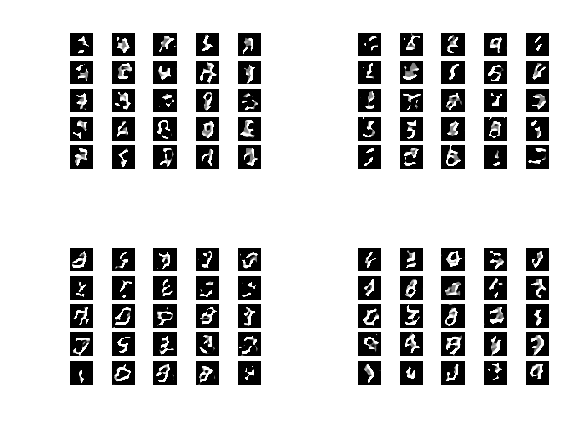

In [31]:
a = os.listdir()
import matplotlib.image as mpimg
sides= 2
img_it= 0
for i in range(0, sides) :
    for j in range(0, sides) :
        img = mpimg.imread(a[img_it])
        plt.subplot(sides, sides, 1 + img_it)
        plt.axis("off")
        img_it +=1
        plt.imshow(img )
        
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()        

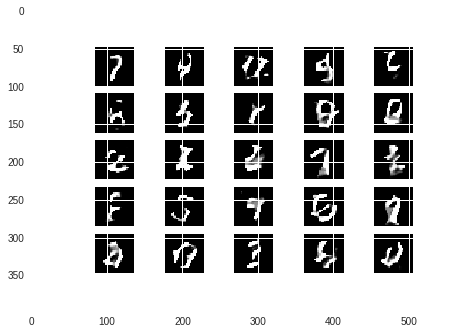

In [33]:
img = mpimg.imread('mnist_26400.png')
plt.imshow(img)